In [7]:
#General packages
import numpy as np
import pandas as pd

#For file downloading
import glob, os

#For visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

#For machine learning models:
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
import pydot

#To serialize and save the models after training them for the first time, then load them from memory afterwards to save time
from joblib import dump, load
#import dill 

import warnings
warnings.filterwarnings('ignore')

## Load and parse the data downloaded from Etsy and preselected-cleaned in the 'data_downloading' notebook


In [8]:
csv_filename_pattern = f'./Git_exclude/Data/all_paintings*.csv'

all_paintings_csv_files = glob.glob(csv_filename_pattern)
all_paintings_csv_files

['./Git_exclude/Data\\all_paintings_from_USD100_cleaned_listings.csv',
 './Git_exclude/Data\\all_paintings_from_USD100_listings_with_style_tags.csv',
 './Git_exclude/Data\\all_paintings_from_USD250_cleaned_listings.csv',
 './Git_exclude/Data\\all_paintings_from_USD250_listings_with_style_and_image_info.csv',
 './Git_exclude/Data\\all_paintings_from_USD250_listings_with_style_tags.csv']

In [9]:
# #Option 1: load all paintings in the $250-650 range, even if they don't have style and image information (~50000 entries)

# min_price = 250.0

# csv_all_cleaned_listings = f'./Git_exclude/Data/all_paintings_from_USD{int(min_price)}_cleaned_listings.csv'
# all_paintings_df = pd.read_csv(csv_all_cleaned_listings)
# print(f'Loaded listings file {csv_all_cleaned_listings} with all the cleaned listings (multiple taxonomies, with or without style data).')

In [10]:
#Option 2: load only the paintings in the $250-650 range that have style information (~20000 entries)

# min_price = 250.0

# csv_all_cleaned_listings_w_style = f'./Git_exclude/Data/all_paintings_from_USD{int(min_price)}_listings_with_style_tags.csv'
# paintings_with_style_tags_df = pd.read_csv(csv_all_cleaned_listings_w_style)
# print(f'Loaded all listings file {csv_all_cleaned_listings_w_style} with some style-related tags, after cleaning up the data.')

In [11]:
#Option 3: load only the paintings in the $250-650 range that have style and also image information (~20000 entries, just ~300 fewer than option 2)

# min_price = 250.0

# csv_combined_filename_w_style_n_image_info = f'./Git_exclude/Data/all_paintings_from_USD{int(min_price)}_listings_with_style_and_image_info.csv'
# paintings_with_style_tags_and_image_info_df = pd.read_csv(csv_combined_filename_w_style_n_image_info)
# print(f'Loaded all listings file {csv_combined_filename_w_style_n_image_info} with style-related tags and some image info, after cleaning up the data.')


In [12]:
#Option 4: load all the paintings in the $100-650 range that have at least some style and materials tags

min_price = 100.0

csv_combined_filename_w_style = f'./Git_exclude/Data/all_paintings_from_USD{int(min_price)}_listings_with_style_tags.csv'
paintings_with_style_tags_df = pd.read_csv(csv_combined_filename_w_style)
print(f'Loaded all listings file {csv_combined_filename_w_style} with style-related and materials-related tags, after cleaning up the data.')


Loaded all listings file ./Git_exclude/Data/all_paintings_from_USD100_listings_with_style_tags.csv with style-related and materials-related tags, after cleaning up the data.


In [13]:
#Option 5: load all the paintings in the $100-650 range that have at least some style and materials tags and also image information

# min_price = 100.0

# csv_combined_filename_w_style_n_image_info = f'./Git_exclude/Data/all_paintings_from_USD{int(min_price)}_listings_with_style_and_image_info.csv'
# paintings_with_style_tags_and_image_info_df = pd.read_csv(csv_combined_filename_w_style_n_image_info)
# print(f'Loaded all listings file {csv_combined_filename_w_style_n_image_info} with style-related and materials-related tags and some image info, after cleaning up the data.')


In [14]:
#For options 2 and 4 (stlye and materials tags, but no image information) 
all_paintings_df = paintings_with_style_tags_df

##For options 3 and 5 (stlye and materials tags, plus image information)
#all_paintings_df = paintings_with_style_tags_and_image_info_df

In [15]:
all_paintings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68554 entries, 0 to 68553
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   listing_id                   68554 non-null  int64  
 1   user_id                      68554 non-null  int64  
 2   shop_id                      68554 non-null  int64  
 3   title                        68553 non-null  object 
 4   description                  68554 non-null  object 
 5   shop_section_id              47075 non-null  float64
 6   featured_rank                68554 non-null  int64  
 7   url                          68554 non-null  object 
 8   num_favorers                 68554 non-null  int64  
 9   is_customizable              68554 non-null  bool   
 10  shipping_profile_id          49945 non-null  float64
 11  when_made                    68554 non-null  object 
 12  has_variations               68554 non-null  bool   
 13  price           

Keep the labels to be predicted, in this case the prices, in a separate data structure than the features. 

In [16]:
prices = all_paintings_df['price'].values

In [17]:
len(prices)

68554

In [18]:
#Note that this is a numpy array
prices[:5]

array([100., 100., 100., 100., 100.])

In [19]:
#How many different sellers are there?
all_paintings_df['shop_id'].nunique()

14645

In [20]:
#So in average every seller has 4 or more paintings in this list.. 
#it might be important to try to consider the shop_id as a categorical feature in future versions
#as different sellers are likely to have different price points based on their ability and/or business strategy

In [21]:
# # #This only applies for options 3 and 5:
# #check how many paintings have invalid 'mean_image' information - and impute nan values if any 
# all_paintings_df[['image_red','image_blue','image_green','image_saturation','image_hue','image_brightness']].describe()

In [22]:
#np.where(all_paintings_df[['image_red','image_blue','image_green','image_saturation','image_hue','image_brightness']].isna()==True)

In [23]:
#all_paintings_df[['image_red','image_blue','image_green','image_saturation','image_hue','image_brightness']].iloc[8070]

In [24]:
# #impute the missing values with the mean colors across all paintings:
# all_paintings_df['image_red'].fillna(value=all_paintings_df['image_red'].mean(),inplace=True)
# all_paintings_df['image_green'].fillna(value=all_paintings_df['image_green'].mean(),inplace=True)
# all_paintings_df['image_blue'].fillna(value=all_paintings_df['image_blue'].mean(),inplace=True)
# all_paintings_df['image_saturation'].fillna(value=all_paintings_df['image_saturation'].mean(),inplace=True)
# all_paintings_df['image_hue'].fillna(value=all_paintings_df['image_hue'].mean(),inplace=True)
# all_paintings_df['image_brightness'].fillna(value=all_paintings_df['image_brightness'].mean(),inplace=True)

In [25]:
#all_paintings_df[['image_red','image_blue','image_green','image_saturation','image_hue','image_brightness']].iloc[8070]

# Models


### Set aside 20% of the data for testing the model at the end - this also shuffles the dataframe (which is good since listings were ordered by price)

In [26]:
from sklearn.model_selection import train_test_split

paintings_df_train, paintings_df_test = train_test_split(all_paintings_df, test_size=0.2, random_state=1)

In [27]:
len(paintings_df_test)

13711

In [28]:
len(paintings_df_train)

54843

In [29]:
paintings_df_train.head()

listing_id    user_id   shop_id  \
31195  1022408416   16985175   6559478   
54435   844691761  308433303  23268049   
46479   943957210   19849751   6814176   
9498    601118320   36382301  15234739   
16695   905658437  335823576  24293355   

                                                   title  \
31195            Hand Painted Sailboat Barnwood Painting   
54435  Abstract Painting Original Large Acrylic Canva...   
46479                                    Rockport Dinghy   
9498                                         Orange Nose   
16695                          Appreciate the Difference   

                                             description  shop_section_id  \
31195  Hand painted sailboat acrylic painting on a ba...       11102514.0   
54435  MADE TO ORDER - UNSTRETCHED CANVAS - CREATION ...       28894275.0   
46479  An original Oil on canvas framed painting of a...              NaN   
9498   This is a 20&quot; in diameter circle painting...              NaN   
16695  This colorful narrative original 8&quot; x 8&q...       32500518.0   

       featured_rank                                                url  \
31195             -1  https://www.etsy.com/listing/1022408416/hand-p...   
54435             -1  https://www.etsy.com/listing/844691761/abstrac...   
46479             -1  https://www.etsy.com/listing/943957210/rockpor...   
9498              -1  https://www.etsy.com/listing/601118320/orange-...   
16695             -1  https://www.etsy.com/listing/905658437/appreci...   

       num_favorers  is_customizable  ...  max_dimension   area  aspect_ratio  \
31195             0            False  ...           25.0  425.0      1.470588   
54435             2            False  ...           48.0  240.0      9.600000   
46479             1            False  ...           18.0  252.0      1.285714   
9498              0            False  ...           24.0  576.0      1.000000   
16695             2            False  ...           12.0  144.0      1.000000   

       weight  days_from_original_creation  made_by_seller  painting_type  \
31195   120.0                          199           False        acrylic   
54435   320.0                          523            True        acrylic   
46479    64.0                          327            True            oil   
9498     83.0                         1323            True        acrylic   
16695    16.0                          409            True        acrylic   

                                      materials_tags_new  \
31195                        ['white', 'blue', 'hanger']   
54435  ['acrylic', 'white', 'palette', 'canvas', 'gra...   
46479                     ['stretched', 'oil', 'canvas']   
9498                                ['acrylic', 'resin']   
16695        ['hardboard', 'wood', 'acrylic', 'collage']   

                                                tags_new  \
31195  ['lake', 'decor', 'and', 'barnwood', 'art', 'w...   
54435  ['rooms', 'color', 'expression', 'colorful', '...   
46479  ['14', 'decor', 'dinghy', 'house', 'reflecting...   
9498               ['pour', 'painting', 'orange', 'art']   
16695  ['birds', 'colorful', 'night', 'moon', 'figura...   

                                          style_tags_new  
31195  ['nautical', 'cottage', 'primitive', 'coastal'...  
54435             ['contemporary', 'modern', 'abstract']  
46479                              ['beach', 'nautical']  
9498                                        ['abstract']  
16695                                       ['abstract']  

[5 rows x 25 columns]

In [30]:
paintings_df_test.head()

listing_id    user_id   shop_id  \
37169   671254913   89682024  14453345   
38391   584144370  145566755  17173044   
10861   981165196  145560799  17172722   
43138   884029182    9985593  18916452   
59885   809343706    9466728   5826470   

                                                   title  \
37169  Red Apples - Still Life Oil Painting 14 x 11  ...   
38391                 White Horse Original Hand Painting   
10861  Dark Moon River - Made-to-Order Original Acryl...   
43138                                   Weeping Confetti   
59885  Gold Leaf Abstract Texture Painting By Amy Nea...   

                                             description  shop_section_id  \
37169  Red Apples is an original still life Oil paint...       20899385.0   
38391  Having spent most of my life and training as a...              NaN   
10861  Dark Moon River is an original painting by imp...       25643548.0   
43138  Weeping Confetti\n18&quot;x 24&quot; Acrylic o...       25135607.0   
59885  An original textured abstract painting by Amy ...              NaN   

       featured_rank                                                url  \
37169             -1  https://www.etsy.com/listing/671254913/red-app...   
38391             -1  https://www.etsy.com/listing/584144370/white-h...   
10861             -1  https://www.etsy.com/listing/981165196/dark-mo...   
43138             -1  https://www.etsy.com/listing/884029182/weeping...   
59885             22  https://www.etsy.com/listing/809343706/gold-le...   

       num_favorers  is_customizable  ...  max_dimension   area  aspect_ratio  \
37169             0            False  ...           14.0  154.0      1.272727   
38391             4             True  ...           16.0  208.0      1.230769   
10861            16             True  ...            7.0   35.0      1.400000   
43138             1            False  ...           28.0  560.0      1.400000   
59885            13            False  ...           26.0  676.0      1.000000   

       weight  days_from_original_creation  made_by_seller  painting_type  \
37169    48.0                         1096            True            oil   
38391    12.0                         1398            True            oil   
10861    48.0                          269            True        acrylic   
43138    80.0                          422            True        acrylic   
59885    96.0                          566            True  more_than_one   

                                      materials_tags_new  \
37169  ['canvas', 'cotton', 'stretched', 'unframed', ...   
38391                 ['white', 'oil', 'canvas', 'fine']   
10861  ['acrylic', 'purple', 'canvas', 'stretched', '...   
43138                                         ['yellow']   
59885  ['gold', 'white', 'texture', 'canvas', 'leaf',...   

                                                tags_new  \
37169  ['14', 'life', 'fruit', 'apples', 'art', 'appl...   
38391  ['14', 'beautiful', 'horse', 'detailed', 'art'...   
10861  ['nature', 'brushstrokes', 'painting', 'flower...   
43138  ['wet', 'decor', 'colorful', 'bright', 'mid', ...   
59885  ['square', 'patina', 'original', 'distressed',...   

                               style_tags_new  
37169                             ['realism']  
38391                             ['western']  
10861          ['impressionism', 'landscape']  
43138       ['century', 'modern', 'abstract']  
59885  ['contemporary', 'modern', 'abstract']  

[5 rows x 25 columns]

In [31]:
paintings_df_test.index[:5]

Int64Index([37169, 38391, 10861, 43138, 59885], dtype='int64')

In [32]:
#Make sure the test set has all 4 painting types represented
paintings_df_test['painting_type'].value_counts()

acrylic          6608
oil              4059
watercolor       2105
more_than_one     939
Name: painting_type, dtype: int64

In [33]:
paintings_df_train['painting_type'].value_counts()

acrylic          26019
oil              16569
watercolor        8378
more_than_one     3877
Name: painting_type, dtype: int64

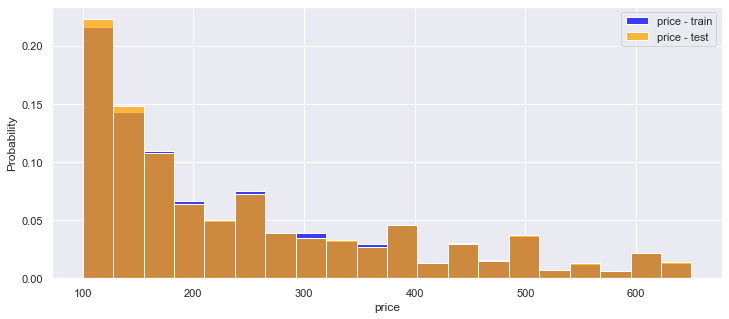

In [34]:
#check that the price distribution is also consistent:
plt.figure(figsize=(12,5))
sns.histplot(data=paintings_df_train,x='price',stat='probability',bins=20,color='blue')
sns.histplot(data=paintings_df_test,x='price',stat='probability',bins=20,color='orange')
plt.legend(['price - train','price - test'])

In [35]:
#I need to also rearrange the 'prices' numpy array, so that I can later trace back the corresponding rows in the dataframe
prices_train = prices[paintings_df_train.index]
prices_test = prices[paintings_df_test.index]

### Feature types

In [36]:
#Let's divide the columns (features) into different groups, as I will test different models with different combinations of features
numerical_columns = ['num_favorers','featured_rank','max_dimension','aspect_ratio','area','weight','days_from_original_creation'] 

categorical_columns = ['painting_type','when_made'] 

boolean_columns = ['made_by_seller','is_customizable','has_variations']

#the following are textual 'tags' that refer to style, materials (and some colors) or other tags that don't fall in either category
tag_columns = ['style_tags_new','materials_tags_new','tags_new']

#The following are 'free text' that are unlikely to be very predictive, but I could try to add them in future versions
text_columns = ['title','description']

##image info when available (for Options 3 or 5)
#image_columns = ['image_red','image_green','image_blue','image_hue','image_saturation','image_brightness']

#Finally, this is the identifier of the seller/artist that could be included in future versions:
user_column = ['shop_id']


### Baseline results picking the mean price of the paintings in the training set as my predictions

In [37]:
np.mean(prices_train)

247.31057473150634

In [38]:
trivial_price_pred_train = np.ones(len(prices_train)) * np.mean(prices_train)

In [39]:
trivial_price_pred_test = np.ones(len(prices_test)) * np.mean(prices_train)

In [40]:
#auxiliary function that will be used throughout to assess performance of different models:

from sklearn import metrics

def print_all_scores_train_test(y_train,y_train_pred,y_test,y_test_pred,model_name='Results'):
    print(model_name+':')
    print("Training R^2:", metrics.r2_score(y_train, y_train_pred))
    print("Testing R^2:", metrics.r2_score(y_test, y_test_pred))
    print("Training RMSE: USD", np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
    print("Testing RMSE: USD", np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
    print("Training MAE: USD", metrics.mean_absolute_error(y_train, y_train_pred))
    print("Testing MAE: USD", metrics.mean_absolute_error(y_test, y_test_pred))

print_all_scores_train_test(prices_train,trivial_price_pred_train,prices_test,trivial_price_pred_test,model_name='Trivial model using the mean price of the training set paintings')

Trivial model using the mean price of the training set paintings:
Training R^2: 0.0
Testing R^2: -4.194280976577147e-05
Training RMSE: USD 140.76932362561388
Testing RMSE: USD 142.14800650662107
Training MAE: USD 114.50826464244624
Testing MAE: USD 115.81658310644096


## 1) Models using only numerical features

In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#I could select and scale at the same time:
numerical_scaler_selector = ColumnTransformer([
    ('numerical scaled (std)', StandardScaler(), numerical_columns),
], remainder='drop')

In [42]:
#But it's probably cleaner to keep the selector and the scaling separately, e.g. 
numerical_selector = ColumnTransformer([
    ('numerical', 'passthrough', numerical_columns),
], remainder='drop')

In [43]:
#and then do the scaling of part of a Pipeline, e.g.
from sklearn.pipeline import Pipeline

numerical_preproc_pipe = Pipeline([
    ('numerical selector', numerical_selector),
    ('standard scaling', StandardScaler()),
])

### Model 1a) Linear regression using only numerical features

In [44]:
#This is a good start since it has no parameters to fit, and the solution is really fast to compute (no cross-validation, etc.)
from sklearn.linear_model import LinearRegression

numerical_linreg_pipe = Pipeline([('numerical preproc', numerical_preproc_pipe),
                      ('linear reg', LinearRegression())])

In [45]:
#Let's visualize this pipeline:
from sklearn import set_config
set_config(display='diagram')

numerical_linreg_pipe

Pipeline(steps=[('numerical preproc',
                 Pipeline(steps=[('numerical selector',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   'passthrough',
                                                                   ['num_favorers',
                                                                    'featured_rank',
                                                                    'max_dimension',
                                                                    'aspect_ratio',
                                                                    'area',
                                                                    'weight',
                                                                    'days_from_original_creation'])])),
                                 ('standard scaling', StandardScaler())])),
                ('linear reg', LinearRegression())])

In [46]:
#Train the model
numerical_linreg_pipe.fit(paintings_df_train,prices_train);

In [47]:
#Predict prices on training set:
prices_train_pred = numerical_linreg_pipe.predict(paintings_df_train)

In [48]:
#And return the R2 score as follows:
numerical_linreg_pipe.score(paintings_df_train,prices_train)

0.15301805357824239

In [49]:
#Predict prices on test set:
prices_test_pred = numerical_linreg_pipe.predict(paintings_df_test)

In [50]:
#And return the R2 score as follows:
numerical_linreg_pipe.score(paintings_df_test,prices_test)

0.16241954534706127

In [51]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Linear regression model using only numerical features')

#Note that I am not overfitting the training data, since the model actually does better on test data

Linear regression model using only numerical features:
Training R^2: 0.15301805357824239
Testing R^2: 0.16241954534706127
Training RMSE: USD 129.55229193548735
Testing RMSE: USD 130.0903053513099
Training MAE: USD 102.25969814414985
Testing MAE: USD 102.51902023110482


Text(0, 0.5, 'predicted prices (test)')

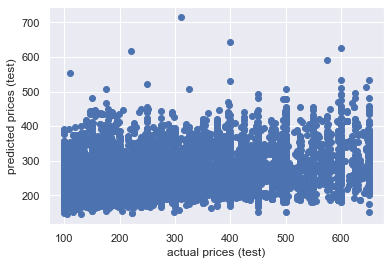

In [52]:
plt.scatter(prices_test,prices_test_pred)
plt.xlabel('actual prices (test)')
plt.ylabel('predicted prices (test)')

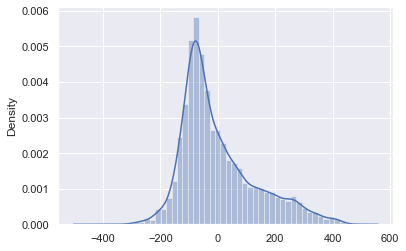

In [53]:
#Plot residuals:
sns.distplot((prices_test-prices_test_pred),bins=50);

In [54]:
#Let's look at the coefficients of the model
# intercept
print(numerical_linreg_pipe['linear reg'].intercept_)

247.31057473150634


In [55]:
#coefficients for each variable:
coeff_df = pd.DataFrame(numerical_linreg_pipe['linear reg'].coef_,numerical_columns,columns=['Lin Reg Coeff'])
coeff_df

Lin Reg Coeff
num_favorers                     -0.833730
featured_rank                     5.771860
max_dimension                    25.879320
aspect_ratio                      4.306101
area                             22.808692
weight                           12.217222
days_from_original_creation       6.930578

In [56]:
#looks like area and max_dimension are the most informative numerical variables

### Model 1b) Ridge regression with polynomial terms using only numerical features

In [57]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

numerical_polyreg_ridge_pipe = Pipeline([('numerical preproc', numerical_preproc_pipe),
                      ('polynomial_trans', PolynomialFeatures(degree=3,include_bias=False)),            
                      ('ridge', Ridge(alpha=10))])

numerical_polyreg_ridge_pipe

Pipeline(steps=[('numerical preproc',
                 Pipeline(steps=[('numerical selector',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   'passthrough',
                                                                   ['num_favorers',
                                                                    'featured_rank',
                                                                    'max_dimension',
                                                                    'aspect_ratio',
                                                                    'area',
                                                                    'weight',
                                                                    'days_from_original_creation'])])),
                                 ('standard scaling', StandardScaler())])),
                ('polynomial_trans',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('ridge', Ridge(alpha=10))])

In [58]:
from sklearn.model_selection import GridSearchCV

#I will need to search for the right alpha using Cross Validation:
param_grid = {'ridge__alpha': np.logspace(0,8,20)} 
numerical_polyreg_ridge_CVmodel = GridSearchCV(numerical_polyreg_ridge_pipe, param_grid, cv=5, n_jobs=1, verbose=1)

In [59]:
numerical_polyreg_ridge_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.0s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('numerical preproc',
                                        Pipeline(steps=[('numerical selector',
                                                         ColumnTransformer(transformers=[('numerical',
                                                                                          'passthrough',
                                                                                          ['num_favorers',
                                                                                           'featured_rank',
                                                                                           'max_dimension',
                                                                                           'aspect_ratio',
                                                                                           'area',
                                                                                           'weight',
                                                                                           'days_from_original_creation'])])),
                                                        ('standard scaling',
                                                         StandardScaler())])),
                                       ('polynomial_trans',
                                        PolynomialFeatur...
             n_jobs=1,
             param_grid={'ridge__alpha': array([1.00000000e+00, 2.63665090e+00, 6.95192796e+00, 1.83298071e+01,
       4.83293024e+01, 1.27427499e+02, 3.35981829e+02, 8.85866790e+02,
       2.33572147e+03, 6.15848211e+03, 1.62377674e+04, 4.28133240e+04,
       1.12883789e+05, 2.97635144e+05, 7.84759970e+05, 2.06913808e+06,
       5.45559478e+06, 1.43844989e+07, 3.79269019e+07, 1.00000000e+08])},
             verbose=1)

In [60]:
numerical_polyreg_ridge_CVmodel.best_params_

{'ridge__alpha': 885.8667904100823}

In [61]:
#Predict prices on training set:
prices_train_pred = numerical_polyreg_ridge_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
numerical_polyreg_ridge_CVmodel.score(paintings_df_train,prices_train)

0.18094450431612985

In [62]:
#Predict prices on test set:
prices_test_pred = numerical_polyreg_ridge_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
numerical_polyreg_ridge_CVmodel.score(paintings_df_test,prices_test)

0.17707212206228673

In [63]:
print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Polynomial Ridge regression model using only numerical features')

Polynomial Ridge regression model using only numerical features:
Training R^2: 0.18094450431612985
Testing R^2: 0.17707212206228673
Training RMSE: USD 127.39860960318742
Testing RMSE: USD 128.94738920145667
Training MAE: USD 100.4619737634836
Testing MAE: USD 101.15915034605676


Text(0, 0.5, 'predicted prices (test)')

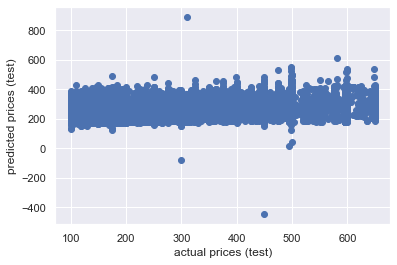

In [64]:
plt.scatter(prices_test,prices_test_pred)
plt.xlabel('actual prices (test)')
plt.ylabel('predicted prices (test)')

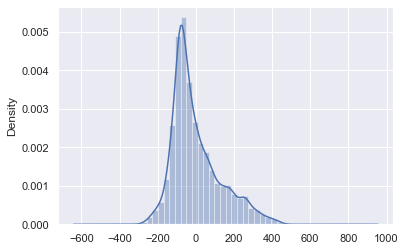

In [65]:
#Plot residuals:
sns.distplot((prices_test-prices_test_pred),bins=50);

In [66]:
### The ridge regression model with polynomial features improves only marginally the perfrmance of the 
# basic linear regression model, which is also going to be much more interpretable. 
#So I keep that as my best linear-kind model for numerical only variables and I save it (unless already done so earlier)

In [67]:
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

numerical_linreg_pipe_filename = './Git_exclude/models/numerical_linreg_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(numerical_linreg_pipe_filename, 'rb') as f:
        numerical_linreg_pipe = load(f)
        print('Loaded joblib file with numerical-only linear regression.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    numerical_linreg_pipe.fit(paintings_df_train,prices_train);
    
    with open(numerical_linreg_pipe_filename, 'wb') as f:
        dump(numerical_linreg_pipe, numerical_linreg_pipe_filename) 
    print('Saved joblib file with numerical-only linear regression.')

# #Version with dill

# import dill

# #If the model file already exists, I load it:
# try:
#     with open('lat_long_model.dill', 'rb') as f:
#         lat_long_model = dill.load(f)
#         print('Loaded pickle file with lat-long model.')
# except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
#     lat_long_model.fit(data_shuffled, star_ratings_shuffled)
    
#     with open('lat_long_model.dill', 'wb') as f:
#         dill.dump(lat_long_model, f)
#     print('Saved pickle file with lat-long model.')


Loaded joblib file with numerical-only linear regression.


#### Model 1c) Decision tree using only numerical features

In [68]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
import pydot

In [69]:
# #Recall that I already have the numerical selector, which need not change:
# numerical_selector = ColumnTransformer([
#     ('numerical', 'passthrough', numerical_columns),
# ], remainder='drop')

In [70]:
#there's no need to rescale for tree-based algorithms, so I can jump straight to the Pipeline performing the regression
from sklearn.pipeline import Pipeline

numerical_dtree_pipe = Pipeline([
    ('numerical selector', numerical_selector),
    ('dtree', DecisionTreeRegressor(max_depth=3)),
])

In [71]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,12,1)} 
numerical_dtree_CVmodel = GridSearchCV(numerical_dtree_pipe, param_grid, cv=5, n_jobs=1, verbose=1)

In [72]:
numerical_dtree_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    3.8s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('numerical selector',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         'passthrough',
                                                                         ['num_favorers',
                                                                          'featured_rank',
                                                                          'max_dimension',
                                                                          'aspect_ratio',
                                                                          'area',
                                                                          'weight',
                                                                          'days_from_original_creation'])])),
                                       ('dtree',
                                        DecisionTreeRegressor(max_depth=3))]),
             n_jobs=1, param_grid={'dtree__max_depth': range(2, 12)},
             verbose=1)

In [73]:
numerical_dtree_CVmodel.best_params_['dtree__max_depth']

10

In [74]:
#Predict prices on training set:
prices_train_pred = numerical_dtree_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
numerical_dtree_CVmodel.score(paintings_df_train,prices_train)

0.29722517997631503

In [75]:
#Predict prices on test set:
prices_test_pred = numerical_dtree_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
numerical_dtree_CVmodel.score(paintings_df_test,prices_test)

0.24072267156121985

In [76]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using only numerical features')


Decision Tree model using only numerical features:
Training R^2: 0.29722517997631503
Testing R^2: 0.24072267156121985
Training RMSE: USD 118.00926900995213
Testing RMSE: USD 123.86022998297287
Training MAE: USD 89.51019627310644
Testing MAE: USD 94.02477923066961


In [77]:
#what are the main features used for decision?
numerical_dtree_CVmodel.best_estimator_['dtree'].feature_importances_

array([0.01457161, 0.01387341, 0.43976932, 0.05988019, 0.18018931,
       0.17858457, 0.1131316 ])

In [78]:
feature_names_num_dtree = numerical_dtree_CVmodel.best_estimator_['numerical selector'].get_feature_names()

numerical_dtree_features_imp_df = pd.DataFrame(numerical_dtree_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_num_dtree,columns=['Dtree feature importance'])
numerical_dtree_features_imp_df = numerical_dtree_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
numerical_dtree_features_imp_df

Dtree feature importance
max_dimension                                0.439769
area                                         0.180189
weight                                       0.178585
days_from_original_creation                  0.113132
aspect_ratio                                 0.059880
num_favorers                                 0.014572
featured_rank                                0.013873

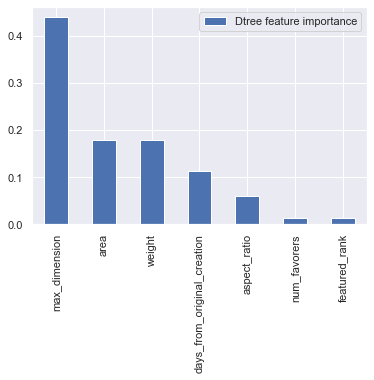

In [79]:
numerical_dtree_features_imp_df.plot(kind="bar").legend(loc="upper right");

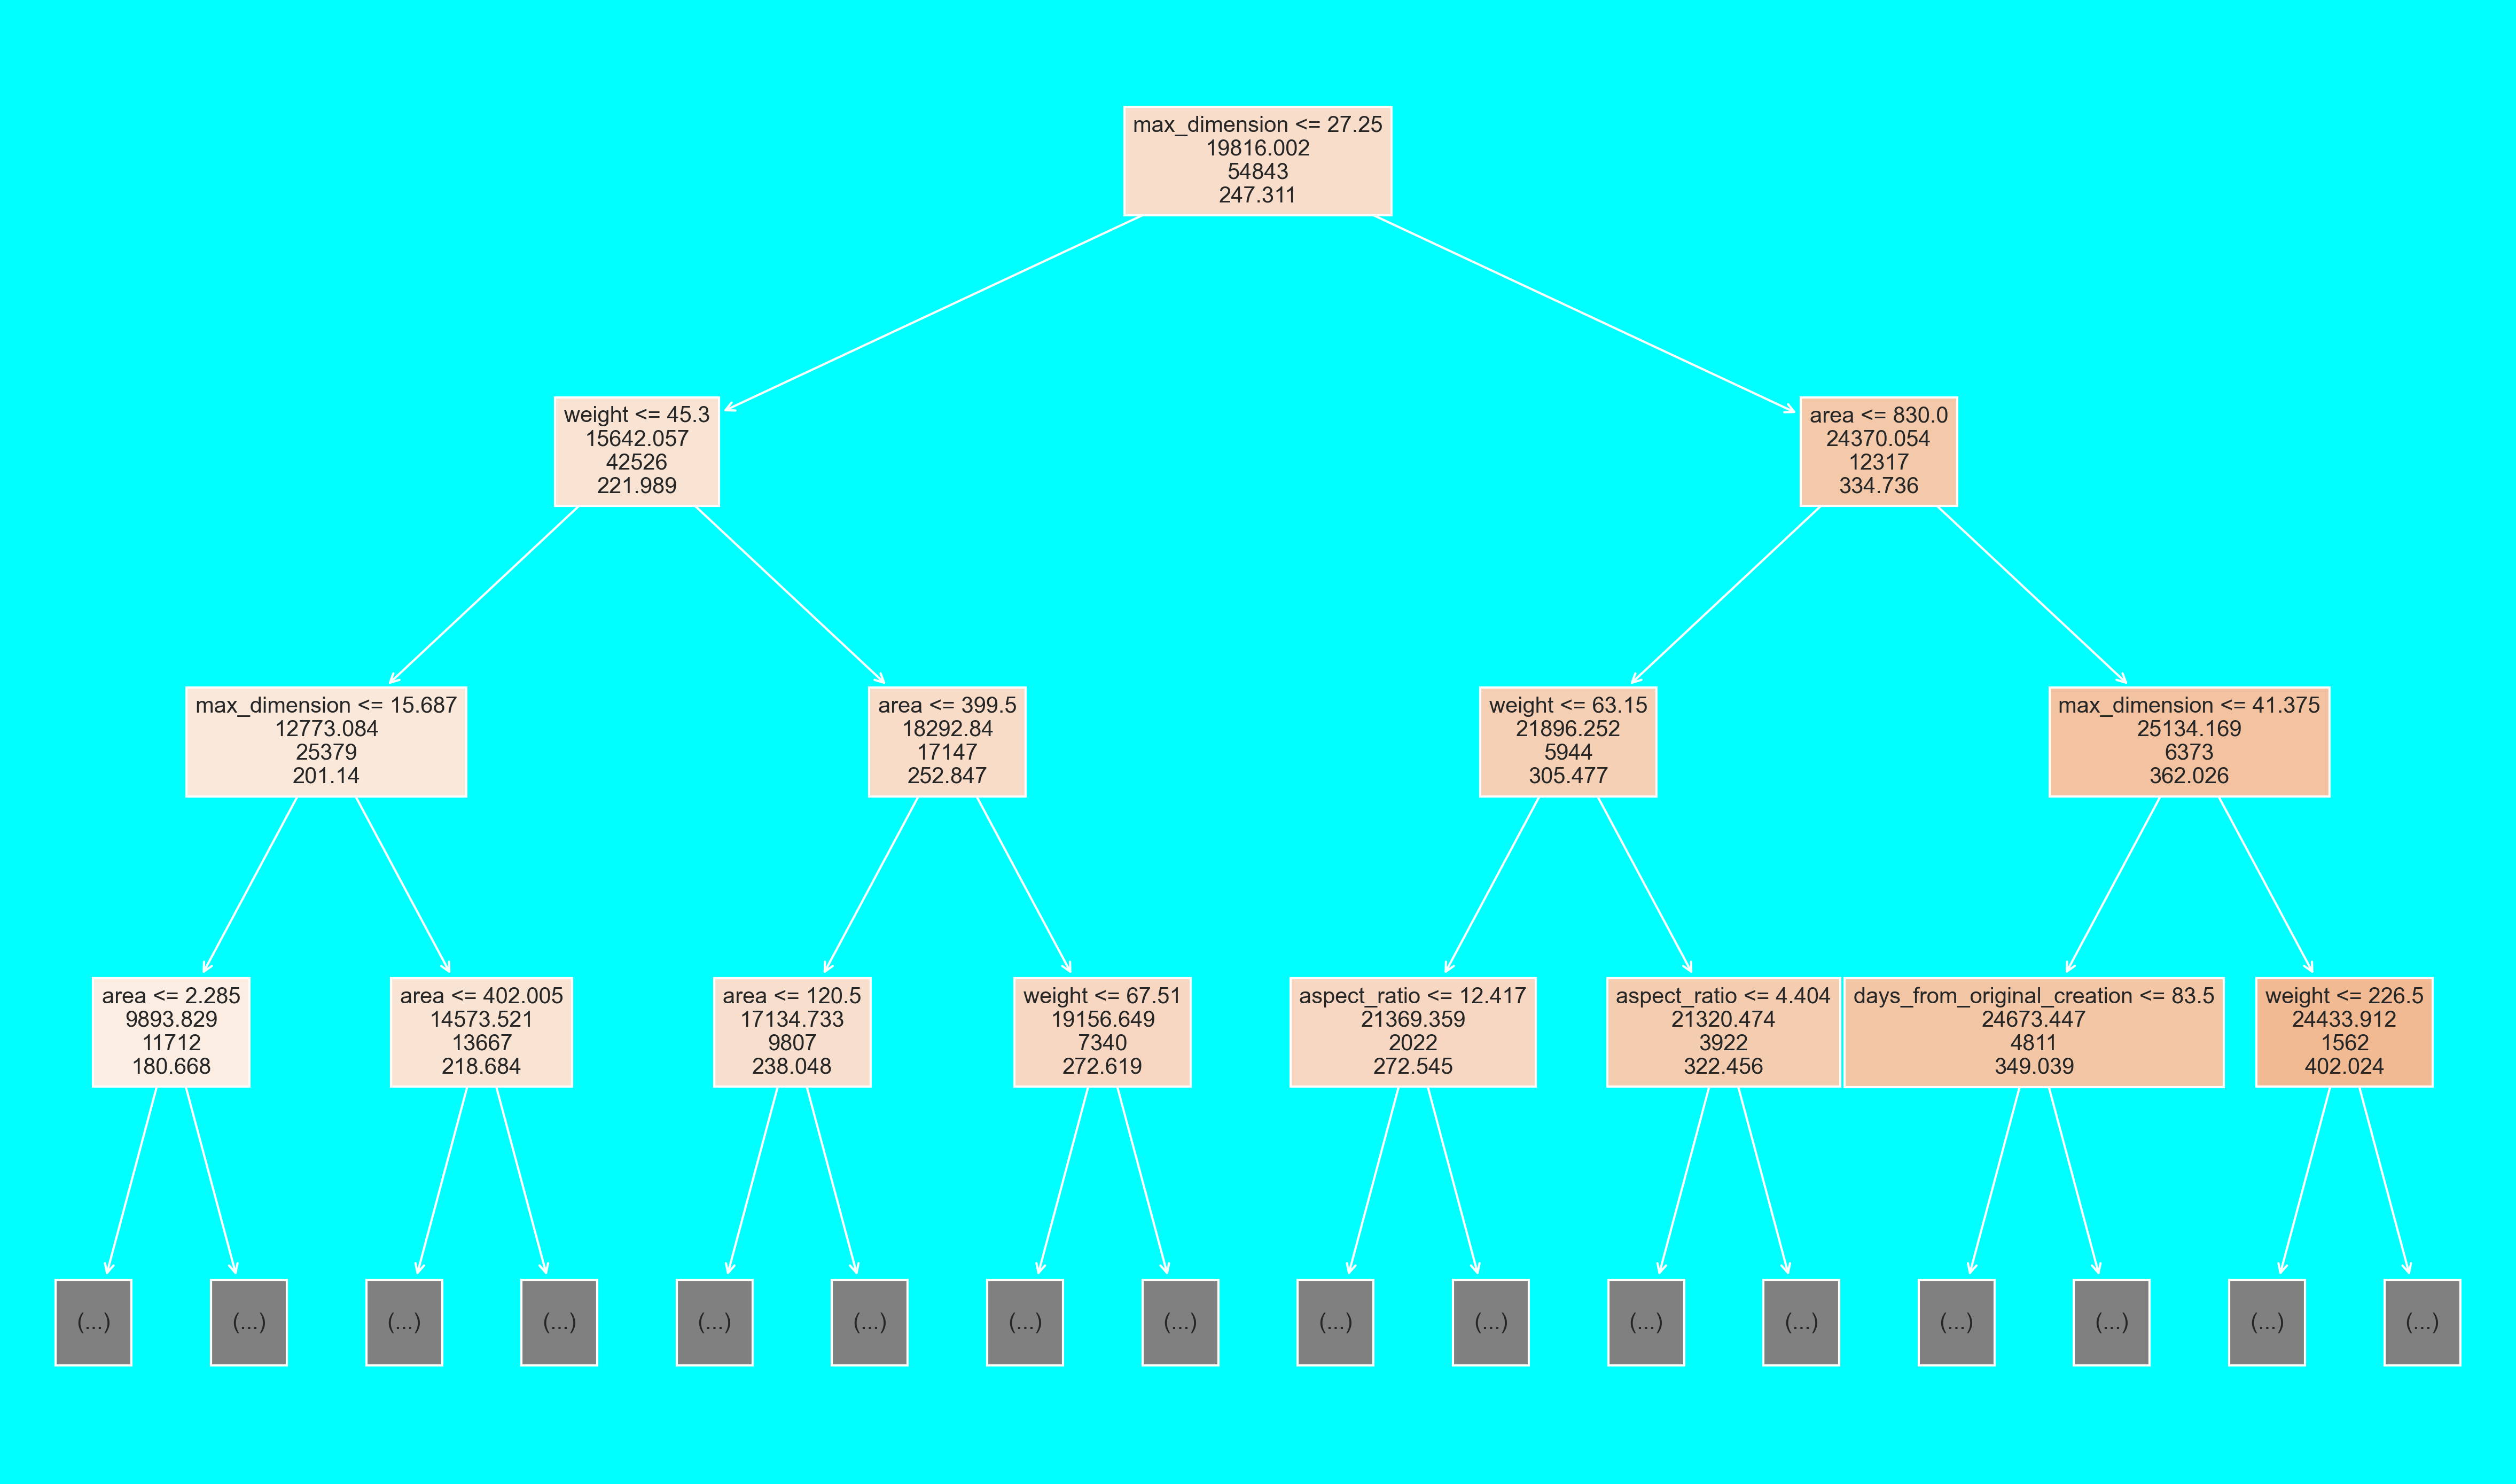

In [80]:
# Generate a plot of the decision tree
fig = plt.figure(figsize=(20,12), dpi=300)
fig.set_facecolor("cyan")
tree_viz = plot_tree(numerical_dtree_CVmodel.best_estimator_['dtree'],max_depth=3,fontsize=10,label='none',filled=True,feature_names = feature_names_num_dtree)
fig.savefig('./Git_exclude/Figures/decision_tree_numerical_only.png')

#### Model 1d) Random Forest using only numerical features

In [81]:
from sklearn.ensemble import RandomForestRegressor

In [82]:
numerical_rforest_pipe = Pipeline([
    ('numerical selector', numerical_selector),
    ('rforest', RandomForestRegressor(n_estimators=20,max_features='sqrt',n_jobs=2,max_depth=numerical_dtree_CVmodel.best_params_['dtree__max_depth']+1,random_state=1,max_samples=0.8))
])

In [83]:
numerical_rforest_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('numerical selector',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['num_favorers',
                                                   'featured_rank',
                                                   'max_dimension',
                                                   'aspect_ratio', 'area',
                                                   'weight',
                                                   'days_from_original_creation'])])),
                ('rforest',
                 RandomForestRegressor(max_depth=11, max_features='sqrt',
                                       max_samples=0.8, n_estimators=20,
                                       n_jobs=2, random_state=1))])

In [84]:
#Predict prices on training set:
prices_train_pred = numerical_rforest_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
numerical_rforest_pipe.score(paintings_df_train,prices_train)

0.3300784479062513

In [85]:
#Predict prices on test set:
prices_test_pred = numerical_rforest_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
numerical_rforest_pipe.score(paintings_df_test,prices_test)

0.2791829373198518

In [86]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using only numerical features')


Random Forest model using only numerical features:
Training R^2: 0.3300784479062513
Testing R^2: 0.2791829373198518
Training RMSE: USD 115.21791151415749
Testing RMSE: USD 120.68247134886651
Training MAE: USD 88.87909011356744
Testing MAE: USD 92.89667899787739


In [87]:
#what are the main features used for decision?
numerical_rforest_pipe['rforest'].feature_importances_

array([0.04245373, 0.02175764, 0.29988564, 0.07922808, 0.25864778,
       0.18578508, 0.11224204])

In [88]:
feature_names_num_rforest = numerical_rforest_pipe['numerical selector'].get_feature_names()

numerical_rforest_features_imp_df = pd.DataFrame(numerical_rforest_pipe['rforest'].feature_importances_,feature_names_num_rforest,columns=['Rforest feature importance'])
numerical_rforest_features_imp_df = numerical_rforest_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
numerical_rforest_features_imp_df

Rforest feature importance
max_dimension                                  0.299886
area                                           0.258648
weight                                         0.185785
days_from_original_creation                    0.112242
aspect_ratio                                   0.079228
num_favorers                                   0.042454
featured_rank                                  0.021758

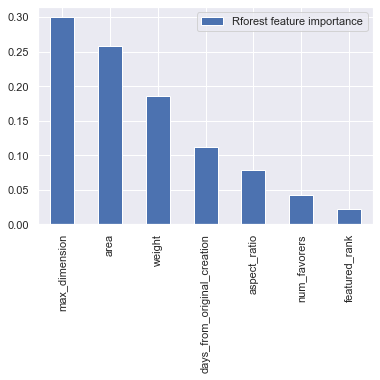

In [89]:
numerical_rforest_features_imp_df.plot(kind="bar").legend(loc="upper right");

#### Model 1e) Gradient Boosting Trees using only numerical features¶

In [90]:
from sklearn.ensemble import GradientBoostingRegressor

In [91]:
numerical_gboost_pipe = Pipeline([
    ('numerical selector', numerical_selector),
    ('gboost', GradientBoostingRegressor(n_estimators=50,learning_rate=0.1,subsample=0.5,max_depth=numerical_dtree_CVmodel.best_params_['dtree__max_depth']-1,random_state=1))
])

In [92]:
numerical_gboost_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('numerical selector',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['num_favorers',
                                                   'featured_rank',
                                                   'max_dimension',
                                                   'aspect_ratio', 'area',
                                                   'weight',
                                                   'days_from_original_creation'])])),
                ('gboost',
                 GradientBoostingRegressor(max_depth=9, n_estimators=50,
                                           random_state=1, subsample=0.5))])

In [93]:
#Predict prices on training set:
prices_train_pred = numerical_gboost_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
numerical_gboost_pipe.score(paintings_df_train,prices_train)

0.4047461615239356

In [94]:
#Predict prices on test set:
prices_test_pred = numerical_gboost_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
numerical_gboost_pipe.score(paintings_df_test,prices_test)

0.301085746113094

In [95]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosting model using only numerical features')


Gradient Boosting model using only numerical features:
Training R^2: 0.4047461615239356
Testing R^2: 0.301085746113094
Training RMSE: USD 108.60732726619928
Testing RMSE: USD 118.83479320911603
Training MAE: USD 83.40415009602364
Testing MAE: USD 90.87033418639245


In [96]:
#what are the main features used for decision?
numerical_gboost_pipe['gboost'].feature_importances_

array([0.06430168, 0.02747226, 0.27678613, 0.0836528 , 0.16609177,
       0.17526164, 0.20643372])

In [97]:
feature_names_num_gboost = numerical_gboost_pipe['numerical selector'].get_feature_names()

numerical_gboost_features_imp_df = pd.DataFrame(numerical_gboost_pipe['gboost'].feature_importances_,feature_names_num_gboost,columns=['Gboost feature importance'])
numerical_gboost_features_imp_df = numerical_gboost_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
numerical_gboost_features_imp_df

Gboost feature importance
max_dimension                                 0.276786
days_from_original_creation                   0.206434
weight                                        0.175262
area                                          0.166092
aspect_ratio                                  0.083653
num_favorers                                  0.064302
featured_rank                                 0.027472

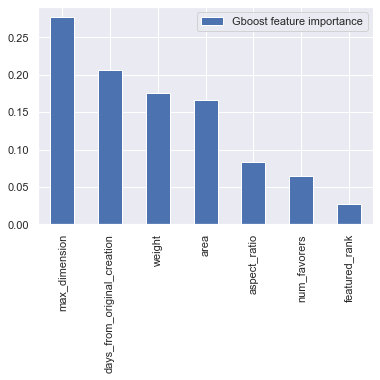

In [98]:
numerical_gboost_features_imp_df.plot(kind="bar").legend(loc="upper right");

## 2) Models using only categorical (and boolean) features

In [99]:
#I create a custom regressor to assess some 'baseline' model based on the 'painting_type' categorical feature: 
#how good is a model where I just return the mean price for all paintings of that category (e.g. all watercolors)? 

In [100]:
#Note that a sklearn Regressor takes numpy arrays - not dictionaries - but if I use a ColumnTransformer before the regressor I am fine

In [101]:
painting_type_selector = ColumnTransformer([
    ('categorical', 'passthrough', ['painting_type']),
], remainder='drop')

In [102]:
#check that the output is a 2Darray
temp = painting_type_selector.fit_transform(paintings_df_train)

In [103]:
for listing in temp[:3]:
    print(listing)

['acrylic']
['acrylic']
['oil']


#### 2a) Baseline model using the mean price of paintings of each type

In [104]:
from sklearn.base import BaseEstimator, RegressorMixin

import numpy as np
from collections import defaultdict

class CategoricalMeanRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self):
        self.avg_price = dict()
    
    def fit(self, X, y):
        # Store the average price per categorical feature in self.avg_price
        price_sum = defaultdict(int)
        count = defaultdict(int)
 
        for listing, price in zip(X, y):
            # increment the running sum in price_sum
            price_sum[listing[0]]+=price
            # increment the running count in count
            count[listing[0]]+=1
        
        for category in price_sum:
            self.avg_price[category]=price_sum[category]/count[category]
               
        return self
    
    def predict(self, X):
        predictions = np.zeros(len(X))
        
        for idx, listing in enumerate(X):
            if listing[0] in self.avg_price.keys():
                predictions[idx]=self.avg_price[listing[0]]
        
        return predictions

In [105]:
#Let's create a pipeline to apply the above "regressor" to the 'painting_type' column

from sklearn.pipeline import Pipeline

painting_type_mean_pipe = Pipeline([
    ('painting type selector', painting_type_selector),
    ('mean of painting_type', CategoricalMeanRegressor()),
])

In [106]:
painting_type_mean_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('painting type selector',
                 ColumnTransformer(transformers=[('categorical', 'passthrough',
                                                  ['painting_type'])])),
                ('mean of painting_type', CategoricalMeanRegressor())])

In [107]:
painting_type_mean_pipe[-1].avg_price

{'acrylic': 234.61577654790995,
 'oil': 284.5090095962385,
 'watercolor': 213.75605991883472,
 'more_than_one': 246.04279339695617}

In [108]:
#Check the results are right:
paintings_df_train.groupby(by='painting_type').mean()

listing_id       user_id       shop_id  shop_section_id  \
painting_type                                                              
acrylic        8.368579e+08  1.538163e+08  1.760321e+07     2.635560e+07   
more_than_one  7.860339e+08  1.227163e+08  1.545193e+07     2.486947e+07   
oil            8.248457e+08  1.212292e+08  1.508390e+07     2.408944e+07   
watercolor     8.065606e+08  1.231181e+08  1.547952e+07     2.488134e+07   

               featured_rank  num_favorers  is_customizable  \
painting_type                                                 
acrylic            -0.296207      8.534494         0.119797   
more_than_one       0.121744     12.508383         0.139025   
oil                 1.081417     13.098980         0.121432   
watercolor          0.498687     13.153617         0.190260   

               shipping_profile_id  has_variations       price  taxonomy_id  \
painting_type                                                                 
acrylic               9.179736e+10        0.107767  234.615777   106.000000   
more_than_one         8.202767e+10        0.104204  246.042793   109.214083   
oil                   8.034883e+10        0.117086  284.509010   112.000000   
watercolor            7.952441e+10        0.201838  213.756060   114.000000   

               max_dimension        area  aspect_ratio     weight  \
painting_type                                                       
acrylic            23.272763  446.114022      1.586626  59.784426   
more_than_one      23.014622  456.100809      1.560058  70.176796   
oil                22.492054  437.207656      1.478971  69.342672   
watercolor         17.949234  265.594636      1.563859  33.524685   

               days_from_original_creation  made_by_seller  
painting_type                                               
acrylic                         656.999846        0.945386  
more_than_one                   810.737942        0.862523  
oil                             693.768845        0.755085  
watercolor                      752.584507        0.857006

In [109]:
#Now I am ready to assess the performance of this model:
prices_pred_train = painting_type_mean_pipe.predict(paintings_df_train)
prices_pred_test = painting_type_mean_pipe.predict(paintings_df_test)

In [110]:
print_all_scores_train_test(prices_train,prices_pred_train,prices_test,prices_pred_test,model_name='Trivial model using the mean price of the paintings of same type in the training set')

Trivial model using the mean price of the paintings of same type in the training set:
Training R^2: 0.03364022124029076
Testing R^2: 0.0387022251672694
Training RMSE: USD 138.38131292442947
Testing RMSE: USD 139.36721913629634
Training MAE: USD 112.20255395284957
Testing MAE: USD 113.01600923649475


In [111]:
#Select the categorical features (defined earlier) and apply OneHotEncoding to all of them - 
#for now I drop the first column since I will try LinearRegression and want to avoid multi-collinearity
#Separately, pass through the boolean variables

In [112]:
from sklearn.preprocessing import OneHotEncoder

categorical_selector = ColumnTransformer([
     ('categorical', OneHotEncoder(drop='first'), categorical_columns),
    ('boolean','passthrough', boolean_columns),
 ], remainder='drop')

In [113]:
categorical_selector.fit_transform(paintings_df_train)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.]])

In [114]:
categorical_feature_names = categorical_selector.get_feature_names()

#### Model 2b) Linear regression using only categorical features

In [115]:
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline

categorical_linreg_pipe = Pipeline([
    ('categorical selector', categorical_selector),
    ('linear reg', LinearRegression()),
])


In [116]:
#Train the model
categorical_linreg_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('categorical selector',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(drop='first'),
                                                  ['painting_type',
                                                   'when_made']),
                                                 ('boolean', 'passthrough',
                                                  ['made_by_seller',
                                                   'is_customizable',
                                                   'has_variations'])])),
                ('linear reg', LinearRegression())])

In [117]:
#Predict prices on training set:
prices_train_pred = categorical_linreg_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
categorical_linreg_pipe.score(paintings_df_train,prices_train)

0.04766038974853348

In [118]:
#Predict prices on test set:
prices_test_pred = categorical_linreg_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
categorical_linreg_pipe.score(paintings_df_test,prices_test)

0.050458332714103826

In [119]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Linear regression model using only categorical features with One-hot-encoding')


Linear regression model using only categorical features with One-hot-encoding:
Training R^2: 0.04766038974853348
Testing R^2: 0.050458332714103826
Training RMSE: USD 137.37381145197747
Testing RMSE: USD 138.51240799334178
Training MAE: USD 110.8477719612572
Testing MAE: USD 111.77804664630203


In [120]:
#Let's look at the coefficients of the model
# intercept
print(categorical_linreg_pipe['linear reg'].intercept_)

251.42363687170666


In [121]:
categorical_linreg_pipe['linear reg'].coef_

array([  9.01220948,  46.30239599, -22.9820757 , -27.82138366,
       -10.08031659, -35.44404497,  -1.36601678,  29.16551168,
        -1.43606668])

In [122]:
#coefficients for each variable:
coeff_df = pd.DataFrame(categorical_linreg_pipe['linear reg'].coef_,categorical_feature_names,columns=['Lin Reg Coeff'])
coeff_df

Lin Reg Coeff
categorical__x0_more_than_one          9.012209
categorical__x0_oil                   46.302396
categorical__x0_watercolor           -22.982076
categorical__x1_made_2020s           -27.821384
categorical__x1_made_before_2010     -10.080317
categorical__x1_made_to_order        -35.444045
made_by_seller                        -1.366017
is_customizable                       29.165512
has_variations                        -1.436067

### Model 2c) Decision Tree model using only categorical features

In [123]:
#I don't want to drop the first variable for tree-based models (whereas I needed to do those for linear-regression to prevent collinearity)
categorical_selector_no_drop = ColumnTransformer([
      ('categorical', OneHotEncoder(), categorical_columns),
     ('boolean','passthrough', boolean_columns),
  ], remainder='drop')

In [124]:
categorical_dtree_pipe = Pipeline([
    ('categorical selector', categorical_selector_no_drop),
    ('dtree', DecisionTreeRegressor(max_depth=3)),
])

In [125]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,11,1)} 
categorical_dtree_CVmodel = GridSearchCV(categorical_dtree_pipe, param_grid, cv=5, n_jobs=1, verbose=1)

In [126]:
categorical_dtree_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    3.1s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('categorical selector',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         OneHotEncoder(),
                                                                         ['painting_type',
                                                                          'when_made']),
                                                                        ('boolean',
                                                                         'passthrough',
                                                                         ['made_by_seller',
                                                                          'is_customizable',
                                                                          'has_variations'])])),
                                       ('dtree',
                                        DecisionTreeRegressor(max_depth=3))]),
             n_jobs=1, param_grid={'dtree__max_depth': range(2, 11)},
             verbose=1)

In [127]:
categorical_dtree_CVmodel.best_params_

{'dtree__max_depth': 10}

In [128]:
#Predict prices on training set:
prices_train_pred = categorical_dtree_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
categorical_dtree_CVmodel.score(paintings_df_train,prices_train)

0.07441526390687958

In [129]:
#Predict prices on test set:
prices_test_pred = categorical_dtree_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
categorical_dtree_CVmodel.score(paintings_df_test,prices_test)

0.07243441665693107

In [130]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using only categorical features with One-hot-encoding')


Decision Tree model using only categorical features with One-hot-encoding:
Training R^2: 0.07441526390687958
Testing R^2: 0.07243441665693107
Training RMSE: USD 135.4303858826732
Testing RMSE: USD 136.90016732874167
Training MAE: USD 108.57115033023275
Testing MAE: USD 109.84025008921563


In [131]:
#what are the main features used for decision?
categorical_dtree_CVmodel.best_estimator_['dtree'].feature_importances_

array([0.01950228, 0.01297121, 0.40622225, 0.04111614, 0.08316303,
       0.05929595, 0.01389033, 0.08666813, 0.08104731, 0.09450124,
       0.10162213])

In [132]:
feature_names_cat_dtree = categorical_dtree_CVmodel.best_estimator_['categorical selector'].get_feature_names()

categorical_dtree_features_imp_df = pd.DataFrame(categorical_dtree_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_cat_dtree,columns=['Dtree feature importance'])
categorical_dtree_features_imp_df = categorical_dtree_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
categorical_dtree_features_imp_df

Dtree feature importance
categorical__x0_oil                               0.406222
has_variations                                    0.101622
is_customizable                                   0.094501
categorical__x1_made_to_order                     0.086668
categorical__x1_made_2010s                        0.083163
made_by_seller                                    0.081047
categorical__x1_made_2020s                        0.059296
categorical__x0_watercolor                        0.041116
categorical__x0_acrylic                           0.019502
categorical__x1_made_before_2010                  0.013890
categorical__x0_more_than_one                     0.012971

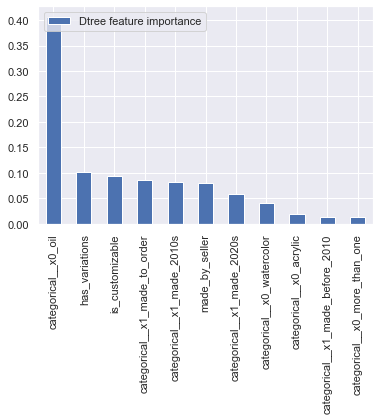

In [133]:
categorical_dtree_features_imp_df.plot(kind="bar").legend(loc="upper left");

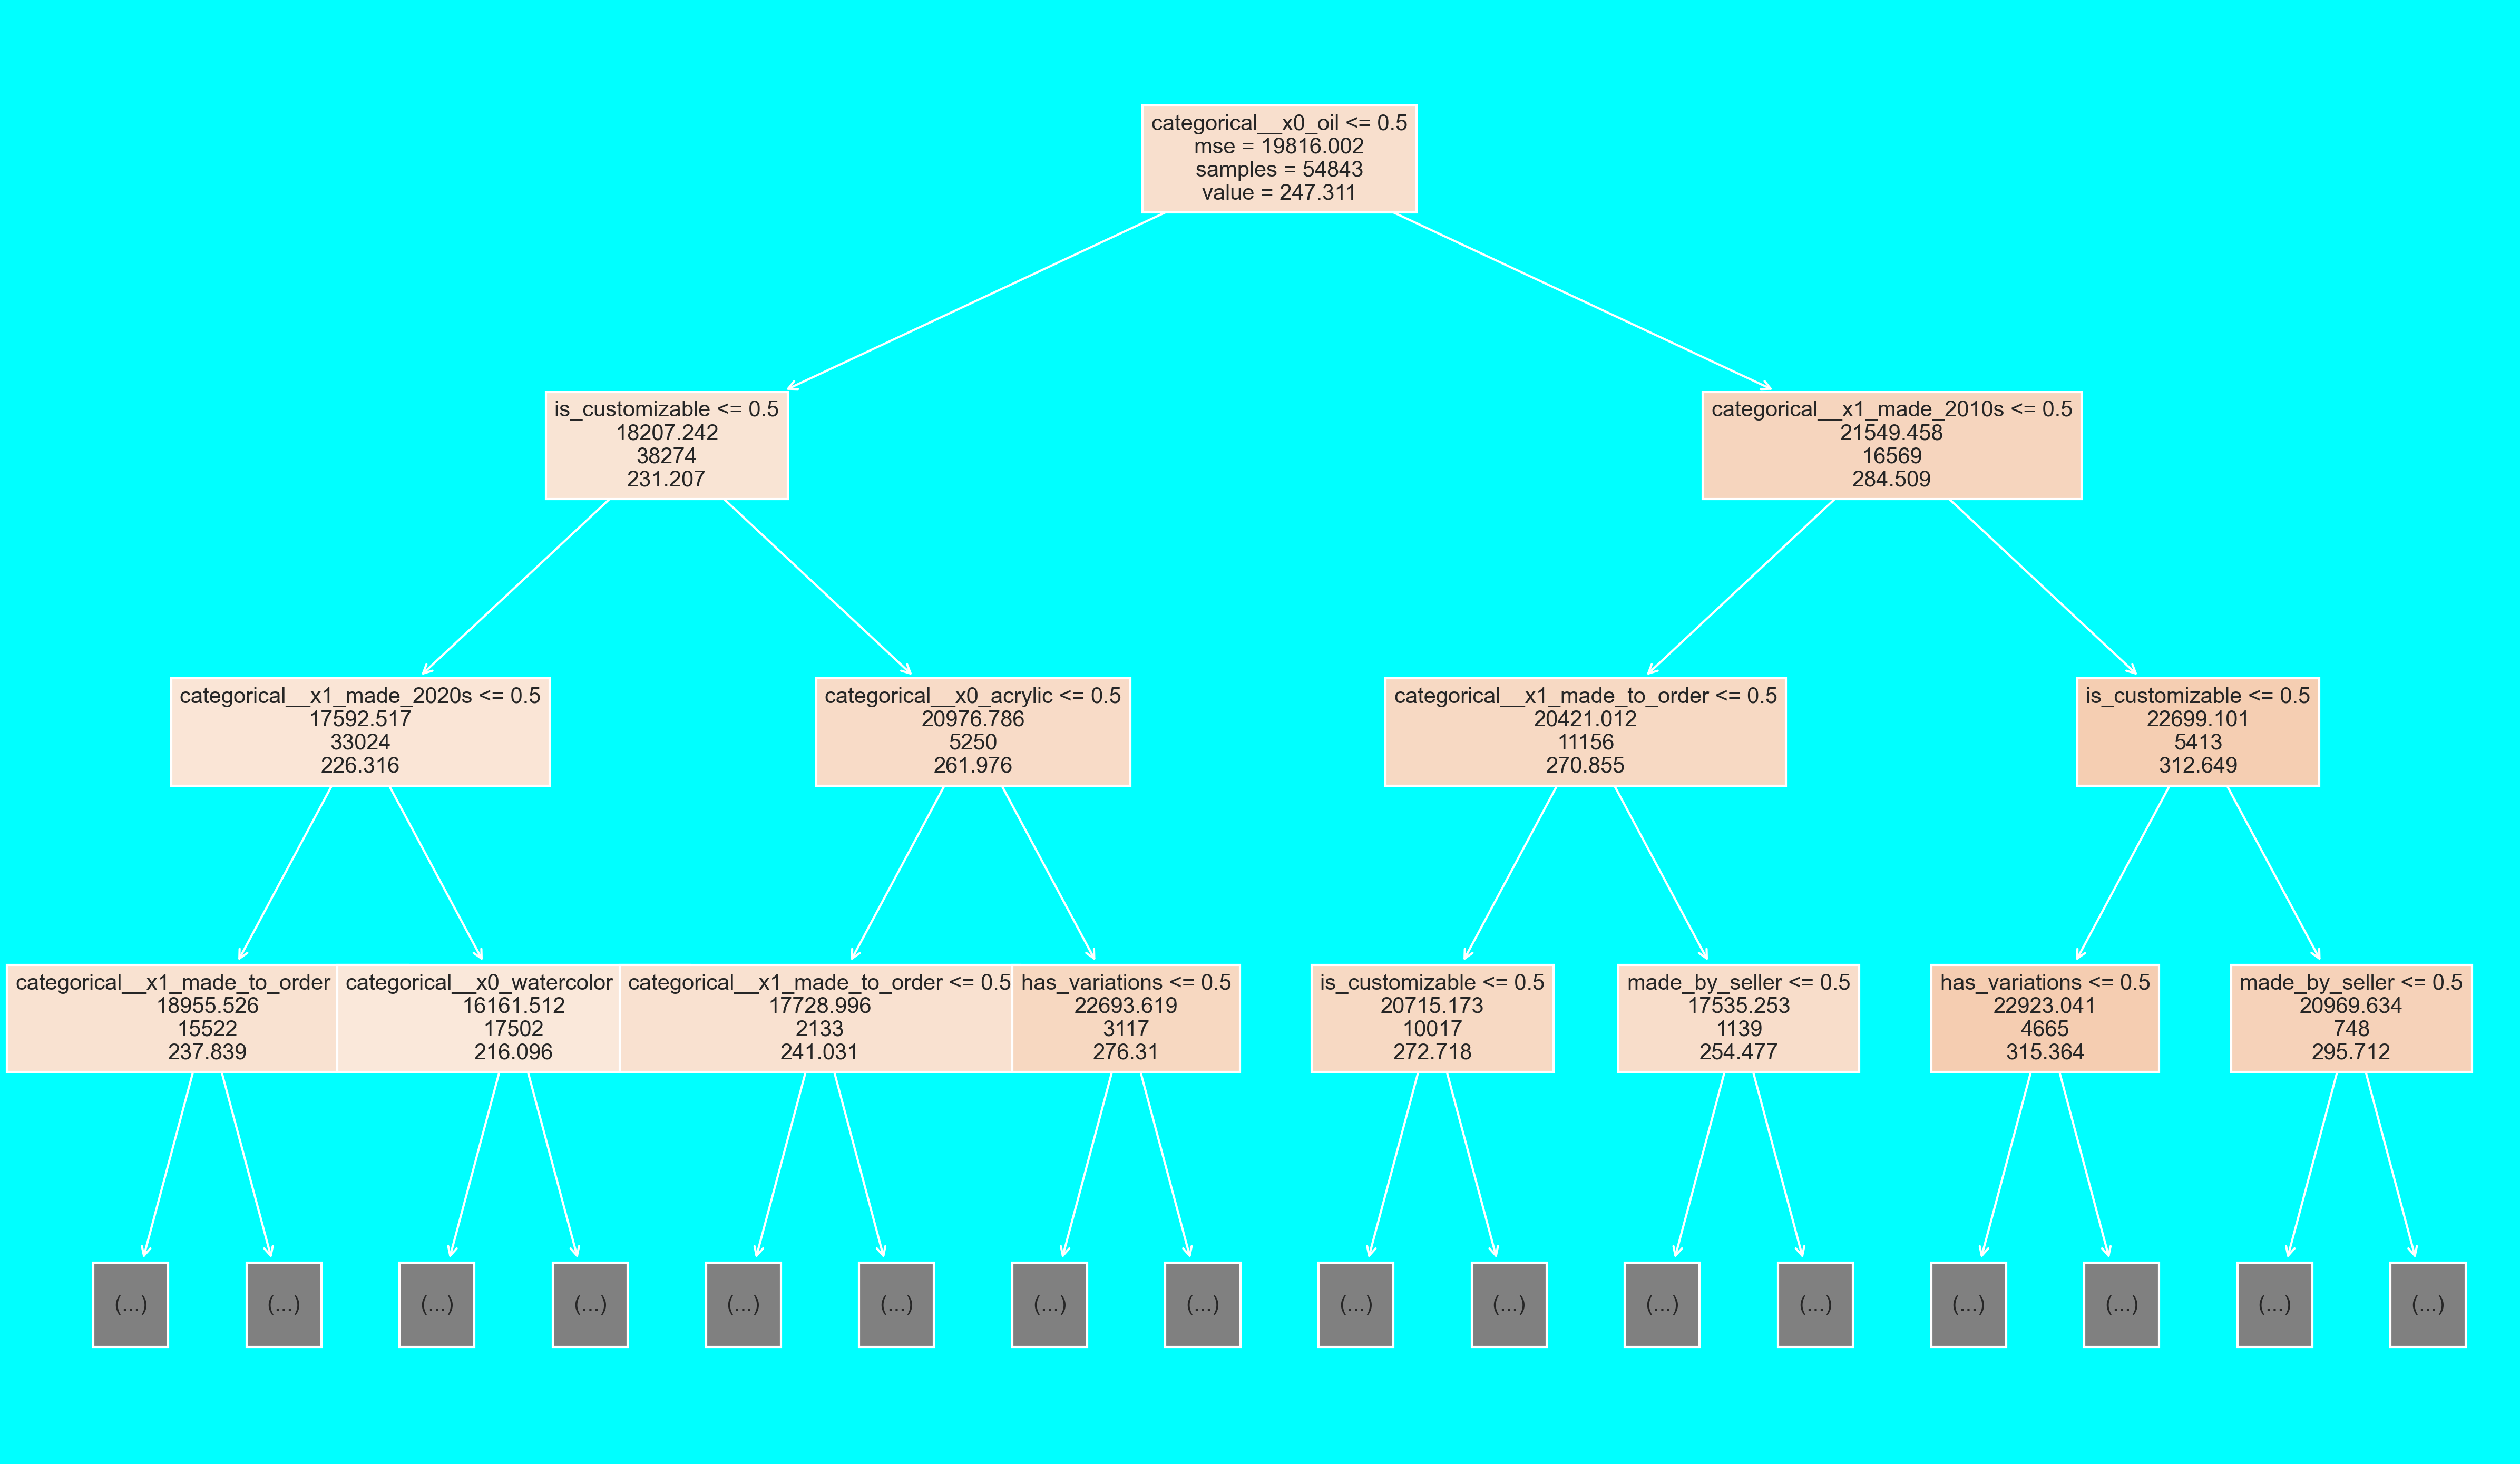

In [134]:
fig = plt.figure(figsize=(20,12), dpi=300)
fig.set_facecolor("cyan")
tree_viz = plot_tree(categorical_dtree_CVmodel.best_estimator_['dtree'],max_depth=3,fontsize=10,label='root',filled=True,feature_names = feature_names_cat_dtree)
fig.savefig('./Git_exclude/Figures/decision_tree_categorical_only.png')

#### Model 2d) Random Forest using only categorical features

In [135]:
from sklearn.ensemble import RandomForestRegressor

In [136]:
categorical_rforest_pipe = Pipeline([
    ('categorical selector', categorical_selector_no_drop),
    ('rforest', RandomForestRegressor(n_estimators=50,max_features='sqrt',n_jobs=2,max_depth=categorical_dtree_CVmodel.best_params_['dtree__max_depth']+1,random_state=1,max_samples=0.8))
])

In [137]:
categorical_rforest_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('categorical selector',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  ['painting_type',
                                                   'when_made']),
                                                 ('boolean', 'passthrough',
                                                  ['made_by_seller',
                                                   'is_customizable',
                                                   'has_variations'])])),
                ('rforest',
                 RandomForestRegressor(max_depth=11, max_features='sqrt',
                                       max_samples=0.8, n_estimators=50,
                                       n_jobs=2, random_state=1))])

In [138]:
#Predict prices on training set:
prices_train_pred = categorical_rforest_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
categorical_rforest_pipe.score(paintings_df_train,prices_train)

0.07430455530800328

In [139]:
#Predict prices on test set:
prices_test_pred = categorical_rforest_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
categorical_rforest_pipe.score(paintings_df_test,prices_test)

0.0732765363122363

In [140]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using only categorical features')


Random Forest model using only categorical features:
Training R^2: 0.07430455530800328
Testing R^2: 0.0732765363122363
Training RMSE: USD 135.43848501145823
Testing RMSE: USD 136.8380086510923
Training MAE: USD 108.604095185127
Testing MAE: USD 109.84233365071704


In [141]:
#what are the main features used for decision?
categorical_rforest_pipe['rforest'].feature_importances_

array([0.08034901, 0.0266024 , 0.29557314, 0.0943969 , 0.08187769,
       0.06236298, 0.04108045, 0.03144157, 0.07079037, 0.1274172 ,
       0.08810828])

In [142]:
feature_names_cat_rforest = categorical_rforest_pipe['categorical selector'].get_feature_names()

categorical_rforest_features_imp_df = pd.DataFrame(categorical_rforest_pipe['rforest'].feature_importances_,feature_names_cat_rforest,columns=['Rforest feature importance'])
categorical_rforest_features_imp_df = categorical_rforest_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
categorical_rforest_features_imp_df

Rforest feature importance
categorical__x0_oil                                 0.295573
is_customizable                                     0.127417
categorical__x0_watercolor                          0.094397
has_variations                                      0.088108
categorical__x1_made_2010s                          0.081878
categorical__x0_acrylic                             0.080349
made_by_seller                                      0.070790
categorical__x1_made_2020s                          0.062363
categorical__x1_made_before_2010                    0.041080
categorical__x1_made_to_order                       0.031442
categorical__x0_more_than_one                       0.026602

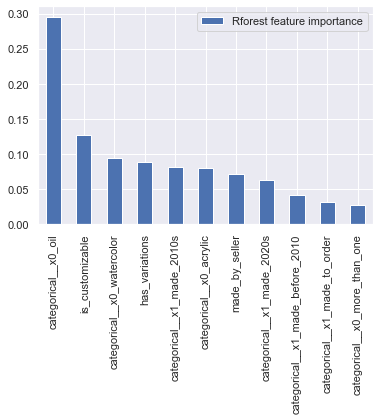

In [143]:
categorical_rforest_features_imp_df.plot(kind="bar").legend(loc="upper right");

#### Model 2e) Gradient Boosting Trees using only numerical features¶

In [144]:
from sklearn.ensemble import GradientBoostingRegressor

In [145]:
categorical_gboost_pipe = Pipeline([
    ('categorical selector', categorical_selector),
    ('gboost', GradientBoostingRegressor(n_estimators=50,learning_rate=0.1,subsample=0.5,max_depth=categorical_dtree_CVmodel.best_params_['dtree__max_depth']-1,random_state=1))
])

In [146]:
categorical_gboost_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('categorical selector',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(drop='first'),
                                                  ['painting_type',
                                                   'when_made']),
                                                 ('boolean', 'passthrough',
                                                  ['made_by_seller',
                                                   'is_customizable',
                                                   'has_variations'])])),
                ('gboost',
                 GradientBoostingRegressor(max_depth=9, n_estimators=50,
                                           random_state=1, subsample=0.5))])

In [147]:
#Predict prices on training set:
prices_train_pred = categorical_gboost_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
categorical_gboost_pipe.score(paintings_df_train,prices_train)

0.07431712201166141

In [148]:
#Predict prices on test set:
prices_test_pred = categorical_gboost_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
categorical_gboost_pipe.score(paintings_df_test,prices_test)

0.07234503062630193

In [149]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosting model using only categorical features')


Gradient Boosting model using only categorical features:
Training R^2: 0.07431712201166141
Testing R^2: 0.07234503062630193
Training RMSE: USD 135.4375656912373
Testing RMSE: USD 136.906763448723
Training MAE: USD 108.61427088659372
Testing MAE: USD 109.87278196736645


In [150]:
#what are the main features used for decision?
categorical_gboost_pipe['gboost'].feature_importances_

array([0.05065389, 0.34005807, 0.07009816, 0.08083802, 0.06354204,
       0.09073155, 0.08526776, 0.10709872, 0.11171179])

In [151]:
feature_names_cat_gboost = categorical_gboost_pipe['categorical selector'].get_feature_names()

categorical_gboost_features_imp_df = pd.DataFrame(categorical_gboost_pipe['gboost'].feature_importances_,feature_names_cat_gboost,columns=['Gboost feature importance'])
categorical_gboost_features_imp_df = categorical_gboost_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
categorical_gboost_features_imp_df

Gboost feature importance
categorical__x0_oil                                0.340058
has_variations                                     0.111712
is_customizable                                    0.107099
categorical__x1_made_to_order                      0.090732
made_by_seller                                     0.085268
categorical__x1_made_2020s                         0.080838
categorical__x0_watercolor                         0.070098
categorical__x1_made_before_2010                   0.063542
categorical__x0_more_than_one                      0.050654

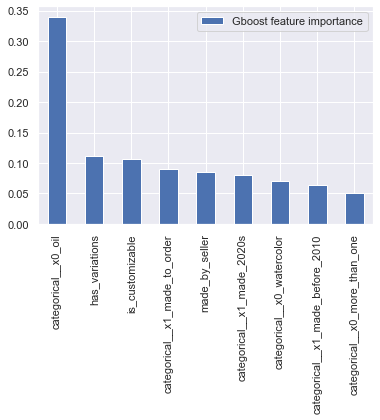

In [152]:
categorical_gboost_features_imp_df.plot(kind="bar").legend(loc="upper right");

## 3) Models combining numerical and categorical features, but still no tags or image info

#### 3a) Linear regression combining numerical and categorical features

In [153]:
#Note that for numerical features, in this case I use MinMaxScaling instead of StandardScaling, 
#so that all the features are within the same [0,1] range (note that the categorical ones are already in [0,1] by construction)
#Also recall that for Linear Regression I need to drop the first hot-encoded value or I will have multicollinearity problems

variable_selector = ColumnTransformer([
    ('categorical', OneHotEncoder(drop='first'), categorical_columns),
    ('boolean','passthrough', boolean_columns),
    ('numerical',MinMaxScaler(),numerical_columns)
 ], remainder='drop')



In [154]:
#and then apply LinearRegression within a pipeline
from sklearn.pipeline import Pipeline

num_plus_cat_linreg_pipe = Pipeline([
    ('variable selector', variable_selector),
    ('linear reg', LinearRegression()),
])

In [155]:
#Train the model
num_plus_cat_linreg_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('variable selector',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(drop='first'),
                                                  ['painting_type',
                                                   'when_made']),
                                                 ('boolean', 'passthrough',
                                                  ['made_by_seller',
                                                   'is_customizable',
                                                   'has_variations']),
                                                 ('numerical', MinMaxScaler(),
                                                  ['num_favorers',
                                                   'featured_rank',
                                                   'max_dimension',
                                                   'aspect_ratio', 'area',
                                                   'weight',
                                                   'days_from_original_creation'])])),
                ('linear reg', LinearRegression())])

In [156]:
#Predict prices on training set:
prices_train_pred = num_plus_cat_linreg_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
num_plus_cat_linreg_pipe.score(paintings_df_train,prices_train)

0.19270701990826378

In [157]:
#Predict prices on test set:
prices_test_pred = num_plus_cat_linreg_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
num_plus_cat_linreg_pipe.score(paintings_df_test,prices_test)

0.2039834223502186

In [158]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Linear regression model using numerical features and categorical features with One-hot-encoding')


Linear regression model using numerical features and categorical features with One-hot-encoding:
Training R^2: 0.19270701990826378
Testing R^2: 0.2039834223502186
Training RMSE: USD 126.48051111041187
Testing RMSE: USD 126.82145226334316
Training MAE: USD 98.93718732974651
Testing MAE: USD 98.94717940499362


In [159]:
#Let's look at the coefficients of the model
# intercept
print(num_plus_cat_linreg_pipe['linear reg'].intercept_)

101.51747867562744


In [160]:
num_plus_cat_linreg_pipe['linear reg'].coef_

array([  11.32588454,   55.98022471,   15.60750729,  -21.33244537,
         -9.49211287,  -34.31279077,   36.99805127,   18.48168585,
        -15.61552789, -119.66086549,  171.63362252,  225.12523301,
        199.29187889,  338.37704218, 1839.66901784,    2.27086505])

In [161]:
#coefficients for each variable:
coeff_df = pd.DataFrame(num_plus_cat_linreg_pipe['linear reg'].coef_,columns=['Lin Reg Coeff']) #categorical_feature_names,columns=['Lin Reg Coeff'])
coeff_df

Lin Reg Coeff
0       11.325885
1       55.980225
2       15.607507
3      -21.332445
4       -9.492113
5      -34.312791
6       36.998051
7       18.481686
8      -15.615528
9     -119.660865
10     171.633623
11     225.125233
12     199.291879
13     338.377042
14    1839.669018
15       2.270865

#### 3b) Ridge regression combining numerical and categorical features with polynomial features

In [162]:
#For Ridge Regression, I don't really need to 'drop-first' categorical variables when doing OneHotEncoding, because the ridge term already prevents the problem from being ill-posed  
#Note that for numerical features, in this case I use MinMaxScaling instead of StandardScaling, 
#so that all the features are within the same [0,1] range (note that the categorical ones are already in [0,1] by construction)
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

variable_selector_for_ridge = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns),
    ('boolean','passthrough', boolean_columns),
    ('numerical',MinMaxScaler(),numerical_columns)
 ], remainder='drop')

In [163]:
from sklearn.linear_model import Ridge

num_plus_cat_polyreg_ridge_pipe = Pipeline([('num and cat preproc', variable_selector_for_ridge),
                      ('polynomial_trans', PolynomialFeatures(degree=3,include_bias=False)),            
                      ('ridge', Ridge(alpha=10))])

In [164]:
from sklearn.model_selection import GridSearchCV

param_grid = {'ridge__alpha': np.logspace(0,8,20)} 
num_plus_cat_polyreg_ridge_CVmodel = GridSearchCV(num_plus_cat_polyreg_ridge_pipe, param_grid, cv=5, n_jobs=1, verbose=1)

In [165]:
#Train the model - this takes a bit of time, so I will save the model with joblib after fitting the model the first time, 
#then I will load it from memory the following times
from joblib import dump, load

num_plus_cat_polyreg_ridge_CVmodel_filename = './Git_exclude/models/num_plus_cat_polyreg_ridge_CVmodel.joblib'

#If the model file already exists, I load it:
try:
    with open(num_plus_cat_polyreg_ridge_CVmodel_filename, 'rb') as f:
        num_plus_cat_polyreg_ridge_CVmodel = load(f)
        print('Loaded joblib file with numerical-plus-categorical features, ridge regression with polynomial features.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    num_plus_cat_polyreg_ridge_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(num_plus_cat_polyreg_ridge_CVmodel_filename, 'wb') as f:
        dump(num_plus_cat_polyreg_ridge_CVmodel, num_plus_cat_polyreg_ridge_CVmodel_filename) 
        print('Saved joblib file with numerical-plus-categorical features, ridge regression with polynomial features.')


Loaded joblib file with numerical-plus-categorical features, ridge regression with polynomial features.


In [166]:
#Predict prices on training set:
prices_train_pred = num_plus_cat_polyreg_ridge_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
num_plus_cat_polyreg_ridge_CVmodel.score(paintings_df_train,prices_train)

0.21789351845992988

In [167]:
#Predict prices on test set:
prices_test_pred = num_plus_cat_polyreg_ridge_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
num_plus_cat_polyreg_ridge_CVmodel.score(paintings_df_test,prices_test)

0.22648503489073502

In [168]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression using numerical and categorical features with polynomial features')


Ridge regression using numerical and categorical features with polynomial features:
Training R^2: 0.21789351845992988
Testing R^2: 0.22648503489073502
Training RMSE: USD 124.49186308004023
Testing RMSE: USD 125.01612290391965
Training MAE: USD 97.67231594600763
Testing MAE: USD 97.67033041382905


### Model 3c) Decision Tree model combining numerical and categorical features

In [169]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
import pydot

In [170]:
#I don't want to drop the first variable for tree-based models (whereas I needed to do those for linear-regression to prevent collinearity)
#and I don't need to scale the numerical variables

variable_selector_for_trees = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns),
    ('boolean','passthrough', boolean_columns),
    ('numerical','passthrough',numerical_columns)
 ], remainder='drop')

In [171]:
num_plus_cat_dtree_pipe = Pipeline([
    ('num and cat selector', variable_selector_for_trees),
    ('dtree', DecisionTreeRegressor(max_depth=3)),
])

In [172]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,12,1)} #np.linspace(0,10,1)} 
num_plus_cat_dtree_CVmodel = GridSearchCV(num_plus_cat_dtree_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [173]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

num_plus_cat_dtree_CVmodel_filename = './Git_exclude/models/num_plus_cat_dtree_CVmodel.joblib'

#If the model file already exists, I load it:
try:
    with open(num_plus_cat_dtree_CVmodel_filename, 'rb') as f:
        num_plus_cat_dtree_CVmodel = load(f)
        print('Loaded joblib file with decision tree model for numerical-plus-categorical features.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    num_plus_cat_dtree_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(num_plus_cat_dtree_CVmodel_filename, 'wb') as f:
        dump(num_plus_cat_dtree_CVmodel, num_plus_cat_dtree_CVmodel_filename) 
        print('Saved joblib file with decision tree model for numerical-plus-categorical features.')

Loaded joblib file with decision tree model for numerical-plus-categorical features.


In [174]:
num_plus_cat_dtree_CVmodel.best_params_

{'dtree__max_depth': 9}

In [175]:
num_plus_cat_dtree_CVmodel

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('num and cat selector',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         OneHotEncoder(),
                                                                         ['painting_type',
                                                                          'when_made']),
                                                                        ('boolean',
                                                                         'passthrough',
                                                                         ['made_by_seller',
                                                                          'is_customizable',
                                                                          'has_variations']),
                                                                        ('numerical',
                                                                         'passthrough',
                                                                         ['num_favorers',
                                                                          'featured_rank',
                                                                          'max_dimension',
                                                                          'aspect_ratio',
                                                                          'area',
                                                                          'weight',
                                                                          'days_from_original_creation'])])),
                                       ('dtree',
                                        DecisionTreeRegressor(max_depth=3))]),
             n_jobs=2, param_grid={'dtree__max_depth': range(2, 12)},
             verbose=1)

In [176]:
#Predict prices on training set:
prices_train_pred = num_plus_cat_dtree_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
num_plus_cat_dtree_CVmodel.score(paintings_df_train,prices_train)

0.34302576472085833

In [177]:
#Predict prices on test set:
prices_test_pred = num_plus_cat_dtree_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
num_plus_cat_dtree_CVmodel.score(paintings_df_test,prices_test)

0.2922137342324921

In [178]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using numerical + categorical features')


Decision Tree model using numerical + categorical features:
Training R^2: 0.34302576472085833
Testing R^2: 0.2922137342324921
Training RMSE: USD 114.09909321135792
Testing RMSE: USD 119.58665864157923
Training MAE: USD 86.00995862307553
Testing MAE: USD 89.69817181157185


In [179]:
#what are the main features used for decision?
num_plus_cat_dtree_CVmodel.best_estimator_['dtree'].feature_importances_

array([0.00052135, 0.00964248, 0.08998735, 0.00591439, 0.02759729,
       0.0057608 , 0.01261929, 0.0151574 , 0.02520906, 0.00858048,
       0.02058589, 0.01109103, 0.01338897, 0.3627688 , 0.04941362,
       0.16806524, 0.12434695, 0.04934962])

In [180]:
feature_names_num_plus_cat_dtree = num_plus_cat_dtree_CVmodel.best_estimator_['num and cat selector'].get_feature_names()

num_plus_cat_dtree_features_imp_df = pd.DataFrame(num_plus_cat_dtree_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_num_plus_cat_dtree,columns=['Dtree feature importance'])
num_plus_cat_dtree_features_imp_df = num_plus_cat_dtree_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
num_plus_cat_dtree_features_imp_df

Dtree feature importance
max_dimension                                     0.362769
area                                              0.168065
weight                                            0.124347
categorical__x0_oil                               0.089987
aspect_ratio                                      0.049414
days_from_original_creation                       0.049350
categorical__x1_made_2010s                        0.027597
made_by_seller                                    0.025209
has_variations                                    0.020586
categorical__x1_made_to_order                     0.015157
featured_rank                                     0.013389
categorical__x1_made_before_2010                  0.012619
num_favorers                                      0.011091
categorical__x0_more_than_one                     0.009642
is_customizable                                   0.008580
categorical__x0_watercolor                        0.005914
categorical__x1_made_2020s                        0.005761
categorical__x0_acrylic                           0.000521

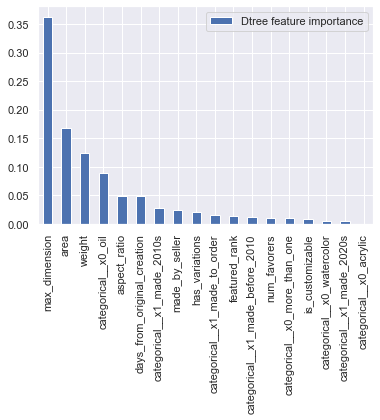

In [181]:
num_plus_cat_dtree_features_imp_df.plot(kind="bar").legend(loc="upper right");

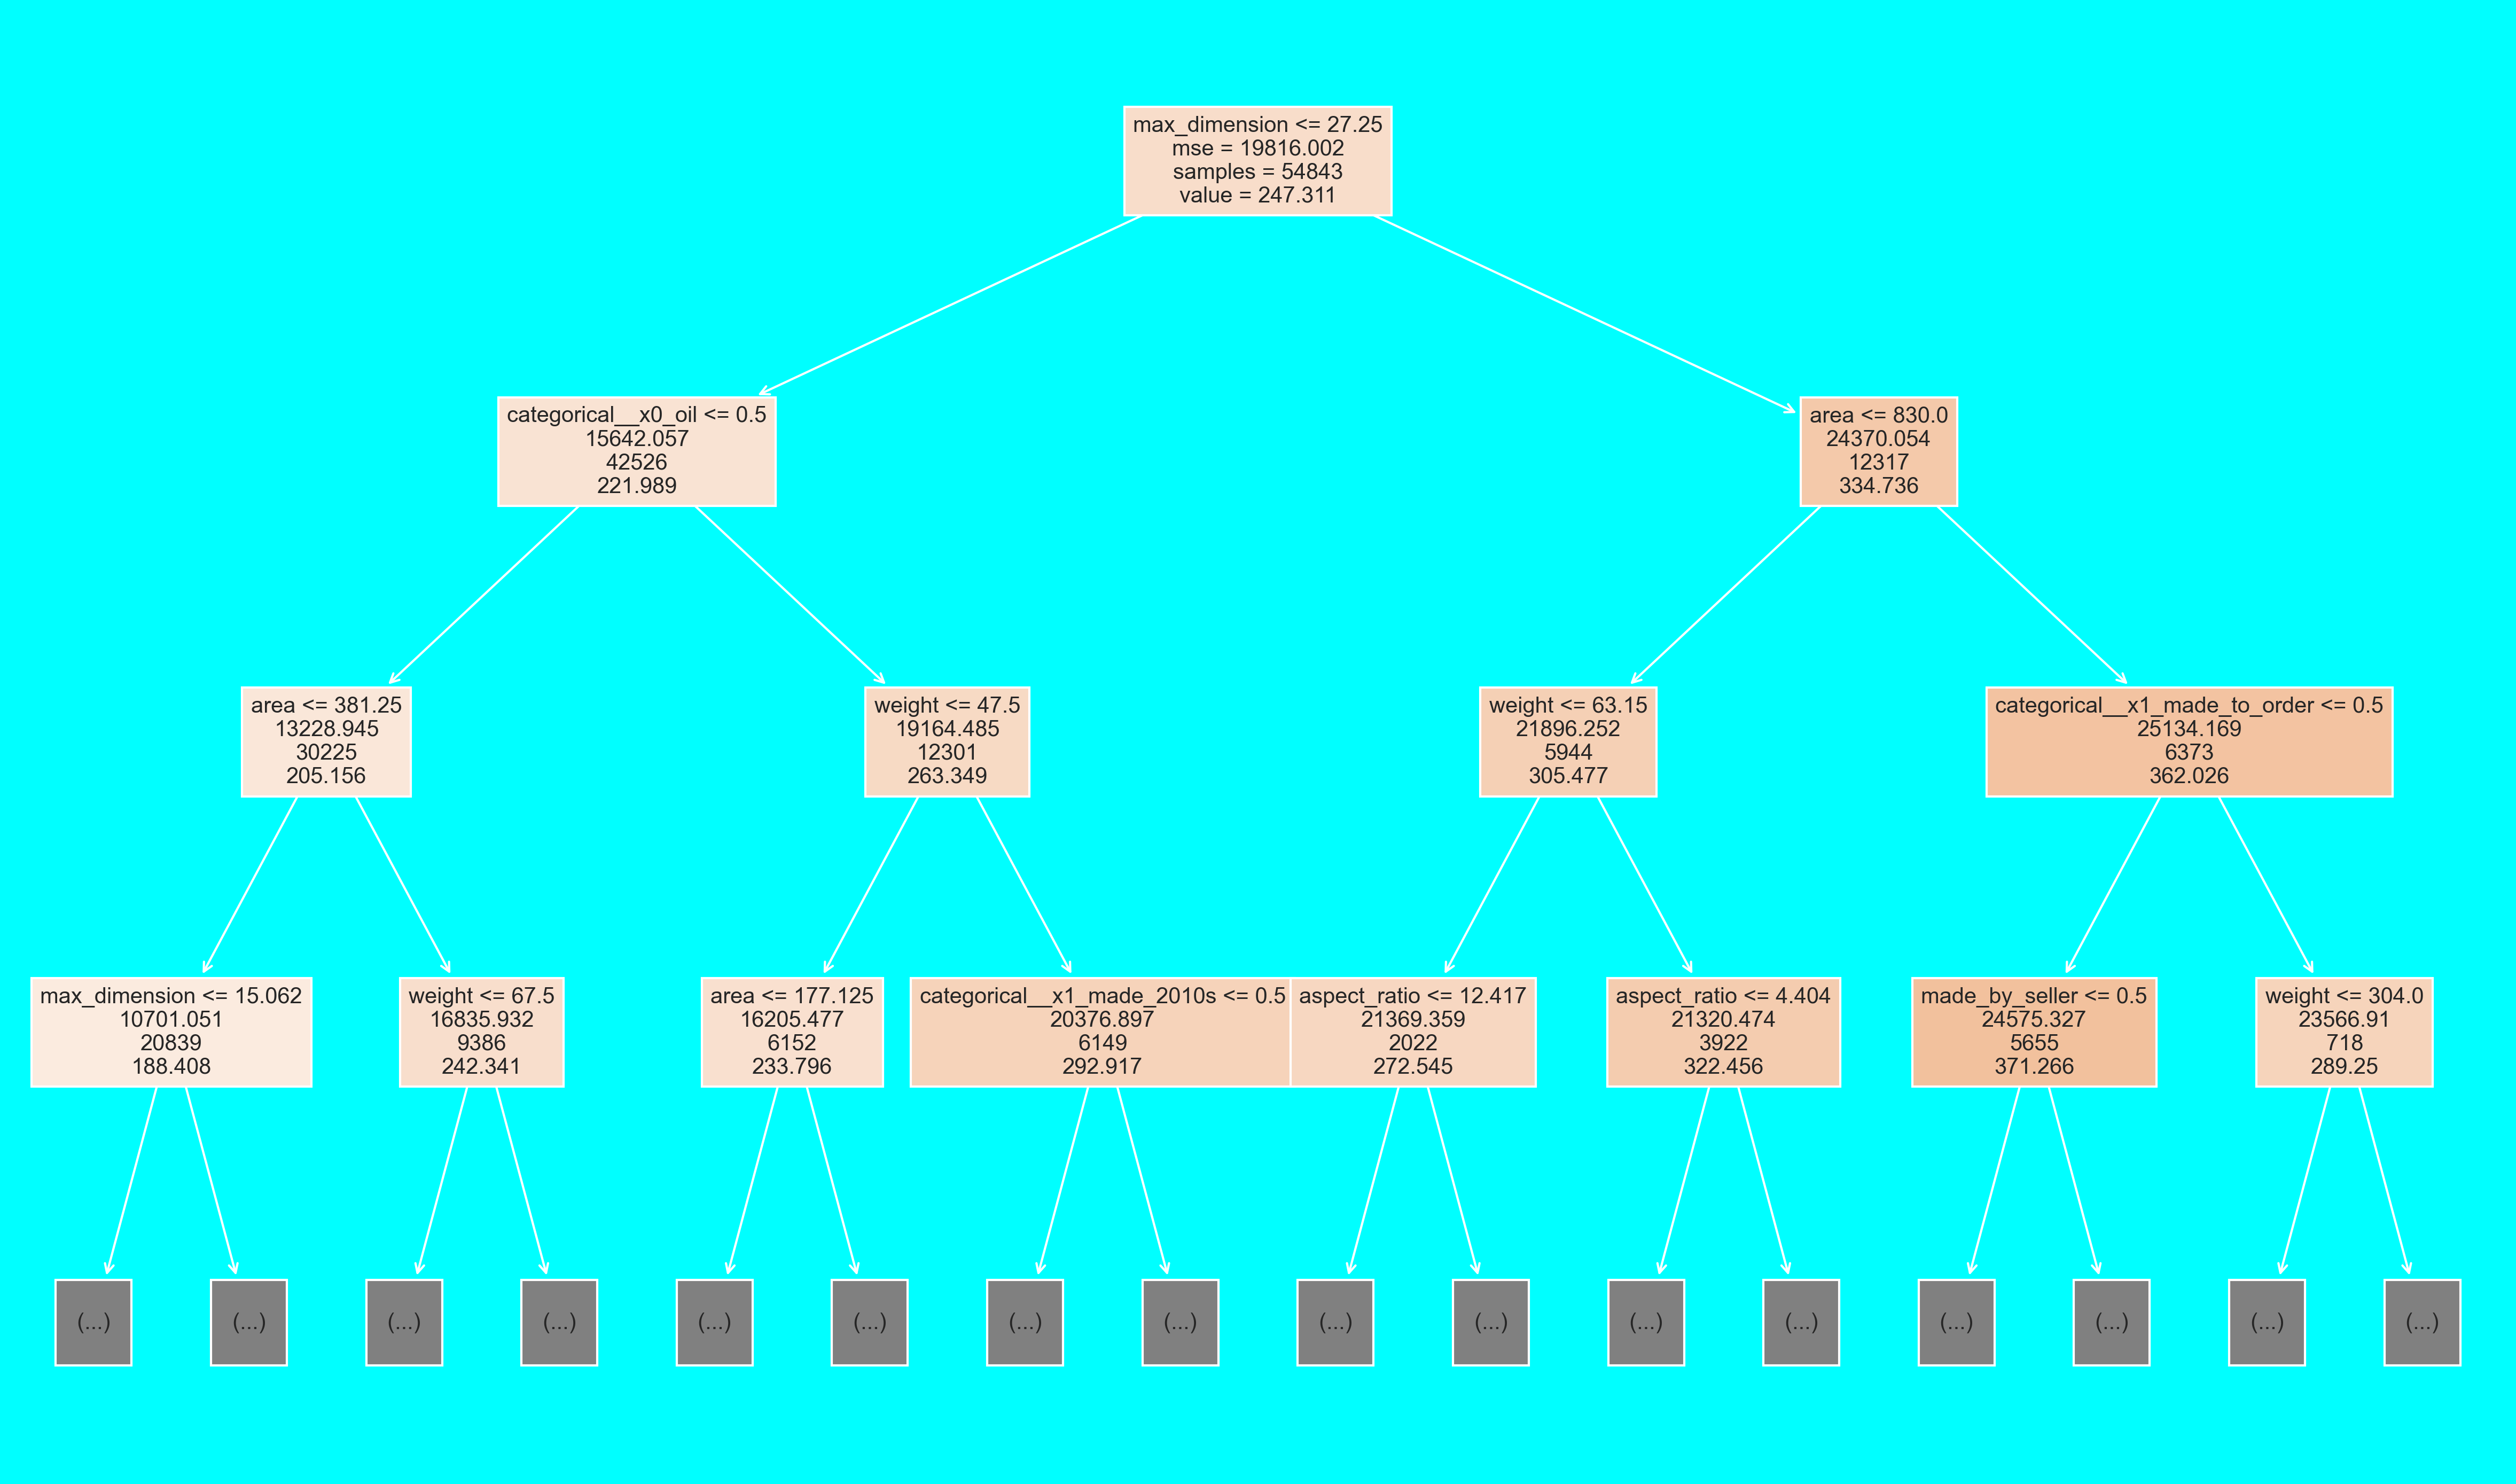

In [182]:
# Generate a plot of the decision tree
fig = plt.figure(figsize=(20,12), dpi=300)
fig.set_facecolor("cyan")
tree_viz = plot_tree(num_plus_cat_dtree_CVmodel.best_estimator_['dtree'],max_depth=3,fontsize=10,label='root',filled=True,feature_names = feature_names_num_plus_cat_dtree)
fig.savefig('./Git_exclude/Figures/decision_tree_numerical_plus_categorical.png')

#### Model 3d) Random Forest combining numerical and categorical features

In [183]:
from sklearn.ensemble import RandomForestRegressor

In [184]:
num_plus_cat_rforest_pipe = Pipeline([
    ('num and cat selector', variable_selector_for_trees),
    ('rforest', RandomForestRegressor(n_estimators=50,max_features='sqrt',n_jobs=2,max_depth=num_plus_cat_dtree_CVmodel.best_params_['dtree__max_depth']+1,random_state=1,max_samples=0.8))
])

In [185]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

num_plus_cat_rforest_pipe_filename = './Git_exclude/models/num_plus_cat_rforest_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(num_plus_cat_rforest_pipe_filename, 'rb') as f:
        num_plus_cat_rforest_pipe = load(f)
        print('Loaded joblib file with random forest model for numerical-plus-categorical features.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    num_plus_cat_rforest_pipe.fit(paintings_df_train,prices_train);
    
    with open(num_plus_cat_rforest_pipe_filename, 'wb') as f:
        dump(num_plus_cat_rforest_pipe, num_plus_cat_rforest_pipe_filename) 
        print('Saved joblib file with random forest model for numerical-plus-categorical features.')

Loaded joblib file with random forest model for numerical-plus-categorical features.


In [186]:
num_plus_cat_rforest_pipe

Pipeline(steps=[('num and cat selector',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  ['painting_type',
                                                   'when_made']),
                                                 ('boolean', 'passthrough',
                                                  ['made_by_seller',
                                                   'is_customizable',
                                                   'has_variations']),
                                                 ('numerical', 'passthrough',
                                                  ['num_favorers',
                                                   'featured_rank',
                                                   'max_dimension',
                                                   'aspect_ratio', 'area',
                                                   'weight',
                                                   'days_from_original_creation'])])),
                ('rforest',
                 RandomForestRegressor(max_depth=10, max_features='sqrt',
                                       max_samples=0.8, n_estimators=50,
                                       n_jobs=2, random_state=1))])

In [187]:
#Predict prices on training set:
prices_train_pred = num_plus_cat_rforest_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
num_plus_cat_rforest_pipe.score(paintings_df_train,prices_train)

0.3709040680366239

In [188]:
#Predict prices on test set:
prices_test_pred = num_plus_cat_rforest_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
num_plus_cat_rforest_pipe.score(paintings_df_test,prices_test)

0.3372104990789736

In [189]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using numerical + categorical features')


Random Forest model using numerical + categorical features:
Training R^2: 0.3709040680366239
Testing R^2: 0.3372104990789736
Training RMSE: USD 111.65198853660267
Testing RMSE: USD 115.72294465200645
Training MAE: USD 85.80174049150443
Testing MAE: USD 88.47691232750194


In [190]:
#what are the main features used for decision?
num_plus_cat_rforest_pipe['rforest'].feature_importances_

array([0.02322483, 0.006006  , 0.0552635 , 0.01090825, 0.02128335,
       0.00963668, 0.01403329, 0.01040719, 0.0224414 , 0.01238986,
       0.01409247, 0.02286931, 0.01395844, 0.22189905, 0.0624422 ,
       0.25212602, 0.16664936, 0.0603688 ])

In [191]:
feature_names_num_plus_cat_rforest = num_plus_cat_rforest_pipe['num and cat selector'].get_feature_names()

num_plus_cat_rforest_features_imp_df = pd.DataFrame(num_plus_cat_rforest_pipe['rforest'].feature_importances_,feature_names_num_plus_cat_rforest,columns=['Rforest feature importance'])
num_plus_cat_rforest_features_imp_df = num_plus_cat_rforest_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
num_plus_cat_rforest_features_imp_df

Rforest feature importance
area                                                0.252126
max_dimension                                       0.221899
weight                                              0.166649
aspect_ratio                                        0.062442
days_from_original_creation                         0.060369
categorical__x0_oil                                 0.055264
categorical__x0_acrylic                             0.023225
num_favorers                                        0.022869
made_by_seller                                      0.022441
categorical__x1_made_2010s                          0.021283
has_variations                                      0.014092
categorical__x1_made_before_2010                    0.014033
featured_rank                                       0.013958
is_customizable                                     0.012390
categorical__x0_watercolor                          0.010908
categorical__x1_made_to_order                       0.010407
categorical__x1_made_2020s                          0.009637
categorical__x0_more_than_one                       0.006006

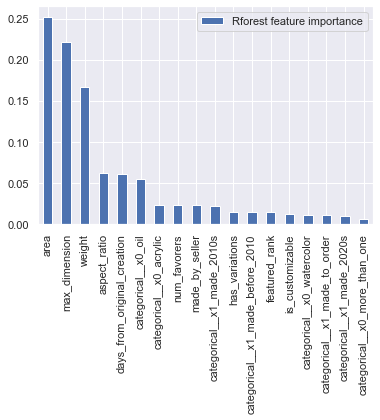

In [192]:
num_plus_cat_rforest_features_imp_df.plot(kind="bar").legend(loc="upper right");

#### Model 3e) Gradient Boosting Trees combining numerical and categorical features

In [193]:
from sklearn.ensemble import GradientBoostingRegressor

In [194]:
num_plus_cat_gboost_pipe = Pipeline([
    ('num and cat selector', variable_selector_for_trees),
    ('gboost', GradientBoostingRegressor(n_estimators=80,learning_rate=0.1,subsample=0.75,max_depth=num_plus_cat_dtree_CVmodel.best_params_['dtree__max_depth']-3,random_state=1))
])

In [195]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

num_plus_cat_gboost_pipe_filename = './Git_exclude/models/num_plus_cat_gboost_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(num_plus_cat_gboost_pipe_filename, 'rb') as f:
        num_plus_cat_gboost_pipe = load(f)
        print('Loaded joblib file with gradient boosting model for numerical-plus-categorical features.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    num_plus_cat_gboost_pipe.fit(paintings_df_train,prices_train);
    
    with open(num_plus_cat_gboost_pipe_filename, 'wb') as f:
        dump(num_plus_cat_gboost_pipe, num_plus_cat_gboost_pipe_filename) 
        print('Saved joblib file with gradient boosting model for numerical-plus-categorical features.')

Loaded joblib file with gradient boosting model for numerical-plus-categorical features.


In [196]:
num_plus_cat_gboost_pipe

Pipeline(steps=[('num and cat selector',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  ['painting_type',
                                                   'when_made']),
                                                 ('boolean', 'passthrough',
                                                  ['made_by_seller',
                                                   'is_customizable',
                                                   'has_variations']),
                                                 ('numerical', 'passthrough',
                                                  ['num_favorers',
                                                   'featured_rank',
                                                   'max_dimension',
                                                   'aspect_ratio', 'area',
                                                   'weight',
                                                   'days_from_original_creation'])])),
                ('gboost',
                 GradientBoostingRegressor(max_depth=6, n_estimators=80,
                                           random_state=1, subsample=0.75))])

In [197]:
#Predict prices on training set:
prices_train_pred = num_plus_cat_gboost_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
num_plus_cat_gboost_pipe.score(paintings_df_train,prices_train)

0.3774862929031434

In [198]:
#Predict prices on test set:
prices_test_pred = num_plus_cat_gboost_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
num_plus_cat_gboost_pipe.score(paintings_df_test,prices_test)

0.33886680898212473

In [199]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosting model using numerical plus categorical features')


Gradient Boosting model using numerical plus categorical features:
Training R^2: 0.3774862929031434
Testing R^2: 0.33886680898212473
Training RMSE: USD 111.06634575756148
Testing RMSE: USD 115.5782584759971
Training MAE: USD 84.51706451365533
Testing MAE: USD 87.68787843325053


In [200]:
#what are the main features used for decision?
num_plus_cat_gboost_pipe['gboost'].feature_importances_

array([0.00939358, 0.00858046, 0.07347291, 0.0067109 , 0.02501656,
       0.00611   , 0.01711144, 0.01141603, 0.02608419, 0.01212064,
       0.0207721 , 0.0192303 , 0.01535114, 0.31388691, 0.05373765,
       0.16501231, 0.13269642, 0.08329647])

In [201]:
feature_names_num_plus_cat_gboost = num_plus_cat_gboost_pipe['num and cat selector'].get_feature_names()

num_plus_cat_gboost_features_imp_df = pd.DataFrame(num_plus_cat_gboost_pipe['gboost'].feature_importances_,feature_names_num_plus_cat_gboost,columns=['Gboost feature importance'])
num_plus_cat_gboost_features_imp_df = num_plus_cat_gboost_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
num_plus_cat_gboost_features_imp_df

Gboost feature importance
max_dimension                                      0.313887
area                                               0.165012
weight                                             0.132696
days_from_original_creation                        0.083296
categorical__x0_oil                                0.073473
aspect_ratio                                       0.053738
made_by_seller                                     0.026084
categorical__x1_made_2010s                         0.025017
has_variations                                     0.020772
num_favorers                                       0.019230
categorical__x1_made_before_2010                   0.017111
featured_rank                                      0.015351
is_customizable                                    0.012121
categorical__x1_made_to_order                      0.011416
categorical__x0_acrylic                            0.009394
categorical__x0_more_than_one                      0.008580
categorical__x0_watercolor                         0.006711
categorical__x1_made_2020s                         0.006110

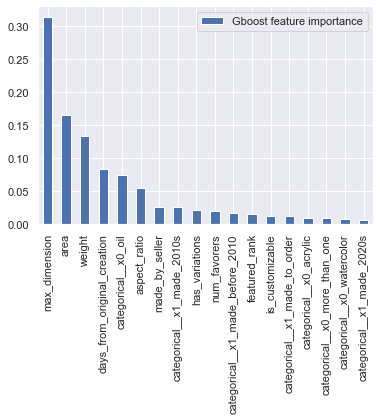

In [202]:
num_plus_cat_gboost_features_imp_df.plot(kind="bar").legend(loc="upper right");

## 4) Models using only the 'style' tags

In [203]:
#Here I can't just use OneHotEncoding, because there can be multiple tags for the same listing, i.e. the 'new_style_tags' for a painting could be a list like: ['abstract','contemporary','modern']

In [204]:
all_paintings_df['style_tags_new'].iloc[1]

"['contemporary', 'expressionism', 'modern', 'abstract']"

In [205]:
all_paintings_df['style_tags_new'].value_counts()

['abstract']                                                        9171
['landscape']                                                       5525
['portrait']                                                        4411
['modern', 'abstract']                                              2492
['beach']                                                           1554
                                                                    ... 
['tribal', 'primitive', 'realism']                                     1
['abstract', 'cовременный']                                            1
['folk', 'southwestern', 'landscape', 'modern', 'expressionism']       1
['century', 'folk', 'abstract', 'mcm']                                 1
['retro', 'avant', 'vintage', 'abstract']                              1
Name: style_tags_new, Length: 5719, dtype: int64

In [206]:
#I can use the 'DictVectorizer' provided by scikit-learn. 
#This transformer takes a 1-D array of dictionaries and creates a column in the output matrix for each key in the dictionary and fills it with the value 
#associated with it. Missing keys are filled with zeros. However, before I can use 'DictVectorizer' I need to convert my list of strings into array of dictionaries.
#I do that with a 'DictEncoder' defined as follows:

In [207]:
def stringlist_to_dict(stringlist):
    dict = {}
    for string in stringlist:
        dict[string]=1
    return dict

In [208]:
from sklearn.base import BaseEstimator, TransformerMixin
class DictEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X will be a pandas series of strings representing lists of strings. Return a pandas series of dictionaries
        return X.apply(eval).apply(stringlist_to_dict)

In [209]:
all_paintings_df['style_tags_new'].apply(eval).apply(stringlist_to_dict)

0        {'contemporary': 1, 'expressionism': 1, 'moder...
1        {'contemporary': 1, 'expressionism': 1, 'moder...
2        {'contemporary': 1, 'modern': 1, 'abstract': 1...
3        {'contemporary': 1, 'abstract': 1, 'whimsical'...
4                     {'modern': 1, 'boho': 1, 'beach': 1}
                               ...                        
68549                                     {'landscape': 1}
68550              {'modern': 1, 'abstract': 1, 'deco': 1}
68551                   {'vintage': 1, 'expressionism': 1}
68552                                 {'impressionism': 1}
68553                                         {'beach': 1}
Name: style_tags_new, Length: 68554, dtype: object

In [210]:
from sklearn.feature_extraction import DictVectorizer

pipe_style_tags_encoding = Pipeline([
    ('to dict series',DictEncoder()),
    ('to binary vectors',DictVectorizer())
])

In [211]:
#now I can run the 'style_tags_new' column through this Encoder-Vectorizer sequence of steps
style_tranform = ColumnTransformer([
    ('style tags vectorizer', pipe_style_tags_encoding, 'style_tags_new'),
], remainder='drop')

In [212]:
#Let's test this in isolation, which will also enable me to extract the name of the style tags in the order in which they'll appear 
#in the regression models
style_tranform.fit_transform(paintings_df_train)

<54843x69 sparse matrix of type '<class 'numpy.float64'>'
	with 106262 stored elements in Compressed Sparse Row format>

In [213]:
style_vectorizer_feature_names = style_tranform.named_transformers_['style tags vectorizer'][-1].feature_names_

In [214]:
style_vectorizer_feature_names

['abstract',
 'african',
 'american',
 'asian',
 'athletic',
 'automobilia',
 'avant',
 'beach',
 'boho',
 'burlesque',
 'century',
 'chic',
 'coastal',
 'contemporary',
 'cottage',
 'country',
 'cовременный',
 'deco',
 'edwardian',
 'expressionism',
 'fantasy',
 'fashion',
 'floral',
 'folk',
 'goth',
 'hippie',
 'hipster',
 'historical',
 'hollywood',
 'impressionism',
 'industrial',
 'kawaii',
 'kitsch',
 'landscape',
 'mcm',
 'mediterranean',
 'military',
 'minimalism',
 'mod',
 'modern',
 'modernism',
 'nautical',
 'neoclassical',
 'nouveau',
 'photorealism',
 'pop',
 'portrait',
 'primitive',
 'realism',
 'regency',
 'renaissance',
 'resort',
 'retro',
 'rocker',
 'rustic',
 'sci',
 'southwestern',
 'spooky',
 'steampunk',
 'traditional',
 'tribal',
 'victorian',
 'vintage',
 'western',
 'whimsical',
 'woodland',
 'zen',
 'неоклассический',
 'традиционный']

### 4a) Ridge regression of style tags only, after vectorization

Since there are a large number of features, one for each possible style tag (there are about 70), cross validation is critical to prevent overfitting.

In [215]:
from sklearn.linear_model import Ridge

stlye_ridge_pipe = Pipeline([
    ('style tags vectorization', style_tranform),
    ('ridge',Ridge(alpha=10))
])

In [216]:
from sklearn.model_selection import GridSearchCV

param_grid = {'ridge__alpha': np.logspace(0,8,20)} 
style_ridge_CVmodel = GridSearchCV(stlye_ridge_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [217]:
#Train the model
style_ridge_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   45.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  1.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('style tags vectorization',
                                        ColumnTransformer(transformers=[('style '
                                                                         'tags '
                                                                         'vectorizer',
                                                                         Pipeline(steps=[('to '
                                                                                          'dict '
                                                                                          'series',
                                                                                          DictEncoder()),
                                                                                         ('to '
                                                                                          'binary '
                                                                                          'vectors',
                                                                                          DictVectorizer())]),
                                                                         'style_tags_new')])),
                                       ('ridge', Ridge(alpha=10))]),
             n_jobs=2,
             param_grid={'ridge__alpha': array([1.00000000e+00, 2.63665090e+00, 6.95192796e+00, 1.83298071e+01,
       4.83293024e+01, 1.27427499e+02, 3.35981829e+02, 8.85866790e+02,
       2.33572147e+03, 6.15848211e+03, 1.62377674e+04, 4.28133240e+04,
       1.12883789e+05, 2.97635144e+05, 7.84759970e+05, 2.06913808e+06,
       5.45559478e+06, 1.43844989e+07, 3.79269019e+07, 1.00000000e+08])},
             verbose=1)

In [218]:
style_ridge_CVmodel.best_params_

{'ridge__alpha': 6.951927961775605}

In [219]:
#Predict prices on training set:
prices_train_pred = style_ridge_CVmodel.predict(paintings_df_train)

In [220]:
#And return the R2 score as follows:
style_ridge_CVmodel.score(paintings_df_train,prices_train)

0.03840533845844207

In [221]:
#Predict prices on test set:
prices_test_pred = style_ridge_CVmodel.predict(paintings_df_test)

In [222]:
#And return the R2 score as follows:
style_ridge_CVmodel.score(paintings_df_test,prices_test)

0.03823654266731391

In [223]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using the vectorized style tags')

Ridge regression model using the vectorized style tags:
Training R^2: 0.03840533845844207
Testing R^2: 0.03823654266731391
Training RMSE: USD 138.03971237330592
Testing RMSE: USD 139.4009719539047
Training MAE: USD 111.7306404966635
Testing MAE: USD 112.98896109379645


In [224]:
#Which are the largest regression coefficients in the regression model?
style_ridge_reg_coeff_df = pd.DataFrame(style_ridge_CVmodel.best_estimator_['ridge'].coef_,columns=['Regression coefficients'])
style_ridge_reg_coeff_df['Feature']=pd.Series(style_vectorizer_feature_names)
style_ridge_reg_coeff_df = style_ridge_reg_coeff_df.sort_values(by='Regression coefficients',ascending=False)
style_ridge_reg_coeff_df.set_index(['Feature'])
#style_ridge_reg_coeff_df


Regression coefficients
Feature                              
neoclassical               151.803671
традиционный               136.345992
rocker                     134.778681
cовременный                121.694613
resort                      85.028791
...                               ...
fashion                    -24.601981
kawaii                     -29.278836
woodland                   -30.503976
spooky                     -33.283555
burlesque                  -52.967305

[69 rows x 1 columns]

In [225]:
#note: the first Russian word means 'traditional', the second means 'modern'

### 4b) Decision tree of style tags only, after vectorization

In [226]:
from sklearn.pipeline import Pipeline

style_dtree_pipe = Pipeline([
    ('style tags vectorization', style_tranform),
    ('dtree', DecisionTreeRegressor(max_depth=15)),
])

In [227]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,51,2)} 
style_dtree_CVmodel = GridSearchCV(style_dtree_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [228]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

style_dtree_CVmodel_filename = './Git_exclude/models/style_dtree_CVmodel.joblib'

#If the model file already exists, I load it:
try:
    with open(style_dtree_CVmodel_filename, 'rb') as f:
        style_dtree_CVmodel = load(f)
        print('Loaded joblib file with decision tree model for style tags (vectorized but without tf-idf.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    style_dtree_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(style_dtree_CVmodel_filename, 'wb') as f:
        dump(style_dtree_CVmodel, style_dtree_CVmodel_filename) 
        print('Saved joblib file with decision tree model for style tags (vectorized but without tf-idf).')



Loaded joblib file with decision tree model for style tags (vectorized but without tf-idf.


In [229]:
style_dtree_CVmodel.best_params_['dtree__max_depth']

12

In [230]:
#Predict prices on training set:
prices_train_pred = style_dtree_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
style_dtree_CVmodel.score(paintings_df_train,prices_train)

0.06959117309629592

In [231]:
#Predict prices on test set:
prices_test_pred = style_dtree_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
style_dtree_CVmodel.score(paintings_df_test,prices_test)

0.052709875208717505

In [232]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using only style tags')


Decision Tree model using only style tags:
Training R^2: 0.06959117309629592
Testing R^2: 0.052709875208717505
Training RMSE: USD 135.78285464581734
Testing RMSE: USD 138.34809099888284
Training MAE: USD 108.71559840646174
Testing MAE: USD 111.00846639688523


In [233]:
feature_names_style_dtree = style_dtree_CVmodel.best_estimator_['style tags vectorization'].named_transformers_['style tags vectorizer']['to binary vectors'].get_feature_names()

style_dtree_features_imp_df = pd.DataFrame(style_dtree_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_style_dtree,columns=['Dtree feature importance'])
style_dtree_features_imp_df = style_dtree_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
style_dtree_features_imp_df.iloc[:20]

Dtree feature importance
modern                         0.130869
impressionism                  0.124544
deco                           0.076376
abstract                       0.063438
contemporary                   0.050842
portrait                       0.040524
pop                            0.039558
expressionism                  0.039545
традиционный                   0.030558
vintage                        0.029623
landscape                      0.027926
fashion                        0.023418
realism                        0.020745
nautical                       0.018064
floral                         0.018032
minimalism                     0.016817
rocker                         0.014685
beach                          0.013346
neoclassical                   0.012907
victorian                      0.012719

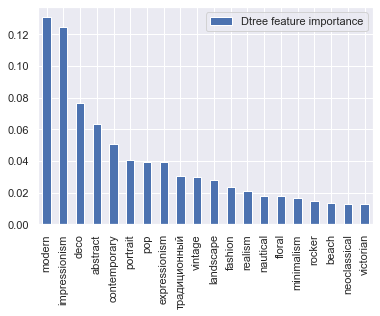

In [234]:
style_dtree_features_imp_df.iloc[:20].plot(kind="bar").legend(loc="upper right");

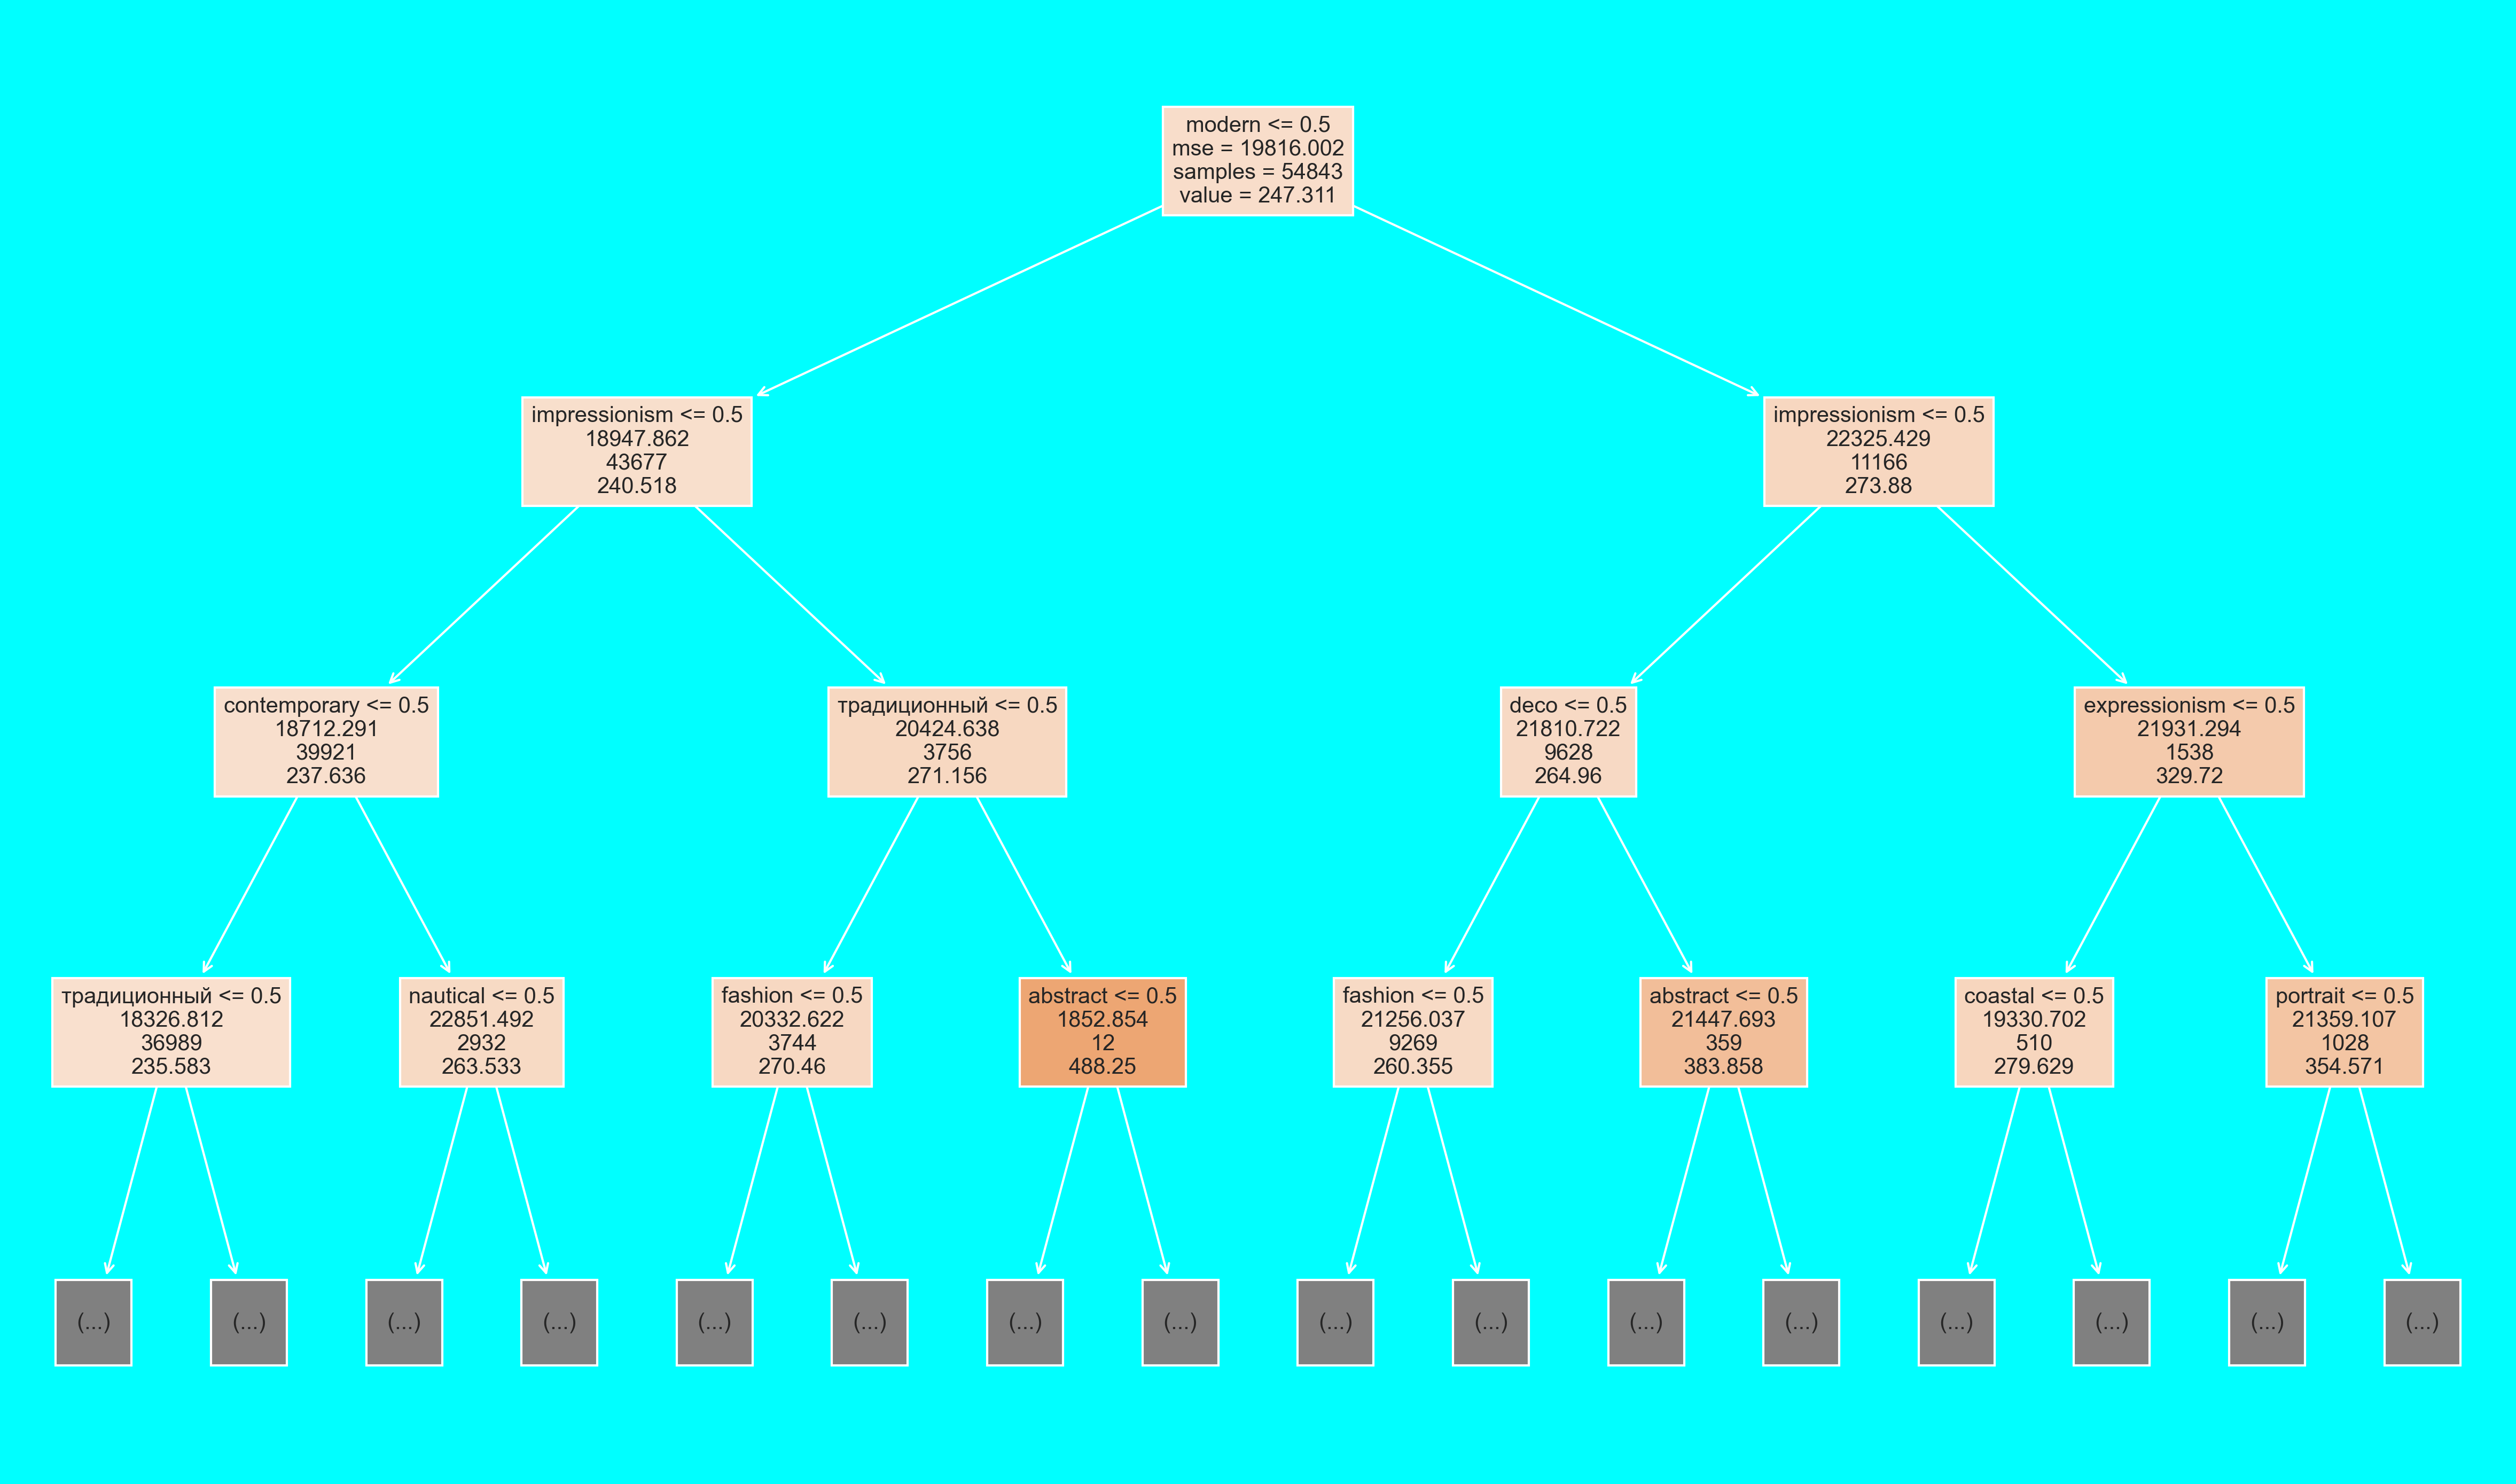

In [235]:
# Generate a plot of the decision tree
fig = plt.figure(figsize=(20,12), dpi=300)
fig.set_facecolor("cyan")
tree_viz = plot_tree(style_dtree_CVmodel.best_estimator_['dtree'],max_depth=3,fontsize=10,label='root',filled=True,feature_names = feature_names_style_dtree)
fig.savefig('./Git_exclude/Figures/decision_tree_style_no_tfidf.png')

### 4c) Ridge regression of style tags only, after Tf-Idf vectorization (up to bigrams) and optional dimensionality reduction

In [236]:
from sklearn.feature_extraction.text import TfidfTransformer #TfidfVectorizer

In [237]:
from sklearn.linear_model import Ridge

stlye_ridge_w_tfidf_pipe = Pipeline([
    ('style tags vectorization', style_tranform),
    ('tfid', TfidfTransformer()), 
    ('ridge',Ridge(alpha=10))
])

In [238]:
from sklearn.model_selection import GridSearchCV

param_grid = {'ridge__alpha': np.logspace(0,8,20)} 
style_ridge_w_tfidf_CVmodel = GridSearchCV(stlye_ridge_w_tfidf_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [239]:
#Train the model
style_ridge_w_tfidf_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   39.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  1.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('style tags vectorization',
                                        ColumnTransformer(transformers=[('style '
                                                                         'tags '
                                                                         'vectorizer',
                                                                         Pipeline(steps=[('to '
                                                                                          'dict '
                                                                                          'series',
                                                                                          DictEncoder()),
                                                                                         ('to '
                                                                                          'binary '
                                                                                          'vectors',
                                                                                          DictVectorizer())]),
                                                                         'style_tags_new')])),
                                       ('tfid', TfidfTransformer()),
                                       ('ridge', Ridge(alpha=10))]),
             n_jobs=2,
             param_grid={'ridge__alpha': array([1.00000000e+00, 2.63665090e+00, 6.95192796e+00, 1.83298071e+01,
       4.83293024e+01, 1.27427499e+02, 3.35981829e+02, 8.85866790e+02,
       2.33572147e+03, 6.15848211e+03, 1.62377674e+04, 4.28133240e+04,
       1.12883789e+05, 2.97635144e+05, 7.84759970e+05, 2.06913808e+06,
       5.45559478e+06, 1.43844989e+07, 3.79269019e+07, 1.00000000e+08])},
             verbose=1)

In [240]:
style_ridge_w_tfidf_CVmodel.best_params_

{'ridge__alpha': 2.636650898730358}

In [241]:
#Predict prices on training set:
prices_train_pred = style_ridge_w_tfidf_CVmodel.predict(paintings_df_train)

In [242]:
#And return the R2 score as follows:
style_ridge_w_tfidf_CVmodel.score(paintings_df_train,prices_train)

0.03761413160582139

In [243]:
#Predict prices on test set:
prices_test_pred = style_ridge_w_tfidf_CVmodel.predict(paintings_df_test)

In [244]:
#And return the R2 score as follows:
style_ridge_w_tfidf_CVmodel.score(paintings_df_test,prices_test)

0.037744164527843904

In [245]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized style tags with Tf-Idf')

Ridge regression model using vectorized style tags with Tf-Idf:
Training R^2: 0.03761413160582139
Testing R^2: 0.037744164527843904
Training RMSE: USD 138.0964907195473
Testing RMSE: USD 139.43665079368142
Training MAE: USD 111.85256147427206
Testing MAE: USD 113.09770394322598


### A different method of implementing Tf-Idf - instead of going through the DictVectorizer - is to use more traditional NLP techniques with TfIdfVectorizer, that enables to also use n-grams (i.e. sequences of words in addition to individual words) 
#### The TfIdfVectorizer takes a single string per document (row), so I need to first process the 'style tags' column as follows (essentially joining the strings in the list)

In [246]:
from sklearn.base import BaseEstimator, TransformerMixin
class TagsEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X will be a pandas series of strings representing lists of strings. Return a pandas series of single strings containing all individual strings joined by a space
        return X.apply(eval).apply(lambda stringlist:' '.join(stringlist))

In [247]:
all_paintings_df['style_tags_new'].iloc[0]

"['contemporary', 'expressionism', 'modern', 'abstract']"

In [248]:
all_paintings_df['style_tags_new'].apply(eval).apply(lambda stringlist:' '.join(stringlist))

0        contemporary expressionism modern abstract
1        contemporary expressionism modern abstract
2              contemporary modern abstract fantasy
3           contemporary abstract whimsical fantasy
4                                 modern boho beach
                            ...                    
68549                                     landscape
68550                          modern abstract deco
68551                         vintage expressionism
68552                                 impressionism
68553                                         beach
Name: style_tags_new, Length: 68554, dtype: object

In [249]:
#A TfIdfVectorizer should then follow, where I can even try to count n-grams of 2 words

In [250]:
from sklearn.feature_extraction.text import TfidfVectorizer

pipe_tags_encoding = Pipeline([
    ('to single string',TagsEncoder()),
    ('to tfidf n-grams',TfidfVectorizer(ngram_range=(1, 2)))
])

In [251]:
#now I can run the 'style_tags_new' column through this Encoder-Vectorizer sequence of steps
style_tags_tranform = ColumnTransformer([
    ('style tags tfidf', pipe_tags_encoding, 'style_tags_new'),
], remainder='drop')

In [252]:
#I first fit_transform the training data by itself to extract the feature names to later
#retrieve them for interpreting the results
style_tags_tranform.fit_transform(paintings_df_train)

<54843x1699 sparse matrix of type '<class 'numpy.float64'>'
	with 157681 stored elements in Compressed Sparse Row format>

In [253]:
style_tags_tranform.named_transformers_['style tags tfidf']['to tfidf n-grams'].get_feature_names()[:10]

['abstract',
 'abstract african',
 'abstract american',
 'abstract asian',
 'abstract automobilia',
 'abstract beach',
 'abstract boho',
 'abstract century',
 'abstract chic',
 'abstract coastal']

In [254]:
#the inverse frequencies can be extracted as follows:
style_tags_tranform.named_transformers_['style tags tfidf']['to tfidf n-grams'].idf_

array([ 1.96307039,  9.71502349,  6.67580611, ...,  9.71502349,
       11.21910089, 10.81363578])

In [255]:
#Now put everything in a pipeline with Ridge Regression

In [256]:
from sklearn.linear_model import Ridge

style_tags_ridge_w_tfidf_pipe = Pipeline([
    ('tags tfidf vectorization', style_tags_tranform),
    ('ridge',Ridge(alpha=10))
])

In [257]:
from sklearn.model_selection import GridSearchCV

#At the beginning I tried:
#param_grid = {'ridge__alpha': np.logspace(-4,8,24)} 
#Then I narrowed down my search to:
param_grid = {'ridge__alpha': np.linspace(1,10,10)} 
style_tags_ridge_w_tfidf_CVmodel = GridSearchCV(style_tags_ridge_w_tfidf_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [258]:
#Train the model
style_tags_ridge_w_tfidf_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   51.8s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   56.7s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tags tfidf vectorization',
                                        ColumnTransformer(transformers=[('style '
                                                                         'tags '
                                                                         'tfidf',
                                                                         Pipeline(steps=[('to '
                                                                                          'single '
                                                                                          'string',
                                                                                          TagsEncoder()),
                                                                                         ('to '
                                                                                          'tfidf '
                                                                                          'n-grams',
                                                                                          TfidfVectorizer(ngram_range=(1,
                                                                                                                       2)))]),
                                                                         'style_tags_new')])),
                                       ('ridge', Ridge(alpha=10))]),
             n_jobs=2,
             param_grid={'ridge__alpha': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             verbose=1)

In [259]:
style_tags_ridge_w_tfidf_CVmodel.best_params_

{'ridge__alpha': 5.0}

In [260]:
#What are the style words or word combos that are weighted the most by the regressor?
feature_names_style_ridge_tfidf = style_tags_ridge_w_tfidf_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['style tags tfidf']['to tfidf n-grams'].get_feature_names()

style_ridge_reg_coeff_df = pd.DataFrame(style_tags_ridge_w_tfidf_CVmodel.best_estimator_['ridge'].coef_,feature_names_style_ridge_tfidf,columns=['Regression coefficients'])
style_ridge_reg_coeff_df = style_ridge_reg_coeff_df.sort_values(by='Regression coefficients',ascending=False)
style_ridge_reg_coeff_df

Regression coefficients
традиционный                          196.117119
african photorealism                  187.186028
abstract resort                       180.504476
minimalism floral                     177.256276
retro rocker                          174.042762
...                                          ...
coastal fashion                       -90.990029
woodland realism                      -94.049577
asian realism                         -94.626657
landscape mediterranean              -103.619955
tribal asian                         -133.803200

[1699 rows x 1 columns]

In [261]:
#Predict prices on training set:
prices_train_pred = style_tags_ridge_w_tfidf_CVmodel.predict(paintings_df_train)

In [262]:
#And return the R2 score as follows:
style_tags_ridge_w_tfidf_CVmodel.score(paintings_df_train,prices_train)

0.07170079885731373

In [263]:
#Predict prices on test set:
prices_test_pred = style_tags_ridge_w_tfidf_CVmodel.predict(paintings_df_test)

In [264]:
#And return the R2 score as follows:
style_tags_ridge_w_tfidf_CVmodel.score(paintings_df_test,prices_test)

0.057331944938033286

In [265]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized tags with Tf-Idf (n-grams up to 2)')

Ridge regression model using vectorized tags with Tf-Idf (n-grams up to 2):
Training R^2: 0.07170079885731373
Testing R^2: 0.057331944938033286
Training RMSE: USD 135.6288290389163
Testing RMSE: USD 138.01016050066994
Training MAE: USD 109.27017732087722
Testing MAE: USD 111.44309514738262


#### Adding optional dimensionality reduction before computing the regressor

In [266]:
from sklearn.decomposition import TruncatedSVD

style_tags_ridge_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', style_tags_tranform),
    ('SVD', TruncatedSVD(n_components=8)),
    ('ridge',Ridge(alpha=10))
])

In [267]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {'ridge__alpha': np.linspace(1,10,4), 'SVD__n_components': range(2,112,4)} 
#style_tags_ridge_w_tfidf_SVD_CVmodel = RandomizedSearchCV(style_tags_ridge_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1, n_iter=20)
style_tags_ridge_w_tfidf_SVD_CVmodel = GridSearchCV(style_tags_ridge_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [268]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

style_tags_SVD_ridge_CVmodel_filename = './Git_exclude/models/style_tags_SVD_ridge_CVmodel.joblib'

#If the model file already exists, I load it:
try:
    with open(style_tags_SVD_ridge_CVmodel_filename, 'rb') as f:
        style_tags_ridge_w_tfidf_SVD_CVmodel = load(f)
        print('Loaded joblib file with ridge regression model for style tags vectorized with tf-idf and reduced with SVD.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    style_tags_ridge_w_tfidf_SVD_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(style_tags_SVD_ridge_CVmodel_filename, 'wb') as f:
        dump(style_tags_ridge_w_tfidf_SVD_CVmodel, style_tags_SVD_ridge_CVmodel_filename) 
        print('Saved joblib file with ridge regression model for style tags vectorized with tf-idf and reduced with SVD.')

Loaded joblib file with ridge regression model for style tags vectorized with tf-idf and reduced with SVD.


In [269]:
style_tags_ridge_w_tfidf_SVD_CVmodel.best_params_

{'SVD__n_components': 110, 'ridge__alpha': 1.0}

In [270]:
#Predict prices on training set:
prices_train_pred = style_tags_ridge_w_tfidf_SVD_CVmodel.predict(paintings_df_train)

In [271]:
#And return the R2 score as follows:
style_tags_ridge_w_tfidf_SVD_CVmodel.score(paintings_df_train,prices_train)

0.04077949643539469

In [272]:
#Predict prices on test set:
prices_test_pred = style_tags_ridge_w_tfidf_SVD_CVmodel.predict(paintings_df_test)

In [273]:
#And return the R2 score as follows:
style_tags_ridge_w_tfidf_SVD_CVmodel.score(paintings_df_test,prices_test)

0.040210989276375564

In [274]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized style tags with Tf-Idf followed by SVD')

Ridge regression model using vectorized style tags with Tf-Idf followed by SVD:
Training R^2: 0.04077949643539469
Testing R^2: 0.040210989276375564
Training RMSE: USD 137.8691984155998
Testing RMSE: USD 139.25780723786576
Training MAE: USD 111.47498850624585
Testing MAE: USD 112.86643357056936


In [275]:
#Let's check what the SVD components, often interpreted as 'topics' are:

In [276]:
style_feature_names = style_tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['style tags tfidf']['to tfidf n-grams'].get_feature_names()

In [277]:
# Get Singular values and Components 
Sigma = style_tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].singular_values_ 
Sigma

array([92.71376264, 72.05133587, 62.30006135, 54.50276513, 41.38687466,
       40.36503422, 40.07906089, 39.10593646, 34.59701362, 29.00301032,
       27.22751847, 26.65796414, 26.5806961 , 24.52625   , 24.39656156,
       22.88138414, 22.15481164, 21.85886934, 21.23629174, 20.8750799 ,
       20.47643269, 20.23180755, 20.18290954, 19.0791865 , 18.80935836,
       18.73777338, 18.36409482, 18.21037627, 17.8273154 , 17.7614509 ,
       16.62908271, 16.46845905, 16.23416497, 16.02066587, 15.87412904,
       15.69770635, 15.32801004, 14.88677022, 14.6363408 , 14.43138939,
       13.92767526, 13.72420078, 13.36869686, 13.13101798, 12.98638365,
       12.53349165, 12.2408835 , 12.09354617, 12.05446305, 11.93038193,
       11.80909588, 11.57793803, 11.54464588, 11.42157226, 11.40918784,
       11.23847356, 11.10949916, 11.04513378, 10.89028228, 10.73434289,
       10.60619371, 10.58252069, 10.5047737 , 10.46417626,  9.94034646,
        9.92615829,  9.80984981,  9.74802628,  9.72800332,  9.68

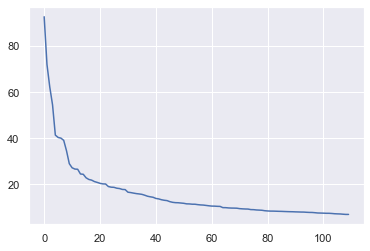

In [278]:
plt.plot(Sigma)

In [279]:
list_of_style_topics = []
list_of_style_topic_num_names = []

for index, component in enumerate(style_tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].components_):
    zipped = zip(style_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_style_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_style_topics.append(topic_style_components)
    list_of_style_topic_num_names.append("Style topic "+str(index))
    print("Topic "+str(index)+": ",topic_style_components) #top_terms_list, top_comp_list)

Topic 0:  ['abstract(0.97)', 'modern(0.15)', 'modern abstract(0.15)']
Topic 1:  ['landscape(0.99)', 'abstract(-0.08)', 'impressionism(0.07)']
Topic 2:  ['portrait(1.0)', 'abstract portrait(0.04)', 'modern(0.03)']
Topic 3:  ['modern(0.73)', 'modern abstract(0.52)', 'contemporary(0.28)']
Topic 4:  ['impressionism(0.54)', 'contemporary(0.51)', 'floral(0.32)']
Topic 5:  ['beach(0.93)', 'contemporary(-0.24)', 'contemporary abstract(-0.14)']
Topic 6:  ['floral(0.78)', 'contemporary(-0.43)', 'contemporary abstract(-0.27)']
Topic 7:  ['impressionism(0.7)', 'floral(-0.5)', 'contemporary(-0.3)']
Topic 8:  ['vintage(0.97)', 'vintage landscape(0.1)', 'vintage portrait(0.09)']
Topic 9:  ['expressionism(0.7)', 'expressionism abstract(0.42)', 'modern abstract(-0.32)']
Topic 10:  ['modern(0.47)', 'modern abstract(-0.47)', 'contemporary modern(-0.43)']
Topic 11:  ['realism(0.94)', 'fantasy(0.27)', 'portrait realism(0.16)']
Topic 12:  ['fantasy(0.95)', 'realism(-0.27)', 'abstract fantasy(0.12)']
Topic 1

In [280]:
#Which are the largest regression coefficients in the regression model?
feature_names_style_ridge_tfidf = style_tags_ridge_w_tfidf_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['style tags tfidf']['to tfidf n-grams'].get_feature_names()

style_ridge_SVD_reg_coeff_df = pd.DataFrame(style_tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['ridge'].coef_,columns=['Regression coefficients'])
style_ridge_SVD_reg_coeff_df['Topic']=pd.Series(list_of_style_topics)
style_ridge_SVD_reg_coeff_df = style_ridge_SVD_reg_coeff_df.sort_values(by='Regression coefficients',ascending=False)
style_ridge_SVD_reg_coeff_df.iloc[:10]

Regression coefficients                                              Topic
71                76.391636  [modern landscape(0.75), modern portrait(-0.29...
82                75.984028  [abstract deco(0.5), minimalism abstract(-0.4)...
59                66.657722  [contemporary landscape(0.59), abstract modern...
77                66.094758  [modern portrait(0.5), modern expressionism(0....
7                 63.359968  [impressionism(0.7), floral(-0.5), contemporar...
65                61.974702  [floral landscape(0.88), floral vintage(-0.23)...
54                59.750938  [landscape modern(0.46), abstract landscape(0....
79                57.025536  [expressionism portrait(0.61), abstract landsc...
90                48.399998  [impressionism vintage(0.54), mcm(0.31), vinta...
28                47.344080  [folk(0.72), contemporary modern(-0.31), moder...

In [281]:
style_ridge_SVD_reg_coeff_df.iloc[-10:]

Regression coefficients  \
15                -73.867204   
96                -76.374640   
81                -76.810802   
33                -84.189481   
95                -87.957363   
26                -91.467656   
31                -94.944513   
29               -109.988691   
46               -129.764416   
101              -146.094813   

                                                 Topic  
15   [country(0.9), landscape country(0.37), rustic...  
96   [military(0.52), beach nautical(0.32), industr...  
81   [landscape portrait(0.58), rustic landscape(-0...  
33       [boho(0.87), abstract boho(0.36), chic(0.13)]  
95   [hippie(0.76), abstract boho(-0.43), boho hipp...  
26   [modern contemporary(0.64), expressionism abst...  
31   [landscape contemporary(0.6), contemporary mod...  
29   [folk(0.62), contemporary modern(0.33), modern...  
46   [spooky(0.91), goth(0.3), vintage portrait(-0....  
101  [kawaii(0.75), vintage modern(-0.44), vintage ...

In [282]:
#In conclusion, for Ridge Regression of style tags, using Tf-Idf with bigrams improves the performance a tiny bit 
#but it comes at the cost of increasing a lot the number of features and reducing interpretability
#Dimensionality-reduction doesn't really help with these aspects, so the best seems to be to 
#just use the vectorized tags - without tf-idf, bigrams, etc. 
#Let's now see whether that is true using tree-based models

### 4d) Decision tree of style tags only, after Tf-Idf vectorization using up to bigrams, and with optional dimensionality reduction

In [283]:
from sklearn.pipeline import Pipeline

style_dtree_w_tfidf_pipe = Pipeline([
    ('tags tfidf vectorization', style_tags_tranform),
    ('dtree', DecisionTreeRegressor(max_depth=15)),
])

In [284]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,51,2)} #np.linspace(0,10,1)} 
style_dtree_w_tfidf_CVmodel = GridSearchCV(style_dtree_w_tfidf_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [285]:
style_dtree_w_tfidf_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   50.1s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:  2.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tags tfidf vectorization',
                                        ColumnTransformer(transformers=[('style '
                                                                         'tags '
                                                                         'tfidf',
                                                                         Pipeline(steps=[('to '
                                                                                          'single '
                                                                                          'string',
                                                                                          TagsEncoder()),
                                                                                         ('to '
                                                                                          'tfidf '
                                                                                          'n-grams',
                                                                                          TfidfVectorizer(ngram_range=(1,
                                                                                                                       2)))]),
                                                                         'style_tags_new')])),
                                       ('dtree',
                                        DecisionTreeRegressor(max_depth=15))]),
             n_jobs=2, param_grid={'dtree__max_depth': range(2, 51, 2)},
             verbose=1)

In [286]:
style_dtree_w_tfidf_CVmodel.best_params_['dtree__max_depth']

14

In [287]:
#Predict prices on training set:
prices_train_pred = style_dtree_w_tfidf_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
style_dtree_w_tfidf_CVmodel.score(paintings_df_train,prices_train)

0.07234316994800549

In [288]:
#Predict prices on test set:
prices_test_pred = style_dtree_w_tfidf_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
style_dtree_w_tfidf_CVmodel.score(paintings_df_test,prices_test)

0.05588383259864149

In [289]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using only style tags, after Tf-Idf')


Decision Tree model using only style tags, after Tf-Idf:
Training R^2: 0.07234316994800549
Testing R^2: 0.05588383259864149
Training RMSE: USD 135.5818942165406
Testing RMSE: USD 138.11612437679486
Training MAE: USD 108.59153022946042
Testing MAE: USD 110.75636767381067


In [290]:
#What are the style words or word combos that are used most by the tree regressor?
feature_names_style_dtree_w_tfidf = style_dtree_w_tfidf_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['style tags tfidf']['to tfidf n-grams'].get_feature_names()

style_dtree_w_tfidf_features_imp_df = pd.DataFrame(style_dtree_w_tfidf_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_style_dtree_w_tfidf,columns=['Dtree feature importance'])
style_dtree_w_tfidf_features_imp_df = style_dtree_w_tfidf_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
style_dtree_w_tfidf_features_imp_df.iloc[:20]

Dtree feature importance
abstract contemporary                  0.147662
modern                                 0.094840
abstract deco                          0.073967
impressionism                          0.072139
vintage abstract                       0.054941
expressionism                          0.044421
contemporary                           0.039139
традиционный                           0.030421
minimalism floral                      0.024416
landscape                              0.023010
contemporary abstract                  0.017309
rocker                                 0.017283
fashion                                0.015514
realism                                0.015323
modern expressionism                   0.014291
portrait                               0.013010
african photorealism                   0.012627
abstract resort                        0.012294
vintage modern                         0.011932
floral                                 0.011895

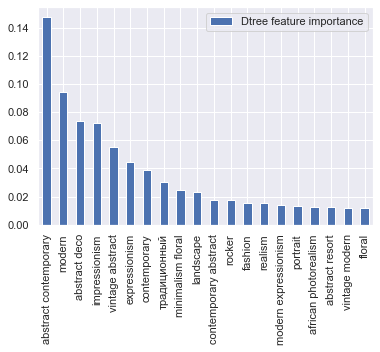

In [291]:
style_dtree_w_tfidf_features_imp_df.iloc[:20].plot(kind="bar").legend(loc="upper right");

In [292]:
#what if I do dimensionality reduction before computing the regressor?

In [293]:
from sklearn.decomposition import TruncatedSVD

style_dtree_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', style_tags_tranform),
    ('SVD', TruncatedSVD(n_components=8)),
    ('dtree', DecisionTreeRegressor(max_depth=10))
])

In [294]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {'dtree__max_depth': range(2,12,2), 'SVD__n_components': range(2,42,2)} 
#style_dtree_w_tfidf_SVD_CVmodel = RandomizedSearchCV(style_dtree_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1, n_iter=20)
style_dtree_w_tfidf_SVD_CVmodel = GridSearchCV(style_dtree_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [295]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

style_tags_SVD_dtree_CVmodel_filename = './Git_exclude/models/style_tags_SVD_dtree_CVmodel.joblib'

#If the model file already exists, I load it:
try:
    with open(style_tags_SVD_dtree_CVmodel_filename, 'rb') as f:
        style_dtree_w_tfidf_SVD_CVmodel = load(f)
        print('Loaded joblib file with decision tree model for style tags vectorized with tf-idf and reduced with SVD.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    style_dtree_w_tfidf_SVD_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(style_tags_SVD_dtree_CVmodel_filename, 'wb') as f:
        dump(style_dtree_w_tfidf_SVD_CVmodel, style_tags_SVD_dtree_CVmodel_filename) 
        print('Saved joblib file with decision tree model for style tags vectorized with tf-idf and reduced with SVD.')

Loaded joblib file with decision tree model for style tags vectorized with tf-idf and reduced with SVD.


In [296]:
style_dtree_w_tfidf_SVD_CVmodel.best_params_

{'SVD__n_components': 38, 'dtree__max_depth': 6}

In [297]:
#Predict prices on training set:
prices_train_pred = style_dtree_w_tfidf_SVD_CVmodel.predict(paintings_df_train)

In [298]:
#And return the R2 score as follows:
style_dtree_w_tfidf_SVD_CVmodel.score(paintings_df_train,prices_train)

0.04509493407717946

In [299]:
#Predict prices on test set:
prices_test_pred = style_dtree_w_tfidf_SVD_CVmodel.predict(paintings_df_test)

In [300]:
#And return the R2 score as follows:
style_dtree_w_tfidf_SVD_CVmodel.score(paintings_df_test,prices_test)

0.04500849399856488

In [301]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision tree model using vectorized tags with Tf-Idf followed by SVD')

Decision tree model using vectorized tags with Tf-Idf followed by SVD:
Training R^2: 0.04509493407717946
Testing R^2: 0.04500849399856488
Training RMSE: USD 137.55871891223026
Testing RMSE: USD 138.90933120028907
Training MAE: USD 110.97050885295663
Testing MAE: USD 112.10813276847995


In [302]:
#Let's check what the SVD components, often interpreted as 'topics' are:

In [303]:
style_feature_names = style_dtree_w_tfidf_SVD_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['style tags tfidf']['to tfidf n-grams'].get_feature_names()

In [304]:
# Get Singular values and Components 
Sigma = style_dtree_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].singular_values_ 
Sigma

array([92.71376264, 72.05133587, 62.30006135, 54.50276513, 41.38687466,
       40.36503422, 40.07906089, 39.10593646, 34.59701362, 29.00301021,
       27.22751832, 26.65796391, 26.58069563, 24.52624064, 24.39655803,
       22.88138051, 22.15479675, 21.85885765, 21.23623287, 20.87500192,
       20.47624751, 20.2315858 , 20.18252962, 19.07900279, 18.80886362,
       18.73733113, 18.36375341, 18.20970773, 17.82127622, 17.75885904,
       16.61472409, 16.45934338, 16.22798567, 15.96062914, 15.86739994,
       15.67965932, 15.29319168, 14.86458088])

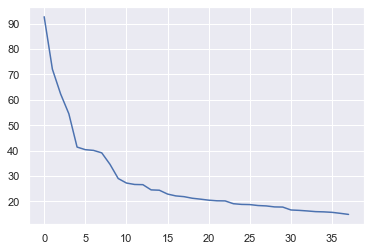

In [305]:
plt.plot(Sigma)

In [306]:
list_of_style_topics = []
list_of_style_topic_num_names = []

for index, component in enumerate(style_dtree_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].components_):
    zipped = zip(style_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_style_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_style_topics.append(topic_style_components)
    list_of_style_topic_num_names.append("Style topic "+str(index))
    print("Topic "+str(index)+": ",topic_style_components) #top_terms_list, top_comp_list)

Topic 0:  ['abstract(0.97)', 'modern(0.15)', 'modern abstract(0.15)']
Topic 1:  ['landscape(0.99)', 'abstract(-0.08)', 'impressionism(0.07)']
Topic 2:  ['portrait(1.0)', 'abstract portrait(0.04)', 'modern(0.03)']
Topic 3:  ['modern(0.73)', 'modern abstract(0.52)', 'contemporary(0.28)']
Topic 4:  ['impressionism(0.54)', 'contemporary(0.51)', 'floral(0.32)']
Topic 5:  ['beach(0.93)', 'contemporary(-0.24)', 'contemporary abstract(-0.14)']
Topic 6:  ['floral(0.78)', 'contemporary(-0.43)', 'contemporary abstract(-0.27)']
Topic 7:  ['impressionism(0.7)', 'floral(-0.5)', 'contemporary(-0.3)']
Topic 8:  ['vintage(0.97)', 'vintage landscape(0.1)', 'vintage portrait(0.09)']
Topic 9:  ['expressionism(0.7)', 'expressionism abstract(0.42)', 'modern abstract(-0.32)']
Topic 10:  ['modern(0.47)', 'modern abstract(-0.47)', 'contemporary modern(-0.43)']
Topic 11:  ['realism(0.94)', 'fantasy(0.27)', 'portrait realism(0.16)']
Topic 12:  ['fantasy(0.95)', 'realism(-0.27)', 'abstract fantasy(0.12)']
Topic 1

In [307]:
#Which are the most predictive 'topics' in the decision tree?

In [308]:
#What are the style words or word combos that are used most by the tree regressor?
style_dtree_w_tfidf_SVD_features_imp_df = pd.DataFrame(style_dtree_w_tfidf_SVD_CVmodel.best_estimator_['dtree'].feature_importances_,columns=['Dtree feature importance'])
style_dtree_w_tfidf_SVD_features_imp_df['Topic']=pd.Series(list_of_style_topics)
style_dtree_w_tfidf_SVD_features_imp_df = style_dtree_w_tfidf_SVD_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
style_dtree_w_tfidf_SVD_features_imp_df.iloc[:20]

Dtree feature importance  \
3                   0.315069   
26                  0.155656   
25                  0.074392   
13                  0.066040   
18                  0.051716   
7                   0.041670   
27                  0.039568   
21                  0.029325   
37                  0.028858   
34                  0.026360   
23                  0.020357   
6                   0.019090   
33                  0.018575   
20                  0.015869   
12                  0.013154   
35                  0.012783   
11                  0.012016   
19                  0.009989   
4                   0.009637   
0                   0.008571   

                                                Topic  
3   [modern(0.73), modern abstract(0.52), contempo...  
26  [modern contemporary(0.64), expressionism abst...  
25  [deco(0.82), abstract deco(0.48), modern conte...  
13  [pop(0.97), abstract pop(0.19), landscape abst...  
18  [minimalism(0.85), minimalism modern(0.37), mi...  
7   [impressionism(0.7), floral(-0.5), contemporar...  
27  [traditional(0.91), landscape traditional(0.19...  
21  [nautical(0.63), impressionism landscape(-0.5)...  
37  [impressionism modern(0.42), landscape contemp...  
34  [abstract portrait(0.99), boho(0.07), chic(0.05)]  
23  [rustic(0.91), rustic landscape(0.2), traditio...  
6   [floral(0.78), contemporary(-0.43), contempora...  
33   [boho(0.86), abstract boho(0.36), western(0.17)]  
20  [whimsical(0.97), abstract whimsical(0.15), am...  
12  [fantasy(0.95), realism(-0.27), abstract fanta...  
35  [western(0.92), landscape western(0.2), boho(-...  
11  [realism(0.94), fantasy(0.27), portrait realis...  
19  [american(0.88), african(0.36), african americ...  
4   [impressionism(0.54), contemporary(0.51), flor...  
0   [abstract(0.97), modern(0.15), modern abstract...

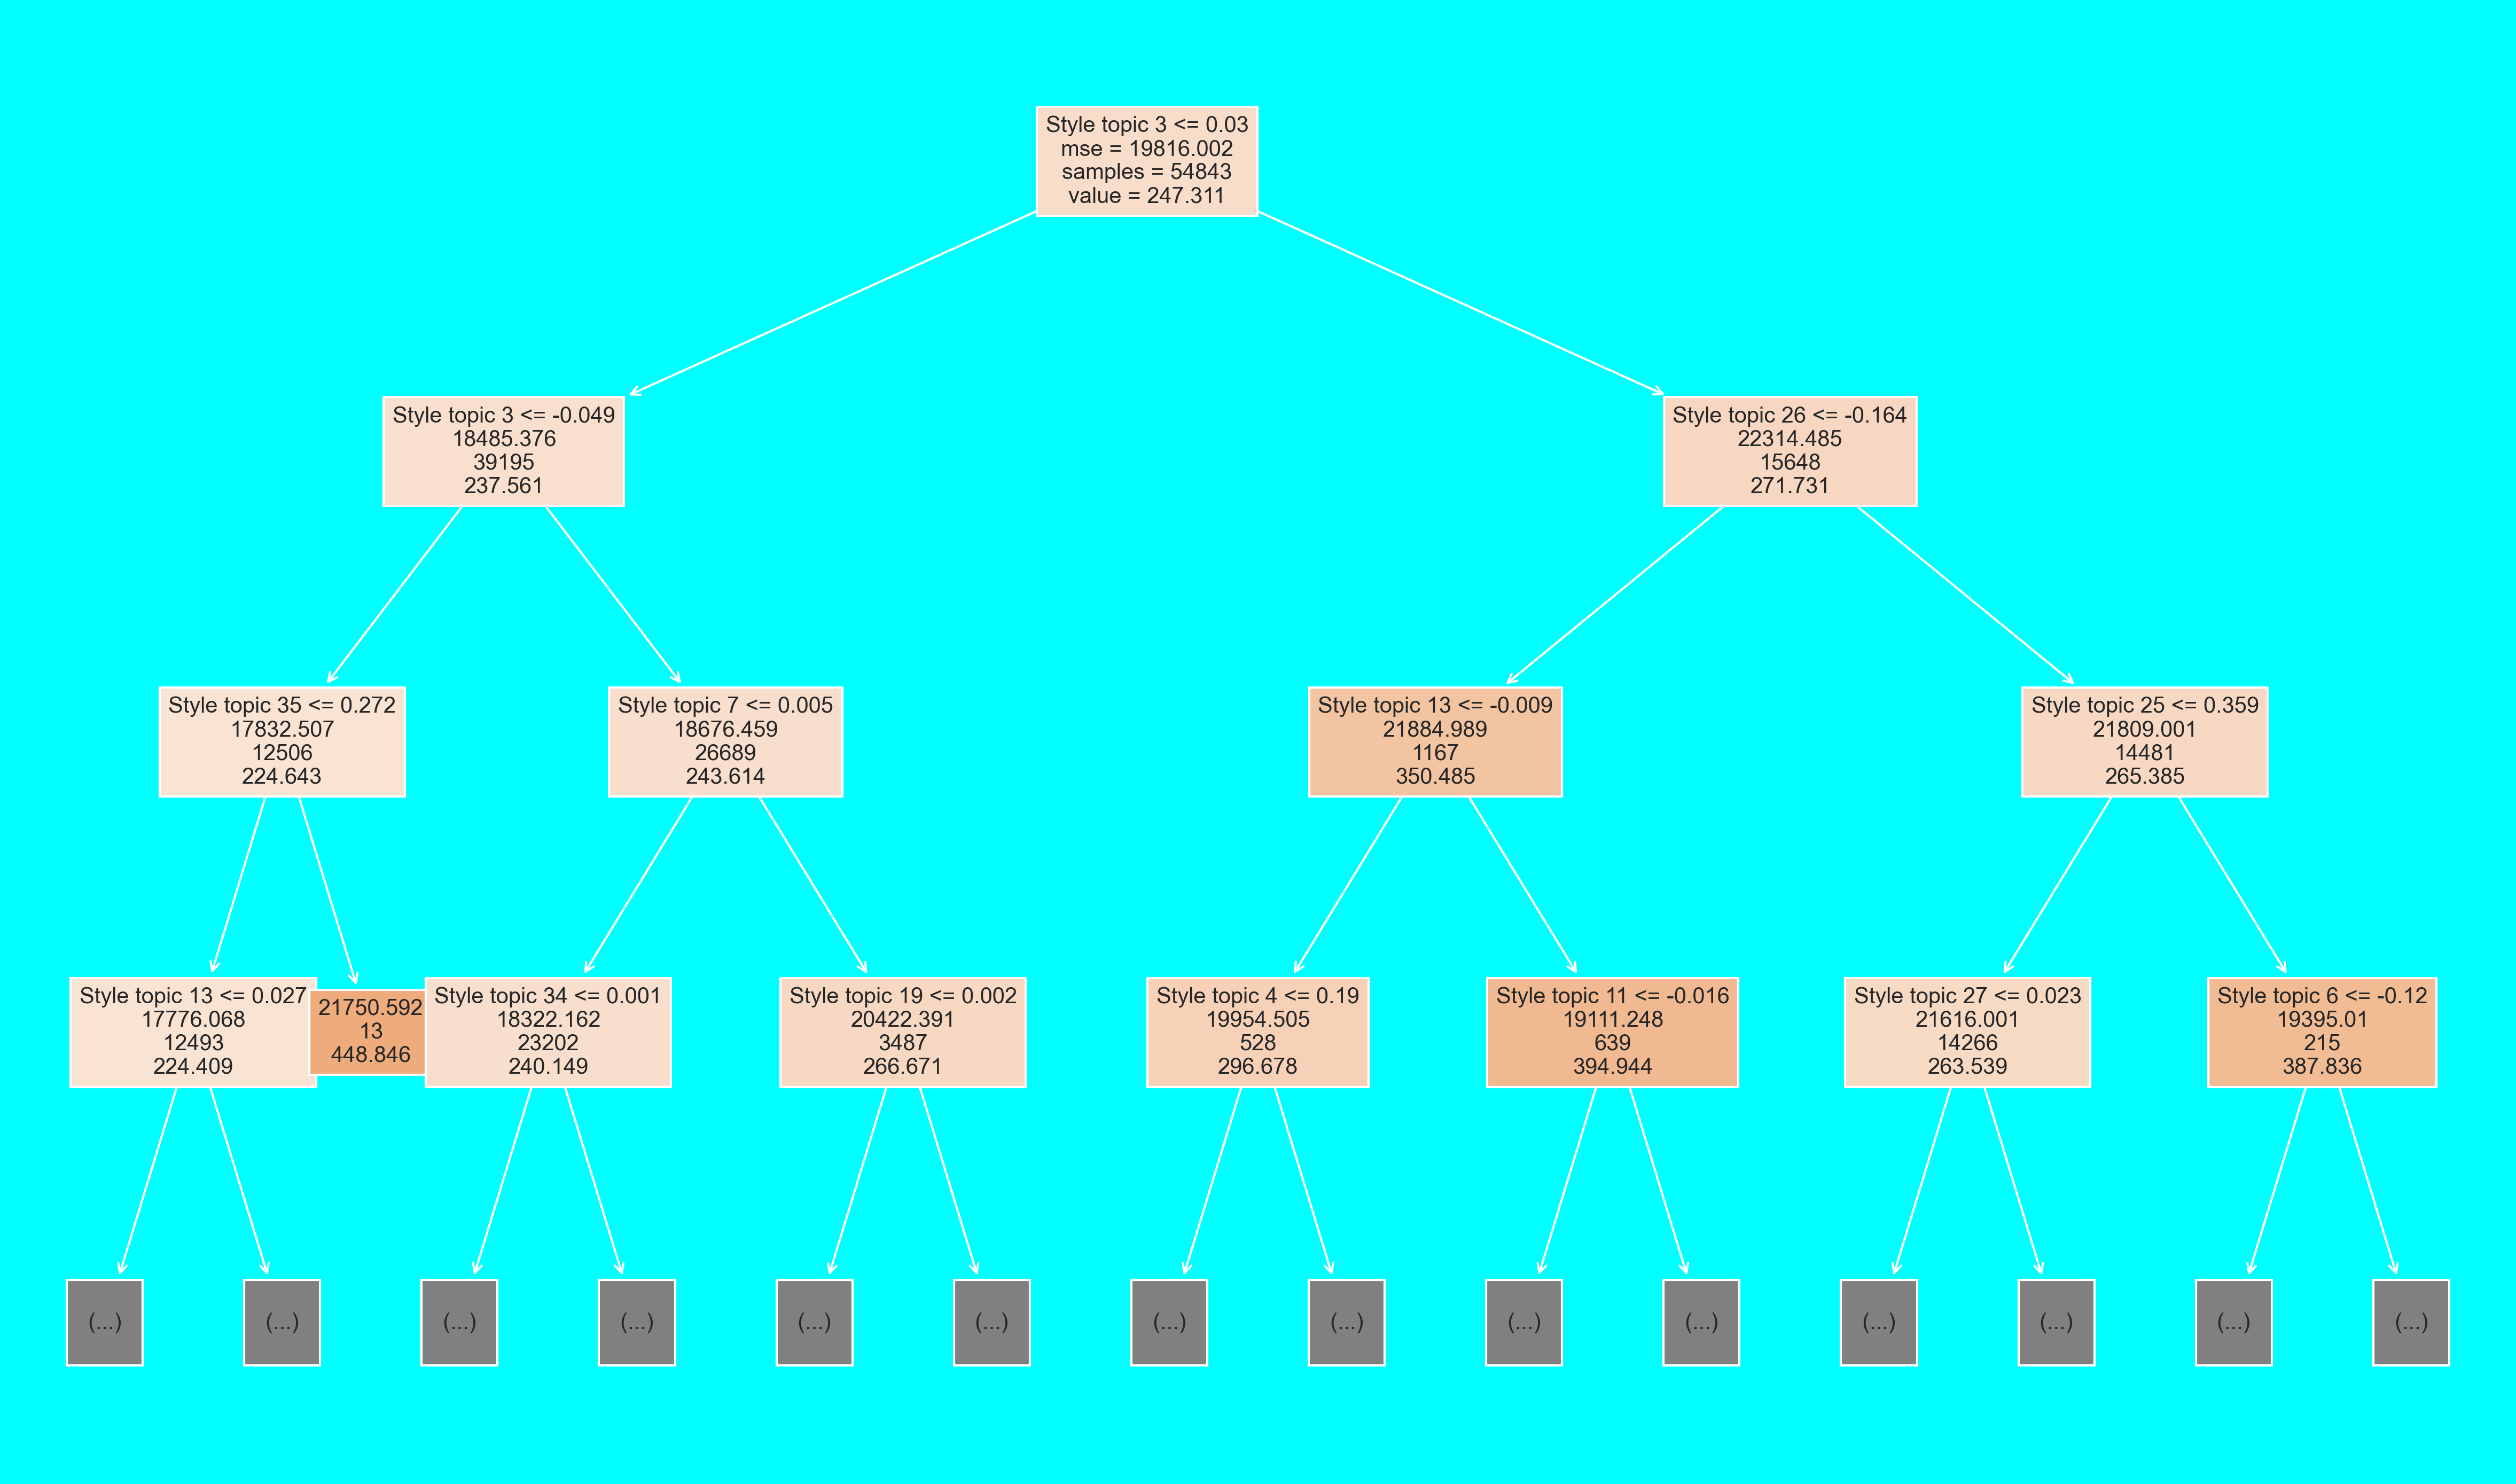

In [309]:
# Generate a plot of the decision tree
#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,12), dpi=300)
fig = plt.figure(figsize=(20,12), dpi=300)
fig.set_facecolor("cyan")
tree_viz = plot_tree(style_dtree_w_tfidf_SVD_CVmodel.best_estimator_['dtree'],max_depth=3,fontsize=10,label='root',filled=True,feature_names = list_of_style_topic_num_names)
fig.savefig('./Git_exclude/Figures/decision_tree_style_tags_After_tfidf_SVD.png')

#### Model 4e) Random Forest on Style Tags (vectorized, but without Tf-Idf vectorization or SVD reduction)

In [310]:
from sklearn.ensemble import RandomForestRegressor

In [311]:
style_rforest_pipe = Pipeline([
    ('style tags vectorization', style_tranform),
    ('rforest', RandomForestRegressor(n_estimators=100,max_features='sqrt',n_jobs=2,max_depth=style_dtree_CVmodel.best_params_['dtree__max_depth']+1,random_state=1,max_samples=0.8))
])

In [312]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

style_rforest_pipe_filename = './Git_exclude/models/style_rforest_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(style_rforest_pipe_filename, 'rb') as f:
        style_rforest_pipe = load(f)
        print('Loaded joblib file with random forest model for style tags (without Tf-Idf).')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    style_rforest_pipe.fit(paintings_df_train,prices_train)
    
    with open(style_rforest_pipe_filename, 'wb') as f:
        dump(style_rforest_pipe, style_rforest_pipe_filename) 
        print('Saved joblib file with random forest model for style tags (without Tf-Idf).')

Loaded joblib file with random forest model for style tags (without Tf-Idf).


In [313]:
#Predict prices on training set:
prices_train_pred = style_rforest_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
style_rforest_pipe.score(paintings_df_train,prices_train)

0.06666272856166411

In [314]:
#Predict prices on test set:
prices_test_pred = style_rforest_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
style_rforest_pipe.score(paintings_df_test,prices_test)

0.05599689027228516

In [315]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using style tags (without Tf-Idf)')


Random Forest model using style tags (without Tf-Idf):
Training R^2: 0.06666272856166411
Testing R^2: 0.05599689027228516
Training RMSE: USD 135.99637377485632
Testing RMSE: USD 138.10785444362477
Training MAE: USD 110.10254647823982
Testing MAE: USD 111.90802631580422


In [316]:
feature_names_style_rforest = style_rforest_pipe['style tags vectorization'].named_transformers_['style tags vectorizer'][-1].get_feature_names()

In [317]:
feature_names_style_rforest

['abstract',
 'african',
 'american',
 'asian',
 'athletic',
 'automobilia',
 'avant',
 'beach',
 'boho',
 'burlesque',
 'century',
 'chic',
 'coastal',
 'contemporary',
 'cottage',
 'country',
 'cовременный',
 'deco',
 'edwardian',
 'expressionism',
 'fantasy',
 'fashion',
 'floral',
 'folk',
 'goth',
 'hippie',
 'hipster',
 'historical',
 'hollywood',
 'impressionism',
 'industrial',
 'kawaii',
 'kitsch',
 'landscape',
 'mcm',
 'mediterranean',
 'military',
 'minimalism',
 'mod',
 'modern',
 'modernism',
 'nautical',
 'neoclassical',
 'nouveau',
 'photorealism',
 'pop',
 'portrait',
 'primitive',
 'realism',
 'regency',
 'renaissance',
 'resort',
 'retro',
 'rocker',
 'rustic',
 'sci',
 'southwestern',
 'spooky',
 'steampunk',
 'traditional',
 'tribal',
 'victorian',
 'vintage',
 'western',
 'whimsical',
 'woodland',
 'zen',
 'неоклассический',
 'традиционный']

In [318]:
style_rforest_features_imp_df = pd.DataFrame(style_rforest_pipe['rforest'].feature_importances_,feature_names_style_rforest,columns=['Rforest feature importance'])
style_rforest_features_imp_df = style_rforest_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
style_rforest_features_imp_df

Rforest feature importance
impressionism                    0.124170
modern                           0.120142
contemporary                     0.078183
expressionism                    0.062050
deco                             0.060826
...                                   ...
kitsch                           0.000750
edwardian                        0.000627
military                         0.000519
burlesque                        0.000271
automobilia                      0.000237

[69 rows x 1 columns]

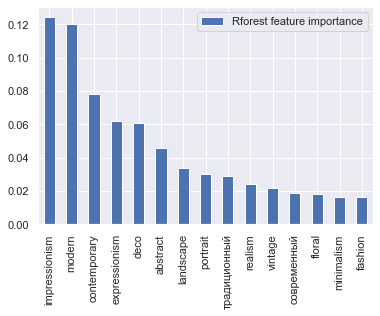

In [319]:
style_rforest_features_imp_df.iloc[:15].plot(kind="bar").legend(loc="upper right");

#### Model 4f) Random Forest on Style Tags, after Tf-Idf vectorization (with bigrams) and SVD reduction

In [320]:
from sklearn.ensemble import RandomForestRegressor

In [321]:
from sklearn.decomposition import TruncatedSVD

style_rforest_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', style_tags_tranform),
    ('SVD', TruncatedSVD(n_components=30)),
    ('rforest', RandomForestRegressor(n_estimators=100,max_features='sqrt',n_jobs=2,max_depth=style_dtree_w_tfidf_SVD_CVmodel.best_params_['dtree__max_depth']+1,random_state=1,max_samples=0.8))
])

In [322]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

style_rforest_w_tfidf_SVD_pipe_filename = './Git_exclude/models/style_rforest_w_tfidf_SVD_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(style_rforest_w_tfidf_SVD_pipe_filename, 'rb') as f:
        style_rforest_w_tfidf_SVD_pipe = load(f)
        print('Loaded joblib file with random forest model for style tags (after Tf-Idf and SVD).')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    style_rforest_w_tfidf_SVD_pipe.fit(paintings_df_train,prices_train)
    
    with open(style_rforest_w_tfidf_SVD_pipe_filename, 'wb') as f:
        dump(style_rforest_w_tfidf_SVD_pipe, style_rforest_w_tfidf_SVD_pipe_filename) 
        print('Saved joblib file with random forest model for style tags (after Tf-Idf and SVD).')

Loaded joblib file with random forest model for style tags (after Tf-Idf and SVD).


In [323]:
#Predict prices on training set:
prices_train_pred = style_rforest_w_tfidf_SVD_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
style_rforest_w_tfidf_SVD_pipe.score(paintings_df_train,prices_train)

0.059718389206027345

In [324]:
#Predict prices on test set:
prices_test_pred = style_rforest_w_tfidf_SVD_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
style_rforest_w_tfidf_SVD_pipe.score(paintings_df_test,prices_test)

0.05904607334270218

In [325]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using style tags (after Tf-Idf and SVD reduction)')


Random Forest model using style tags (after Tf-Idf and SVD reduction):
Training R^2: 0.059718389206027345
Testing R^2: 0.05904607334270218
Training RMSE: USD 136.50136528900404
Testing RMSE: USD 137.88462597391887
Training MAE: USD 110.44582837571996
Testing MAE: USD 111.67167329483871


In [326]:
#what are the main features used for decision?
style_rforest_w_tfidf_SVD_pipe['rforest'].feature_importances_

array([0.02893257, 0.02496909, 0.02147598, 0.08094447, 0.02954101,
       0.02818394, 0.02140482, 0.06325285, 0.03084798, 0.0362725 ,
       0.04426345, 0.02275488, 0.04062387, 0.02553792, 0.02959801,
       0.02414547, 0.01523518, 0.01759153, 0.03553243, 0.02111828,
       0.02448282, 0.01632373, 0.02968428, 0.01425958, 0.02514676,
       0.05226896, 0.06455207, 0.02765803, 0.05579873, 0.04759882])

In [327]:
list_of_style_topics = []
list_of_style_topic_num_names = []

for index, component in enumerate(style_rforest_w_tfidf_SVD_pipe['SVD'].components_):
    zipped = zip(style_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_style_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_style_topics.append(topic_style_components)
    list_of_style_topic_num_names.append("Style topic "+str(index))
    #print("Topic "+str(index)+": ",topic_style_components) #top_terms_list, top_comp_list)

In [328]:
#What are the style words or word combos that are used most by the random forest regressor?
style_rforest_w_tfidf_SVD_features_imp_df = pd.DataFrame(style_rforest_w_tfidf_SVD_pipe['rforest'].feature_importances_,columns=['Rforest feature importance'])
style_rforest_w_tfidf_SVD_features_imp_df['Topic']=pd.Series(list_of_style_topics)
style_rforest_w_tfidf_SVD_features_imp_df = style_rforest_w_tfidf_SVD_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
style_rforest_w_tfidf_SVD_features_imp_df.iloc[:20]

Rforest feature importance  \
3                     0.080944   
26                    0.064552   
7                     0.063253   
28                    0.055799   
25                    0.052269   
29                    0.047599   
10                    0.044263   
12                    0.040624   
9                     0.036273   
18                    0.035532   
8                     0.030848   
22                    0.029684   
14                    0.029598   
4                     0.029541   
0                     0.028933   
5                     0.028184   
27                    0.027658   
13                    0.025538   
24                    0.025147   
1                     0.024969   

                                                Topic  
3   [modern(0.73), modern abstract(0.52), contempo...  
26  [modern contemporary(0.63), expressionism abst...  
7   [impressionism(0.7), floral(-0.5), contemporar...  
28  [folk(0.57), contemporary modern(-0.36), moder...  
25  [deco(0.8), abstract deco(0.47), modern contem...  
29  [folk(0.75), contemporary modern(0.29), modern...  
10  [modern(0.47), modern abstract(-0.47), contemp...  
12  [fantasy(0.95), realism(-0.27), abstract fanta...  
9   [expressionism(0.7), expressionism abstract(0....  
18  [minimalism(0.85), minimalism modern(0.37), mi...  
8   [vintage(0.97), vintage landscape(0.1), vintag...  
22  [impressionism landscape(0.67), nautical(0.52)...  
14  [landscape abstract(0.94), contemporary abstra...  
4   [impressionism(0.54), contemporary(0.51), flor...  
0   [abstract(0.97), modern(0.15), modern abstract...  
5   [beach(0.93), contemporary(-0.24), contemporar...  
27  [traditional(0.91), landscape traditional(0.19...  
13  [pop(0.97), abstract pop(0.19), landscape abst...  
24  [century(0.82), century modern(0.24), deco(0.23)]  
1   [landscape(0.99), abstract(-0.08), impressioni...

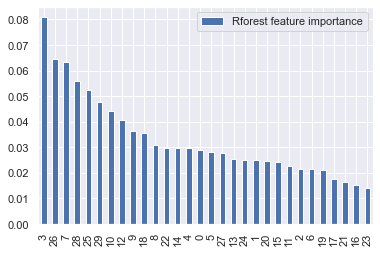

In [329]:
style_rforest_w_tfidf_SVD_features_imp_df.plot(kind="bar").legend(loc="upper right");

#### Model 4g) Gradient Boosted Trees on Style Tags (vectorized, without Tf-Idf and SVD reduction)

In [330]:
from sklearn.ensemble import GradientBoostingRegressor

In [331]:
style_gboost_pipe = Pipeline([
    ('style tags vectorization', style_tranform),
    ('gboost', GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,subsample=0.5,max_depth=style_dtree_w_tfidf_SVD_CVmodel.best_params_['dtree__max_depth']-3,random_state=1))
])

In [332]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

style_gboost_pipe_filename = './Git_exclude/models/style_gboost_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(style_gboost_pipe_filename, 'rb') as f:
        style_gboost_pipe = load(f)
        print('Loaded joblib file with gradient boosting model for style tags (without Tf-Idf and SVD).')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    style_gboost_pipe.fit(paintings_df_train,prices_train)
    
    with open(style_gboost_pipe_filename, 'wb') as f:
        dump(style_gboost_pipe, style_gboost_pipe_filename) 
        print('Saved joblib file with gradient boosting model for style tags (without Tf-Idf and SVD).')

Loaded joblib file with gradient boosting model for style tags (without Tf-Idf and SVD).


In [333]:
#Predict prices on training set:
prices_train_pred = style_gboost_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
style_gboost_pipe.score(paintings_df_train,prices_train)

0.0530967803309621

In [334]:
#Predict prices on test set:
prices_test_pred = style_gboost_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
style_gboost_pipe.score(paintings_df_test,prices_test)

0.05273622286061097

In [335]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosting model using style tags (without Tf-Idf and SVD reduction)')


Gradient Boosting model using style tags (without Tf-Idf and SVD reduction):
Training R^2: 0.0530967803309621
Testing R^2: 0.05273622286061097
Training RMSE: USD 136.9811539724073
Testing RMSE: USD 138.34616699873072
Training MAE: USD 110.90445055070833
Testing MAE: USD 112.1239908639524


In [336]:
#what are the main features used for decision?
style_gboost_pipe['gboost'].feature_importances_

array([0.02909888, 0.00697048, 0.00392049, 0.00711418, 0.00210224,
       0.        , 0.00928004, 0.00474412, 0.00746759, 0.00170136,
       0.00756195, 0.00245787, 0.00897467, 0.06075636, 0.00409228,
       0.0006012 , 0.02181525, 0.07934911, 0.        , 0.04609326,
       0.00774127, 0.02119344, 0.01335539, 0.00458839, 0.005155  ,
       0.00237456, 0.00192867, 0.00136115, 0.00185815, 0.13423088,
       0.00512709, 0.00149937, 0.00033939, 0.02117819, 0.00535701,
       0.00575218, 0.00175259, 0.01468309, 0.00334133, 0.12301708,
       0.01369798, 0.01200706, 0.01944849, 0.00181415, 0.01179098,
       0.01133168, 0.03446103, 0.000859  , 0.02745413, 0.00394348,
       0.0039989 , 0.01575697, 0.00374165, 0.02086752, 0.00586042,
       0.0015116 , 0.01052525, 0.00700612, 0.00060256, 0.00288018,
       0.00180278, 0.01323381, 0.02957989, 0.00373051, 0.00526494,
       0.01151183, 0.00718835, 0.00326338, 0.03492977])

In [337]:
feature_names_style_gboost = style_gboost_pipe['style tags vectorization'].named_transformers_['style tags vectorizer'][-1].get_feature_names()

In [338]:
feature_names_style_gboost

['abstract',
 'african',
 'american',
 'asian',
 'athletic',
 'automobilia',
 'avant',
 'beach',
 'boho',
 'burlesque',
 'century',
 'chic',
 'coastal',
 'contemporary',
 'cottage',
 'country',
 'cовременный',
 'deco',
 'edwardian',
 'expressionism',
 'fantasy',
 'fashion',
 'floral',
 'folk',
 'goth',
 'hippie',
 'hipster',
 'historical',
 'hollywood',
 'impressionism',
 'industrial',
 'kawaii',
 'kitsch',
 'landscape',
 'mcm',
 'mediterranean',
 'military',
 'minimalism',
 'mod',
 'modern',
 'modernism',
 'nautical',
 'neoclassical',
 'nouveau',
 'photorealism',
 'pop',
 'portrait',
 'primitive',
 'realism',
 'regency',
 'renaissance',
 'resort',
 'retro',
 'rocker',
 'rustic',
 'sci',
 'southwestern',
 'spooky',
 'steampunk',
 'traditional',
 'tribal',
 'victorian',
 'vintage',
 'western',
 'whimsical',
 'woodland',
 'zen',
 'неоклассический',
 'традиционный']

In [339]:
style_gboost_features_imp_df = pd.DataFrame(style_gboost_pipe['gboost'].feature_importances_,feature_names_style_gboost,columns=['Gboost feature importance'])
style_gboost_features_imp_df = style_gboost_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
style_gboost_features_imp_df

Gboost feature importance
impressionism                   0.134231
modern                          0.123017
deco                            0.079349
contemporary                    0.060756
expressionism                   0.046093
...                                  ...
steampunk                       0.000603
country                         0.000601
kitsch                          0.000339
automobilia                     0.000000
edwardian                       0.000000

[69 rows x 1 columns]

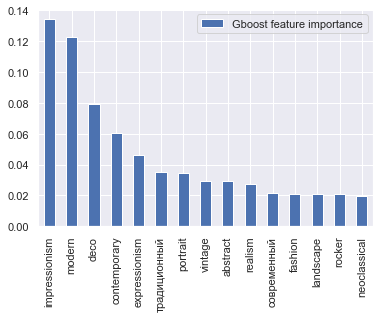

In [340]:
style_gboost_features_imp_df.iloc[:15].plot(kind="bar").legend(loc="upper right");

#### Model 4h) Gradient Boosted Trees on Style Tags, after Tf-Idf vectorization (with bigrams) and SVD reduction

In [341]:
from sklearn.ensemble import GradientBoostingRegressor

In [342]:
from sklearn.decomposition import TruncatedSVD

style_gboost_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', style_tags_tranform),
    ('SVD', TruncatedSVD(n_components=30)),
    ('gboost', GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,subsample=0.5,max_depth=style_dtree_w_tfidf_SVD_CVmodel.best_params_['dtree__max_depth']-3,random_state=1))
])

In [343]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

style_gboost_w_tfidf_SVD_pipe_filename = './Git_exclude/models/style_gboost_w_tfidf_SVD_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(style_gboost_w_tfidf_SVD_pipe_filename, 'rb') as f:
        style_gboost_w_tfidf_SVD_pipe = load(f)
        print('Loaded joblib file with gradient boosting model for style tags (after Tf-Idf and SVD).')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    style_gboost_w_tfidf_SVD_pipe.fit(paintings_df_train,prices_train)
    
    with open(style_gboost_w_tfidf_SVD_pipe_filename, 'wb') as f:
        dump(style_gboost_w_tfidf_SVD_pipe, style_gboost_w_tfidf_SVD_pipe_filename) 
        print('Saved joblib file with gradient boosting model for style tags (after Tf-Idf and SVD).')

Loaded joblib file with gradient boosting model for style tags (after Tf-Idf and SVD).


In [344]:
#Predict prices on training set:
prices_train_pred = style_gboost_w_tfidf_SVD_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
style_gboost_w_tfidf_SVD_pipe.score(paintings_df_train,prices_train)

0.06169251311098145

In [345]:
#Predict prices on test set:
prices_test_pred = style_gboost_w_tfidf_SVD_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
style_gboost_w_tfidf_SVD_pipe.score(paintings_df_test,prices_test)

0.058089441252332286

In [346]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosting model using style tags (after Tf-Idf and SVD reduction)')


Gradient Boosting model using style tags (after Tf-Idf and SVD reduction):
Training R^2: 0.06169251311098145
Testing R^2: 0.058089441252332286
Training RMSE: USD 136.35799749768083
Testing RMSE: USD 137.95469919727597
Training MAE: USD 110.20474931332443
Testing MAE: USD 111.585090331766


In [347]:
#what are the main features used for decision?
style_gboost_w_tfidf_SVD_pipe['gboost'].feature_importances_

array([0.03766884, 0.01217029, 0.01309524, 0.12016014, 0.01677092,
       0.01946086, 0.01504198, 0.05115624, 0.03642845, 0.03316842,
       0.04230049, 0.02288811, 0.03643351, 0.04027016, 0.03120738,
       0.03017889, 0.01709116, 0.00983075, 0.03202066, 0.02645862,
       0.0356754 , 0.00702019, 0.03332435, 0.02020117, 0.02461856,
       0.0719237 , 0.0748661 , 0.02998975, 0.03054704, 0.02803264])

In [348]:
list_of_style_topics = []
list_of_style_topic_num_names = []

for index, component in enumerate(style_gboost_w_tfidf_SVD_pipe['SVD'].components_):
    zipped = zip(style_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_style_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_style_topics.append(topic_style_components)
    list_of_style_topic_num_names.append("Style topic "+str(index))
    #print("Topic "+str(index)+": ",topic_style_components) #top_terms_list, top_comp_list)

In [349]:
#What are the style words or word combos that are used most by the random forest regressor?
style_gboost_w_tfidf_SVD_features_imp_df = pd.DataFrame(style_gboost_w_tfidf_SVD_pipe['gboost'].feature_importances_,columns=['Gboost feature importance'])
style_gboost_w_tfidf_SVD_features_imp_df['Topic']=pd.Series(list_of_style_topics)
style_gboost_w_tfidf_SVD_features_imp_df = style_gboost_w_tfidf_SVD_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
style_gboost_w_tfidf_SVD_features_imp_df.iloc[:20]

Gboost feature importance  \
3                    0.120160   
26                   0.074866   
25                   0.071924   
7                    0.051156   
10                   0.042300   
13                   0.040270   
0                    0.037669   
12                   0.036434   
8                    0.036428   
20                   0.035675   
22                   0.033324   
9                    0.033168   
18                   0.032021   
14                   0.031207   
28                   0.030547   
15                   0.030179   
27                   0.029990   
29                   0.028033   
19                   0.026459   
24                   0.024619   

                                                Topic  
3   [modern(0.73), modern abstract(0.52), contempo...  
26  [modern contemporary(0.64), expressionism abst...  
25  [deco(0.81), abstract deco(0.47), modern conte...  
7   [impressionism(0.7), floral(-0.5), contemporar...  
10  [modern(0.47), modern abstract(-0.47), contemp...  
13  [pop(0.97), abstract pop(0.19), landscape abst...  
0   [abstract(0.97), modern(0.15), modern abstract...  
12  [fantasy(0.95), realism(-0.27), abstract fanta...  
8   [vintage(0.97), vintage landscape(0.1), vintag...  
20  [whimsical(0.97), abstract whimsical(0.15), am...  
22  [impressionism landscape(0.72), nautical(0.46)...  
9   [expressionism(0.7), expressionism abstract(0....  
18  [minimalism(0.85), minimalism modern(0.37), mi...  
14  [landscape abstract(0.94), contemporary abstra...  
28  [folk(0.57), contemporary modern(-0.38), expre...  
15  [country(0.9), landscape country(0.37), rustic...  
27  [traditional(0.91), landscape traditional(0.19...  
29  [folk(0.76), modern contemporary(-0.23), conte...  
19  [american(0.88), african(0.36), african americ...  
24  [century(0.84), modern contemporary(-0.26), ce...

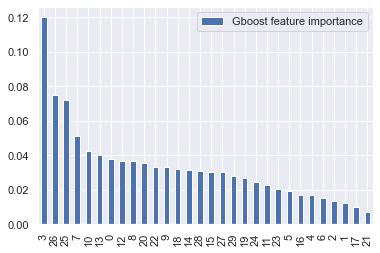

In [350]:
style_gboost_w_tfidf_SVD_features_imp_df.plot(kind="bar").legend(loc="upper right");

## 5) Models using only the 'materials' tags (note that these include some color information as well)

In [351]:
all_paintings_df['materials_tags_new'].iloc[1]

"['acrylic', 'mixed', 'canvas', 'love', 'board', 'media', 'red']"

In [352]:
all_paintings_df['materials_tags_new'].value_counts()

['stretched', 'canvas']                                           3629
['acrylic', 'stretched', 'canvas']                                2364
['paper', 'watercolor']                                           2255
['stretched', 'oil', 'canvas']                                    2185
['acrylic', 'canvas']                                             1640
                                                                  ... 
['frame', 'acrylics', 'canvas', 'hand', 'stretched', 'oils']         1
['acrylic', 'canvas', 'brush', 'green', 'gloss', 'varnish']          1
['fabric', 'canvas', 'board']                                        1
['acrylic', 'archival', 'ink', 'paper', 'watercolor', 'water']       1
['acrylic', 'blue', 'canvas', 'wood', 'paper']                       1
Name: materials_tags_new, Length: 17221, dtype: int64

In [353]:
#As for style, I start by using the 'DictVectorizer' provided by scikit-learn. 
#However, before I can use 'DictVectorizer' I need to convert my list of strings into array of dictionaries.
#I do that with a 'DictEncoder' already defined earlier:

In [354]:
# #Recall: 
# def stringlist_to_dict(stringlist):
#     dict = {}
#     for string in stringlist:
#         dict[string]=1
#     return dict

In [355]:
# from sklearn.base import BaseEstimator, TransformerMixin
# class DictEncoder(BaseEstimator, TransformerMixin):
    
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         # X will be a pandas series of strings representing lists of strings. Return a pandas series of dictionaries
#         return X.apply(eval).apply(stringlist_to_dict)

In [356]:
all_paintings_df['materials_tags_new'].apply(eval).apply(stringlist_to_dict)

0        {'acrylic': 1, 'mixed': 1, 'yellow': 1, 'canva...
1        {'acrylic': 1, 'mixed': 1, 'canvas': 1, 'love'...
2          {'green': 1, 'red': 1, 'canvas': 1, 'board': 1}
3        {'acrylic': 1, 'panel': 1, 'ink': 1, 'acrylics...
4                    {'water': 1, 'canvas': 1, 'board': 1}
                               ...                        
68549    {'white': 1, 'yellow': 1, 'purple': 1, 'canvas...
68550          {'acrylic': 1, 'stretched': 1, 'canvas': 1}
68551                              {'oil': 1, 'canvas': 1}
68552              {'acrylic': 1, 'canvas': 1, 'board': 1}
68553    {'oil': 1, 'canvas': 1, 'stretched': 1, 'water...
Name: materials_tags_new, Length: 68554, dtype: object

In [357]:
from sklearn.feature_extraction import DictVectorizer

pipe_materials_tags_encoding = Pipeline([
    ('to dict series',DictEncoder()),
    ('to binary vectors',DictVectorizer())
])

In [358]:
#now I can run the 'style_tags_new' column through this Encoder-Vectorizer sequence of steps
materials_tranform = ColumnTransformer([
    ('materials tags vectorizer', pipe_materials_tags_encoding, 'materials_tags_new'),
], remainder='drop')

In [359]:
#Let's test this in isolation, which will also enable me to extract the name of the style tags in the order in which they'll appear 
#in the regression models
materials_tranform.fit_transform(paintings_df_train)

<54843x100 sparse matrix of type '<class 'numpy.float64'>'
	with 199927 stored elements in Compressed Sparse Row format>

In [360]:
materials_vectorizer_feature_names = materials_tranform.named_transformers_['materials tags vectorizer'][-1].feature_names_

In [893]:
materials_vectorizer_feature_names

['140',
 'acid',
 'acrylic',
 'acrylics',
 'aluminum',
 'arches',
 'archival',
 'birch',
 'black',
 'blue',
 'board',
 'brush',
 'brushes',
 'canvas',
 'cardboard',
 'charcoal',
 'clear',
 'cold',
 'collage',
 'cotton',
 'epoxy',
 'fabric',
 'fine',
 'finish',
 'floetrol',
 'frame',
 'framed',
 'gel',
 'gesso',
 'glass',
 'glitter',
 'gloss',
 'gold',
 'golden',
 'gouache',
 'grade',
 'graphite',
 'green',
 'hand',
 'hang',
 'hanger',
 'hanging',
 'hardboard',
 'hardware',
 'heavy',
 'ink',
 'knife',
 'lb',
 'leaf',
 'linen',
 'liquitex',
 'love',
 'marker',
 'mat',
 'matte',
 'media',
 'metal',
 'metallic',
 'mixed',
 'newton',
 'oil',
 'oils',
 'painted',
 'palette',
 'panel',
 'paper',
 'paste',
 'pastel',
 'pen',
 'pencil',
 'pigment',
 'pigments',
 'premium',
 'press',
 'pressed',
 'print',
 'protective',
 'purple',
 'red',
 'resin',
 'satin',
 'spray',
 'stretched',
 'stretcher',
 'texture',
 'thick',
 'unframed',
 'uv',
 'varnish',
 'water',
 'watercolor',
 'watercolors',
 'whit

### 5a) Ridge regression of materials tags only, after vectorization

Since there are a large number of features, one for each possible materials tag (there are 100), cross validation is critical to prevent overfitting.

In [362]:
from sklearn.linear_model import Ridge

materials_ridge_pipe = Pipeline([
    ('materials tags vectorization', materials_tranform),
    ('ridge',Ridge(alpha=10))
])

In [363]:
from sklearn.model_selection import GridSearchCV

param_grid = {'ridge__alpha': np.logspace(0,8,20)} 
materials_ridge_CVmodel = GridSearchCV(materials_ridge_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [364]:
#Train the model
materials_ridge_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   52.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  1.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('materials tags vectorization',
                                        ColumnTransformer(transformers=[('materials '
                                                                         'tags '
                                                                         'vectorizer',
                                                                         Pipeline(steps=[('to '
                                                                                          'dict '
                                                                                          'series',
                                                                                          DictEncoder()),
                                                                                         ('to '
                                                                                          'binary '
                                                                                          'vectors',
                                                                                          DictVectorizer())]),
                                                                         'materials_tags_new')])),
                                       ('ridge', Ridge(alpha=10))]),
             n_jobs=2,
             param_grid={'ridge__alpha': array([1.00000000e+00, 2.63665090e+00, 6.95192796e+00, 1.83298071e+01,
       4.83293024e+01, 1.27427499e+02, 3.35981829e+02, 8.85866790e+02,
       2.33572147e+03, 6.15848211e+03, 1.62377674e+04, 4.28133240e+04,
       1.12883789e+05, 2.97635144e+05, 7.84759970e+05, 2.06913808e+06,
       5.45559478e+06, 1.43844989e+07, 3.79269019e+07, 1.00000000e+08])},
             verbose=1)

In [365]:
materials_ridge_CVmodel.best_params_

{'ridge__alpha': 18.329807108324356}

In [366]:
#Predict prices on training set:
prices_train_pred = materials_ridge_CVmodel.predict(paintings_df_train)

In [367]:
#And return the R2 score as follows:
materials_ridge_CVmodel.score(paintings_df_train,prices_train)

0.056525382069379626

In [368]:
#Predict prices on test set:
prices_test_pred = materials_ridge_CVmodel.predict(paintings_df_test)

In [369]:
#And return the R2 score as follows:
materials_ridge_CVmodel.score(paintings_df_test,prices_test)

0.06297137176154055

In [370]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using the vectorized materials tags')

Ridge regression model using the vectorized materials tags:
Training R^2: 0.056525382069379626
Testing R^2: 0.06297137176154055
Training RMSE: USD 136.73293444917164
Testing RMSE: USD 137.59672455335598
Training MAE: USD 109.97189236633368
Testing MAE: USD 110.60108358787446


In [371]:
#Which are the largest regression coefficients in the regression model?
materials_ridge_reg_coeff_df = pd.DataFrame(materials_ridge_CVmodel.best_estimator_['ridge'].coef_,columns=['Regression coefficients'])
materials_ridge_reg_coeff_df['Feature']=pd.Series(materials_vectorizer_feature_names)
materials_ridge_reg_coeff_df = materials_ridge_reg_coeff_df.sort_values(by='Regression coefficients',ascending=False)
materials_ridge_reg_coeff_df.set_index(['Feature'])


Regression coefficients
Feature                            
protective                61.999041
winsor                    55.822758
lb                        53.859490
satin                     47.479019
oil                       40.617917
...                             ...
pastel                   -24.774744
print                    -28.899743
metallic                 -33.116327
floetrol                 -37.465497
140                      -42.708482

[100 rows x 1 columns]

### 5b) Decision tree of materials tags only, after vectorization

In [372]:
from sklearn.pipeline import Pipeline

materials_dtree_pipe = Pipeline([
    ('materials tags vectorization', materials_tranform),
    ('dtree', DecisionTreeRegressor(max_depth=15)),
])

In [373]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,51,2)} 
materials_dtree_CVmodel = GridSearchCV(materials_dtree_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [374]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

materials_dtree_CVmodel_filename = './Git_exclude/models/materials_dtree_CVmodel.joblib'

#If the model file already exists, I load it:
try:
    with open(materials_dtree_CVmodel_filename, 'rb') as f:
        materials_dtree_CVmodel = load(f)
        print('Loaded joblib file with decision tree model for materials tags (vectorized but without tf-idf.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    materials_dtree_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(materials_dtree_CVmodel_filename, 'wb') as f:
        dump(materials_dtree_CVmodel, materials_dtree_CVmodel_filename) 
        print('Saved joblib file with decision tree model for materials tags (vectorized but without tf-idf).')



Loaded joblib file with decision tree model for materials tags (vectorized but without tf-idf.


In [375]:
materials_dtree_CVmodel.best_params_['dtree__max_depth']

8

In [376]:
#Predict prices on training set:
prices_train_pred = materials_dtree_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
materials_dtree_CVmodel.score(paintings_df_train,prices_train)

0.07881900065387248

In [377]:
#Predict prices on test set:
prices_test_pred = materials_dtree_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
materials_dtree_CVmodel.score(paintings_df_test,prices_test)

0.06664434148155596

In [378]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using only materials tags')


Decision Tree model using only materials tags:
Training R^2: 0.07881900065387248
Testing R^2: 0.06664434148155596
Training RMSE: USD 135.1078271679937
Testing RMSE: USD 137.3267835841725
Training MAE: USD 107.98280813746477
Testing MAE: USD 109.83642532480464


In [379]:
feature_names_materials_dtree = materials_dtree_CVmodel.best_estimator_['materials tags vectorization'].named_transformers_['materials tags vectorizer']['to binary vectors'].get_feature_names()

materials_dtree_features_imp_df = pd.DataFrame(materials_dtree_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_materials_dtree,columns=['Dtree feature importance'])
materials_dtree_features_imp_df = materials_dtree_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
materials_dtree_features_imp_df.iloc[:20]

Dtree feature importance
oil                         0.363721
paper                       0.065680
acrylic                     0.054575
brush                       0.042879
painted                     0.026308
canvas                      0.026096
protective                  0.023199
texture                     0.023085
watercolor                  0.020191
black                       0.019694
unframed                    0.019049
varnish                     0.018086
fine                        0.015926
media                       0.015742
hand                        0.014552
love                        0.013802
pencil                      0.013627
frame                       0.013050
white                       0.011701
wood                        0.010748

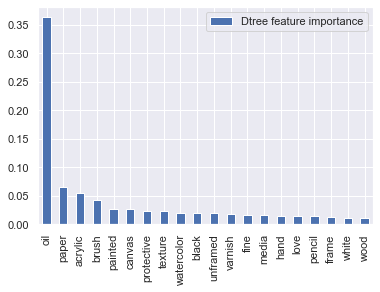

In [380]:
materials_dtree_features_imp_df.iloc[:20].plot(kind="bar").legend(loc="upper right");

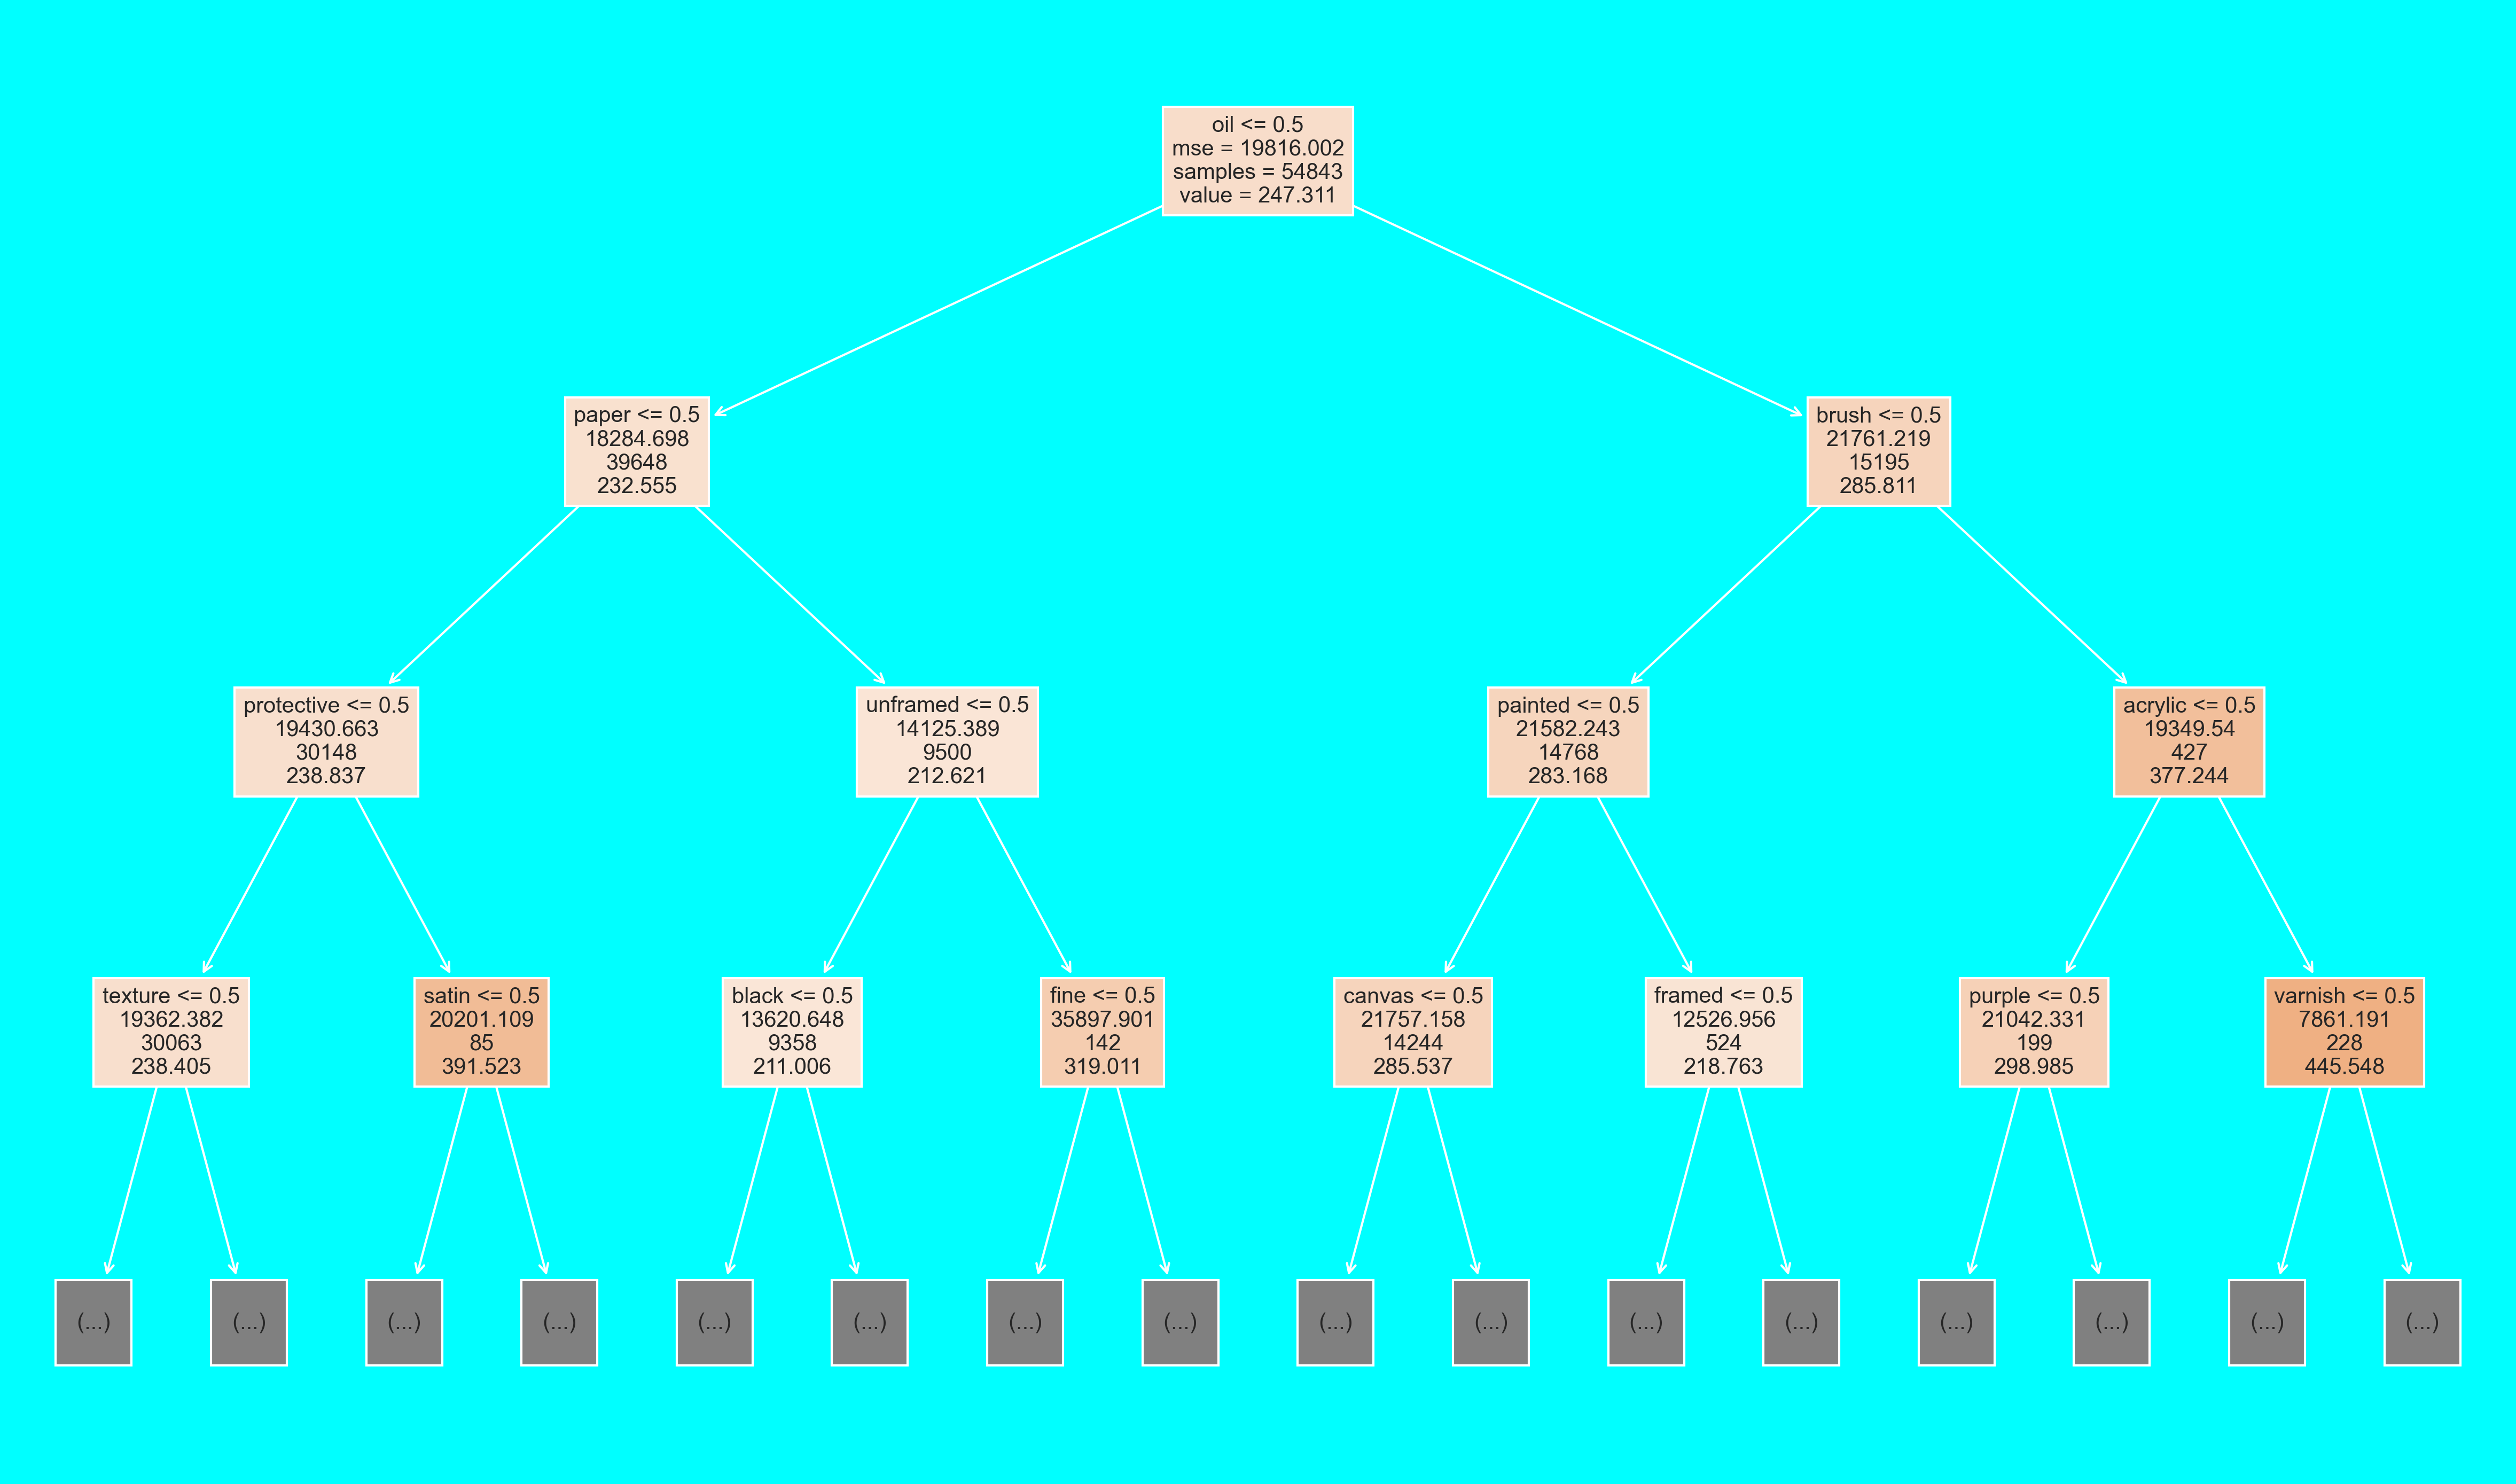

In [381]:
# Generate a plot of the decision tree
fig = plt.figure(figsize=(20,12), dpi=300)
fig.set_facecolor("cyan")
tree_viz = plot_tree(materials_dtree_CVmodel.best_estimator_['dtree'],max_depth=3,fontsize=10,label='root',filled=True,feature_names = feature_names_materials_dtree)
fig.savefig('./Git_exclude/Figures/decision_tree_materials_no_tfidf.png')

### 5c) Ridge regression of materials tags only, after Tf-Idf vectorization (up to bigrams) and optional dimensionality reduction

In [382]:
from sklearn.feature_extraction.text import TfidfTransformer #TfidfVectorizer

In [383]:
from sklearn.linear_model import Ridge

materials_ridge_w_tfidf_pipe = Pipeline([
    ('materials tags vectorization', materials_tranform),
    ('tfid', TfidfTransformer()), 
    ('ridge',Ridge(alpha=10))
])

In [384]:
from sklearn.model_selection import GridSearchCV

param_grid = {'ridge__alpha': np.logspace(0,8,20)} 
materials_ridge_w_tfidf_CVmodel = GridSearchCV(materials_ridge_w_tfidf_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [385]:
#Train the model
materials_ridge_w_tfidf_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   50.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  1.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('materials tags vectorization',
                                        ColumnTransformer(transformers=[('materials '
                                                                         'tags '
                                                                         'vectorizer',
                                                                         Pipeline(steps=[('to '
                                                                                          'dict '
                                                                                          'series',
                                                                                          DictEncoder()),
                                                                                         ('to '
                                                                                          'binary '
                                                                                          'vectors',
                                                                                          DictVectorizer())]),
                                                                         'materials_tags_new')])),
                                       ('tfid', TfidfTransformer()),
                                       ('ridge', Ridge(alpha=10))]),
             n_jobs=2,
             param_grid={'ridge__alpha': array([1.00000000e+00, 2.63665090e+00, 6.95192796e+00, 1.83298071e+01,
       4.83293024e+01, 1.27427499e+02, 3.35981829e+02, 8.85866790e+02,
       2.33572147e+03, 6.15848211e+03, 1.62377674e+04, 4.28133240e+04,
       1.12883789e+05, 2.97635144e+05, 7.84759970e+05, 2.06913808e+06,
       5.45559478e+06, 1.43844989e+07, 3.79269019e+07, 1.00000000e+08])},
             verbose=1)

In [386]:
materials_ridge_w_tfidf_CVmodel.best_params_

{'ridge__alpha': 6.951927961775605}

In [387]:
#Predict prices on training set:
prices_train_pred = materials_ridge_w_tfidf_CVmodel.predict(paintings_df_train)

In [388]:
#And return the R2 score as follows:
materials_ridge_w_tfidf_CVmodel.score(paintings_df_train,prices_train)

0.05431204780088528

In [389]:
#Predict prices on test set:
prices_test_pred = materials_ridge_w_tfidf_CVmodel.predict(paintings_df_test)

In [390]:
#And return the R2 score as follows:
materials_ridge_w_tfidf_CVmodel.score(paintings_df_test,prices_test)

0.05581389291916605

In [391]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized materials tags with Tf-Idf')

Ridge regression model using vectorized materials tags with Tf-Idf:
Training R^2: 0.05431204780088528
Testing R^2: 0.05581389291916605
Training RMSE: USD 136.89322408513053
Testing RMSE: USD 138.12124007066345
Training MAE: USD 110.10318968207521
Testing MAE: USD 111.09529809906478


### Method of implementing Tf-Idf - instead of going through the DictVectorizer - using TfIdfVectorizer, that enables to also use n-grams (i.e. sequences of words in addition to individual words) 
#### The TfIdfVectorizer takes a single string per document (row), so I need to first process the 'materials tags' column as follows (essentially joining the strings in the list)

In [392]:
# #Recall that this was implemented earlier for the style tags
# from sklearn.base import BaseEstimator, TransformerMixin
# class TagsEncoder(BaseEstimator, TransformerMixin):
    
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         # X will be a pandas series of strings representing lists of strings. Return a pandas series of single strings containing all individual strings joined by a space
#         return X.apply(eval).apply(lambda stringlist:' '.join(stringlist))

In [393]:
all_paintings_df['materials_tags_new'].iloc[0]

"['acrylic', 'mixed', 'yellow', 'canvas', 'board', 'media', 'red']"

In [394]:
all_paintings_df['materials_tags_new'].apply(eval).apply(lambda stringlist:' '.join(stringlist))

0           acrylic mixed yellow canvas board media red
1             acrylic mixed canvas love board media red
2                                green red canvas board
3            acrylic panel ink acrylics purple blue red
4                                    water canvas board
                              ...                      
68549    white yellow purple canvas stretched green red
68550                          acrylic stretched canvas
68551                                        oil canvas
68552                              acrylic canvas board
68553                        oil canvas stretched water
Name: materials_tags_new, Length: 68554, dtype: object

In [395]:
#Let's count n-grams of up to 2 words

In [396]:
# #Recall that this was implemented earlier for the style tags
# from sklearn.feature_extraction.text import TfidfVectorizer

# pipe_tags_encoding = Pipeline([
#     ('to single string',TagsEncoder()),
#     ('to tfidf n-grams',TfidfVectorizer(ngram_range=(1, 2)))
# ])

In [397]:
#now I can run the 'style_tags_new' column through this Encoder-Vectorizer sequence of steps
materials_tags_tranform = ColumnTransformer([
    ('materials tags tfidf', pipe_tags_encoding, 'materials_tags_new'),
], remainder='drop')

In [398]:
#I first fit_transform the training data by itself to extract the feature names to later
#retrieve them for interpreting the results
materials_tags_tranform.fit_transform(paintings_df_train)

<54843x4181 sparse matrix of type '<class 'numpy.float64'>'
	with 345011 stored elements in Compressed Sparse Row format>

In [894]:
materials_tags_tranform.named_transformers_['materials tags tfidf']['to tfidf n-grams'].get_feature_names()[:10]

['140',
 '140 acid',
 '140 arches',
 '140 archival',
 '140 blue',
 '140 canvas',
 '140 grade',
 '140 graphite',
 '140 green',
 '140 hand']

In [400]:
#the inverse frequencies can be extracted as follows:
materials_tags_tranform.named_transformers_['materials tags tfidf']['to tfidf n-grams'].idf_

array([ 7.02944615, 11.21910089,  8.32872913, ...,  8.6164112 ,
       11.21910089, 11.21910089])

In [401]:
#Now put everything in a pipeline with Ridge Regression
from sklearn.linear_model import Ridge

materials_tags_ridge_w_tfidf_pipe = Pipeline([
    ('tags tfidf vectorization', materials_tags_tranform),
    ('ridge',Ridge(alpha=10))
])

In [402]:
from sklearn.model_selection import GridSearchCV

param_grid = {'ridge__alpha': np.linspace(1,10,10)} 
materials_tags_ridge_w_tfidf_CVmodel = GridSearchCV(materials_tags_ridge_w_tfidf_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [403]:
#Train the model
materials_tags_ridge_w_tfidf_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  1.4min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tags tfidf vectorization',
                                        ColumnTransformer(transformers=[('materials '
                                                                         'tags '
                                                                         'tfidf',
                                                                         Pipeline(steps=[('to '
                                                                                          'single '
                                                                                          'string',
                                                                                          TagsEncoder()),
                                                                                         ('to '
                                                                                          'tfidf '
                                                                                          'n-grams',
                                                                                          TfidfVectorizer(ngram_range=(1,
                                                                                                                       2)))]),
                                                                         'materials_tags_new')])),
                                       ('ridge', Ridge(alpha=10))]),
             n_jobs=2,
             param_grid={'ridge__alpha': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             verbose=1)

In [404]:
materials_tags_ridge_w_tfidf_CVmodel.best_params_

{'ridge__alpha': 3.0}

In [405]:
#What are the style words or word combos that are weighted the most by the regressor?
feature_names_materials_ridge_tfidf = materials_tags_ridge_w_tfidf_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['materials tags tfidf']['to tfidf n-grams'].get_feature_names()

materials_ridge_reg_coeff_df = pd.DataFrame(materials_tags_ridge_w_tfidf_CVmodel.best_estimator_['ridge'].coef_,feature_names_materials_ridge_tfidf,columns=['Regression coefficients'])
materials_ridge_reg_coeff_df = materials_ridge_reg_coeff_df.sort_values(by='Regression coefficients',ascending=False)
materials_ridge_reg_coeff_df

Regression coefficients
unframed paper                 301.299962
acrylic pencil                 243.324323
protective satin               234.272727
wooden oil                     225.164927
brush varnish                  217.926694
...                                   ...
frame palette                 -126.361090
ink aluminum                  -127.045241
board canvas                  -134.909739
palette paper                 -142.247850
hang brush                    -229.545888

[4181 rows x 1 columns]

In [406]:
#Predict prices on training set:
prices_train_pred = materials_tags_ridge_w_tfidf_CVmodel.predict(paintings_df_train)

In [407]:
#And return the R2 score as follows:
materials_tags_ridge_w_tfidf_CVmodel.score(paintings_df_train,prices_train)

0.12798993283546478

In [408]:
#Predict prices on test set:
prices_test_pred = materials_tags_ridge_w_tfidf_CVmodel.predict(paintings_df_test)

In [409]:
#And return the R2 score as follows:
materials_tags_ridge_w_tfidf_CVmodel.score(paintings_df_test,prices_test)

0.09128688915352823

In [410]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized materials tags with Tf-Idf (n-grams up to 2)')

Ridge regression model using vectorized materials tags with Tf-Idf (n-grams up to 2):
Training R^2: 0.12798993283546478
Testing R^2: 0.09128688915352823
Training RMSE: USD 131.4524767674482
Testing RMSE: USD 135.50179954912383
Training MAE: USD 104.44686565754135
Testing MAE: USD 107.81091975867474


#### Adding optional dimensionality reduction before computing the regressor

In [411]:
from sklearn.decomposition import TruncatedSVD

materials_tags_ridge_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', materials_tags_tranform),
    ('SVD', TruncatedSVD(n_components=8)),
    ('ridge',Ridge(alpha=10))
])

In [412]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {'ridge__alpha': np.linspace(1,10,4), 'SVD__n_components': range(2,112,4)} 
#materials_tags_ridge_w_tfidf_SVD_CVmodel = RandomizedSearchCV(materials_tags_ridge_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1, n_iter=20)
materials_tags_ridge_w_tfidf_SVD_CVmodel = GridSearchCV(materials_tags_ridge_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [413]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

materials_tags_SVD_ridge_CVmodel_filename = './Git_exclude/models/materials_tags_SVD_ridge_CVmodel.joblib'

#If the model file already exists, I load it:
try:
    with open(materials_tags_SVD_ridge_CVmodel_filename, 'rb') as f:
        materials_tags_ridge_w_tfidf_SVD_CVmodel = load(f)
        print('Loaded joblib file with ridge regression model for materials tags vectorized with tf-idf and reduced with SVD.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    materials_tags_ridge_w_tfidf_SVD_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(materials_tags_SVD_ridge_CVmodel_filename, 'wb') as f:
        dump(materials_tags_ridge_w_tfidf_SVD_CVmodel, materials_tags_SVD_ridge_CVmodel_filename) 
        print('Saved joblib file with ridge regression model for materials tags vectorized with tf-idf and reduced with SVD.')

Loaded joblib file with ridge regression model for materials tags vectorized with tf-idf and reduced with SVD.


In [414]:
materials_tags_ridge_w_tfidf_SVD_CVmodel.best_params_

{'SVD__n_components': 110, 'ridge__alpha': 10.0}

In [415]:
#Predict prices on training set:
prices_train_pred = materials_tags_ridge_w_tfidf_SVD_CVmodel.predict(paintings_df_train)

In [416]:
#And return the R2 score as follows:
materials_tags_ridge_w_tfidf_SVD_CVmodel.score(paintings_df_train,prices_train)

0.05426580929240754

In [417]:
#Predict prices on test set:
prices_test_pred = materials_tags_ridge_w_tfidf_SVD_CVmodel.predict(paintings_df_test)

In [418]:
#And return the R2 score as follows:
materials_tags_ridge_w_tfidf_SVD_CVmodel.score(paintings_df_test,prices_test)

0.05402643575367616

In [419]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized materials tags with Tf-Idf followed by SVD')

Ridge regression model using vectorized materials tags with Tf-Idf followed by SVD:
Training R^2: 0.05426580929240754
Testing R^2: 0.05402643575367616
Training RMSE: USD 136.89657067589442
Testing RMSE: USD 138.25191826154565
Training MAE: USD 110.20517985898174
Testing MAE: USD 111.45223969292871


In [420]:
#Let's check what the SVD components, often interpreted as 'topics' are:

In [421]:
materials_feature_names = materials_tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['materials tags tfidf']['to tfidf n-grams'].get_feature_names()

In [422]:
# Get Singular values and Components 
Sigma = materials_tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].singular_values_ 
Sigma

array([74.62903647, 56.75411002, 56.12456568, 47.3584639 , 38.33607099,
       37.25485855, 34.38751278, 33.2679579 , 31.16833094, 29.05622361,
       27.41667218, 25.71524015, 25.13962701, 22.74444097, 21.96227322,
       21.86542131, 21.20313846, 20.45367509, 20.23193374, 20.03108523,
       19.70925753, 19.55281137, 19.16115207, 18.76394154, 18.07800365,
       17.97066145, 17.91053713, 17.43824143, 17.23589644, 17.07054153,
       16.80637391, 16.77492298, 15.96685785, 15.74564307, 15.57791512,
       15.25886357, 14.87089083, 14.70676847, 14.54338025, 14.40160738,
       14.2480065 , 13.93682017, 13.54558155, 13.07784375, 12.57508807,
       12.47892461, 12.21170058, 12.16330421, 12.00413852, 11.96461134,
       11.86802947, 11.70457562, 11.695733  , 11.50720935, 11.42296738,
       11.33384055, 11.32499091, 11.27827586, 11.0179829 , 10.97211497,
       10.80009653, 10.7484141 , 10.70599625, 10.61213404, 10.58884026,
       10.54771659, 10.47468706, 10.39688113, 10.2109205 , 10.16

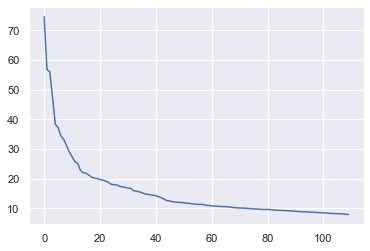

In [423]:
plt.plot(Sigma)

In [424]:
list_of_materials_topics = []
list_of_materials_topic_num_names = []

for index, component in enumerate(materials_tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].components_):
    zipped = zip(materials_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_materials_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_materials_topics.append(topic_materials_components)
    list_of_materials_topic_num_names.append("Materials topic "+str(index))
    print("Topic "+str(index)+": ",topic_materials_components) #top_terms_list, top_comp_list)

Topic 0:  ['stretched canvas(0.5)', 'canvas(0.49)', 'stretched(0.48)']
Topic 1:  ['oil(0.58)', 'oil canvas(0.49)', 'stretched canvas(-0.45)']
Topic 2:  ['paper(0.65)', 'watercolor(0.55)', 'paper watercolor(0.47)']
Topic 3:  ['acrylic(0.68)', 'acrylic canvas(0.52)', 'stretched canvas(-0.31)']
Topic 4:  ['canvas board(0.58)', 'board(0.56)', 'wood(-0.24)']
Topic 5:  ['wood(0.49)', 'hardboard wood(0.48)', 'hardboard(0.47)']
Topic 6:  ['blue(0.52)', 'blue canvas(0.47)', 'canvas stretched(0.31)']
Topic 7:  ['paper(0.64)', 'watercolor(-0.61)', 'acrylic canvas(-0.26)']
Topic 8:  ['acrylic stretched(0.55)', 'acrylic canvas(-0.52)', 'acrylic(0.36)']
Topic 9:  ['framed(0.5)', 'framed canvas(0.38)', 'oil framed(0.38)']
Topic 10:  ['stretched oil(0.6)', 'oil(-0.42)', 'framed(0.3)']
Topic 11:  ['fine(0.57)', 'canvas fine(0.34)', 'black(0.25)']
Topic 12:  ['fine(0.55)', 'canvas fine(0.39)', 'black(-0.32)']
Topic 13:  ['acrylic stretched(-0.66)', 'acrylic paper(0.37)', 'acrylic(0.32)']
Topic 14:  ['ha

In [425]:
#Which are the largest regression coefficients in the regression model?
feature_names_materials_ridge_tfidf = materials_tags_ridge_w_tfidf_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['materials tags tfidf']['to tfidf n-grams'].get_feature_names()

materials_ridge_SVD_reg_coeff_df = pd.DataFrame(materials_tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['ridge'].coef_,columns=['Regression coefficients'])
materials_ridge_SVD_reg_coeff_df['Topic']=pd.Series(list_of_materials_topics)
materials_ridge_SVD_reg_coeff_df = materials_ridge_SVD_reg_coeff_df.sort_values(by='Regression coefficients',ascending=False)
materials_ridge_SVD_reg_coeff_df.iloc[:10]

Regression coefficients                                              Topic
44                66.165767  [brush(0.54), canvas brush(0.5), canvas varnis...
35                60.457044  [texture(0.51), texture canvas(0.44), stretche...
56                58.837343  [canvas water(-0.55), wrapped(0.42), watercolo...
38                57.297660  [oil blue(0.44), acrylic blue(-0.41), acrylic ...
1                 57.248015  [oil(0.58), oil canvas(0.49), stretched canvas...
60                54.824054  [framed paper(-0.32), acrylic wood(0.3), oil p...
57                54.325184  [wrapped(0.33), canvas water(0.31), frame oil(...
54                51.905997  [wrapped(0.31), frame oil(0.25), stretched red...
53                50.235052  [canvas hand(-0.34), painted hand(0.28), hand ...
83                49.710598       [metal(0.6), red canvas(0.25), wooden(0.21)]

In [426]:
materials_ridge_SVD_reg_coeff_df.iloc[-10:]

Regression coefficients                                              Topic
62               -48.617409  [oil paper(0.45), yellow canvas(-0.4), yellow ...
46               -48.754744        [resin(0.49), blue paper(0.28), blue(0.27)]
81               -49.467666  [collage(0.58), collage paper(0.28), unframed(...
66               -52.109494  [yellow blue(0.29), blue canvas(0.24), oil pap...
32               -59.949260  [print(0.66), print canvas(0.36), framed paper...
77               -64.669612  [acrylic purple(-0.37), purple canvas(-0.33), ...
2                -73.742046  [paper(0.65), watercolor(0.55), paper watercol...
16               -79.909781     [hand(0.36), oil canvas(-0.34), painted(0.32)]
94               -80.073561  [fabric(0.32), paper black(-0.27), blue paper(...
36               -80.213720  [wood oil(0.4), canvas fine(0.4), paper fine(-...

### 5d) Decision tree of materials tags only, after Tf-Idf vectorization using up to bigrams, and with optional dimensionality reduction

In [427]:
from sklearn.pipeline import Pipeline

materials_dtree_w_tfidf_pipe = Pipeline([
    ('tags tfidf vectorization', materials_tags_tranform),
    ('dtree', DecisionTreeRegressor(max_depth=15)),
])

In [428]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,51,2)}  
materials_dtree_w_tfidf_CVmodel = GridSearchCV(materials_dtree_w_tfidf_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [429]:
materials_dtree_w_tfidf_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:  4.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tags tfidf vectorization',
                                        ColumnTransformer(transformers=[('materials '
                                                                         'tags '
                                                                         'tfidf',
                                                                         Pipeline(steps=[('to '
                                                                                          'single '
                                                                                          'string',
                                                                                          TagsEncoder()),
                                                                                         ('to '
                                                                                          'tfidf '
                                                                                          'n-grams',
                                                                                          TfidfVectorizer(ngram_range=(1,
                                                                                                                       2)))]),
                                                                         'materials_tags_new')])),
                                       ('dtree',
                                        DecisionTreeRegressor(max_depth=15))]),
             n_jobs=2, param_grid={'dtree__max_depth': range(2, 51, 2)},
             verbose=1)

In [430]:
materials_dtree_w_tfidf_CVmodel.best_params_['dtree__max_depth']

12

In [431]:
#Predict prices on training set:
prices_train_pred = materials_dtree_w_tfidf_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
materials_dtree_w_tfidf_CVmodel.score(paintings_df_train,prices_train)

0.10369720411496974

In [432]:
#Predict prices on test set:
prices_test_pred = materials_dtree_w_tfidf_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
materials_dtree_w_tfidf_CVmodel.score(paintings_df_test,prices_test)

0.07920354247094064

In [433]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using only materials tags, after Tf-Idf')


Decision Tree model using only materials tags, after Tf-Idf:
Training R^2: 0.10369720411496974
Testing R^2: 0.07920354247094064
Training RMSE: USD 133.27092113706712
Testing RMSE: USD 136.3997222050695
Training MAE: USD 105.92460347239437
Testing MAE: USD 108.49466556011544


In [434]:
#What are the style words or word combos that are used most by the tree regressor?
feature_names_materials_dtree_w_tfidf = materials_dtree_w_tfidf_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['materials tags tfidf']['to tfidf n-grams'].get_feature_names()

materials_dtree_w_tfidf_features_imp_df = pd.DataFrame(materials_dtree_w_tfidf_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_materials_dtree_w_tfidf,columns=['Dtree feature importance'])
materials_dtree_w_tfidf_features_imp_df = materials_dtree_w_tfidf_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
materials_dtree_w_tfidf_features_imp_df.iloc[:20]

Dtree feature importance
oil                               0.289656
paper                             0.059725
canvas                            0.040112
brush varnish                     0.039309
unframed                          0.037131
protective satin                  0.025351
stretched                         0.021911
texture                           0.021215
fine                              0.020711
acrylic                           0.020669
wrapped                           0.019593
wooden oil                        0.018111
watercolor                        0.017001
print canvas                      0.016309
love hanging                      0.015362
archival ink                      0.015273
black                             0.012527
acrylic pencil                    0.012239
framed                            0.012169
acrylic oil                       0.011875

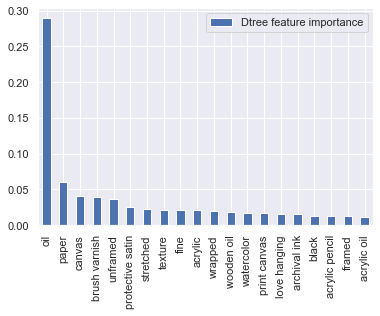

In [435]:
materials_dtree_w_tfidf_features_imp_df.iloc[:20].plot(kind="bar").legend(loc="upper right");

In [436]:
#Let's try with dimensionality reduction before computing the regressor
from sklearn.decomposition import TruncatedSVD

materials_dtree_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', materials_tags_tranform),
    ('SVD', TruncatedSVD(n_components=8)),
    ('dtree', DecisionTreeRegressor(max_depth=10))
])

In [437]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {'dtree__max_depth': range(2,12,2), 'SVD__n_components': range(2,82,4)} 
#materials_dtree_w_tfidf_SVD_CVmodel = RandomizedSearchCV(materials_dtree_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1, n_iter=20)
materials_dtree_w_tfidf_SVD_CVmodel = GridSearchCV(materials_dtree_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [438]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

materials_tags_SVD_dtree_CVmodel_filename = './Git_exclude/models/materials_tags_SVD_dtree_CVmodel.joblib'

#If the model file already exists, I load it:
try:
    with open(materials_tags_SVD_dtree_CVmodel_filename, 'rb') as f:
        materials_dtree_w_tfidf_SVD_CVmodel = load(f)
        print('Loaded joblib file with decision tree model for materials tags vectorized with tf-idf and reduced with SVD.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    materials_dtree_w_tfidf_SVD_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(materials_tags_SVD_dtree_CVmodel_filename, 'wb') as f:
        dump(materials_dtree_w_tfidf_SVD_CVmodel, materials_tags_SVD_dtree_CVmodel_filename) 
        print('Saved joblib file with decision tree model for materials tags vectorized with tf-idf and reduced with SVD.')

Loaded joblib file with decision tree model for materials tags vectorized with tf-idf and reduced with SVD.


In [439]:
materials_dtree_w_tfidf_SVD_CVmodel.best_params_

{'SVD__n_components': 78, 'dtree__max_depth': 6}

In [440]:
#Predict prices on training set:
prices_train_pred = materials_dtree_w_tfidf_SVD_CVmodel.predict(paintings_df_train)

In [441]:
#And return the R2 score as follows:
materials_dtree_w_tfidf_SVD_CVmodel.score(paintings_df_train,prices_train)

0.07464244317612234

In [442]:
#Predict prices on test set:
prices_test_pred = materials_dtree_w_tfidf_SVD_CVmodel.predict(paintings_df_test)

In [443]:
#And return the R2 score as follows:
materials_dtree_w_tfidf_SVD_CVmodel.score(paintings_df_test,prices_test)

0.06266127596970805

In [444]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision tree model using vectorized materials tags with Tf-Idf followed by SVD')

Decision tree model using vectorized materials tags with Tf-Idf followed by SVD:
Training R^2: 0.07464244317612234
Testing R^2: 0.06266127596970805
Training RMSE: USD 135.41376457128874
Testing RMSE: USD 137.61949047237508
Training MAE: USD 108.54614824816097
Testing MAE: USD 110.31852634998295


In [445]:
#Let's check what the SVD components, often interpreted as 'topics' are:

In [446]:
materials_feature_names = materials_dtree_w_tfidf_SVD_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['materials tags tfidf']['to tfidf n-grams'].get_feature_names()

In [447]:
# Get Singular values and Components 
Sigma = materials_dtree_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].singular_values_ 
Sigma

array([74.62903647, 56.75411002, 56.12456568, 47.3584639 , 38.33607099,
       37.25485855, 34.38751278, 33.2679579 , 31.16833094, 29.05622361,
       27.41667218, 25.71524015, 25.13962701, 22.74444095, 21.96227318,
       21.86542125, 21.20313841, 20.4536749 , 20.23193354, 20.03108468,
       19.70925731, 19.55281082, 19.16115187, 18.76394095, 18.07800215,
       17.97065841, 17.91053548, 17.43823758, 17.23589267, 17.07053233,
       16.80636838, 16.7749185 , 15.96684361, 15.74563111, 15.57780656,
       15.25877827, 14.87077019, 14.70664071, 14.5432014 , 14.40122805,
       14.24784607, 13.93651182, 13.54482326, 13.07493357, 12.57352242,
       12.47641463, 12.20862452, 12.16031861, 11.9993008 , 11.9591345 ,
       11.86397063, 11.69509961, 11.69113743, 11.49287544, 11.41592993,
       11.32273101, 11.31279532, 11.24457511, 10.98109143, 10.92990858,
       10.7670866 , 10.72704171, 10.66427718, 10.5901651 , 10.54443776,
       10.48389449, 10.4441773 , 10.32220832, 10.11120205, 10.06

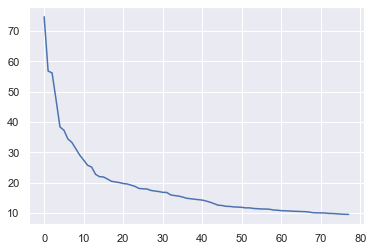

In [448]:
plt.plot(Sigma)

In [449]:
list_of_materials_topics = []
list_of_materials_topic_num_names = []

for index, component in enumerate(materials_dtree_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].components_):
    zipped = zip(materials_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_materials_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_materials_topics.append(topic_materials_components)
    list_of_materials_topic_num_names.append("Materials topic "+str(index))
    print("Topic "+str(index)+": ",topic_materials_components) #top_terms_list, top_comp_list)

Topic 0:  ['stretched canvas(0.5)', 'canvas(0.49)', 'stretched(0.48)']
Topic 1:  ['oil(0.58)', 'oil canvas(0.49)', 'stretched canvas(-0.45)']
Topic 2:  ['paper(0.65)', 'watercolor(0.55)', 'paper watercolor(0.47)']
Topic 3:  ['acrylic(0.68)', 'acrylic canvas(0.52)', 'stretched canvas(-0.31)']
Topic 4:  ['canvas board(0.58)', 'board(0.56)', 'wood(-0.24)']
Topic 5:  ['wood(0.49)', 'hardboard wood(0.48)', 'hardboard(0.47)']
Topic 6:  ['blue(0.52)', 'blue canvas(0.47)', 'canvas stretched(0.31)']
Topic 7:  ['paper(0.64)', 'watercolor(-0.61)', 'acrylic canvas(-0.26)']
Topic 8:  ['acrylic stretched(0.55)', 'acrylic canvas(-0.52)', 'acrylic(0.36)']
Topic 9:  ['framed(0.5)', 'framed canvas(0.38)', 'oil framed(0.38)']
Topic 10:  ['stretched oil(0.6)', 'oil(-0.42)', 'framed(0.3)']
Topic 11:  ['fine(0.57)', 'canvas fine(0.34)', 'black(0.25)']
Topic 12:  ['fine(0.55)', 'canvas fine(0.39)', 'black(-0.32)']
Topic 13:  ['acrylic stretched(-0.66)', 'acrylic paper(0.37)', 'acrylic(0.32)']
Topic 14:  ['ha

In [450]:
#Which are the most predictive 'topics' in the decision tree?

In [451]:
#What are the style words or word combos that are used most by the tree regressor?
materials_dtree_w_tfidf_SVD_features_imp_df = pd.DataFrame(materials_dtree_w_tfidf_SVD_CVmodel.best_estimator_['dtree'].feature_importances_,columns=['Dtree feature importance'])
materials_dtree_w_tfidf_SVD_features_imp_df['Topic']=pd.Series(list_of_materials_topics)
materials_dtree_w_tfidf_SVD_features_imp_df = materials_dtree_w_tfidf_SVD_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
materials_dtree_w_tfidf_SVD_features_imp_df.iloc[:20]

Dtree feature importance  \
2                   0.415338   
0                   0.056476   
10                  0.048781   
55                  0.045235   
76                  0.044138   
18                  0.038021   
35                  0.026814   
44                  0.025533   
19                  0.022793   
3                   0.022727   
8                   0.021903   
75                  0.021714   
48                  0.018909   
14                  0.017209   
5                   0.015876   
56                  0.014001   
42                  0.012949   
67                  0.012667   
4                   0.010914   
13                  0.010818   

                                                Topic  
2   [paper(0.65), watercolor(0.55), paper watercol...  
0   [stretched canvas(0.5), canvas(0.49), stretche...  
10      [stretched oil(0.6), oil(-0.42), framed(0.3)]  
55  [canvas water(0.39), white canvas(0.35), stret...  
76    [unframed(0.36), collage(-0.24), gouache(-0.2)]  
18   [mixed(0.43), media(0.43), acrylic paper(-0.31)]  
35  [texture(0.51), texture canvas(0.44), stretche...  
44  [brush(0.54), canvas brush(0.5), canvas varnis...  
19         [knife(0.38), green(-0.38), palette(0.37)]  
3   [acrylic(0.68), acrylic canvas(0.52), stretche...  
8   [acrylic stretched(0.55), acrylic canvas(-0.52...  
75  [acrylic purple(0.31), wooden(0.29), canvas pu...  
48       [resin(0.5), hang(-0.33), blue paper(-0.22)]  
14  [hand(0.38), painted(0.33), canvas stretched(-...  
5   [wood(0.49), hardboard wood(0.48), hardboard(0...  
56  [wrapped(0.48), canvas water(-0.43), acrylic w...  
42  [acrylic oil(0.61), oil blue(-0.4), acrylic bl...  
67  [oil fine(0.35), stretched fine(-0.34), glass(...  
4      [canvas board(0.58), board(0.56), wood(-0.24)]  
13  [acrylic stretched(-0.66), acrylic paper(0.37)...

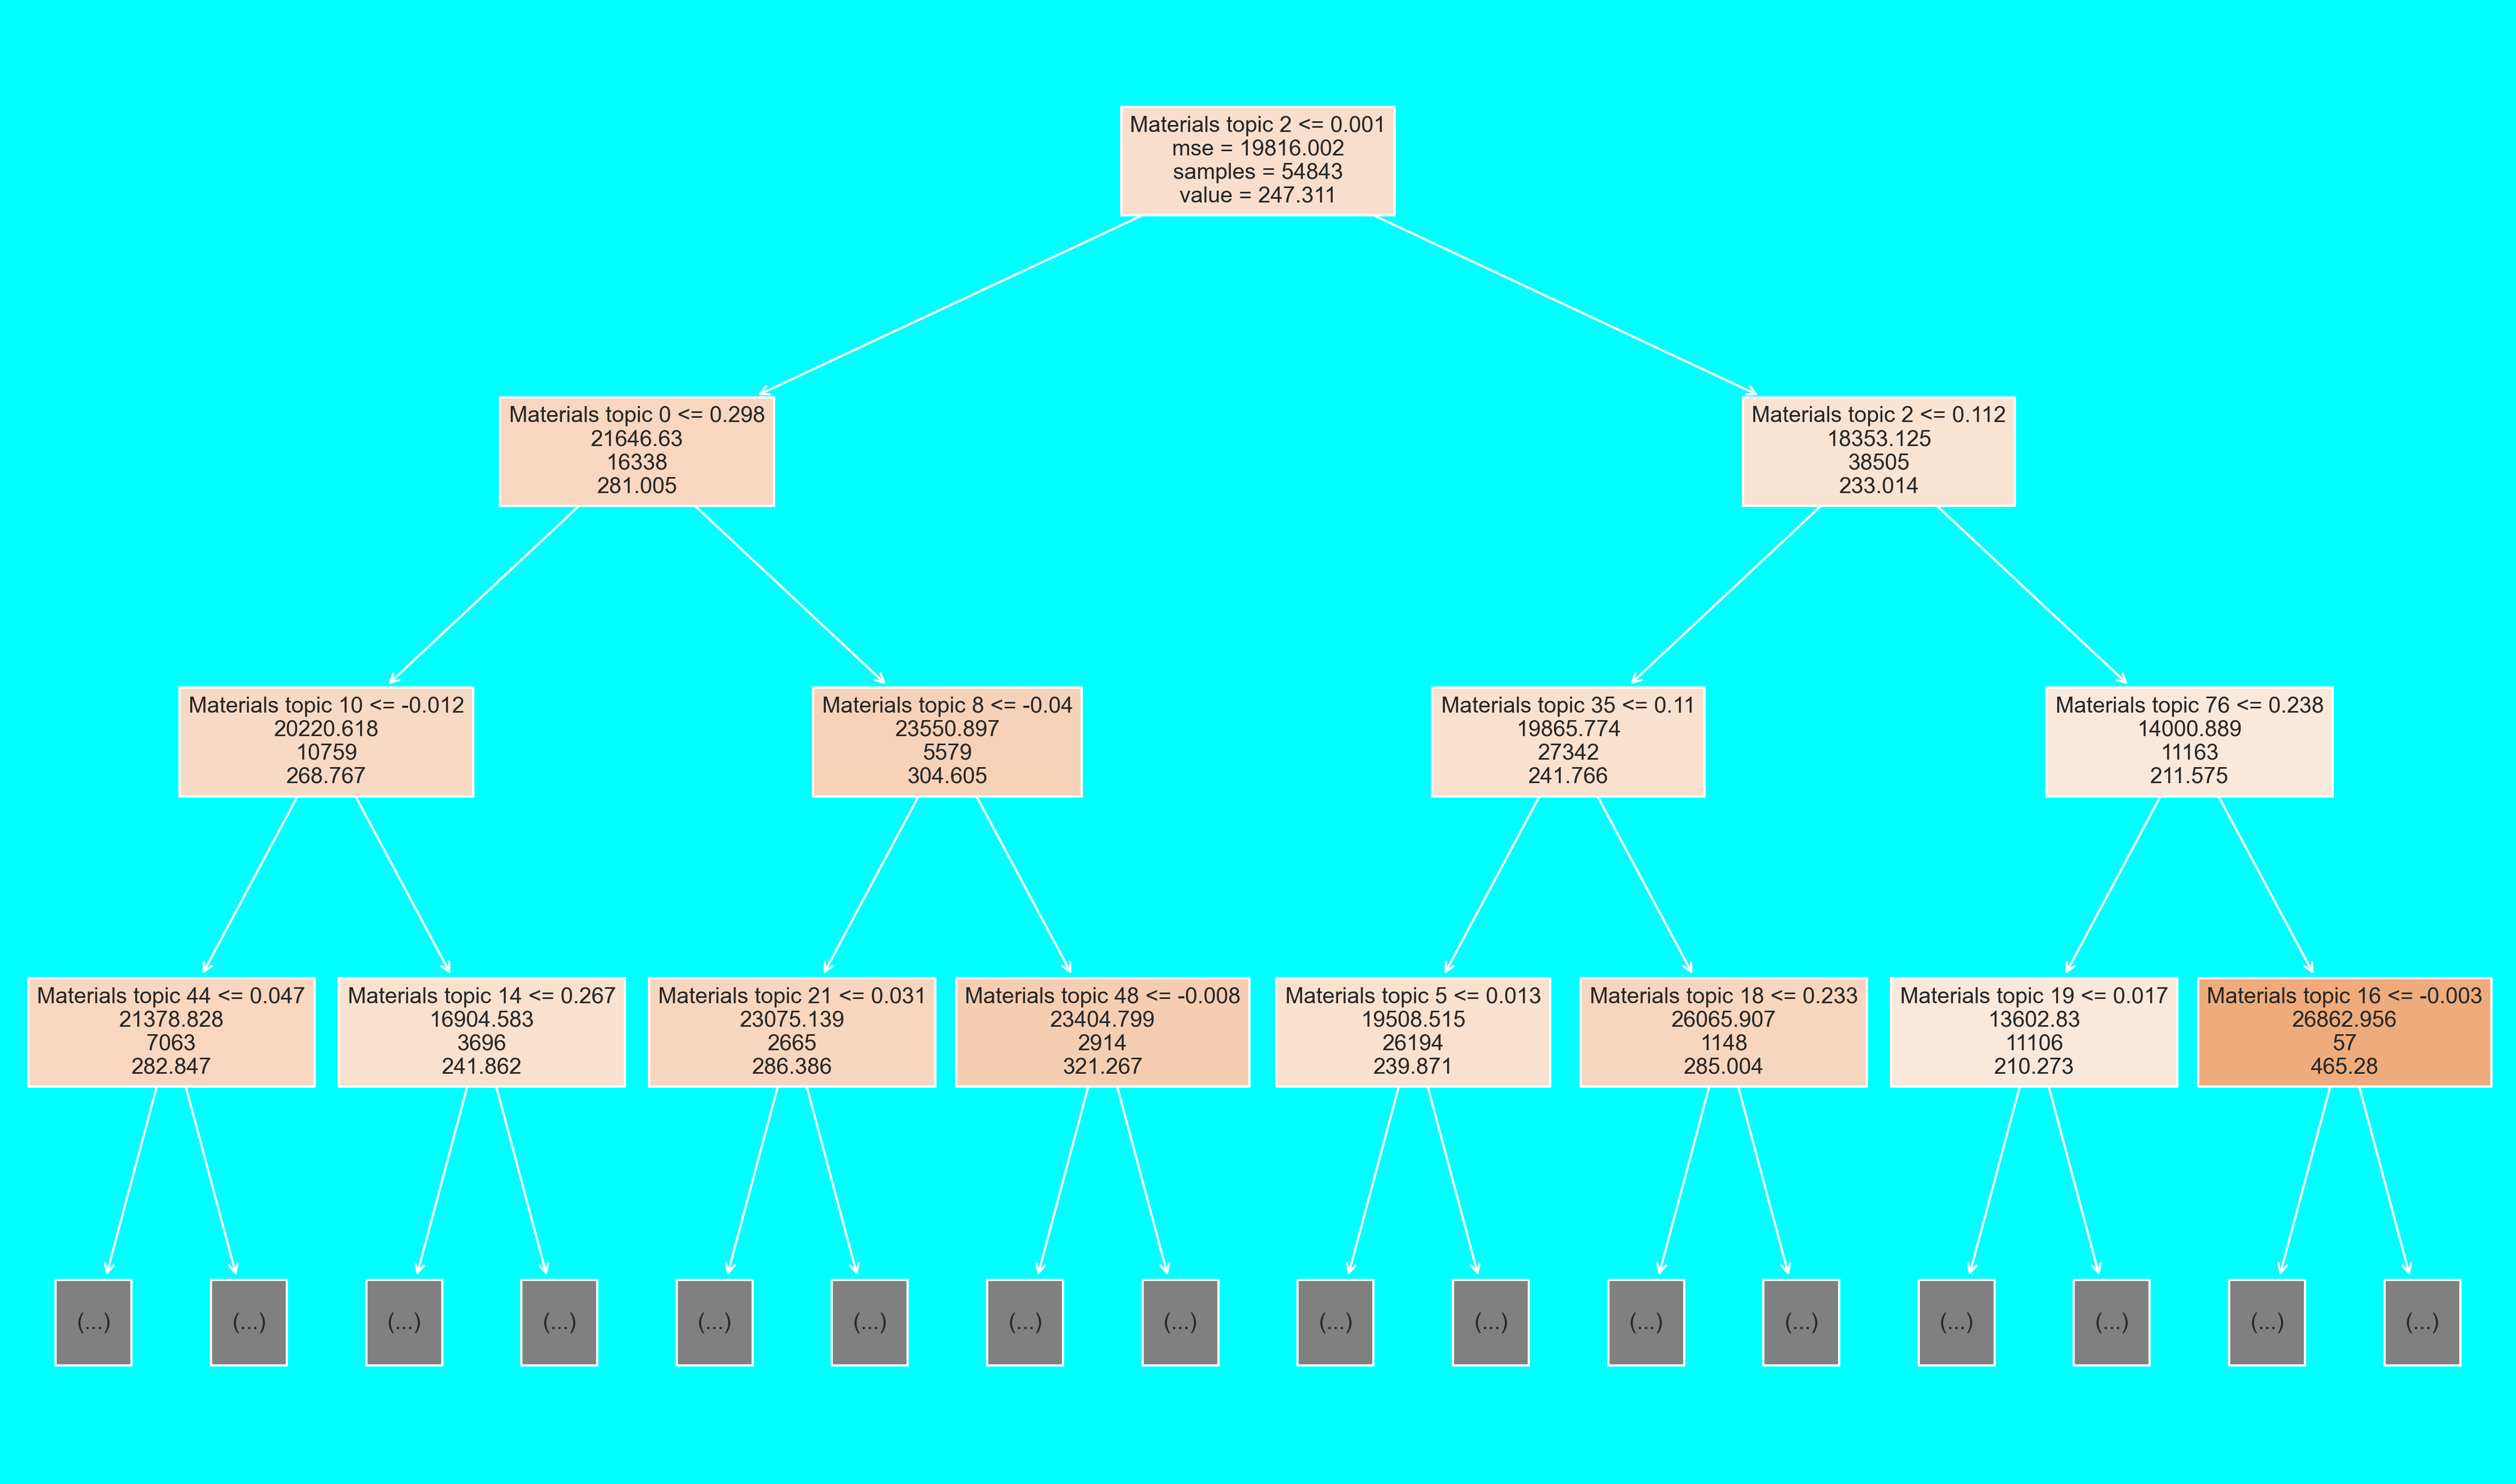

In [452]:
# Generate a plot of the decision tree
#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,12), dpi=300)
fig = plt.figure(figsize=(20,12), dpi=300)
fig.set_facecolor("cyan")
tree_viz = plot_tree(materials_dtree_w_tfidf_SVD_CVmodel.best_estimator_['dtree'],max_depth=3,fontsize=10,label='root',filled=True,feature_names = list_of_materials_topic_num_names)
fig.savefig('./Git_exclude/Figures/decision_tree_materials_tags_after_tfidf_SVD.png')

#### Model 5e) Random Forest on Materials Tags (vectorized, but without Tf-Idf vectorization or SVD reduction)

In [453]:
from sklearn.ensemble import RandomForestRegressor

In [454]:
materials_rforest_pipe = Pipeline([
    ('materials tags vectorization', materials_tranform),
    ('rforest', RandomForestRegressor(n_estimators=100,max_features='sqrt',n_jobs=2,max_depth=materials_dtree_CVmodel.best_params_['dtree__max_depth']+1,random_state=1,max_samples=0.8))
])

In [455]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

materials_rforest_pipe_filename = './Git_exclude/models/materials_rforest_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(materials_rforest_pipe_filename, 'rb') as f:
        materials_rforest_pipe = load(f)
        print('Loaded joblib file with random forest model for materials tags (without Tf-Idf).')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    materials_rforest_pipe.fit(paintings_df_train,prices_train)
    
    with open(materials_rforest_pipe_filename, 'wb') as f:
        dump(materials_rforest_pipe, materials_rforest_pipe_filename) 
        print('Saved joblib file with random forest model for materials tags (without Tf-Idf).')

Loaded joblib file with random forest model for materials tags (without Tf-Idf).


In [456]:
#Predict prices on training set:
prices_train_pred = materials_rforest_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
materials_rforest_pipe.score(paintings_df_train,prices_train)

0.07207475722798196

In [457]:
#Predict prices on test set:
prices_test_pred = materials_rforest_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
materials_rforest_pipe.score(paintings_df_test,prices_test)

0.07009513780490206

In [458]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using materials tags (without Tf-Idf)')


Random Forest model using materials tags (without Tf-Idf):
Training R^2: 0.07207475722798196
Testing R^2: 0.07009513780490206
Training RMSE: USD 135.6015077588345
Testing RMSE: USD 137.07268667058548
Training MAE: USD 109.50301882997768
Testing MAE: USD 110.69540217760601


In [459]:
feature_names_materials_rforest = materials_rforest_pipe['materials tags vectorization'].named_transformers_['materials tags vectorizer'][-1].get_feature_names()

In [460]:
feature_names_materials_rforest

['140',
 'acid',
 'acrylic',
 'acrylics',
 'aluminum',
 'arches',
 'archival',
 'birch',
 'black',
 'blue',
 'board',
 'brush',
 'brushes',
 'canvas',
 'cardboard',
 'charcoal',
 'clear',
 'cold',
 'collage',
 'cotton',
 'epoxy',
 'fabric',
 'fine',
 'finish',
 'floetrol',
 'frame',
 'framed',
 'gel',
 'gesso',
 'glass',
 'glitter',
 'gloss',
 'gold',
 'golden',
 'gouache',
 'grade',
 'graphite',
 'green',
 'hand',
 'hang',
 'hanger',
 'hanging',
 'hardboard',
 'hardware',
 'heavy',
 'ink',
 'knife',
 'lb',
 'leaf',
 'linen',
 'liquitex',
 'love',
 'marker',
 'mat',
 'matte',
 'media',
 'metal',
 'metallic',
 'mixed',
 'newton',
 'oil',
 'oils',
 'painted',
 'palette',
 'panel',
 'paper',
 'paste',
 'pastel',
 'pen',
 'pencil',
 'pigment',
 'pigments',
 'premium',
 'press',
 'pressed',
 'print',
 'protective',
 'purple',
 'red',
 'resin',
 'satin',
 'spray',
 'stretched',
 'stretcher',
 'texture',
 'thick',
 'unframed',
 'uv',
 'varnish',
 'water',
 'watercolor',
 'watercolors',
 'whit

In [461]:
materials_rforest_features_imp_df = pd.DataFrame(materials_rforest_pipe['rforest'].feature_importances_,feature_names_materials_rforest,columns=['Rforest feature importance'])
materials_rforest_features_imp_df = materials_rforest_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
materials_rforest_features_imp_df

Rforest feature importance
oil                           0.236185
paper                         0.093380
watercolor                    0.057297
canvas                        0.056596
acrylic                       0.041394
...                                ...
aluminum                      0.000827
fabric                        0.000568
premium                       0.000415
140                           0.000390
liquitex                      0.000257

[100 rows x 1 columns]

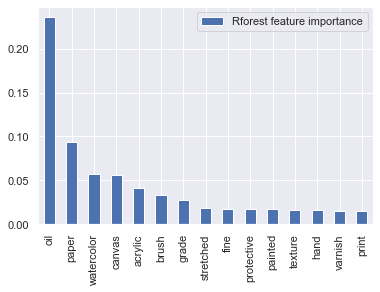

In [462]:
materials_rforest_features_imp_df.iloc[:15].plot(kind="bar").legend(loc="upper right");

#### Model 5f) Random Forest on Materials Tags, after Tf-Idf vectorization (with bigrams) and SVD reduction

In [463]:
from sklearn.ensemble import RandomForestRegressor

In [464]:
from sklearn.decomposition import TruncatedSVD

materials_rforest_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', materials_tags_tranform),
    ('SVD', TruncatedSVD(n_components=40)),
    ('rforest', RandomForestRegressor(n_estimators=100,max_features='sqrt',n_jobs=2,max_depth=materials_dtree_w_tfidf_SVD_CVmodel.best_params_['dtree__max_depth']+1,random_state=1,max_samples=0.8))
])

In [465]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

materials_rforest_w_tfidf_SVD_pipe_filename = './Git_exclude/models/materials_rforest_w_tfidf_SVD_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(materials_rforest_w_tfidf_SVD_pipe_filename, 'rb') as f:
        materials_rforest_w_tfidf_SVD_pipe = load(f)
        print('Loaded joblib file with random forest model for materials tags (after Tf-Idf and SVD).')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    materials_rforest_w_tfidf_SVD_pipe.fit(paintings_df_train,prices_train)
    
    with open(materials_rforest_w_tfidf_SVD_pipe_filename, 'wb') as f:
        dump(materials_rforest_w_tfidf_SVD_pipe, materials_rforest_w_tfidf_SVD_pipe_filename) 
        print('Saved joblib file with random forest model for materials tags (after Tf-Idf and SVD).')

Loaded joblib file with random forest model for materials tags (after Tf-Idf and SVD).


In [466]:
#Predict prices on training set:
prices_train_pred = materials_rforest_w_tfidf_SVD_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
materials_rforest_w_tfidf_SVD_pipe.score(paintings_df_train,prices_train)

0.08362516674737652

In [467]:
#Predict prices on test set:
prices_test_pred = materials_rforest_w_tfidf_SVD_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
materials_rforest_w_tfidf_SVD_pipe.score(paintings_df_test,prices_test)

0.07338537123006339

In [468]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using materials tags (after Tf-Idf and SVD reduction)')


Random Forest model using materials tags (after Tf-Idf and SVD reduction):
Training R^2: 0.08362516674737652
Testing R^2: 0.07338537123006339
Training RMSE: USD 134.75491071889388
Testing RMSE: USD 136.82997324933027
Training MAE: USD 108.62421892395324
Testing MAE: USD 110.35027165666312


In [469]:
#what are the main features used for decision?
materials_rforest_w_tfidf_SVD_pipe['rforest'].feature_importances_

array([0.06497759, 0.10498086, 0.13183708, 0.02871637, 0.03158433,
       0.03196924, 0.01240887, 0.0375372 , 0.01338581, 0.01783799,
       0.06028344, 0.02157927, 0.02113425, 0.01198677, 0.01476504,
       0.01701254, 0.02365272, 0.01642177, 0.02041625, 0.01410316,
       0.0093484 , 0.01665522, 0.01404187, 0.01742823, 0.01332539,
       0.01014155, 0.01178504, 0.01318441, 0.01236133, 0.00994122,
       0.01954305, 0.01592592, 0.01608083, 0.01115699, 0.01112785,
       0.02674993, 0.02155944, 0.01510412, 0.01295694, 0.02499173])

In [470]:
list_of_materials_topics = []
list_of_materials_topic_num_names = []

for index, component in enumerate(materials_rforest_w_tfidf_SVD_pipe['SVD'].components_):
    zipped = zip(materials_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_materials_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_materials_topics.append(topic_materials_components)
    list_of_materials_topic_num_names.append("Materials topic "+str(index))
    #print("Topic "+str(index)+": ",topic_materials_components) #top_terms_list, top_comp_list)

In [471]:
#What are the style words or word combos that are used most by the random forest regressor?
materials_rforest_w_tfidf_SVD_features_imp_df = pd.DataFrame(materials_rforest_w_tfidf_SVD_pipe['rforest'].feature_importances_,columns=['Rforest feature importance'])
materials_rforest_w_tfidf_SVD_features_imp_df['Topic']=pd.Series(list_of_materials_topics)
materials_rforest_w_tfidf_SVD_features_imp_df = materials_rforest_w_tfidf_SVD_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
materials_rforest_w_tfidf_SVD_features_imp_df.iloc[:20]

Rforest feature importance  \
2                     0.131837   
1                     0.104981   
0                     0.064978   
10                    0.060283   
7                     0.037537   
5                     0.031969   
4                     0.031584   
3                     0.028716   
35                    0.026750   
39                    0.024992   
16                    0.023653   
11                    0.021579   
36                    0.021559   
12                    0.021134   
18                    0.020416   
30                    0.019543   
9                     0.017838   
23                    0.017428   
15                    0.017013   
21                    0.016655   

                                                Topic  
2   [paper(0.65), watercolor(0.55), paper watercol...  
1   [oil(0.58), oil canvas(0.49), stretched canvas...  
0   [stretched canvas(0.5), canvas(0.49), stretche...  
10      [stretched oil(0.6), oil(-0.42), framed(0.3)]  
7   [paper(0.64), watercolor(-0.61), acrylic canva...  
5   [wood(0.49), hardboard wood(0.48), hardboard(0...  
4      [canvas board(0.58), board(0.56), wood(-0.24)]  
3   [acrylic(0.68), acrylic canvas(0.52), stretche...  
35  [texture(0.51), texture canvas(0.44), stretche...  
39  [varnish(0.42), texture(-0.34), texture canvas...  
16     [hand(0.36), oil canvas(-0.34), painted(0.32)]  
11       [fine(0.57), canvas fine(0.34), black(0.25)]  
36  [wood oil(0.41), canvas fine(0.36), acrylic oi...  
12      [fine(0.55), canvas fine(0.39), black(-0.32)]  
18   [mixed(0.43), media(0.43), acrylic paper(-0.31)]  
30       [purple(0.61), ink(-0.47), ink paper(-0.37)]  
9   [framed(0.5), framed canvas(0.38), oil framed(...  
23  [frame(0.47), canvas stretched(0.31), frame oi...  
15         [oil canvas(-0.4), oil(0.31), black(0.31)]  
21  [paper watercolor(-0.48), red(-0.33), watercol...

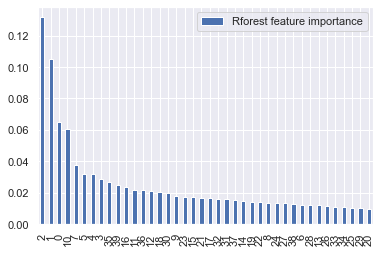

In [472]:
materials_rforest_w_tfidf_SVD_features_imp_df.plot(kind="bar").legend(loc="upper right");

#### Model 5g) Gradient Boosted Trees on Materials Tags (vectorized, without Tf-Idf and SVD reduction)

In [473]:
from sklearn.ensemble import GradientBoostingRegressor

In [474]:
materials_gboost_pipe = Pipeline([
    ('materials tags vectorization', materials_tranform),
    ('gboost', GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,subsample=0.5,max_depth=materials_dtree_w_tfidf_SVD_CVmodel.best_params_['dtree__max_depth']-3,random_state=1))
])

In [475]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

materials_gboost_pipe_filename = './Git_exclude/models/materials_gboost_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(materials_gboost_pipe_filename, 'rb') as f:
        materials_gboost_pipe = load(f)
        print('Loaded joblib file with gradient boosting model for materials tags (without Tf-Idf and SVD).')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    materials_gboost_pipe.fit(paintings_df_train,prices_train)
    
    with open(materials_gboost_pipe_filename, 'wb') as f:
        dump(materials_gboost_pipe, materials_gboost_pipe_filename) 
        print('Saved joblib file with gradient boosting model for materials tags (without Tf-Idf and SVD).')

Loaded joblib file with gradient boosting model for materials tags (without Tf-Idf and SVD).


In [476]:
#Predict prices on training set:
prices_train_pred = materials_gboost_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
materials_gboost_pipe.score(paintings_df_train,prices_train)

0.07633845671866346

In [477]:
#Predict prices on test set:
prices_test_pred = materials_gboost_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
materials_gboost_pipe.score(paintings_df_test,prices_test)

0.07679394027591291

In [478]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosting model using materials tags (without Tf-Idf and SVD reduction)')


Gradient Boosting model using materials tags (without Tf-Idf and SVD reduction):
Training R^2: 0.07633845671866346
Testing R^2: 0.07679394027591291
Training RMSE: USD 135.2896131519839
Testing RMSE: USD 136.57807559000145
Training MAE: USD 108.8541140582012
Testing MAE: USD 109.85568813008285


In [479]:
#what are the main features used for decision?
materials_gboost_pipe['gboost'].feature_importances_

array([0.00000000e+00, 1.54126634e-03, 3.02614236e-02, 3.29100935e-03,
       0.00000000e+00, 5.30303846e-03, 7.79069837e-03, 3.20621010e-03,
       1.37189085e-02, 6.95488595e-04, 8.73587824e-03, 4.12118415e-02,
       4.40831891e-03, 3.35454439e-02, 4.44921184e-03, 1.25293161e-03,
       1.38964352e-04, 4.95364687e-03, 1.24834014e-03, 2.04495386e-03,
       5.08727968e-03, 4.99426380e-04, 2.49748849e-02, 1.27912514e-03,
       2.32950797e-03, 8.28344777e-03, 8.01988874e-03, 1.20227648e-03,
       5.24445192e-03, 2.41096203e-03, 1.30401183e-03, 2.16429773e-03,
       2.53369464e-03, 7.97342982e-04, 3.26878844e-04, 5.59870729e-03,
       8.05064247e-04, 3.34584225e-03, 1.82362772e-02, 3.71376021e-03,
       4.98156555e-04, 7.68206841e-03, 9.37814690e-04, 4.99713518e-04,
       1.62413558e-03, 4.16368727e-03, 3.05968291e-03, 2.11474559e-03,
       1.08793145e-02, 8.30773666e-03, 4.82639957e-04, 5.94881353e-03,
       6.78480972e-04, 4.64748561e-04, 6.24876817e-04, 7.89716160e-03,
      

In [480]:
feature_names_materials_gboost = materials_gboost_pipe['materials tags vectorization'].named_transformers_['materials tags vectorizer'][-1].get_feature_names()

In [481]:
feature_names_materials_gboost

['140',
 'acid',
 'acrylic',
 'acrylics',
 'aluminum',
 'arches',
 'archival',
 'birch',
 'black',
 'blue',
 'board',
 'brush',
 'brushes',
 'canvas',
 'cardboard',
 'charcoal',
 'clear',
 'cold',
 'collage',
 'cotton',
 'epoxy',
 'fabric',
 'fine',
 'finish',
 'floetrol',
 'frame',
 'framed',
 'gel',
 'gesso',
 'glass',
 'glitter',
 'gloss',
 'gold',
 'golden',
 'gouache',
 'grade',
 'graphite',
 'green',
 'hand',
 'hang',
 'hanger',
 'hanging',
 'hardboard',
 'hardware',
 'heavy',
 'ink',
 'knife',
 'lb',
 'leaf',
 'linen',
 'liquitex',
 'love',
 'marker',
 'mat',
 'matte',
 'media',
 'metal',
 'metallic',
 'mixed',
 'newton',
 'oil',
 'oils',
 'painted',
 'palette',
 'panel',
 'paper',
 'paste',
 'pastel',
 'pen',
 'pencil',
 'pigment',
 'pigments',
 'premium',
 'press',
 'pressed',
 'print',
 'protective',
 'purple',
 'red',
 'resin',
 'satin',
 'spray',
 'stretched',
 'stretcher',
 'texture',
 'thick',
 'unframed',
 'uv',
 'varnish',
 'water',
 'watercolor',
 'watercolors',
 'whit

In [482]:
materials_gboost_features_imp_df = pd.DataFrame(materials_gboost_pipe['gboost'].feature_importances_,feature_names_materials_gboost,columns=['Gboost feature importance'])
materials_gboost_features_imp_df = materials_gboost_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
materials_gboost_features_imp_df

Gboost feature importance
oil                        0.317509
paper                      0.055844
brush                      0.041212
canvas                     0.033545
acrylic                    0.030261
...                             ...
clear                      0.000139
premium                    0.000000
newton                     0.000000
aluminum                   0.000000
140                        0.000000

[100 rows x 1 columns]

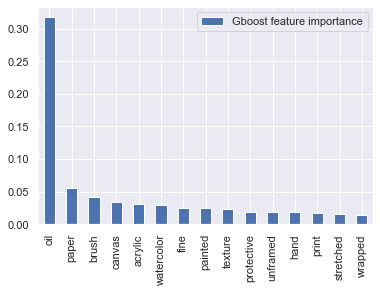

In [483]:
materials_gboost_features_imp_df.iloc[:15].plot(kind="bar").legend(loc="upper right");

#### Model 5h) Gradient Boosted Trees on Materials Tags, after Tf-Idf vectorization (with bigrams) and SVD reduction

In [484]:
from sklearn.ensemble import GradientBoostingRegressor

In [485]:
from sklearn.decomposition import TruncatedSVD

materials_gboost_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', materials_tags_tranform),
    ('SVD', TruncatedSVD(n_components=40)),
    ('gboost', GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,subsample=0.5,max_depth=materials_dtree_w_tfidf_SVD_CVmodel.best_params_['dtree__max_depth']-3,random_state=1))
])

In [486]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

materials_gboost_w_tfidf_SVD_pipe_filename = './Git_exclude/models/materials_gboost_w_tfidf_SVD_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(materials_gboost_w_tfidf_SVD_pipe_filename, 'rb') as f:
        materials_gboost_w_tfidf_SVD_pipe = load(f)
        print('Loaded joblib file with gradient boosting model for materials tags (after Tf-Idf and SVD).')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    materials_gboost_w_tfidf_SVD_pipe.fit(paintings_df_train,prices_train)
    
    with open(materials_gboost_w_tfidf_SVD_pipe_filename, 'wb') as f:
        dump(materials_gboost_w_tfidf_SVD_pipe, materials_gboost_w_tfidf_SVD_pipe_filename) 
        print('Saved joblib file with gradient boosting model for materials tags (after Tf-Idf and SVD).')

Loaded joblib file with gradient boosting model for materials tags (after Tf-Idf and SVD).


In [487]:
#Predict prices on training set:
prices_train_pred = materials_gboost_w_tfidf_SVD_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
materials_gboost_w_tfidf_SVD_pipe.score(paintings_df_train,prices_train)

0.08180591905560786

In [488]:
#Predict prices on test set:
prices_test_pred = materials_gboost_w_tfidf_SVD_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
materials_gboost_w_tfidf_SVD_pipe.score(paintings_df_test,prices_test)

0.07636155298369107

In [489]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosting model using materials tags (after Tf-Idf and SVD reduction)')


Gradient Boosting model using materials tags (after Tf-Idf and SVD reduction):
Training R^2: 0.08180591905560786
Testing R^2: 0.07636155298369107
Training RMSE: USD 134.88860655970169
Testing RMSE: USD 136.61005529304825
Training MAE: USD 108.43258916217138
Testing MAE: USD 109.90580628345572


In [490]:
#what are the main features used for decision?
materials_gboost_w_tfidf_SVD_pipe['gboost'].feature_importances_

array([0.04371623, 0.0151312 , 0.28945651, 0.01127316, 0.0355617 ,
       0.01732711, 0.01424927, 0.01183217, 0.01012907, 0.01651503,
       0.04709258, 0.02929645, 0.01063946, 0.00689114, 0.01588094,
       0.00893647, 0.02802473, 0.01102498, 0.03309323, 0.01638481,
       0.01411808, 0.0052735 , 0.01399181, 0.01206764, 0.0065719 ,
       0.00784857, 0.0116584 , 0.01717534, 0.01527497, 0.01830187,
       0.01974124, 0.00812055, 0.02330533, 0.0058916 , 0.01380495,
       0.05025665, 0.01343815, 0.02933453, 0.01177735, 0.02959133])

In [732]:
list_of_materials_topics = []
list_of_materials_topic_num_names = []

for index, component in enumerate(materials_gboost_w_tfidf_SVD_pipe['SVD'].components_):
    zipped = zip(materials_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_materials_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_materials_topics.append(topic_materials_components)
    list_of_materials_topic_num_names.append("Materials topic "+str(index))
    #print("Topic "+str(index)+": ",topic_materials_components) #top_terms_list, top_comp_list)

In [492]:
#What are the materials words or word combos that are used most by the gradient boosted trees?
materials_gboost_w_tfidf_SVD_features_imp_df = pd.DataFrame(materials_gboost_w_tfidf_SVD_pipe['gboost'].feature_importances_,columns=['Gboost feature importance'])
materials_gboost_w_tfidf_SVD_features_imp_df['Topic']=pd.Series(list_of_materials_topics)
materials_gboost_w_tfidf_SVD_features_imp_df = materials_gboost_w_tfidf_SVD_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
materials_gboost_w_tfidf_SVD_features_imp_df.iloc[:20]

Gboost feature importance  \
2                    0.289457   
35                   0.050257   
10                   0.047093   
0                    0.043716   
4                    0.035562   
18                   0.033093   
39                   0.029591   
37                   0.029335   
11                   0.029296   
16                   0.028025   
32                   0.023305   
30                   0.019741   
29                   0.018302   
5                    0.017327   
27                   0.017175   
9                    0.016515   
19                   0.016385   
14                   0.015881   
28                   0.015275   
1                    0.015131   

                                                Topic  
2   [paper(0.65), watercolor(0.55), paper watercol...  
35  [texture(0.52), texture canvas(0.44), stretche...  
10      [stretched oil(0.6), oil(-0.42), framed(0.3)]  
0   [stretched canvas(0.5), canvas(0.49), stretche...  
4      [canvas board(0.58), board(0.56), wood(-0.24)]  
18   [mixed(0.43), media(0.43), acrylic paper(-0.31)]  
39  [varnish(0.4), texture(-0.32), texture canvas(...  
37  [canvas fine(0.46), paper fine(-0.39), panel(0...  
11       [fine(0.57), canvas fine(0.34), black(0.25)]  
16     [hand(0.36), oil canvas(-0.34), painted(0.32)]  
32  [print(0.66), print canvas(0.36), framed paper...  
30       [purple(0.63), ink(-0.44), ink paper(-0.34)]  
29     [gold(0.67), acrylic gold(0.29), purple(0.28)]  
5   [wood(0.49), hardboard wood(0.48), hardboard(0...  
27  [hanging(0.72), canvas hanging(0.58), hanging ...  
9   [framed(0.5), framed canvas(0.38), oil framed(...  
19         [knife(0.38), green(-0.38), palette(0.37)]  
14  [hand(0.38), painted(0.33), canvas stretched(-...  
28   [white(0.59), black(-0.39), acrylic white(0.35)]  
1   [oil(0.58), oil canvas(0.49), stretched canvas...

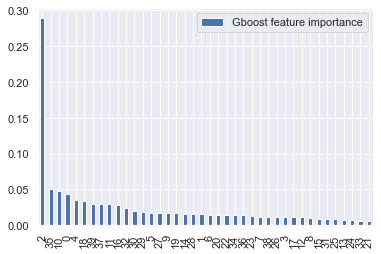

In [493]:
materials_gboost_w_tfidf_SVD_features_imp_df.plot(kind="bar").legend(loc="upper right");

## 6) Models using the other generic tags that were neither identified as 'style' nor as 'materials' tags

#### Because these 'generic' tags can contain all kinds of words (from a large vocabulary, and there can be many tags on any listing) I certainly need  traditional NLP techniques such as a TfIdfVectorizer (or CountVectorizer + TfIdfTransformer) using n-grams and dimensionality reduction

In [494]:
# # The TfIdfVectorizer takes a single string per document (row), so I need to first process the 'tags' column with the
# #'TagsEncoder' already introduced earlier for some of the style tags models
# from sklearn.base import BaseEstimator, TransformerMixin
# class TagsEncoder(BaseEstimator, TransformerMixin):
    
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         # X will be a pandas series of strings representing lists of strings. Return a pandas series of single strings containing all individual strings joined by a space
#         return X.apply(eval).apply(lambda stringlist:' '.join(stringlist))

In [495]:
all_paintings_df['tags_new'].iloc[0]

"['wall', 'life', 'table', 'outsider', 'chair', 'still', 'art']"

In [496]:
all_paintings_df['tags_new'].apply(eval).apply(lambda stringlist:' '.join(stringlist))

0                 wall life table outsider chair still art
1        outsider valentine art wall original heart day...
2        children outsider nursery colorful bugs art wa...
3        wall outsider markers creature original painti...
4        room decor cave nursery gifts him wall ocean b...
                               ...                        
68549        blossom county field flower petal pink spring
68550                              fluid painting wall art
68551    idea charleston housewarmings art artism gift ...
68552    grand sioux fighting und forks lover north art...
68553    round art wave sunset ocean seascape original ...
Name: tags_new, Length: 68554, dtype: object

In [497]:
#A TfIdfVectorizer (or CountVectorizer + TfIdfTransformer) should then follow, where I can even try to count n-grams of 2 words.
#But note that I also want to remove generic stopwords that won't contain any informative information

In [498]:
from sklearn.feature_extraction.text import CountVectorizer

#exclude words that I know are not specific to materials
tags_stopwords=['art','artwork','painting','paintings','paint','paintin','paints','painter','painted','illustration','picture','drawing','color','colors','colored','colorful',\
                'and','on','one','of','for','to','in','the','a','an','at','with','by','fi','fe','no','de','up','over','from','big','large','small',\
                'medium','high','mid','low','extra','great','pretty','arts','fine','los','san','etsy',\
                'artist','professional','original','quality','custom','ready','artists','artism','handmade','gallery','present','gift','gifts','free','sale',\
                'long','new','old','affordable','made','unique','home','wall','decor','unique','room','style',\
                'interior', 'design','inch']

In [499]:
#I am going to keep only the (at most) 1000 most common words or bigrams, and require each word/bigram to occur in at least 100 listings
tags_tokenizer = CountVectorizer(min_df=100,max_df=0.8,stop_words=tags_stopwords,ngram_range=(1, 2),max_features=1000)

In [500]:
tokenized_tags = tags_tokenizer.fit_transform(paintings_df_train['tags_new'].apply(eval).apply(lambda stringlist:' '.join(stringlist)))

In [501]:
tokenized_tags

<54843x668 sparse matrix of type '<class 'numpy.int64'>'
	with 225285 stored elements in Compressed Sparse Row format>

In [502]:
tags_list = tags_tokenizer.get_feature_names()

In [503]:
#check the count of words:
count_list = np.asarray(tokenized_tags.sum(axis=0))

In [504]:
token_counts = dict(zip(tags_list,count_list[0]))

In [505]:
token_counts_sorted = dict(sorted(token_counts.items(), key=lambda item: item[1],reverse=True))

In [506]:
token_counts_sorted

{'nature': 3514,
 'flowers': 3285,
 'ocean': 3256,
 'flower': 2572,
 'pink': 2570,
 'trees': 2299,
 'life': 2230,
 'signed': 2150,
 'woman': 2073,
 'house': 1998,
 'pour': 1787,
 'tree': 1720,
 'still': 1719,
 'orange': 1699,
 'seascape': 1674,
 'fluid': 1663,
 'sunset': 1634,
 'pet': 1588,
 'living': 1565,
 'kind': 1531,
 'animal': 1524,
 'office': 1517,
 'bright': 1425,
 'sky': 1399,
 'dog': 1385,
 'mountain': 1384,
 'rectangle': 1283,
 'sea': 1281,
 'air': 1263,
 'textured': 1232,
 'forest': 1220,
 'plein': 1197,
 'day': 1188,
 'mountains': 1175,
 'antique': 1155,
 'square': 1103,
 'girl': 1071,
 'scene': 1060,
 'decoration': 1054,
 'lake': 1037,
 'christmas': 1006,
 'female': 979,
 'cat': 978,
 'housewarming': 959,
 'geometric': 945,
 'bird': 942,
 'fall': 909,
 'winter': 909,
 'river': 905,
 'farm': 899,
 'beautiful': 887,
 'her': 884,
 'california': 882,
 'garden': 846,
 'bedroom': 835,
 'brown': 833,
 'gray': 830,
 'vibrant': 825,
 'summer': 809,
 'birthday': 807,
 'dark': 807,


In [507]:
#In practice, in the pipeline I am actually going to use those options within a full TfidfVectorizer that also does Tf-Idf transformation

from sklearn.feature_extraction.text import TfidfVectorizer

pipe_tags_encoding_with_stopwords = Pipeline([
    ('to single string',TagsEncoder()),
    ('to tfidf n-grams',TfidfVectorizer(min_df=100,max_df=0.8,stop_words=tags_stopwords,ngram_range=(1, 2),max_features=1000))
])

In [508]:
#now I can run the 'tags_new' column through this Encoder-Vectorizer sequence of steps
tags_tranform = ColumnTransformer([
    ('tags tfidf', pipe_tags_encoding_with_stopwords, 'tags_new'),
], remainder='drop')

In [509]:
#I first fit_transform the training data by itself to extract the feature names to later
#retrieve them for interpreting the results
tags_tranform.fit_transform(paintings_df_train)

<54843x668 sparse matrix of type '<class 'numpy.float64'>'
	with 225285 stored elements in Compressed Sparse Row format>

In [510]:
tags_tranform.named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()[:20]

['10',
 '11',
 '11x14',
 '12',
 '14',
 '140lb',
 '16',
 '16x20',
 '18',
 '18x24',
 '1950s',
 '1960s',
 '1970s',
 '1980s',
 '20',
 '20th',
 '24',
 '30',
 '3d',
 '3d prints']

In [511]:
#the inverse frequencies can be extracted as follows:
tags_tranform.named_transformers_['tags tfidf']['to tfidf n-grams'].idf_[:20]

array([6.92181548, 6.85600227, 6.56038994, 6.48290244, 6.92181548,
       7.12475633, 6.37885858, 5.97207682, 7.20271787, 6.77058451,
       7.10822703, 6.60398037, 6.83084371, 7.02944615, 6.28462696,
       6.665224  , 6.45266256, 7.29712755, 5.73430396, 6.62398104])

### 6a) Ridge regression of generic tags only, after Tf-Idf vectorization using up to bigrams, and dimensionality reduction

In [512]:
#I put the previous NLP pre-processing in a pipeline with Ridge Regression

In [513]:
#Let's first try without dimensionality reduction, just to get a sense of which individual words are weighted most

from sklearn.linear_model import Ridge

tags_ridge_w_tfidf_pipe = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('ridge',Ridge(alpha=10))
])

In [514]:
from sklearn.model_selection import GridSearchCV

#At the beginning I tried:
#param_grid = {'ridge__alpha': np.logspace(-4,8,24)} 
#Then I narrowed down my search to:
param_grid = {'ridge__alpha': np.linspace(1,10,10)} 
tags_ridge_w_tfidf_CVmodel = GridSearchCV(tags_ridge_w_tfidf_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [515]:
#Train the model
tags_ridge_w_tfidf_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.8min
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  3.0min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tags tfidf vectorization',
                                        ColumnTransformer(transformers=[('tags '
                                                                         'tfidf',
                                                                         Pipeline(steps=[('to '
                                                                                          'single '
                                                                                          'string',
                                                                                          TagsEncoder()),
                                                                                         ('to '
                                                                                          'tfidf '
                                                                                          'n-grams',
                                                                                          TfidfVectorizer(max_df=0.8,
                                                                                                          max_features=1000,
                                                                                                          min_df=100,
                                                                                                          ngram_range=(1,
                                                                                                                       2),
                                                                                                          stop_words=['art',
                                                                                                                      'artwork',
                                                                                                                      'painting',
                                                                                                                      'paintings',
                                                                                                                      'paint',
                                                                                                                      'paintin',
                                                                                                                      'paints',
                                                                                                                      'painter',
                                                                                                                      'painted',
                                                                                                                      'illustration',
                                                                                                                      'picture',
                                                                                                                      'drawing',
                                                                                                                      'color',
                                                                                                                      'colors',
                                                                                                                      'colored',
                                                                                                                      'colorful',
                                                                                                                      'and',
                                                                                                                      'on',
                                                                                                                      'one',
         

In [516]:
tags_ridge_w_tfidf_CVmodel.best_params_

{'ridge__alpha': 10.0}

In [517]:
#What are the style words or word combos that are weighted the most by the regressor?
feature_names_tags_ridge_tfidf = tags_ridge_w_tfidf_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()

tags_ridge_reg_coeff_df = pd.DataFrame(tags_ridge_w_tfidf_CVmodel.best_estimator_['ridge'].coef_,feature_names_tags_ridge_tfidf,columns=['Regression coefficients'])
tags_ridge_reg_coeff_df = tags_ridge_reg_coeff_df.sort_values(by='Regression coefficients',ascending=False)
tags_ridge_reg_coeff_df

Regression coefficients
oversized                  188.598392
unstretched                186.208876
signed plein               164.904901
30                         156.870761
jackson                    134.340401
...                               ...
11x14                     -103.899916
pour                      -105.866851
10                        -118.613835
8x10                      -130.094579
mini                      -131.525255

[668 rows x 1 columns]

In [518]:
#Predict prices on training set:
prices_train_pred = tags_ridge_w_tfidf_CVmodel.predict(paintings_df_train)

In [519]:
#And return the R2 score as follows:
tags_ridge_w_tfidf_CVmodel.score(paintings_df_train,prices_train)

0.1083926311669341

In [520]:
#Predict prices on test set:
prices_test_pred = tags_ridge_w_tfidf_CVmodel.predict(paintings_df_test)

In [521]:
#And return the R2 score as follows:
tags_ridge_w_tfidf_CVmodel.score(paintings_df_test,prices_test)

0.092190075691166

In [522]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using generic tags with Tf-Idf (n-grams up to 2)')

Ridge regression model using generic tags with Tf-Idf (n-grams up to 2):
Training R^2: 0.1083926311669341
Testing R^2: 0.092190075691166
Training RMSE: USD 132.92138212734656
Testing RMSE: USD 135.43444395327467
Training MAE: USD 105.8095693053915
Testing MAE: USD 107.97859726903812


In [523]:
#Now let's add the dimensionality reduction step - which is needed to keep the number of features reasonable

In [524]:
from sklearn.decomposition import TruncatedSVD

tags_ridge_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('SVD', TruncatedSVD(n_components=8)),
    ('ridge',Ridge(alpha=10))
])

In [525]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {'ridge__alpha': np.linspace(1,16,4), 'SVD__n_components': range(2,112,4)} 
#tags_ridge_w_tfidf_SVD_CVmodel = RandomizedSearchCV(tags_ridge_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1, n_iter=20)
tags_ridge_w_tfidf_SVD_CVmodel = GridSearchCV(tags_ridge_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [526]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

tags_SVD_ridge_CVmodel_filename = './Git_exclude/models/tags_SVD_ridge_CVmodel.joblib'

#If the model file already exists, I load it:
try:
    with open(tags_SVD_ridge_CVmodel_filename, 'rb') as f:
        tags_ridge_w_tfidf_SVD_CVmodel = load(f)
        print('Loaded joblib file with ridge regression model for generic tags vectorized with tf-idf and reduced with SVD.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    tags_ridge_w_tfidf_SVD_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(tags_SVD_ridge_CVmodel_filename, 'wb') as f:
        dump(tags_ridge_w_tfidf_SVD_CVmodel, tags_SVD_ridge_CVmodel_filename) 
        print('Saved joblib file with ridge regression model for generic tags vectorized with tf-idf and reduced with SVD.')

Loaded joblib file with ridge regression model for generic tags vectorized with tf-idf and reduced with SVD.


In [527]:
tags_ridge_w_tfidf_SVD_CVmodel.best_params_

{'SVD__n_components': 110, 'ridge__alpha': 11.0}

In [528]:
#Predict prices on training set:
prices_train_pred = tags_ridge_w_tfidf_SVD_CVmodel.predict(paintings_df_train)

In [529]:
#And return the R2 score as follows:
tags_ridge_w_tfidf_SVD_CVmodel.score(paintings_df_train,prices_train)

0.055635579496620124

In [530]:
#Predict prices on test set:
prices_test_pred = tags_ridge_w_tfidf_SVD_CVmodel.predict(paintings_df_test)

In [531]:
#And return the R2 score as follows:
tags_ridge_w_tfidf_SVD_CVmodel.score(paintings_df_test,prices_test)

0.05822632001261563

In [532]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized (generic) tags with Tf-Idf followed by SVD')

Ridge regression model using vectorized (generic) tags with Tf-Idf followed by SVD:
Training R^2: 0.055635579496620124
Testing R^2: 0.05822632001261563
Training RMSE: USD 136.79739651420508
Testing RMSE: USD 137.9446750213607
Training MAE: USD 110.00800157475915
Testing MAE: USD 111.00746098169621


In [533]:
#Let's check what the SVD components, often interpreted as 'topics' are:

In [534]:
tags_feature_names = tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()

In [535]:
# Get Singular values and Components 
Sigma = tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].singular_values_ 
Sigma

array([29.0327357 , 25.17093477, 24.48600708, 23.38725724, 22.98437771,
       22.3919718 , 21.69932278, 20.79215661, 20.58279032, 19.90473308,
       19.21511041, 18.89559813, 18.72785611, 18.6589361 , 18.24040994,
       18.08173673, 17.85528544, 17.81032913, 17.36508907, 17.18746352,
       17.01295827, 16.82743845, 16.73924186, 16.60379591, 16.43024854,
       16.08141967, 16.02370052, 15.94627623, 15.82503474, 15.71219605,
       15.36738387, 15.21368218, 15.09331824, 14.98353799, 14.813367  ,
       14.66550954, 14.56958364, 14.54431592, 14.32525783, 14.30640251,
       14.20530397, 14.15784105, 14.08620846, 14.00894842, 13.95539152,
       13.8682706 , 13.84341163, 13.74736832, 13.64171501, 13.56944406,
       13.56245282, 13.44930224, 13.42043224, 13.3122305 , 13.27552856,
       13.20685372, 13.18195068, 13.15674217, 13.08529724, 13.02656887,
       13.00717321, 12.91863973, 12.88088878, 12.86847499, 12.80978979,
       12.72073138, 12.62198167, 12.56119816, 12.5300396 , 12.49

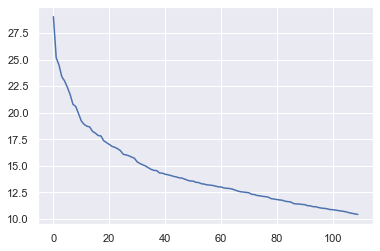

In [536]:
plt.plot(Sigma)

In [537]:
list_of_tags_topics = []
list_of_tags_topic_num_names = []

for index, component in enumerate(tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].components_):
    zipped = zip(tags_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_tags_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_tags_topics.append(topic_tags_components)
    list_of_tags_topic_num_names.append("Tags topic "+str(index))
    print("Topic "+str(index)+": ",topic_tags_components) #top_terms_list, top_comp_list)

Topic 0:  ['flowers(0.37)', 'nature(0.28)', 'flower(0.27)']
Topic 1:  ['pour(0.43)', 'fluid(0.37)', 'ocean(0.36)']
Topic 2:  ['pour(0.5)', 'fluid(0.44)', 'ocean(-0.28)']
Topic 3:  ['pet(0.53)', 'dog(0.45)', 'animal(0.31)']
Topic 4:  ['ocean(0.46)', 'nature(-0.34)', 'trees(-0.28)']
Topic 5:  ['life(0.42)', 'pink(-0.4)', 'still(0.39)']
Topic 6:  ['woman(0.66)', 'signed(0.27)', 'nature(-0.24)']
Topic 7:  ['signed(0.51)', 'flowers(0.32)', 'life(-0.26)']
Topic 8:  ['pink(0.64)', 'woman(-0.41)', 'signed(0.28)']
Topic 9:  ['office(0.43)', 'living(0.39)', 'pink(-0.32)']
Topic 10:  ['nature(0.56)', 'flowers(-0.35)', 'trees(-0.33)']
Topic 11:  ['flower(0.58)', 'flowers(-0.49)', 'antique(0.44)']
Topic 12:  ['textured(0.5)', 'orange(0.38)', 'house(-0.31)']
Topic 13:  ['antique(-0.55)', 'air(0.4)', 'plein(0.38)']
Topic 14:  ['kind(0.79)', 'textured(-0.36)', 'flower(0.22)']
Topic 15:  ['textured(0.63)', 'orange(-0.6)', 'bright(-0.26)']
Topic 16:  ['house(-0.54)', 'living(0.44)', 'office(0.34)']
Topi

In [538]:
#Which are the largest regression coefficients in the regression model?
feature_names_tags_ridge_tfidf = tags_ridge_w_tfidf_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()

tags_ridge_SVD_reg_coeff_df = pd.DataFrame(tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['ridge'].coef_,columns=['Regression coefficients'])
tags_ridge_SVD_reg_coeff_df['Topic']=pd.Series(list_of_tags_topics)
tags_ridge_SVD_reg_coeff_df = tags_ridge_SVD_reg_coeff_df.sort_values(by='Regression coefficients',ascending=False)
tags_ridge_SVD_reg_coeff_df.iloc[:10]

Regression coefficients  \
16                113.974352   
38                105.420084   
100                99.316503   
6                  86.556437   
58                 80.001006   
92                 73.826538   
5                  69.057292   
67                 68.667585   
93                 68.286935   
25                 67.868413   

                                                 Topic  
16          [house(-0.54), living(0.44), office(0.34)]  
38           [city(0.47), cityscape(0.4), dark(-0.23)]  
100          [light(0.33), french(0.31), waves(-0.24)]  
6           [woman(0.66), signed(0.27), nature(-0.24)]  
58            [minimal(0.46), bold(0.43), river(0.26)]  
92        [indian(0.28), bedroom(0.23), street(-0.23)]  
5                [life(0.42), pink(-0.4), still(0.39)]  
67   [surrealism(0.5), psychedelic(-0.35), work(0.35)]  
93     [handpainted(0.43), indian(0.29), street(0.28)]  
25      [trees(0.44), seascape(0.41), mountain(-0.37)]

In [539]:
tags_ridge_SVD_reg_coeff_df.iloc[-10:]

Regression coefficients  \
85                -49.756478   
105               -50.009356   
63                -60.133595   
14                -65.429533   
70                -66.293436   
1                 -70.357509   
104               -78.524285   
79                -85.768311   
3                -104.700814   
2                -119.159075   

                                                 Topic  
85        [spring(0.45), rose(-0.33), farmhouse(0.28)]  
105       [birds(0.38), french(-0.29), birthday(0.28)]  
63      [bold(0.46), minimal(-0.36), california(0.23)]  
14         [kind(0.79), textured(-0.36), flower(0.22)]  
70          [scene(0.5), horse(-0.38), tropical(-0.3)]  
1               [pour(0.43), fluid(0.37), ocean(0.36)]  
104      [turquoise(0.36), face(0.29), birthday(0.28)]  
79   [housewarming(0.5), wedding(-0.28), anniversar...  
3                 [pet(0.53), dog(0.45), animal(0.31)]  
2               [pour(0.5), fluid(0.44), ocean(-0.28)]

### 6b) Decision tree of (generic) tags only, after Tf-Idf vectorization using up to bigrams, and dimensionality reduction

In [540]:
#First, let's try without dimensionality reduction as a baseline
from sklearn.pipeline import Pipeline

tags_dtree_w_tfidf_pipe = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('dtree', DecisionTreeRegressor(max_depth=15)),
])

In [541]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,51,2)} #np.linspace(0,10,1)} 
tags_dtree_w_tfidf_CVmodel = GridSearchCV(tags_dtree_w_tfidf_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [542]:
tags_dtree_w_tfidf_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:  9.0min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tags tfidf vectorization',
                                        ColumnTransformer(transformers=[('tags '
                                                                         'tfidf',
                                                                         Pipeline(steps=[('to '
                                                                                          'single '
                                                                                          'string',
                                                                                          TagsEncoder()),
                                                                                         ('to '
                                                                                          'tfidf '
                                                                                          'n-grams',
                                                                                          TfidfVectorizer(max_df=0.8,
                                                                                                          max_features=1000,
                                                                                                          min_df=100,
                                                                                                          ngram_range=(1,
                                                                                                                       2),
                                                                                                          stop_words=['art',
                                                                                                                      'artwork',
                                                                                                                      'painting',
                                                                                                                      'paintings',
                                                                                                                      'paint',
                                                                                                                      'paintin',
                                                                                                                      'paints',
                                                                                                                      'painter',
                                                                                                                      'painted',
                                                                                                                      'illustration',
                                                                                                                      'picture',
                                                                                                                      'drawing',
                                                                                                                      'color',
                                                                                                                      'colors',
                                                                                                                      'colored',
                                                                                                                      'colorful',
                                                                                                                      'and',
                                                                                                                      'on',
                                                                                                                      'one',
         

In [543]:
tags_dtree_w_tfidf_CVmodel.best_params_['dtree__max_depth']

22

In [544]:
#Predict prices on training set:
prices_train_pred = tags_dtree_w_tfidf_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
tags_dtree_w_tfidf_CVmodel.score(paintings_df_train,prices_train)

0.11460535676045291

In [545]:
#Predict prices on test set:
prices_test_pred = tags_dtree_w_tfidf_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
tags_dtree_w_tfidf_CVmodel.score(paintings_df_test,prices_test)

0.0642527810667729

In [546]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using only generic tags, after Tf-Idf')


Decision Tree model using only generic tags, after Tf-Idf:
Training R^2: 0.11460535676045291
Testing R^2: 0.0642527810667729
Training RMSE: USD 132.45747408475128
Testing RMSE: USD 137.5026089421375
Training MAE: USD 104.11370527055402
Testing MAE: USD 108.22796892344128


In [547]:
#What are the tags words or word combos that are used most by the tree regressor?
feature_names_tags_dtree_w_tfidf = tags_dtree_w_tfidf_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()

tags_dtree_w_tfidf_features_imp_df = pd.DataFrame(tags_dtree_w_tfidf_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_tags_dtree_w_tfidf,columns=['Dtree feature importance'])
tags_dtree_w_tfidf_features_imp_df = tags_dtree_w_tfidf_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
tags_dtree_w_tfidf_features_imp_df.iloc[:20]

Dtree feature importance
signed                       0.090670
pour                         0.075789
rectangle                    0.070182
oversized                    0.050599
pet                          0.036916
fauvism                      0.033843
unstretched                  0.032797
handpainted                  0.031557
1980s                        0.019448
jackson                      0.019255
antique                      0.018693
fluid                        0.016924
seascape                     0.014495
anniversary                  0.014282
huge                         0.013703
emerging                     0.013410
vivid                        0.012099
listed                       0.011893
figurative                   0.011671
guitar                       0.011670

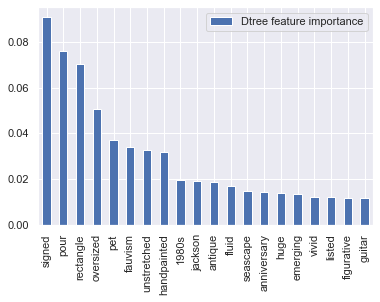

In [548]:
tags_dtree_w_tfidf_features_imp_df.iloc[:20].plot(kind="bar").legend(loc="upper right");

In [549]:
#Now let's add dimensionality reduction before computing the regressor
from sklearn.decomposition import TruncatedSVD

tags_dtree_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('SVD', TruncatedSVD(n_components=8)),
    ('dtree', DecisionTreeRegressor(max_depth=10))
])

In [550]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {'dtree__max_depth': range(2,12,2), 'SVD__n_components': range(2,82,4)} 
#tags_dtree_w_tfidf_SVD_CVmodel = RandomizedSearchCV(tags_dtree_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1, n_iter=20)
tags_dtree_w_tfidf_SVD_CVmodel = GridSearchCV(tags_dtree_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [551]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

tags_SVD_dtree_CVmodel_filename = './Git_exclude/models/tags_SVD_dtree_CVmodel.joblib'

#If the model file already exists, I load it:
try:
    with open(tags_SVD_dtree_CVmodel_filename, 'rb') as f:
        tags_dtree_w_tfidf_SVD_CVmodel = load(f)
        print('Loaded joblib file with decision tree model for generic tags vectorized with tf-idf and reduced with SVD.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    tags_dtree_w_tfidf_SVD_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(tags_SVD_dtree_CVmodel_filename, 'wb') as f:
        dump(tags_dtree_w_tfidf_SVD_CVmodel, tags_SVD_dtree_CVmodel_filename) 
        print('Saved joblib file with decision tree model for generic tags vectorized with tf-idf and reduced with SVD.')

Loaded joblib file with decision tree model for generic tags vectorized with tf-idf and reduced with SVD.


In [552]:
tags_dtree_w_tfidf_SVD_CVmodel.best_params_

{'SVD__n_components': 54, 'dtree__max_depth': 6}

In [553]:
#Predict prices on training set:
prices_train_pred = tags_dtree_w_tfidf_SVD_CVmodel.predict(paintings_df_train)

In [554]:
#And return the R2 score as follows:
tags_dtree_w_tfidf_SVD_CVmodel.score(paintings_df_train,prices_train)

0.04924059949683013

In [555]:
#Predict prices on test set:
prices_test_pred = tags_dtree_w_tfidf_SVD_CVmodel.predict(paintings_df_test)

In [556]:
#And return the R2 score as follows:
tags_dtree_w_tfidf_SVD_CVmodel.score(paintings_df_test,prices_test)

0.043424785844263014

In [557]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision tree model using vectorized (generic) tags with Tf-Idf followed by SVD')

Decision tree model using vectorized (generic) tags with Tf-Idf followed by SVD:
Training R^2: 0.04924059949683013
Testing R^2: 0.043424785844263014
Training RMSE: USD 137.25979248331154
Testing RMSE: USD 139.0244634862541
Training MAE: USD 110.40971552411246
Testing MAE: USD 111.68704107395504


In [558]:
#Let's check what the SVD components, often interpreted as 'topics' are:

In [559]:
tags_feature_names = tags_dtree_w_tfidf_SVD_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()

In [560]:
# Get Singular values and Components 
Sigma = tags_dtree_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].singular_values_ 
Sigma

array([29.03273549, 25.17093306, 24.48600413, 23.38723548, 22.98435626,
       22.39194962, 21.69926593, 20.79205989, 20.58267788, 19.90437563,
       19.21368008, 18.89503472, 18.7268478 , 18.65688945, 18.23959106,
       18.07989038, 17.85394351, 17.80887933, 17.36012145, 17.18498977,
       17.01011354, 16.8185199 , 16.73128055, 16.59546246, 16.42429266,
       16.07073593, 16.00698939, 15.93452498, 15.78140169, 15.69586849,
       15.33620691, 15.17581611, 15.00799332, 14.92256401, 14.77342222,
       14.59198733, 14.50339789, 14.42888784, 14.25881363, 14.17213992,
       14.09577443, 14.01510574, 13.94751291, 13.90791036, 13.75209617,
       13.64178885, 13.62760168, 13.53272935, 13.44531833, 13.36338152,
       13.30145536, 13.21579529, 13.11164973, 13.06769132])

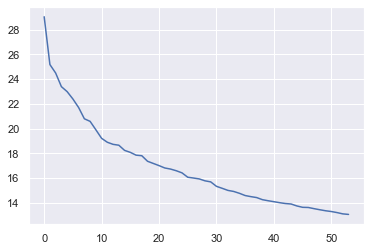

In [561]:
plt.plot(Sigma)

In [562]:
list_of_tags_topics = []
list_of_tags_topic_num_names = []

for index, component in enumerate(tags_dtree_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].components_):
    zipped = zip(tags_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_tags_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_tags_topics.append(topic_tags_components)
    list_of_tags_topic_num_names.append("Tags topic "+str(index))
    print("Topic "+str(index)+": ",topic_tags_components) #top_terms_list, top_comp_list)

Topic 0:  ['flowers(0.37)', 'nature(0.28)', 'flower(0.27)']
Topic 1:  ['pour(0.43)', 'fluid(0.37)', 'ocean(0.36)']
Topic 2:  ['pour(0.5)', 'fluid(0.44)', 'ocean(-0.28)']
Topic 3:  ['pet(0.53)', 'dog(0.45)', 'animal(0.31)']
Topic 4:  ['ocean(0.46)', 'nature(-0.34)', 'trees(-0.28)']
Topic 5:  ['life(0.42)', 'pink(-0.4)', 'still(0.39)']
Topic 6:  ['woman(0.66)', 'signed(0.27)', 'nature(-0.24)']
Topic 7:  ['signed(0.51)', 'flowers(0.32)', 'life(-0.26)']
Topic 8:  ['pink(0.64)', 'woman(-0.41)', 'signed(0.28)']
Topic 9:  ['office(0.43)', 'living(0.39)', 'pink(-0.32)']
Topic 10:  ['nature(0.56)', 'flowers(-0.35)', 'trees(-0.33)']
Topic 11:  ['flower(0.58)', 'flowers(-0.49)', 'antique(0.44)']
Topic 12:  ['textured(0.5)', 'orange(0.38)', 'house(-0.31)']
Topic 13:  ['antique(-0.55)', 'air(0.4)', 'plein(0.38)']
Topic 14:  ['kind(0.79)', 'textured(-0.36)', 'flower(0.22)']
Topic 15:  ['textured(0.63)', 'orange(-0.6)', 'bright(-0.25)']
Topic 16:  ['house(-0.54)', 'living(0.44)', 'office(0.34)']
Topi

In [563]:
#Which are the most predictive 'topics' in the decision tree?

In [564]:
#What are the style words or word combos that are used most by the tree regressor?
tags_dtree_w_tfidf_SVD_features_imp_df = pd.DataFrame(tags_dtree_w_tfidf_SVD_CVmodel.best_estimator_['dtree'].feature_importances_,columns=['Dtree feature importance'])
tags_dtree_w_tfidf_SVD_features_imp_df['Topic']=pd.Series(list_of_tags_topics)
tags_dtree_w_tfidf_SVD_features_imp_df = tags_dtree_w_tfidf_SVD_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
tags_dtree_w_tfidf_SVD_features_imp_df.iloc[:20]

Dtree feature importance  \
2                   0.190374   
7                   0.150489   
3                   0.129998   
27                  0.088354   
6                   0.047034   
36                  0.044957   
8                   0.043347   
21                  0.038693   
17                  0.035159   
5                   0.028236   
53                  0.027304   
43                  0.026083   
45                  0.019978   
26                  0.017212   
37                  0.014206   
28                  0.012521   
4                   0.011992   
18                  0.010765   
1                   0.010597   
10                  0.010195   

                                                Topic  
2              [pour(0.5), fluid(0.44), ocean(-0.28)]  
7          [signed(0.51), flowers(0.32), life(-0.26)]  
3                [pet(0.53), dog(0.45), animal(0.31)]  
27  [rectangle(0.47), seascape(-0.41), fauvism(0.26)]  
6          [woman(0.66), signed(0.27), nature(-0.24)]  
36            [bird(0.43), gray(0.38), animal(-0.32)]  
8            [pink(0.64), woman(-0.41), signed(0.28)]  
21  [geometric(0.49), decoration(-0.47), animal(-0...  
17          [antique(0.52), signed(-0.43), air(0.42)]  
5               [life(0.42), pink(-0.4), still(0.39)]  
53   [pouring(0.53), beautiful(-0.25), female(-0.21)]  
43           [impasto(0.47), her(-0.36), music(-0.3)]  
45            [impasto(0.38), music(0.37), day(0.29)]  
26         [living(0.44), office(-0.43), house(0.33)]  
37           [female(0.36), figure(0.29), nude(0.28)]  
28   [seascape(0.43), rectangle(0.36), office(-0.32)]  
4          [ocean(0.46), nature(-0.34), trees(-0.28)]  
18     [bright(0.54), orange(-0.53), geometric(0.45)]  
1              [pour(0.43), fluid(0.37), ocean(0.36)]  
10       [nature(0.56), flowers(-0.35), trees(-0.33)]

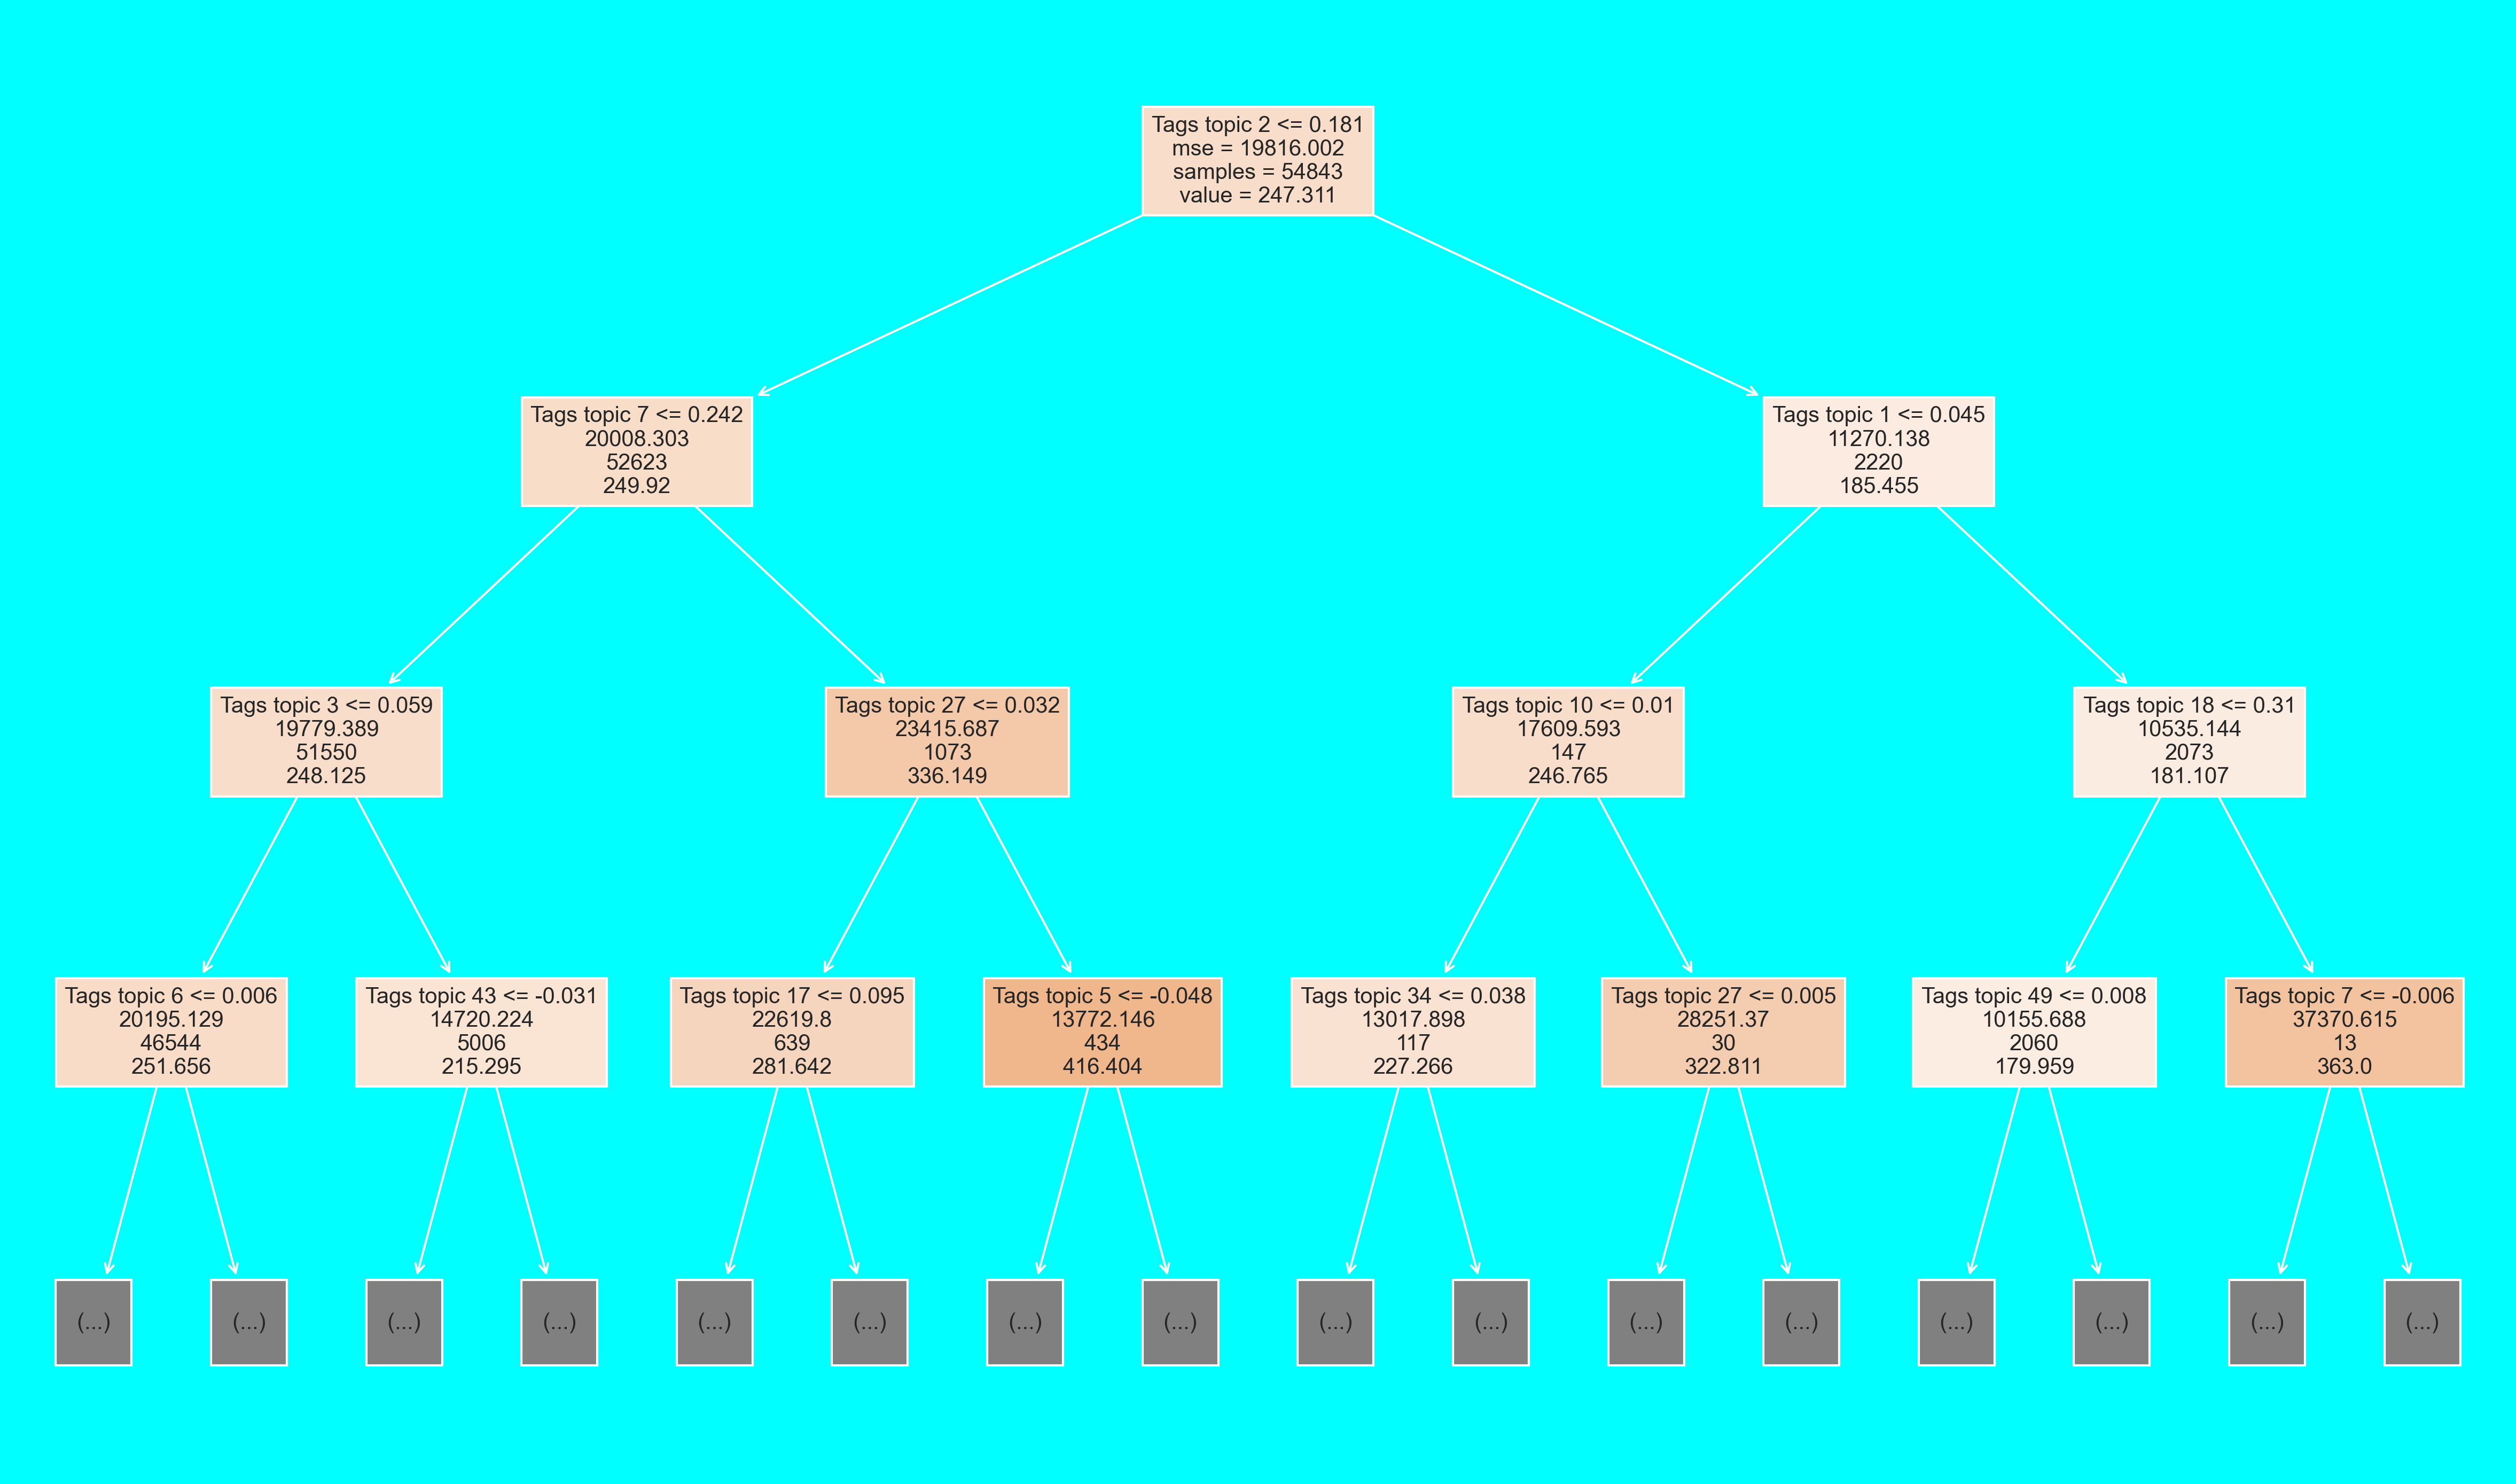

In [565]:
# Generate a plot of the decision tree
#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,12), dpi=300)
fig = plt.figure(figsize=(20,12), dpi=300)
fig.set_facecolor("cyan")
tree_viz = plot_tree(tags_dtree_w_tfidf_SVD_CVmodel.best_estimator_['dtree'],max_depth=3,fontsize=10,label='root',filled=True,feature_names = list_of_tags_topic_num_names)
fig.savefig('./Git_exclude/Figures/decision_tree_tags_after_tfidf_SVD.png')

#### Model 6c) Random Forest on (generic) Tags (with Tf-Idf vectorization and SVD reduction)

In [566]:
from sklearn.ensemble import RandomForestRegressor

In [567]:
#Let's first check the version without SVD reduction to get a baseline performance 
tags_rforest_pipe = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('rforest', RandomForestRegressor(n_estimators=100,max_features='sqrt',n_jobs=2,max_depth=tags_dtree_w_tfidf_CVmodel.best_params_['dtree__max_depth']+1,random_state=1,max_samples=0.8))
])

In [568]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

tags_rforest_pipe_filename = './Git_exclude/models/tags_rforest_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(tags_rforest_pipe_filename, 'rb') as f:
        tags_rforest_pipe = load(f)
        print('Loaded joblib file with random forest model for tags (with Tf-Idf but no SVD).')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    tags_rforest_pipe.fit(paintings_df_train,prices_train)
    
    with open(tags_rforest_pipe_filename, 'wb') as f:
        dump(tags_rforest_pipe, tags_rforest_pipe_filename) 
        print('Saved joblib file with random forest model for tags (with Tf-Idf but no SVD).')

Loaded joblib file with random forest model for tags (with Tf-Idf but no SVD).


In [569]:
#Predict prices on training set:
prices_train_pred = tags_rforest_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
tags_rforest_pipe.score(paintings_df_train,prices_train)

0.11180338985426685

In [570]:
#Predict prices on test set:
prices_test_pred = tags_rforest_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
tags_rforest_pipe.score(paintings_df_test,prices_test)

0.08434642053276353

In [571]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using generic tags (without Tf-Idf)')


Random Forest model using generic tags (without Tf-Idf):
Training R^2: 0.11180338985426685
Testing R^2: 0.08434642053276353
Training RMSE: USD 132.66689950420053
Testing RMSE: USD 136.01827559253886
Training MAE: USD 106.77419939056526
Testing MAE: USD 109.36101070140637


In [572]:
feature_names_tags_rforest = tags_rforest_pipe['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()

In [573]:
feature_names_tags_rforest[:20]

['10',
 '11',
 '11x14',
 '12',
 '14',
 '140lb',
 '16',
 '16x20',
 '18',
 '18x24',
 '1950s',
 '1960s',
 '1970s',
 '1980s',
 '20',
 '20th',
 '24',
 '30',
 '3d',
 '3d prints']

In [574]:
tags_rforest_features_imp_df = pd.DataFrame(tags_rforest_pipe['rforest'].feature_importances_,feature_names_tags_rforest,columns=['Rforest feature importance'])
tags_rforest_features_imp_df = tags_rforest_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
tags_rforest_features_imp_df

Rforest feature importance
pour                            0.052046
signed                          0.038359
rectangle                       0.036374
oversized                       0.030861
fluid                           0.027106
...                                  ...
van                             0.000017
studios                         0.000015
winter scene                    0.000013
ralph                           0.000012
daisy                           0.000007

[668 rows x 1 columns]

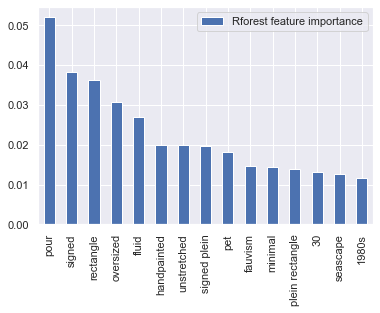

In [575]:
tags_rforest_features_imp_df.iloc[:15].plot(kind="bar").legend(loc="upper right");

##### Now let's introduce SVD reduction

In [576]:
from sklearn.ensemble import RandomForestRegressor

In [577]:
from sklearn.decomposition import TruncatedSVD

tags_rforest_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('SVD', TruncatedSVD(n_components=50)),
    ('rforest', RandomForestRegressor(n_estimators=100,max_features='sqrt',n_jobs=2,max_depth=tags_dtree_w_tfidf_SVD_CVmodel.best_params_['dtree__max_depth']+1,random_state=1,max_samples=0.8))
])

In [578]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

tags_rforest_w_tfidf_SVD_pipe_filename = './Git_exclude/models/tags_rforest_w_tfidf_SVD_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(tags_rforest_w_tfidf_SVD_pipe_filename, 'rb') as f:
        tags_rforest_w_tfidf_SVD_pipe = load(f)
        print('Loaded joblib file with random forest model for tags (after Tf-Idf and SVD).')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    tags_rforest_w_tfidf_SVD_pipe.fit(paintings_df_train,prices_train)
    
    with open(tags_rforest_w_tfidf_SVD_pipe_filename, 'wb') as f:
        dump(tags_rforest_w_tfidf_SVD_pipe, tags_rforest_w_tfidf_SVD_pipe_filename) 
        print('Saved joblib file with random forest model for tags (after Tf-Idf and SVD).')

Loaded joblib file with random forest model for tags (after Tf-Idf and SVD).


In [579]:
#Predict prices on training set:
prices_train_pred = tags_rforest_w_tfidf_SVD_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
tags_rforest_w_tfidf_SVD_pipe.score(paintings_df_train,prices_train)

0.0680882811498047

In [580]:
#Predict prices on test set:
prices_test_pred = tags_rforest_w_tfidf_SVD_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
tags_rforest_w_tfidf_SVD_pipe.score(paintings_df_test,prices_test)

0.05848825726661688

In [581]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using generic tags (after Tf-Idf and SVD reduction)')


Random Forest model using generic tags (after Tf-Idf and SVD reduction):
Training R^2: 0.0680882811498047
Testing R^2: 0.05848825726661688
Training RMSE: USD 135.8924756058885
Testing RMSE: USD 137.9254902836044
Training MAE: USD 109.52482286526796
Testing MAE: USD 111.1094412766839


In [582]:
#what are the main features used for decision?
tags_rforest_w_tfidf_SVD_pipe['rforest'].feature_importances_

array([0.01585821, 0.03519849, 0.07913098, 0.05713585, 0.02440627,
       0.0516517 , 0.05397113, 0.07424199, 0.02465361, 0.01689087,
       0.01003349, 0.01390669, 0.01148584, 0.02178038, 0.01201506,
       0.00660973, 0.02687105, 0.03021337, 0.00961939, 0.01541579,
       0.00905106, 0.02363885, 0.01161849, 0.0111372 , 0.00559605,
       0.01143381, 0.01679803, 0.02877788, 0.01737193, 0.01247019,
       0.04614704, 0.00763902, 0.00870448, 0.00663017, 0.01786093,
       0.01047326, 0.01164998, 0.03332646, 0.01482913, 0.00709378,
       0.00588688, 0.01374426, 0.01285027, 0.01108187, 0.00950172,
       0.0094705 , 0.00709906, 0.00930482, 0.00840416, 0.00931885])

In [583]:
list_of_tags_topics = []
list_of_tags_topic_num_names = []

for index, component in enumerate(tags_rforest_w_tfidf_SVD_pipe['SVD'].components_):
    zipped = zip(tags_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_tags_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_tags_topics.append(topic_tags_components)
    list_of_tags_topic_num_names.append("Tags topic "+str(index))
    #print("Topic "+str(index)+": ",topic_tags_components) #top_terms_list, top_comp_list)

In [584]:
#What are the tags words or word combos that are used most by the random forest regressor?
tags_rforest_w_tfidf_SVD_features_imp_df = pd.DataFrame(tags_rforest_w_tfidf_SVD_pipe['rforest'].feature_importances_,columns=['Rforest feature importance'])
tags_rforest_w_tfidf_SVD_features_imp_df['Topic']=pd.Series(list_of_tags_topics)
tags_rforest_w_tfidf_SVD_features_imp_df = tags_rforest_w_tfidf_SVD_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
tags_rforest_w_tfidf_SVD_features_imp_df.iloc[:20]

Rforest feature importance  \
2                     0.079131   
7                     0.074242   
3                     0.057136   
6                     0.053971   
5                     0.051652   
30                    0.046147   
1                     0.035198   
37                    0.033326   
17                    0.030213   
27                    0.028778   
16                    0.026871   
8                     0.024654   
4                     0.024406   
21                    0.023639   
13                    0.021780   
34                    0.017861   
28                    0.017372   
9                     0.016891   
26                    0.016798   
0                     0.015858   

                                                Topic  
2              [pour(0.5), fluid(0.44), ocean(-0.28)]  
7          [signed(0.51), flowers(0.32), life(-0.26)]  
3                [pet(0.53), dog(0.45), animal(0.31)]  
6          [woman(0.66), signed(0.27), nature(-0.24)]  
5               [life(0.42), pink(-0.4), still(0.39)]  
30           [fluid(0.65), pour(-0.62), pouring(0.2)]  
1              [pour(0.43), fluid(0.37), ocean(0.36)]  
37             [gray(0.51), bird(-0.3), animal(0.25)]  
17          [antique(0.52), signed(-0.43), air(0.43)]  
27  [rectangle(0.49), seascape(-0.38), fauvism(0.27)]  
16         [house(-0.54), living(0.45), office(0.33)]  
8            [pink(0.64), woman(-0.41), signed(0.28)]  
4          [ocean(0.46), nature(-0.34), trees(-0.28)]  
21  [geometric(0.55), decoration(-0.44), animal(-0...  
13            [antique(-0.55), air(0.4), plein(0.38)]  
34         [woman(-0.36), female(0.36), figure(0.28)]  
28   [seascape(0.41), office(-0.36), rectangle(0.33)]  
9           [office(0.43), living(0.39), pink(-0.32)]  
26         [living(0.46), office(-0.46), house(0.32)]  
0         [flowers(0.37), nature(0.28), flower(0.27)]

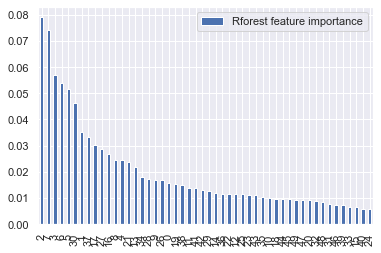

In [585]:
tags_rforest_w_tfidf_SVD_features_imp_df.plot(kind="bar").legend(loc="upper right");

#### Model 6d) Gradient Boosted Trees on (generic) Tags 

In [586]:
from sklearn.ensemble import GradientBoostingRegressor

In [587]:
#Let's first start with a version without SVD reduction, as a baseline
tags_gboost_pipe = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('gboost', GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,subsample=0.5,max_depth=tags_dtree_w_tfidf_CVmodel.best_params_['dtree__max_depth']-3,random_state=1))
])

In [588]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

tags_gboost_pipe_filename = './Git_exclude/models/tags_gboost_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(tags_gboost_pipe_filename, 'rb') as f:
        tags_gboost_pipe = load(f)
        print('Loaded joblib file with gradient boosting model for tags (with Tf-Idf but no SVD).')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    tags_gboost_pipe.fit(paintings_df_train,prices_train)
    
    with open(tags_gboost_pipe_filename, 'wb') as f:
        dump(tags_gboost_pipe, tags_gboost_pipe_filename) 
        print('Saved joblib file with gradient boosting model for tags (with Tf-Idf but no SVD).')

Loaded joblib file with gradient boosting model for tags (with Tf-Idf but no SVD).


In [589]:
#Predict prices on training set:
prices_train_pred = tags_gboost_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
tags_gboost_pipe.score(paintings_df_train,prices_train)

0.33002047476468455

In [590]:
#Predict prices on test set:
prices_test_pred = tags_gboost_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
tags_gboost_pipe.score(paintings_df_test,prices_test)

0.14380024868764096

In [591]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosting model using generic tags (with Tf-Idf but no SVD reduction)')


Gradient Boosting model using generic tags (with Tf-Idf but no SVD reduction):
Training R^2: 0.33002047476468455
Testing R^2: 0.14380024868764096
Training RMSE: USD 115.22289672457006
Testing RMSE: USD 131.52830232928991
Training MAE: USD 92.12919485111334
Testing MAE: USD 103.66107501904992


In [731]:
#what are the main features used for decision?
tags_gboost_pipe['gboost'].feature_importances_[:20]

array([0.00137453, 0.00043162, 0.0014544 , 0.00098493, 0.00031775,
       0.00069201, 0.00067726, 0.00117032, 0.00099417, 0.00074817,
       0.00037177, 0.00106354, 0.0007088 , 0.00560794, 0.00094384,
       0.00109914, 0.00366608, 0.00442631, 0.00103323, 0.00119618])

In [593]:
feature_names_tags_gboost = tags_gboost_pipe['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()

In [594]:
feature_names_tags_gboost[:20]

['10',
 '11',
 '11x14',
 '12',
 '14',
 '140lb',
 '16',
 '16x20',
 '18',
 '18x24',
 '1950s',
 '1960s',
 '1970s',
 '1980s',
 '20',
 '20th',
 '24',
 '30',
 '3d',
 '3d prints']

In [595]:
tags_gboost_features_imp_df = pd.DataFrame(tags_gboost_pipe['gboost'].feature_importances_,feature_names_tags_gboost,columns=['Gboost feature importance'])
tags_gboost_features_imp_df = tags_gboost_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
tags_gboost_features_imp_df

Gboost feature importance
signed                                          0.020864
rectangle                                       0.017400
pour                                            0.015946
office                                          0.009808
oversized                                       0.009700
...                                                  ...
jillkrutickfineart underwater                   0.000000
graphic handprint                               0.000000
underwater tie                                  0.000000
fluid pour                                      0.000000
handprint                                       0.000000

[668 rows x 1 columns]

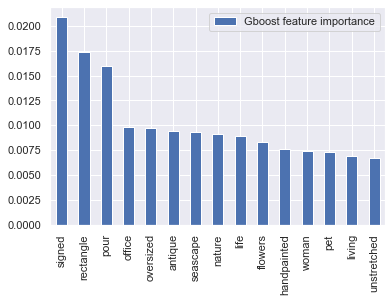

In [596]:
tags_gboost_features_imp_df.iloc[:15].plot(kind="bar").legend(loc="upper right");

##### Now let's introduce SVD reduction

In [597]:
from sklearn.ensemble import GradientBoostingRegressor

In [598]:
from sklearn.decomposition import TruncatedSVD

tags_gboost_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('SVD', TruncatedSVD(n_components=50)),
    ('gboost', GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,subsample=0.5,max_depth=tags_dtree_w_tfidf_SVD_CVmodel.best_params_['dtree__max_depth']-3,random_state=1))
])

In [599]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

tags_gboost_w_tfidf_SVD_pipe_filename = './Git_exclude/models/tags_gboost_w_tfidf_SVD_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(tags_gboost_w_tfidf_SVD_pipe_filename, 'rb') as f:
        tags_gboost_w_tfidf_SVD_pipe = load(f)
        print('Loaded joblib file with gradient boosting model for tags (after Tf-Idf and SVD).')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    tags_gboost_w_tfidf_SVD_pipe.fit(paintings_df_train,prices_train)
    
    with open(tags_gboost_w_tfidf_SVD_pipe_filename, 'wb') as f:
        dump(tags_gboost_w_tfidf_SVD_pipe, tags_gboost_w_tfidf_SVD_pipe_filename) 
        print('Saved joblib file with gradient boosting model for tags (after Tf-Idf and SVD).')

Loaded joblib file with gradient boosting model for tags (after Tf-Idf and SVD).


In [600]:
#Predict prices on training set:
prices_train_pred = tags_gboost_w_tfidf_SVD_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
tags_gboost_w_tfidf_SVD_pipe.score(paintings_df_train,prices_train)

0.08266505229550636

In [601]:
#Predict prices on test set:
prices_test_pred = tags_gboost_w_tfidf_SVD_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
tags_gboost_w_tfidf_SVD_pipe.score(paintings_df_test,prices_test)

0.06982330496716516

In [602]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosting model using generic tags (after Tf-Idf and SVD reduction)')


Gradient Boosting model using generic tags (after Tf-Idf and SVD reduction):
Training R^2: 0.08266505229550636
Testing R^2: 0.06982330496716516
Training RMSE: USD 134.82548569617933
Testing RMSE: USD 137.0927199752022
Training MAE: USD 108.30833079520076
Testing MAE: USD 110.06944604366966


In [603]:
#what are the main features used for decision?
tags_gboost_w_tfidf_SVD_pipe['gboost'].feature_importances_

array([0.03950905, 0.02996477, 0.0824957 , 0.06844945, 0.00714372,
       0.05304592, 0.05434505, 0.05056265, 0.01716578, 0.01528918,
       0.00514901, 0.01098627, 0.00879493, 0.0092676 , 0.01234958,
       0.0120441 , 0.03530425, 0.02397098, 0.00618766, 0.01251262,
       0.01213587, 0.01782335, 0.00394687, 0.00576242, 0.00619197,
       0.01109105, 0.01469687, 0.04610117, 0.03111741, 0.00511989,
       0.03852213, 0.00588698, 0.00743044, 0.00788597, 0.02093424,
       0.011203  , 0.01359231, 0.03492289, 0.03026657, 0.01311428,
       0.01278422, 0.00396532, 0.00929123, 0.00515048, 0.00721243,
       0.01105222, 0.01251235, 0.00734363, 0.02738285, 0.01102131])

In [604]:
list_of_tags_topics = []
list_of_tags_topic_num_names = []

for index, component in enumerate(tags_gboost_w_tfidf_SVD_pipe['SVD'].components_):
    zipped = zip(tags_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
    top_terms_list=list(dict(top_terms_key).keys())
    top_comp_list=list(dict(top_terms_key).values())
    topic_tags_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
    list_of_tags_topics.append(topic_tags_components)
    list_of_tags_topic_num_names.append("Tags topic "+str(index))
    #print("Topic "+str(index)+": ",topic_tags_components) #top_terms_list, top_comp_list)

In [605]:
#What are the tags words or word combos that are used most by the random forest regressor?
tags_gboost_w_tfidf_SVD_features_imp_df = pd.DataFrame(tags_gboost_w_tfidf_SVD_pipe['gboost'].feature_importances_,columns=['Gboost feature importance'])
tags_gboost_w_tfidf_SVD_features_imp_df['Topic']=pd.Series(list_of_tags_topics)
tags_gboost_w_tfidf_SVD_features_imp_df = tags_gboost_w_tfidf_SVD_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
tags_gboost_w_tfidf_SVD_features_imp_df.iloc[:20]

Gboost feature importance  \
2                    0.082496   
3                    0.068449   
6                    0.054345   
5                    0.053046   
7                    0.050563   
27                   0.046101   
0                    0.039509   
30                   0.038522   
16                   0.035304   
37                   0.034923   
28                   0.031117   
38                   0.030267   
1                    0.029965   
48                   0.027383   
17                   0.023971   
34                   0.020934   
21                   0.017823   
8                    0.017166   
9                    0.015289   
26                   0.014697   

                                                Topic  
2              [pour(0.5), fluid(0.44), ocean(-0.28)]  
3                [pet(0.53), dog(0.45), animal(0.31)]  
6          [woman(0.66), signed(0.27), nature(-0.24)]  
5               [life(0.42), pink(-0.4), still(0.39)]  
7          [signed(0.51), flowers(0.32), life(-0.26)]  
27  [rectangle(0.45), seascape(-0.44), fauvism(0.25)]  
0         [flowers(0.37), nature(0.28), flower(0.27)]  
30          [fluid(0.66), pour(-0.61), pouring(0.19)]  
16         [house(-0.54), living(0.44), office(0.34)]  
37           [gray(0.59), brown(0.23), female(-0.23)]  
28   [seascape(0.43), rectangle(0.39), office(-0.25)]  
38         [girl(-0.39), city(0.37), cityscape(0.32)]  
1              [pour(0.43), fluid(0.37), ocean(0.36)]  
48     [forest(0.4), beautiful(-0.32), minimal(0.24)]  
17          [antique(0.52), air(0.43), signed(-0.42)]  
34             [dark(0.37), sky(-0.32), woman(-0.29)]  
21  [geometric(0.51), decoration(-0.47), animal(-0...  
8            [pink(0.64), woman(-0.41), signed(0.28)]  
9           [office(0.43), living(0.39), pink(-0.32)]  
26         [living(0.47), office(-0.45), house(0.33)]

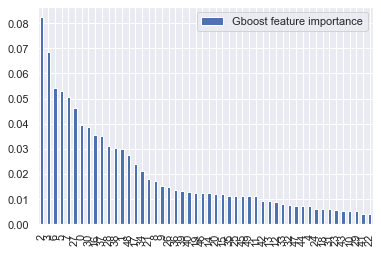

In [606]:
tags_gboost_w_tfidf_SVD_features_imp_df.plot(kind="bar").legend(loc="upper right");

## 7) Ensemble models blending the predictions from individual models for the different modalities (rather than combining inputs from all modalities under a unique model type) 

To use the existing models as input to a predictor, I turn them into transformers using a custom 'ModelTransformer' class that takes a predictor as an argument. When fit is called, the predictor is fit. When transform is called, the predictor's predict method is called, and its results returned as the transformation.

In [607]:
class ModelTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, model):
        self.predictor = model
            
    def fit(self, X, y):
        # Fit the stored predictor.
        self.predictor.fit(X, y)
        return self
    
    def transform(self, X):
        # Use predict on the stored predictor as a "transformation".
        # reshape(-1,1) is required to return a 2-D array which is expected by sk-learn.
        return np.array(self.predictor.predict(X)).reshape(-1,1)
    

#### 7a) Blending Decision Tree for numerical+categorical features, Decision Tree for style tags (vectorized), Decision Tree for material tags (after Tf-Idf and SVD), Decision Tree for general tags (after Tf-Idf and SVD). 
#### LinearRegression or another Decision Tree is used to blend the 4 models

Create an instance of ModelTransformer for each of the individual models of interest. Then, we'll combine these together in a single feature matrix with a
FeatureUnion.

In [608]:
#Decision Tree model for numerical+categorical features

#Recall that:

# variable_selector_for_trees = ColumnTransformer([
#     ('categorical', OneHotEncoder(), categorical_columns),
#     ('boolean','passthrough', boolean_columns),
#     ('numerical','passthrough',numerical_columns)
#  ], remainder='drop')

#(I don't want to drop the first variable for tree-based models and I don't need to scale the numerical variables)

#define a pipeline with the best values found earlier via cross-validation

num_plus_cat_dtree_pipe_final = Pipeline([
    ('num and cat selector', variable_selector_for_trees),
    ('dtree', DecisionTreeRegressor(max_depth=9)),
])

#Note: this model is saved as: 
#num_plus_cat_dtree_CVmodel_filename = './Git_exclude/models/num_plus_cat_dtree_CVmodel.joblib'
#(if we wanted to load it without having to refit)

num_plus_cat_dtree_trans = ModelTransformer(num_plus_cat_dtree_pipe_final)


In [609]:
#Decision Tree model for style tags (with vectorized style tags (69 features) but without Tf-Idf and SVD dimensionality reduction)

# #Recall that:

# pipe_style_tags_encoding = Pipeline([
#     ('to dict series',DictEncoder()),
#     ('to binary vectors',DictVectorizer())
# ])

# style_tranform = ColumnTransformer([
#     ('style tags vectorizer', pipe_style_tags_encoding, 'style_tags_new'),
# ], remainder='drop')

# #(I did not need Tf-Idf or SVD reduction because each painting usually only has a handful of style tags, and I kept only the most common ones (69 features)
# # Both Tf-Idf and SVD reduced the performance)

#define a pipeline with the best values found earlier via cross-validation

style_dtree_pipe_final = Pipeline([
    ('style tags vectorization', style_tranform),
    ('dtree', DecisionTreeRegressor(max_depth=12)),
])

#Note: this model is saved as: 
#style_dtree_CVmodel_filename = './Git_exclude/models/style_dtree_CVmodel.joblib'
#(if we wanted to load it without having to refit)

style_tags_dtree_trans = ModelTransformer(style_dtree_pipe_final)


In [610]:
#Decision Tree model for material tags (with Tf-Idf of the original 100 tags + bigrams (that occur in very different frequencies) and SVD dimensionality reduction

# #Recall that:

# pipe_tags_encoding = Pipeline([
#     ('to single string',TagsEncoder()),
#     ('to tfidf n-grams',TfidfVectorizer(ngram_range=(1, 2)))
# ])

# materials_tags_tranform = ColumnTransformer([
#     ('materials tags tfidf', pipe_tags_encoding, 'materials_tags_new'),
# ], remainder='drop')


#define a pipeline with the best values found earlier via cross-validation

materials_dtree_w_tfidf_SVD_pipe_final = Pipeline([
    ('tags tfidf vectorization', materials_tags_tranform),
    ('SVD', TruncatedSVD(n_components=78)),
    ('dtree', DecisionTreeRegressor(max_depth=6))
])

#Note: this model is saved as: 
#materials_tags_SVD_dtree_CVmodel_filename = './Git_exclude/models/materials_tags_SVD_dtree_CVmodel.joblib'
#(if we wanted to load it without having to refit)

materials_tags_dtree_trans = ModelTransformer(materials_dtree_w_tfidf_SVD_pipe_final)

In [611]:
#Decision Tree model for general tags (with Tf-Idf of the original tags + bigrams and SVD dimensionality reduction

# #Recall that:

# pipe_tags_encoding_with_stopwords = Pipeline([
#     ('to single string',TagsEncoder()),
#     ('to tfidf n-grams',TfidfVectorizer(min_df=100,max_df=0.8,stop_words=tags_stopwords,ngram_range=(1, 2),max_features=1000))
# ])

# tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding_with_stopwords, 'tags_new'),
# ], remainder='drop')


#define a pipeline with the best values found earlier via cross-validation

tags_dtree_w_tfidf_SVD_pipe_final = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('SVD', TruncatedSVD(n_components=54)),
    ('dtree', DecisionTreeRegressor(max_depth=6))
])

#Note: this model is saved as: 
#tags_SVD_dtree_CVmodel_filename = './Git_exclude/models/tags_SVD_dtree_CVmodel.joblib'
#(if we wanted to load it without having to refit)

tags_dtree_trans = ModelTransformer(tags_dtree_w_tfidf_SVD_pipe_final)

In [612]:
#Let's now combine the 4 predictors-transformers into a feature union.

In [613]:
from sklearn.pipeline import FeatureUnion

dtree_models_union = FeatureUnion([
        ('num plus cat model', num_plus_cat_dtree_trans),
        ('style tags model',style_tags_dtree_trans),
        ('materials tags model',materials_tags_dtree_trans),
        ('other tags model',tags_dtree_trans),
    ])

In [614]:
dtree_models_union

FeatureUnion(transformer_list=[('num plus cat model',
                                ModelTransformer(model=None)),
                               ('style tags model',
                                ModelTransformer(model=None)),
                               ('materials tags model',
                                ModelTransformer(model=None)),
                               ('other tags model',
                                ModelTransformer(model=None))])

#### LinearRegression blending the 4 models

In [615]:
from sklearn.linear_model import LinearRegression

#note: there is no need of scaling because the output of each transformer is a price prediction in this case,
#and thus all columns are in the same unit and comparable with each other.

blended_model_dtree_linear = Pipeline([
    ('individual dtree models', dtree_models_union),
    ('linear combination', LinearRegression())
])
blended_model_dtree_linear

Pipeline(steps=[('individual dtree models',
                 FeatureUnion(transformer_list=[('num plus cat model',
                                                 ModelTransformer(model=None)),
                                                ('style tags model',
                                                 ModelTransformer(model=None)),
                                                ('materials tags model',
                                                 ModelTransformer(model=None)),
                                                ('other tags model',
                                                 ModelTransformer(model=None))])),
                ('linear combination', LinearRegression())])

In [616]:
#Train and possibly save the model.
#This is going to fit each of the four models, then fit the best linear combination coefficients
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

blended_model_dtree_linear_filename = './Git_exclude/models/blended_model_dtree_linear.joblib'

#If the model file already exists, I load it:
try:
    with open(blended_model_dtree_linear_filename, 'rb') as f:
        blended_model_dtree_linear = load(f)
        print('Loaded joblib file with linear blended model of decision trees for numerical+categorical variables, style tags, materials tags and other tags.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    blended_model_dtree_linear.fit(paintings_df_train,prices_train);
    
    with open(blended_model_dtree_linear_filename, 'wb') as f:
        dump(blended_model_dtree_linear, blended_model_dtree_linear_filename) 
        print('Saved joblib file with linear blended model of decision trees for numerical+categorical variables, style tags, materials tags and other tags.')

Loaded joblib file with linear blended model of decision trees for numerical+categorical variables, style tags, materials tags and other tags.


In [617]:
#Here are the weights learnt for each of the individual models:
blended_model_dtree_linear['linear combination'].coef_

array([0.90439608, 0.35885026, 0.18617213, 0.20799687])

In [618]:
#Predict prices on training set:
prices_train_pred = blended_model_dtree_linear.predict(paintings_df_train)
#And return the R2 score as follows:
blended_model_dtree_linear.score(paintings_df_train,prices_train)

0.3592185367092391

In [619]:
#Predict prices on test set:
prices_test_pred = blended_model_dtree_linear.predict(paintings_df_test)
#And return the R2 score as follows:
blended_model_dtree_linear.score(paintings_df_test,prices_test)

0.30333057918059725

In [620]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Linear blended model of decision tree for numerical+categorical variables, style tags, materials tags and other tags')


Linear blended model of decision tree for numerical+categorical variables, style tags, materials tags and other tags:
Training R^2: 0.3592185367092391
Testing R^2: 0.30333057918059725
Training RMSE: USD 112.68419171237494
Testing RMSE: USD 118.64379780395957
Training MAE: USD 85.28912709979068
Testing MAE: USD 89.42953535949437


#### Final Decision Tree blending the 4 decision tree models

In [621]:

blended_model_dtree_dtree = Pipeline([
    ('individual dtree models', dtree_models_union),
    ('final dtree', DecisionTreeRegressor(max_depth=4))
])
blended_model_dtree_dtree

Pipeline(steps=[('individual dtree models',
                 FeatureUnion(transformer_list=[('num plus cat model',
                                                 ModelTransformer(model=None)),
                                                ('style tags model',
                                                 ModelTransformer(model=None)),
                                                ('materials tags model',
                                                 ModelTransformer(model=None)),
                                                ('other tags model',
                                                 ModelTransformer(model=None))])),
                ('final dtree', DecisionTreeRegressor(max_depth=4))])

In [622]:
#Train and possibly save the model.
#This is going to fit each of the four models, then fit the best decision tree
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

blended_model_dtree_dtree_filename = './Git_exclude/models/blended_model_dtree_dtree.joblib'

#If the model file already exists, I load it:
try:
    with open(blended_model_dtree_dtree_filename, 'rb') as f:
        blended_model_dtree_dtree = load(f)
        print('Loaded joblib file with dtree blended model of decision trees for numerical+categorical variables, style tags, materials tags and other tags.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    blended_model_dtree_dtree.fit(paintings_df_train,prices_train);
    
    with open(blended_model_dtree_dtree_filename, 'wb') as f:
        dump(blended_model_dtree_dtree, blended_model_dtree_dtree_filename) 
        print('Saved joblib file with dtree blended model of decision trees for numerical+categorical variables, style tags, materials tags and other tags.')

Loaded joblib file with dtree blended model of decision trees for numerical+categorical variables, style tags, materials tags and other tags.


In [623]:
#Predict prices on training set:
prices_train_pred = blended_model_dtree_dtree.predict(paintings_df_train)
#And return the R2 score as follows:
blended_model_dtree_dtree.score(paintings_df_train,prices_train)

0.3485667722477328

In [624]:
#Predict prices on test set:
prices_test_pred = blended_model_dtree_dtree.predict(paintings_df_test)
#And return the R2 score as follows:
blended_model_dtree_dtree.score(paintings_df_test,prices_test)

0.29109880096090546

In [625]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Dtree blended model of decision tree for numerical+categorical variables, style tags, materials tags and other tags')


Dtree blended model of decision tree for numerical+categorical variables, style tags, materials tags and other tags:
Training R^2: 0.3485667722477328
Testing R^2: 0.29109880096090546
Training RMSE: USD 113.61691094547976
Testing RMSE: USD 119.68081042523119
Training MAE: USD 85.82091038621444
Testing MAE: USD 89.73414742414491


In [626]:
#what are the main features used by the final decision tree?
blended_model_dtree_dtree['final dtree'].feature_importances_

array([0.9711233 , 0.02524499, 0.        , 0.00363171])

In [627]:
individual_model_names = ['Num+Cat','Style','Materials','Other Tags']

blended_model_dtree_dtree_features_imp_df = pd.DataFrame(blended_model_dtree_dtree['final dtree'].feature_importances_,individual_model_names,columns=['Dtree feature importance'])
blended_model_dtree_dtree_features_imp_df = blended_model_dtree_dtree_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
blended_model_dtree_dtree_features_imp_df

Dtree feature importance
Num+Cat                     0.971123
Style                       0.025245
Other Tags                  0.003632
Materials                   0.000000

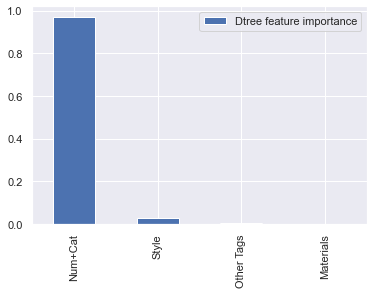

In [628]:
blended_model_dtree_dtree_features_imp_df.plot(kind="bar").legend(loc="upper right");

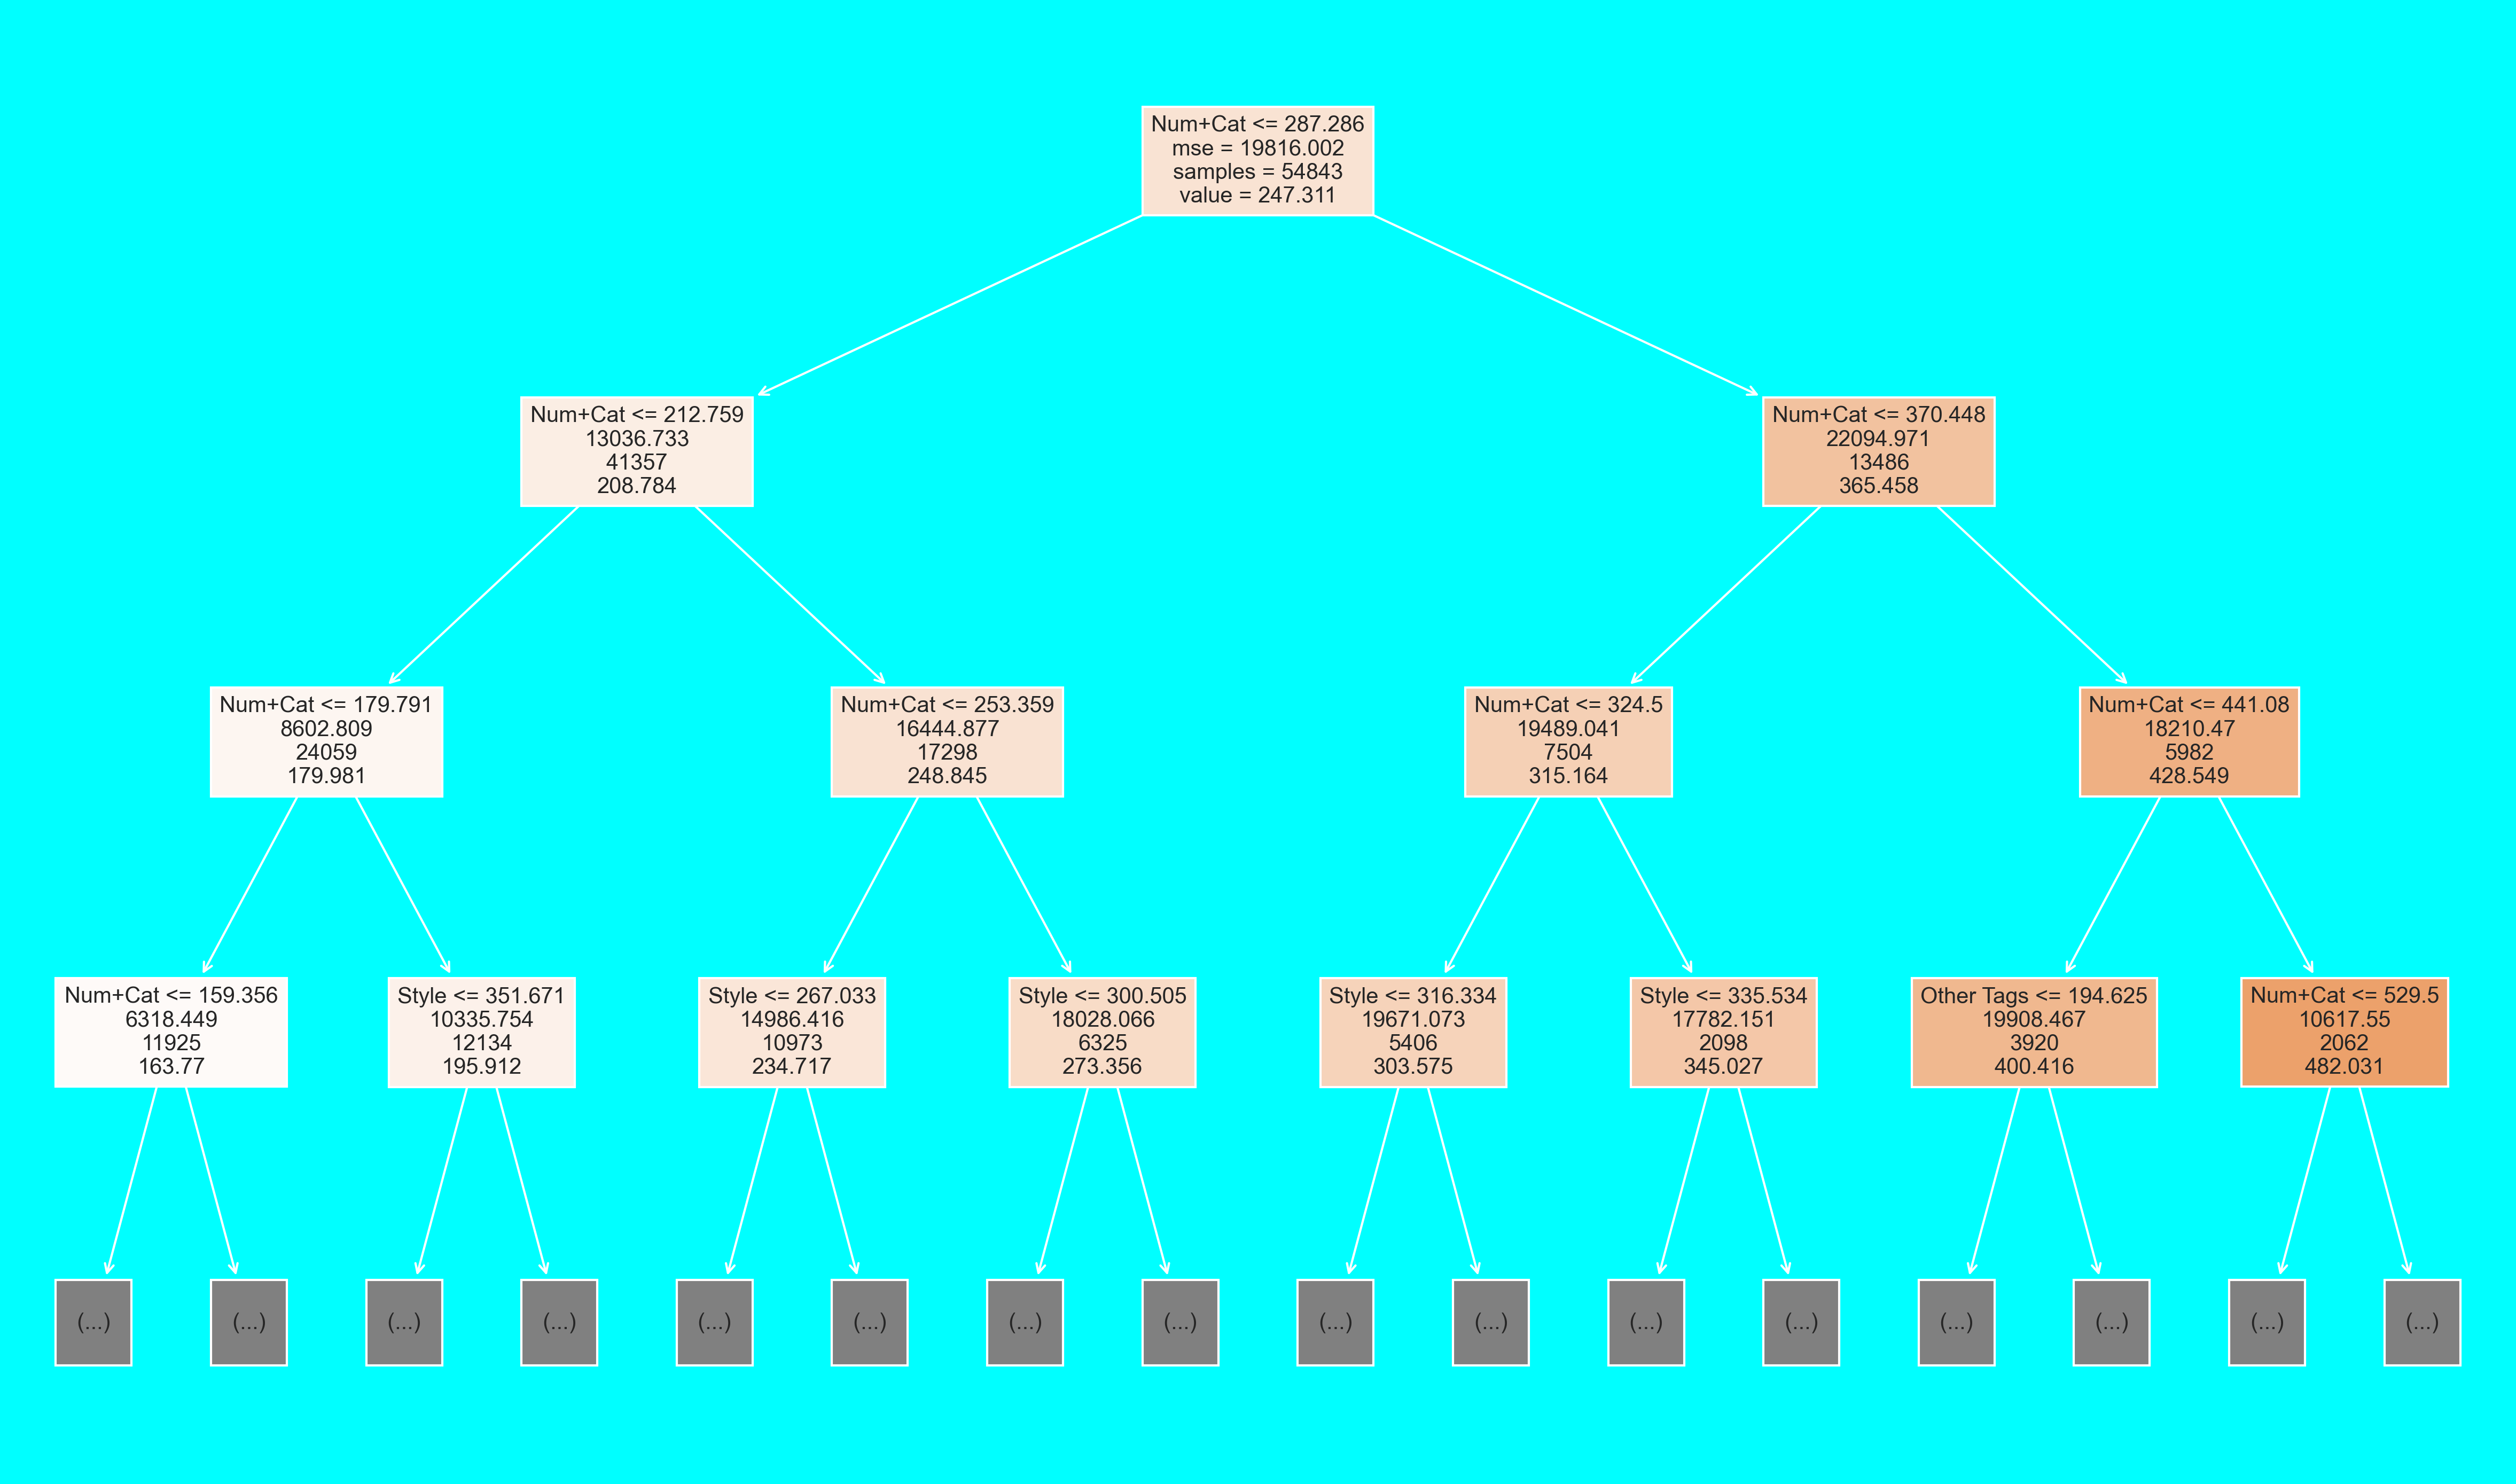

In [629]:
# Generate a plot of the decision tree
fig = plt.figure(figsize=(20,12), dpi=300)
fig.set_facecolor("cyan")
tree_viz = plot_tree(blended_model_dtree_dtree['final dtree'],max_depth=3,fontsize=10,label='root',filled=True,feature_names = individual_model_names)
fig.savefig('./Git_exclude/Figures/decision_tree_blended_model_dtree_dtree.png')

#### 7b) Blending Random Forests for numerical+categorical features, Random Forests for style tags (vectorized), Random Forests for material tags (after Tf-Idf and SVD), Random Forests for general tags (after Tf-Idf and SVD). 
#### LinearRegression or another Random Forest is used to blend the 4 models

In [630]:
#Random Forests model for numerical+categorical features

#Recall that:

# variable_selector_for_trees = ColumnTransformer([
#     ('categorical', OneHotEncoder(), categorical_columns),
#     ('boolean','passthrough', boolean_columns),
#     ('numerical','passthrough',numerical_columns)
#  ], remainder='drop')

#(I don't want to drop the first variable for tree-based models and I don't need to scale the numerical variables)

#define a pipeline with the best values found earlier 

num_plus_cat_rforest_pipe_final = Pipeline([
    ('num and cat selector', variable_selector_for_trees),
    ('rforest', RandomForestRegressor(n_estimators=50,max_features='sqrt',n_jobs=2,max_depth=10,random_state=1,max_samples=0.8))
])
#Recall that: num_plus_cat_dtree_CVmodel.best_params_['dtree__max_depth']=9 and I increased max_depth by 1 for the random forests

#Note: this model is saved as: 
#num_plus_cat_rforest_pipe_filename = './Git_exclude/models/num_plus_cat_rforest_pipe.joblib'
#(if we wanted to load it without having to refit)

num_plus_cat_rforest_trans = ModelTransformer(num_plus_cat_rforest_pipe_final)


In [631]:
#Random Forests model for style tags (with vectorized style tags (69 features) but without Tf-Idf and SVD dimensionality reduction)

# #Recall that:

# pipe_style_tags_encoding = Pipeline([
#     ('to dict series',DictEncoder()),
#     ('to binary vectors',DictVectorizer())
# ])

# style_tranform = ColumnTransformer([
#     ('style tags vectorizer', pipe_style_tags_encoding, 'style_tags_new'),
# ], remainder='drop')

# #(I did not need Tf-Idf or SVD reduction because each painting usually only has a handful of style tags, and I kept only the most common ones (69 features)
# # Both Tf-Idf and SVD reduced the performance)

#define a pipeline with the best values found earlier

style_rforest_pipe_final = Pipeline([
    ('style tags vectorization', style_tranform),
    ('rforest', RandomForestRegressor(n_estimators=100,max_features='sqrt',n_jobs=2,max_depth=13,random_state=1,max_samples=0.8))
])

#Recall that: style_dtree_CVmodel.best_params_['dtree__max_depth']=12 and I increased max_depth by 1 for the random forests

#Note: this model is saved as: 
#style_rforest_pipe_filename = './Git_exclude/models/style_rforest_pipe.joblib'
#(if we wanted to load it without having to refit)

style_tags_rforest_trans = ModelTransformer(style_rforest_pipe_final)


In [632]:
#Random Forests model for material tags (with Tf-Idf of the original 100 tags + bigrams (that occur in very different frequencies) and SVD dimensionality reduction

# #Recall that:

# pipe_tags_encoding = Pipeline([
#     ('to single string',TagsEncoder()),
#     ('to tfidf n-grams',TfidfVectorizer(ngram_range=(1, 2)))
# ])

# materials_tags_tranform = ColumnTransformer([
#     ('materials tags tfidf', pipe_tags_encoding, 'materials_tags_new'),
# ], remainder='drop')


#define a pipeline with the best values found earlier

materials_rforest_w_tfidf_SVD_pipe_final = Pipeline([
    ('tags tfidf vectorization', materials_tags_tranform),
    ('SVD', TruncatedSVD(n_components=40)),
    ('rforest', RandomForestRegressor(n_estimators=100,max_features='sqrt',n_jobs=2,max_depth=7,random_state=1,max_samples=0.8))
])

#Recall that: materials_dtree_w_tfidf_SVD_CVmodel.best_params_['dtree__max_depth']=6 and I increased max_depth by 1 for the random forests

#Note: this model is saved as: 
#materials_rforest_w_tfidf_SVD_pipe_filename = './Git_exclude/models/materials_rforest_w_tfidf_SVD_pipe.joblib'
#(if we wanted to load it without having to refit)

materials_tags_rforest_trans = ModelTransformer(materials_rforest_w_tfidf_SVD_pipe_final)

In [633]:
#Random Forests model for general tags (with Tf-Idf of the original tags + bigrams and SVD dimensionality reduction

# #Recall that:

# pipe_tags_encoding_with_stopwords = Pipeline([
#     ('to single string',TagsEncoder()),
#     ('to tfidf n-grams',TfidfVectorizer(min_df=100,max_df=0.8,stop_words=tags_stopwords,ngram_range=(1, 2),max_features=1000))
# ])

# tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding_with_stopwords, 'tags_new'),
# ], remainder='drop')


#define a pipeline with the best values found earlier 

tags_rforest_w_tfidf_SVD_pipe_final = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('SVD', TruncatedSVD(n_components=50)),
    ('rforest', RandomForestRegressor(n_estimators=100,max_features='sqrt',n_jobs=2,max_depth=7,random_state=1,max_samples=0.8))
])

#Recall that: tags_dtree_w_tfidf_SVD_CVmodel.best_params_['dtree__max_depth']=6 and I increased max_depth by 1 for the random forests


#Note: this model is saved as: 
#tags_rforest_w_tfidf_SVD_pipe_filename = './Git_exclude/models/tags_rforest_w_tfidf_SVD_pipe.joblib'
#(if we wanted to load it without having to refit)

tags_rforest_trans = ModelTransformer(tags_rforest_w_tfidf_SVD_pipe_final)

In [634]:
#Let's now combine the 4 predictors-transformers into a feature union.

In [635]:
from sklearn.pipeline import FeatureUnion

rforest_models_union = FeatureUnion([
        ('num plus cat model', num_plus_cat_rforest_trans),
        ('style tags model',style_tags_rforest_trans),
        ('materials tags model',materials_tags_rforest_trans),
        ('other tags model',tags_rforest_trans),
    ])

In [636]:
rforest_models_union

FeatureUnion(transformer_list=[('num plus cat model',
                                ModelTransformer(model=None)),
                               ('style tags model',
                                ModelTransformer(model=None)),
                               ('materials tags model',
                                ModelTransformer(model=None)),
                               ('other tags model',
                                ModelTransformer(model=None))])

#### LinearRegression blending the 4 random forest models

In [637]:
from sklearn.linear_model import LinearRegression

#note: there is no need of scaling because the output of each transformer is a price prediction in this case,
#and thus all columns are in the same unit and comparable with each other.

blended_model_rforest_linear = Pipeline([
    ('individual rforest models', rforest_models_union),
    ('linear combination', LinearRegression())
])
blended_model_rforest_linear

Pipeline(steps=[('individual rforest models',
                 FeatureUnion(transformer_list=[('num plus cat model',
                                                 ModelTransformer(model=None)),
                                                ('style tags model',
                                                 ModelTransformer(model=None)),
                                                ('materials tags model',
                                                 ModelTransformer(model=None)),
                                                ('other tags model',
                                                 ModelTransformer(model=None))])),
                ('linear combination', LinearRegression())])

In [638]:
#Train and possibly save the model.
#This is going to fit each of the four models, then fit the best linear combination coefficients
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

blended_model_rforest_linear_filename = './Git_exclude/models/blended_model_rforest_linear.joblib'

#If the model file already exists, I load it:
try:
    with open(blended_model_rforest_linear_filename, 'rb') as f:
        blended_model_rforest_linear = load(f)
        print('Loaded joblib file with linear blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    blended_model_rforest_linear.fit(paintings_df_train,prices_train);
    
    with open(blended_model_rforest_linear_filename, 'wb') as f:
        dump(blended_model_rforest_linear, blended_model_rforest_linear_filename) 
        print('Saved joblib file with linear blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags.')

Loaded joblib file with linear blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags.


In [639]:
#Here are the weights learnt for each of the individual models:
blended_model_rforest_linear['linear combination'].coef_

array([1.11505756, 0.46783223, 0.1337407 , 0.30742652])

In [640]:
#Predict prices on training set:
prices_train_pred = blended_model_rforest_linear.predict(paintings_df_train)
#And return the R2 score as follows:
blended_model_rforest_linear.score(paintings_df_train,prices_train)

0.39582375278306925

In [641]:
#Predict prices on test set:
prices_test_pred = blended_model_rforest_linear.predict(paintings_df_test)
#And return the R2 score as follows:
blended_model_rforest_linear.score(paintings_df_test,prices_test)

0.35312120573055894

In [642]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Linear blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags')


Linear blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags:
Training R^2: 0.39582375278306925
Testing R^2: 0.35312120573055894
Training RMSE: USD 109.41827091299915
Testing RMSE: USD 114.32550361570883
Training MAE: USD 82.70791501474118
Testing MAE: USD 86.04082126093002


#### Final Random Forest blending the 4 random forest models

In [643]:

blended_model_rforest_rforest = Pipeline([
    ('individual rforest models', rforest_models_union),
    ('final rforest', RandomForestRegressor(n_estimators=50,max_features='sqrt',n_jobs=2,max_depth=4,random_state=1,max_samples=0.8))
])
blended_model_rforest_rforest

Pipeline(steps=[('individual rforest models',
                 FeatureUnion(transformer_list=[('num plus cat model',
                                                 ModelTransformer(model=None)),
                                                ('style tags model',
                                                 ModelTransformer(model=None)),
                                                ('materials tags model',
                                                 ModelTransformer(model=None)),
                                                ('other tags model',
                                                 ModelTransformer(model=None))])),
                ('final rforest',
                 RandomForestRegressor(max_depth=4, max_features='sqrt',
                                       max_samples=0.8, n_estimators=50,
                                       n_jobs=2, random_state=1))])

In [644]:
#Train and possibly save the model.
#This is going to fit each of the four models, then fit the best decision tree
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

blended_model_rforest_rforest_filename = './Git_exclude/models/blended_model_rforest_rforest.joblib'

#If the model file already exists, I load it:
try:
    with open(blended_model_rforest_rforest_filename, 'rb') as f:
        blended_model_rforest_rforest = load(f)
        print('Loaded joblib file with rforest blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    blended_model_rforest_rforest.fit(paintings_df_train,prices_train);
    
    with open(blended_model_rforest_rforest_filename, 'wb') as f:
        dump(blended_model_rforest_rforest, blended_model_rforest_rforest_filename) 
        print('Saved joblib file with rforest blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags.')

Loaded joblib file with rforest blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags.


In [645]:
#Predict prices on training set:
prices_train_pred = blended_model_rforest_rforest.predict(paintings_df_train)
#And return the R2 score as follows:
blended_model_rforest_rforest.score(paintings_df_train,prices_train)

0.3976771975362353

In [646]:
#Predict prices on test set:
prices_test_pred = blended_model_rforest_rforest.predict(paintings_df_test)
#And return the R2 score as follows:
blended_model_rforest_rforest.score(paintings_df_test,prices_test)

0.35221140433925224

In [647]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Rforest blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags')


Rforest blended model of random forests for numerical+categorical variables, style tags, materials tags and other tags:
Training R^2: 0.3976771975362353
Testing R^2: 0.35221140433925224
Training RMSE: USD 109.25030958206156
Testing RMSE: USD 114.40587180560217
Training MAE: USD 83.69300496201471
Testing MAE: USD 87.09890059509046


In [648]:
#what are the main features used by the final decision tree?
blended_model_rforest_rforest['final rforest'].feature_importances_

array([0.79840761, 0.07334734, 0.07784829, 0.05039677])

In [649]:
individual_model_names = ['Num+Cat','Style','Materials','Other Tags']

blended_model_rforest_rforest_features_imp_df = pd.DataFrame(blended_model_rforest_rforest['final rforest'].feature_importances_,individual_model_names,columns=['Rforest feature importance'])
blended_model_rforest_rforest_features_imp_df = blended_model_rforest_rforest_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
blended_model_rforest_rforest_features_imp_df

Rforest feature importance
Num+Cat                       0.798408
Materials                     0.077848
Style                         0.073347
Other Tags                    0.050397

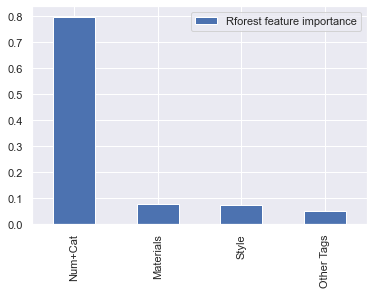

In [872]:
blended_model_rforest_rforest_features_imp_df.plot(kind="bar").legend(loc="upper right");

#### 7c) Ensemble model in which the individual models are in a cascade rather than in parallel (as opposed to the blended models showed above)

In [873]:
#Build a custom predictor that takes as an argument two other predictors. 
#It should use the first to fit the raw data and the second to fit the residuals of the first.

In [874]:
class CascadePredictor(BaseEstimator, RegressorMixin):
  def __init__(self, Predictor1, Predictor2):
    # initialization code
    self.predictor1 = Predictor1
    self.predictor2 = Predictor2

  def fit(self, X, y):
    # fit the model:
    self.predictor1.fit(X, y)
    res = y - np.array(self.predictor1.predict(X))
    self.predictor2.fit(X, res)
    return self

  def predict(self, X):
    # make predictions 
    return np.array(self.predictor1.predict(X)) + np.array(self.predictor2.predict(X))

  #def score(self, X, y):
  #  # custom score implementation
  #  # this is optional, if not defined default is R^2
  #  return ...

#### Let's try the numerical+categorical random forest model followed by the style-tags based random forest model 

In [875]:
cascade_model_numcat_style = CascadePredictor(Predictor1=num_plus_cat_rforest_pipe_final,Predictor2=style_rforest_pipe_final)

In [876]:
#Train and possibly save the model.
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

cascade_model_numcat_style_filename = './Git_exclude/models/cascade_model_numcat_style.joblib'

#If the model file already exists, I load it:
try:
    with open(cascade_model_numcat_style_filename, 'rb') as f:
        cascade_model_numcat_style = load(f)
        print('Loaded joblib file with cascaded model of random forests for numerical+categorical variables, followed by style tags.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    cascade_model_numcat_style.fit(paintings_df_train,prices_train);
    
    with open(cascade_model_numcat_style_filename, 'wb') as f:
        dump(cascade_model_numcat_style, cascade_model_numcat_style_filename) 
        print('Saved joblib file with cascaded model of random forests for numerical+categorical variables, followed by style tags.')

Loaded joblib file with cascaded model of random forests for numerical+categorical variables, followed by style tags.


In [878]:
cascade_model_numcat_style

CascadePredictor(Predictor1=None, Predictor2=None)

In [879]:
#Predict prices on training set:
prices_train_pred = cascade_model_numcat_style.predict(paintings_df_train)
#And return the R2 score as follows:
cascade_model_numcat_style.score(paintings_df_train,prices_train)

0.3982028798807745

In [880]:
#Predict prices on test set:
prices_test_pred = cascade_model_numcat_style.predict(paintings_df_test)
#And return the R2 score as follows:
cascade_model_numcat_style.score(paintings_df_test,prices_test)

0.35663540611109

In [881]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Cascaded model of random forests for numerical+categorical variables followed by style tags')


Cascaded model of random forests for numerical+categorical variables followed by style tags:
Training R^2: 0.3982028798807745
Testing R^2: 0.35663540611109
Training RMSE: USD 109.20262460736168
Testing RMSE: USD 114.01454129330135
Training MAE: USD 83.68830962311601
Testing MAE: USD 86.90350890517885


In [882]:
#Does it do better than the numerical+categorical features alone?
print('Compare with Random Forests using numerical+categorical features alone:')
num_plus_cat_rforest_pipe_final.fit(paintings_df_train,prices_train);
print('Training R^2:')
print(num_plus_cat_rforest_pipe_final.score(paintings_df_train,prices_train))
print('Testing R^2:')
print(num_plus_cat_rforest_pipe_final.score(paintings_df_test,prices_test))

Compare with Random Forests using numerical+categorical features alone:
Training R^2:
0.3709040680366238
Testing R^2:
0.3372104990789736


#### Let's try the numerical+categorical random forest model followed by the materials-tags based random forest model 

In [884]:
cascade_model_numcat_materials = CascadePredictor(Predictor1=num_plus_cat_rforest_pipe_final,Predictor2=materials_rforest_w_tfidf_SVD_pipe_final)

In [885]:
#Train and possibly save the model.
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

cascade_model_numcat_materials_filename = './Git_exclude/models/cascade_model_numcat_materials.joblib'

#If the model file already exists, I load it:
try:
    with open(cascade_model_numcat_materials_filename, 'rb') as f:
        cascade_model_numcat_materials = load(f)
        print('Loaded joblib file with cascaded model of random forests for numerical+categorical variables, followed by materials tags.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    cascade_model_numcat_materials.fit(paintings_df_train,prices_train);
    
    with open(cascade_model_numcat_materials_filename, 'wb') as f:
        dump(cascade_model_numcat_materials, cascade_model_numcat_materials_filename) 
        print('Saved joblib file with cascaded model of random forests for numerical+categorical variables, followed by materials tags.')

Saved joblib file with cascaded model of random forests for numerical+categorical variables, followed by materials tags.


In [886]:
cascade_model_numcat_materials

CascadePredictor(Predictor1=None, Predictor2=None)

In [887]:
#Predict prices on training set:
prices_train_pred = cascade_model_numcat_materials.predict(paintings_df_train)
#And return the R2 score as follows:
cascade_model_numcat_materials.score(paintings_df_train,prices_train)

0.38992667500416933

In [888]:
#Predict prices on test set:
prices_test_pred = cascade_model_numcat_materials.predict(paintings_df_test)
#And return the R2 score as follows:
cascade_model_numcat_materials.score(paintings_df_test,prices_test)

0.34780707784049136

In [889]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Cascaded model of random forests for numerical+categorical variables followed by materials tags')


Cascaded model of random forests for numerical+categorical variables followed by materials tags:
Training R^2: 0.38992667500416933
Testing R^2: 0.34780707784049136
Training RMSE: USD 109.95096414969085
Testing RMSE: USD 114.79413677486819
Training MAE: USD 84.32438242044418
Testing MAE: USD 87.56841710965392


In [890]:
#So the results are very similar to the ones of the blended model, and in all cases the numerical+categorical features capture most of the
#variance (35%-37%) and then the style tags (and a bit less so the materials tags) capture another 2-3% of the variance

## 8) Nearest Neighbors Regression (mostly to find comparable paintings)

In [651]:
#I need to have all features in comparable scales (e.g. within 0 and 1)

In [652]:
#For the categorical and numerical variables, I just need to MinMaxScale the numerical variables,
#since the boolean and categorical variables are already within [0,1]

num_plus_cat_selector_with_scaling = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns),
    ('boolean','passthrough', boolean_columns),
     ('numerical',MinMaxScaler(),numerical_columns)
  ], remainder='drop')

num_plus_cat_scaling_pipe = Pipeline([('num and cat preproc', num_plus_cat_selector_with_scaling)])



In [653]:
#The style tags, since I am using a DictVectorizer without Tf-Idf and SVD reduction, are also already in the [0,1] range:

# #Recall that:

# pipe_style_tags_encoding = Pipeline([
#     ('to dict series',DictEncoder()),
#     ('to binary vectors',DictVectorizer())
# ])

# style_tranform = ColumnTransformer([
#     ('style tags vectorizer', pipe_style_tags_encoding, 'style_tags_new'),
# ], remainder='drop')


In [654]:
#The materials and general tags, instead, go through Tf-Idf and SVD dimensionality reduction, so they are not guaranteed to be within 0 and 1
#We just need to add a MinMaxScaler at the end

# #Recall that for the materials tags:

# pipe_tags_encoding = Pipeline([
#     ('to single string',TagsEncoder()),
#     ('to tfidf n-grams',TfidfVectorizer(ngram_range=(1, 2)))
# ])

# materials_tags_tranform = ColumnTransformer([
#     ('materials tags tfidf', pipe_tags_encoding, 'materials_tags_new'),
# ], remainder='drop')


materials_tags_SVD_scaling_pipe = Pipeline([
    ('tags tfidf vectorization', materials_tags_tranform),
    ('SVD', TruncatedSVD(n_components=40)),
    ('scaling', MinMaxScaler())
])


# #Recall that for general tags:

# pipe_tags_encoding_with_stopwords = Pipeline([
#     ('to single string',TagsEncoder()),
#     ('to tfidf n-grams',TfidfVectorizer(min_df=100,max_df=0.8,stop_words=tags_stopwords,ngram_range=(1, 2),max_features=1000))
# ])

# tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding_with_stopwords, 'tags_new'),
# ], remainder='drop')

tags_SVD_scaling_pipe = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('SVD', TruncatedSVD(n_components=50)),
    ('scaling', MinMaxScaler())
])



In [655]:
#We can use a feature union to provide all the appropriately scaled variables to KNN:
all_scaled_features_union = FeatureUnion([
        ('num plus cat features', num_plus_cat_selector_with_scaling),
        ('style tags features', style_tranform),
        ('materials tags features',materials_tags_SVD_scaling_pipe),
        ('other tags features', tags_SVD_scaling_pipe),
    ])

In [656]:
#I can now pass this to a KNN-regressor (which will also compute nearest neighbors in the process):

from sklearn.neighbors import KNeighborsRegressor

knn_pipe = Pipeline([
    ('all scaled features', all_scaled_features_union),
    ('knn', KNeighborsRegressor(n_neighbors=5,n_jobs=2))
])

In [657]:
#I want to cross-validate the choice of number of neighbors that make sense:
from sklearn.model_selection import GridSearchCV

param_grid = {'knn__n_neighbors': range(1, 22, 4)} 
knn_CVmodel = GridSearchCV(knn_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [658]:
#Train the model.
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

knn_CVmodel_filename = './Git_exclude/models/knn_CVmodel.joblib'

#If the model file already exists, I load it:
try:
    with open(knn_CVmodel_filename, 'rb') as f:
        knn_CVmodel = load(f)
        print('Loaded joblib file with cross-validated KNN regression using scaled tags, numerical+categorical variables.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    knn_CVmodel.fit(paintings_df_train,prices_train)
    
    with open(knn_CVmodel_filename, 'wb') as f:
        dump(knn_CVmodel, knn_CVmodel_filename) 
        print('Saved joblib file with cross-validated KNN regression using scaled tags, numerical+categorical variables.')

Loaded joblib file with cross-validated KNN regression using scaled tags, numerical+categorical variables.


In [659]:
knn_CVmodel.best_params_

{'knn__n_neighbors': 13}

In [660]:
knn_CVmodel

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('all scaled features',
                                        FeatureUnion(transformer_list=[('num '
                                                                        'plus '
                                                                        'cat '
                                                                        'features',
                                                                        ColumnTransformer(transformers=[('categorical',
                                                                                                         OneHotEncoder(),
                                                                                                         ['painting_type',
                                                                                                          'when_made']),
                                                                                                        ('boolean',
                                                                                                         'passthrough',
                                                                                                         ['made_by_seller',
                                                                                                          'is_customizable',
                                                                                                          'has_variations']),
                                                                                                        ('numerical',
                                                                                                         MinMaxScaler(),
                                                                                                         ['num_favorers',
                                                                                                          'feature...
                                                                                                                                                                       'painted',
                                                                                                                                                                       'illustration',
                                                                                                                                                                       'picture',
                                                                                                                                                                       'drawing',
                                                                                                                                                                       'color',
                                                                                                                                                                       'colors',
                                                                                                                                                                       'colored',
                                                                                                                                                                       'colorful',
                                                                                                                                                                       'and',
                                                                                                                                                                       'on',
                                                                                                                                                                       'one',
                                                                        

In [661]:
# #This takes long to compute and it's not critical, so I commented it. Result was 0.33505 
# #Predict prices on training set:
# prices_train_pred = knn_CVmodel.predict(paintings_df_train)
# #And return the R2 score as follows:
# knn_CVmodel.score(paintings_df_train,prices_train)

0.3350566117277747

In [662]:
# #This takes long to compute and it's not critical, so I commented it. Result was 0.23848 
# #Predict prices on test set:
# prices_test_pred = knn_CVmodel.predict(paintings_df_test)
# #And return the R2 score as follows:
# knn_CVmodel.score(paintings_df_test,prices_test)

0.23848296374101163

In [707]:
# #Print results using the function defined earlier:

# print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='K nearest neighbors regression for all (scaled) tags, numerical+categorical variables')


In [664]:
#Let's see how to obtain the neighbors of a painting that is the real use of KNN in this project
paintings_df_test.iloc[0]

listing_id                                                             671254913
user_id                                                                 89682024
shop_id                                                                 14453345
title                          Red Apples - Still Life Oil Painting 14 x 11  ...
description                    Red Apples is an original still life Oil paint...
shop_section_id                                                       20899385.0
featured_rank                                                                 -1
url                            https://www.etsy.com/listing/671254913/red-app...
num_favorers                                                                   0
is_customizable                                                            False
shipping_profile_id                                                36934670265.0
when_made                                                             made_2010s
has_variations              

In [665]:
#This is how you would check for the nearest neighbors of a test painting:
#1) Compute the features for that painting: (note that here I am computing features for the whole test set just to speed things up)
features_paintings_df_test = knn_CVmodel.best_estimator_['all scaled features'].transform(paintings_df_test)
features_paintings_df_test


<13711x177 sparse matrix of type '<class 'numpy.float64'>'
	with 1379656 stored elements in Compressed Sparse Row format>

In [666]:
features_paintings_df_test.shape

(13711, 177)

In [667]:
len(paintings_df_test)

13711

In [668]:
features_paintings_df_test.shape[0]

13711

In [669]:
#2) Pass the features to the 'kneighbors' method of the KNN regressor (note that reshape(1,-1) is needed by the method, if there is a single feature array):
num_neighbors_to_return = 10 
neigh_dist_test0, neigh_ind_test0 = knn_CVmodel.best_estimator_['knn'].kneighbors(features_paintings_df_test[0].reshape(1, -1),num_neighbors_to_return,return_distance=True)

In [670]:
neigh_dist_test0

array([[0.32360818, 0.51580587, 0.52407276, 0.55623248, 0.59663686,
        0.63503364, 0.64011476, 0.64273512, 0.64941467, 0.67851645]])

In [671]:
neigh_ind_test0

array([[ 8253, 10579, 10172, 21733,  9958, 15746, 17946, 33332, 43134,
        22131]], dtype=int64)

In [672]:
#here are the details of the nearest neighbors:
paintings_df_train.iloc[neigh_ind_test0[0]]

listing_id    user_id   shop_id  \
20663   698287199   89682024  14453345   
1054    670517334  201894727  19562056   
40287   467341208    5681702   5262301   
26039   832016581  321525100  23811870   
9350    507802607   89682024  14453345   
53139   545584136   21092657   6868078   
618     593719795  102613330  14511026   
59875   805425405  286787624  22859943   
54876   629611886    9414042   5819608   
21529   829947467  321525100  23811870   

                                                   title  \
20663  Lunch - Still Life Oil Painting 12 x 12  on St...   
1054      Red Onion and Silver Cup original oil on panel   
40287  Rose in Mason Ball Jar Amber Glass Oil Paintin...   
26039  Colorful Carrots an Original Oil Painting by P...   
9350   Yellow Flower - Oil Painting on Panel by Janet...   
53139             Oni and Glass Frog still life painting   
618    Still life inspired by Bakhchisaray Palace, Cr...   
59875                                   Cups With Strips   
54876                        Black Bear in a Forest Fire   
21529  Pink Peony an Original Oil Painting by Pat Huf...   

                                             description  shop_section_id  \
20663  Lunch is an original still life Oil painting o...       20899385.0   
1054   Original Fine Art Oil Painting on Panel.  Sold...       25723995.0   
40287  12&quot; x 12&quot; Oil painting on stretched ...              NaN   
26039  Colorful Carrots is an original oil painting b...       29343841.0   
9350   This is an Original Oil Painting on Canvas Pan...       20913403.0   
53139  &quot;Oni and Glass Frog&quot; is an oil on pa...       11595929.0   
618    Crimea is home to the Bakhchisaray Palace, res...              NaN   
59875  Oil painting of fast food/disposable cups with...              NaN   
54876  This striking portrait of a black bear feature...        6937727.0   
21529  Pink Peony is an original oil painting by Pat ...       29343841.0   

       featured_rank                                                url  \
20663             -1  https://www.etsy.com/listing/698287199/lunch-s...   
1054              -1  https://www.etsy.com/listing/670517334/red-oni...   
40287             -1  https://www.etsy.com/listing/467341208/rose-in...   
26039             -1  https://www.etsy.com/listing/832016581/colorfu...   
9350              -1  https://www.etsy.com/listing/507802607/yellow-...   
53139              0  https://www.etsy.com/listing/545584136/oni-and...   
618               -1  https://www.etsy.com/listing/593719795/still-l...   
59875             -1  https://www.etsy.com/listing/805425405/cups-wi...   
54876             -1  https://www.etsy.com/listing/629611886/black-b...   
21529             -1  https://www.etsy.com/listing/829947467/pink-pe...   

       num_favorers  is_customizable  ...  max_dimension   area  aspect_ratio  \
20663             1            False  ...           14.0  196.0      1.000000   
1054              1            False  ...            9.0   63.0      1.285714   
40287             5            False  ...           15.0  195.0      1.153846   
26039             2            False  ...           12.0  120.0      1.200000   
9350              0            False  ...           12.0  120.0      1.200000   
53139             5            False  ...           20.0  320.0      1.250000   
618              32            False  ...           16.0  224.0      1.142857   
59875             0            False  ...           30.0  720.0      1.250000   
54876             8            False  ...           16.0  224.0      1.142857   
21529             0            False  ...           10.0  100.0      1.000000   

       weight  days_from_original_creation  made_by_seller  painting_type  \
20663   112.0                          993            True            oil   
1054     16.0                         1045            True            oil   
40287    38.0                         1924            True            oil   
26039    

In [673]:
#sanity check that a painting in the training set should find itself as the closest neighbor
features_paintings_df_train = knn_CVmodel.best_estimator_['all scaled features'].transform(paintings_df_train)
features_paintings_df_train

num_neighbors_to_return = 10 
neigh_dist_train0, neigh_ind_train0 = knn_CVmodel.best_estimator_['knn'].kneighbors(features_paintings_df_train[0].reshape(1, -1),num_neighbors_to_return,return_distance=True)

In [674]:
neigh_ind_train0

array([[    0,  2756,  1321, 47534, 41840, 32147, 43386,   782,  1354,
        20657]], dtype=int64)

In [675]:
neigh_dist_train0

array([[0.02401873, 1.9135549 , 2.01511572, 2.15032875, 2.20212538,
        2.21296411, 2.22412088, 2.28152916, 2.28457533, 2.32932444]])

In [676]:
#What if I pass all test paintings at once?
num_neighbors_to_return = 10 
neigh_dist_test, neigh_ind_test = knn_CVmodel.best_estimator_['knn'].kneighbors(features_paintings_df_test,num_neighbors_to_return,return_distance=True)

In [677]:
neigh_dist_test.shape

(13711, 10)

In [678]:
#each row returns the distance of the 10 closest neighbors, in increasing order, e.g.
neigh_dist_test[13]

array([0.33885186, 0.7899079 , 0.9194741 , 0.98841011, 0.98905902,
       0.99472635, 0.99554584, 1.03378362, 1.05938885, 1.08556989])

In [679]:
#hence this gives me the min distance between any test painting and the closest training set painting
neigh_dist_test[:,0]

array([0.32360818, 0.86096369, 0.19001147, ..., 0.00913638, 1.31178655,
       0.02965326])

In [680]:
#and this is the closest distance between any pair testing vs training paintings
np.min(neigh_dist_test[:,0])

0.00026052702725949824

In [681]:
#How come it's so small? Are there duplicate paintings in test vs train set?
#No, but there may be paintings that are identical in terms of all dimensions and tags because they are made by the same person and done in a series
#That is expected and acceptable since I don't use image data at this point, but I shouldn't show examples like this in the demo as it's a bit of an edge case.
#In general, when assessing a new painting there's not going to be already one in the training set that's very close to it. 

In [682]:
test_painting_closest_to_train = np.argmin(neigh_dist_test[:,0])

In [683]:
paintings_df_test.iloc[test_painting_closest_to_train]

listing_id                                                            1077598075
user_id                                                                250463589
shop_id                                                                 21452263
title                          SALE On Time Woman 36&quot;H X 24&quot;W X 0.7...
description                    SALE ON TIME WOMAN 24&quot;W X 36&quot;H X 0.7...
shop_section_id                                                       33992834.0
featured_rank                                                                 -1
url                            https://www.etsy.com/listing/1077598075/sale-o...
num_favorers                                                                   0
is_customizable                                                            False
shipping_profile_id                                                          NaN
when_made                                                             made_2010s
has_variations              

In [684]:
#its closest neighbor is:
train_painting_closest_to_test = neigh_ind_test[test_painting_closest_to_train][0]
train_painting_closest_to_test

2383

In [685]:
paintings_df_train.iloc[train_painting_closest_to_test]

listing_id                                                            1063651572
user_id                                                                250463589
shop_id                                                                 21452263
title                          SALE Umbrella Women 36&quot;H X 24&quot;W X 0....
description                    SALE UMBRELLA WOMAN 24&quot;W X 36&quot;H X 0....
shop_section_id                                                       33992834.0
featured_rank                                                                 -1
url                            https://www.etsy.com/listing/1063651572/sale-u...
num_favorers                                                                   0
is_customizable                                                            False
shipping_profile_id                                                          NaN
when_made                                                             made_2010s
has_variations              

In [686]:
#Before moving on to the display of results, let's save the precomputed nearest neighbors of each test painting for the demo since those are usually slow to compute in real time

In [687]:
#Note: min_price is already defined at the beginning of the file (either 100.0 for the larger dataset, or 250,0 for the smaller set)

nearest_neighbors_indices_paintings_test_filename = f'./Git_exclude/models/nearestneighbors_paintings_from_USD{int(min_price)}_test.joblib'

#If the file already exists, I load it:
try:
    with open(nearest_neighbors_indices_paintings_test_filename, 'rb') as f:
        neigh_ind_test = load(f)
        print(f'Loaded joblib file {nearest_neighbors_indices_paintings_test_filename} with indices for 10 nearest neighbors for all paintings USD{int(min_price)} and up used for testing the initial models.')
except FileNotFoundError: #if not, actually save the indices for next time:
    with open(nearest_neighbors_indices_paintings_test_filename, 'wb') as f:
        dump(neigh_ind_test, nearest_neighbors_indices_paintings_test_filename) 
        print(f'Saved joblib file {nearest_neighbors_indices_paintings_test_filename} with indices for 10 nearest neighbors for all paintings USD{int(min_price)} and up used for testing the initial models.')

Loaded joblib file ./Git_exclude/models/nearestneighbors_paintings_from_USD100_test.joblib with indices for 10 nearest neighbors for all paintings USD100 and up used for testing the initial models.


In [688]:
#Also save the paintings_df_train and paintings_df_test dataframes for the demo

In [689]:
from joblib import dump, load

paintings_df_train_filename = f'./Git_exclude/models/paintings_from_USD{int(min_price)}_df_train.joblib'

#If the file already exists, I load it:
try:
    with open(paintings_df_train_filename, 'rb') as f:
        paintings_df_train = load(f)
        print(f'Loaded joblib file {paintings_df_train_filename} with dataframe of paintings USD{int(min_price)} and up used for training the initial models.')
except FileNotFoundError: #if not, actually save the model for next time:
    with open(paintings_df_train_filename, 'wb') as f:
        dump(paintings_df_train, paintings_df_train_filename) 
        print(f'Saved joblib file {paintings_df_train_filename} with dataframe of paintings USD{int(min_price)} and up used for training the initial models.')

Loaded joblib file ./Git_exclude/models/paintings_from_USD100_df_train.joblib with dataframe of paintings USD100 and up used for training the initial models.


In [690]:
paintings_df_test_filename = f'./Git_exclude/models/paintings_from_USD{int(min_price)}_df_test.joblib'

#If the file already exists, I load it:
try:
    with open(paintings_df_test_filename, 'rb') as f:
        paintings_df_test = load(f)
        print(f'Loaded joblib file {paintings_df_test_filename} with dataframe of paintings USD{int(min_price)} and up used for testing the initial models.')
except FileNotFoundError: #if not, actually save the model for next time:
    with open(paintings_df_test_filename, 'wb') as f:
        dump(paintings_df_test, paintings_df_test_filename) 
        print(f'Saved joblib file {paintings_df_test_filename} with dataframe of paintings USD{int(min_price)} and up used for testing the initial models.')

Loaded joblib file ./Git_exclude/models/paintings_from_USD100_df_test.joblib with dataframe of paintings USD100 and up used for testing the initial models.


## 9) Other models computed combining all (scaled and dimensionality-reduced) features at once (like KNN regressor)

In [691]:
# #Recall we already have a feature union that provides all the appropriately scaled variables (from the KNN model):
# all_scaled_features_union = FeatureUnion([
#         ('num plus cat features', num_plus_cat_selector_with_scaling),
#         ('style tags features', style_tranform),
#         ('materials tags features',materials_tags_SVD_scaling_pipe),
#         ('other tags features', tags_SVD_scaling_pipe),
#     ])

### 9a) Ridge Regression using all features

In [692]:
#I can now pass this to a Ridge Regression model, which is usually good at handling many features:

ridge_pipe_allfeatures = Pipeline([
    ('all scaled features', all_scaled_features_union),
    ('ridge', Ridge(alpha=10))
])

In [693]:
#I want to cross-validate the choice of max depth and num estimators that make sense:
from sklearn.model_selection import GridSearchCV

param_grid = {'ridge__alpha': np.logspace(-2, 2, 10)} 
ridge_CVmodel_allfeatures = GridSearchCV(ridge_pipe_allfeatures, param_grid, cv=5, n_jobs=2, verbose=1)

In [694]:
#Train the model.
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

ridge_CVmodel_allfeatures_filename = './Git_exclude/models/ridge_CVmodel_allfeatures.joblib'

#If the model file already exists, I load it:
try:
    with open(ridge_CVmodel_allfeatures_filename, 'rb') as f:
        ridge_CVmodel_allfeatures = load(f)
        print('Loaded joblib file with cross-validated Ridge regression using all scaled tags, numerical+categorical variables.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    ridge_CVmodel_allfeatures.fit(paintings_df_train,prices_train)
    
    with open(ridge_CVmodel_allfeatures_filename, 'wb') as f:
        dump(ridge_CVmodel_allfeatures, ridge_CVmodel_allfeatures_filename) 
        print('Saved joblib file with cross-validated Ridge regression using all scaled tags, numerical+categorical variables.')

Loaded joblib file with cross-validated Ridge regression using all scaled tags, numerical+categorical variables.


In [695]:
ridge_CVmodel_allfeatures.best_params_

{'ridge__alpha': 0.027825594022071243}

In [696]:
ridge_CVmodel_allfeatures

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('all scaled features',
                                        FeatureUnion(transformer_list=[('num '
                                                                        'plus '
                                                                        'cat '
                                                                        'features',
                                                                        ColumnTransformer(transformers=[('categorical',
                                                                                                         OneHotEncoder(),
                                                                                                         ['painting_type',
                                                                                                          'when_made']),
                                                                                                        ('boolean',
                                                                                                         'passthrough',
                                                                                                         ['made_by_seller',
                                                                                                          'is_customizable',
                                                                                                          'has_variations']),
                                                                                                        ('numerical',
                                                                                                         MinMaxScaler(),
                                                                                                         ['num_favorers',
                                                                                                          'feature...
                                                                                                                                                                       'at',
                                                                                                                                                                       'with',
                                                                                                                                                                       'by',
                                                                                                                                                                       'fi', ...]))]),
                                                                                                                          'tags_new')])),
                                                                                        ('SVD',
                                                                                         TruncatedSVD(n_components=50)),
                                                                                        ('scaling',
                                                                                         MinMaxScaler())]))])),
                                       ('ridge', Ridge(alpha=10))]),
             n_jobs=2,
             param_grid={'ridge__alpha': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])},
             verbose=1)

In [697]:
#Predict prices on training set:
prices_train_pred = ridge_CVmodel_allfeatures.predict(paintings_df_train)
#And return the R2 score as follows:
ridge_CVmodel_allfeatures.score(paintings_df_train,prices_train)

0.24402948554407533

In [708]:
#Predict prices on test set:
prices_test_pred = ridge_CVmodel_allfeatures.predict(paintings_df_test)
#And return the R2 score as follows:
ridge_CVmodel_allfeatures.score(paintings_df_test,prices_test)

0.253319232287456

In [699]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression using all (scaled) tags, numerical+categorical variables')


Ridge regression using all (scaled) tags, numerical+categorical variables:
Training R^2: 0.24402948554407533
Testing R^2: 0.253319232287456
Training RMSE: USD 122.39409129831121
Testing RMSE: USD 122.82850010570085
Training MAE: USD 94.89870533515145
Testing MAE: USD 94.90013473881172


In [711]:
#This underperforms the ensemble model, so it's not that useful.
#May still be interesting to visualize the relative weight given to different features.

In [4]:
#We first need to dig out the names of all features and in the right order in which they are used within the model:

In [6]:
# #The order is:
#('num plus cat features', num_plus_cat_selector_with_scaling),
#         ('style tags features', style_tranform),
#         ('materials tags features',materials_tags_SVD_scaling_pipe),
#         ('other tags features', tags_SVD_scaling_pipe),

In [712]:
# #We can pull the numerical and categorical feature names from:
#feature_names_num_plus_cat_dtree = num_plus_cat_dtree_CVmodel.best_estimator_['num and cat selector'].get_feature_names()
feature_names_num_plus_cat_dtree

['categorical__x0_acrylic',
 'categorical__x0_more_than_one',
 'categorical__x0_oil',
 'categorical__x0_watercolor',
 'categorical__x1_made_2010s',
 'categorical__x1_made_2020s',
 'categorical__x1_made_before_2010',
 'categorical__x1_made_to_order',
 'made_by_seller',
 'is_customizable',
 'has_variations',
 'num_favorers',
 'featured_rank',
 'max_dimension',
 'aspect_ratio',
 'area',
 'weight',
 'days_from_original_creation']

In [713]:
# #The style tags can be pulled from:
#feature_names_style_dtree = style_dtree_CVmodel.best_estimator_['style tags vectorization'].named_transformers_['style tags vectorizer']['to binary vectors'].get_feature_names()
feature_names_style_dtree

['abstract',
 'african',
 'american',
 'asian',
 'athletic',
 'automobilia',
 'avant',
 'beach',
 'boho',
 'burlesque',
 'century',
 'chic',
 'coastal',
 'contemporary',
 'cottage',
 'country',
 'cовременный',
 'deco',
 'edwardian',
 'expressionism',
 'fantasy',
 'fashion',
 'floral',
 'folk',
 'goth',
 'hippie',
 'hipster',
 'historical',
 'hollywood',
 'impressionism',
 'industrial',
 'kawaii',
 'kitsch',
 'landscape',
 'mcm',
 'mediterranean',
 'military',
 'minimalism',
 'mod',
 'modern',
 'modernism',
 'nautical',
 'neoclassical',
 'nouveau',
 'photorealism',
 'pop',
 'portrait',
 'primitive',
 'realism',
 'regency',
 'renaissance',
 'resort',
 'retro',
 'rocker',
 'rustic',
 'sci',
 'southwestern',
 'spooky',
 'steampunk',
 'traditional',
 'tribal',
 'victorian',
 'vintage',
 'western',
 'whimsical',
 'woodland',
 'zen',
 'неоклассический',
 'традиционный']

In [735]:
# #The materials tags topic numbers and corresponding features can be pulled from:

#materials_feature_names = materials_rforest_w_tfidf_SVD_pipe['materials tfidf vectorization'].named_transformers_['materials tfidf']['to tfidf n-grams'].get_feature_names()

# list_of_materials_topics = []
# list_of_materials_topic_num_names = []

# for index, component in enumerate(materials_rforest_w_tfidf_SVD_pipe['SVD'].components_):
#     zipped = zip(materials_feature_names, component)
#     top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
#     top_terms_list=list(dict(top_terms_key).keys())
#     top_comp_list=list(dict(top_terms_key).values())
#     topic_materials_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
#     list_of_materials_topics.append(topic_materials_components)
#     list_of_materials_topic_num_names.append("Materials topic "+str(index))
#     #print("Topic "+str(index)+": ",topic_materials_components) #top_terms_list, top_comp_list)

list_of_materials_topic_num_names[:10]

['Materials topic 0',
 'Materials topic 1',
 'Materials topic 2',
 'Materials topic 3',
 'Materials topic 4',
 'Materials topic 5',
 'Materials topic 6',
 'Materials topic 7',
 'Materials topic 8',
 'Materials topic 9']

In [729]:
list_of_materials_topics

[['stretched canvas(0.5)', 'canvas(0.49)', 'stretched(0.48)'],
 ['oil(0.58)', 'oil canvas(0.49)', 'stretched canvas(-0.45)'],
 ['paper(0.65)', 'watercolor(0.55)', 'paper watercolor(0.47)'],
 ['acrylic(0.68)', 'acrylic canvas(0.52)', 'stretched canvas(-0.31)'],
 ['canvas board(0.58)', 'board(0.56)', 'wood(-0.24)'],
 ['wood(0.49)', 'hardboard wood(0.48)', 'hardboard(0.47)'],
 ['blue(0.52)', 'blue canvas(0.47)', 'canvas stretched(0.31)'],
 ['paper(0.64)', 'watercolor(-0.61)', 'acrylic canvas(-0.26)'],
 ['acrylic stretched(0.55)', 'acrylic canvas(-0.52)', 'acrylic(0.36)'],
 ['framed(0.5)', 'framed canvas(0.38)', 'oil framed(0.38)'],
 ['stretched oil(0.6)', 'oil(-0.42)', 'framed(0.3)'],
 ['fine(0.57)', 'canvas fine(0.34)', 'black(0.25)'],
 ['fine(0.55)', 'canvas fine(0.39)', 'black(-0.32)'],
 ['acrylic stretched(-0.66)', 'acrylic paper(0.37)', 'acrylic(0.32)'],
 ['hand(0.38)', 'painted(0.33)', 'canvas stretched(-0.32)'],
 ['oil canvas(-0.4)', 'oil(0.31)', 'black(0.31)'],
 ['hand(0.36)', 'oi

In [738]:
# #The (generic) tags topic numbers and corresponding features can be pulled from:

# #tags_feature_names = tags_rforest_w_tfidf_SVD_pipe['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()

# list_of_tags_topics = []
# list_of_tags_topic_num_names = []

# for index, component in enumerate(tags_rforest_w_tfidf_SVD_pipe['SVD'].components_):
#     zipped = zip(tags_feature_names, component)
#     top_terms_key=sorted(zipped, key = lambda t: abs(t[1]), reverse=True)[:3]
#     top_terms_list=list(dict(top_terms_key).keys())
#     top_comp_list=list(dict(top_terms_key).values())
#     topic_tags_components = [x[0]+f'({round(x[1],2)})' for x in zip(top_terms_list,top_comp_list)]
#     list_of_tags_topics.append(topic_tags_components)
#     list_of_tags_topic_num_names.append("Tags topic "+str(index))
#     #print("Topic "+str(index)+": ",topic_tags_components) #top_terms_list, top_comp_list)

list_of_tags_topic_num_names[:10]

['Tags topic 0',
 'Tags topic 1',
 'Tags topic 2',
 'Tags topic 3',
 'Tags topic 4',
 'Tags topic 5',
 'Tags topic 6',
 'Tags topic 7',
 'Tags topic 8',
 'Tags topic 9']

In [739]:
list_of_tags_topics

[['flowers(0.37)', 'nature(0.28)', 'flower(0.27)'],
 ['pour(0.43)', 'fluid(0.37)', 'ocean(0.36)'],
 ['pour(0.5)', 'fluid(0.44)', 'ocean(-0.28)'],
 ['pet(0.53)', 'dog(0.45)', 'animal(0.31)'],
 ['ocean(0.46)', 'nature(-0.34)', 'trees(-0.28)'],
 ['life(0.42)', 'pink(-0.4)', 'still(0.39)'],
 ['woman(0.66)', 'signed(0.27)', 'nature(-0.24)'],
 ['signed(0.51)', 'flowers(0.32)', 'life(-0.26)'],
 ['pink(0.64)', 'woman(-0.41)', 'signed(0.28)'],
 ['office(0.43)', 'living(0.39)', 'pink(-0.32)'],
 ['nature(0.56)', 'flowers(-0.35)', 'trees(-0.33)'],
 ['flower(0.57)', 'flowers(-0.49)', 'antique(0.44)'],
 ['textured(0.5)', 'orange(0.38)', 'house(-0.31)'],
 ['antique(-0.55)', 'air(0.4)', 'plein(0.38)'],
 ['kind(0.79)', 'textured(-0.35)', 'flower(0.22)'],
 ['textured(0.63)', 'orange(-0.6)', 'bright(-0.26)'],
 ['house(-0.54)', 'living(0.45)', 'office(0.33)'],
 ['antique(0.52)', 'signed(-0.43)', 'air(0.43)'],
 ['bright(0.54)', 'orange(-0.54)', 'geometric(0.44)'],
 ['square(0.83)', 'bright(-0.4)', 'texture

In [742]:
all_feature_names = feature_names_num_plus_cat_dtree  + feature_names_style_dtree + list_of_materials_topic_num_names + list_of_tags_topic_num_names
len(all_feature_names)

177

In [747]:
#Which are the largest regression coefficients in the regression model?

tags_ridge_all_features_coeff_df = pd.DataFrame(ridge_CVmodel_allfeatures.best_estimator_['ridge'].coef_,columns=['Regression coefficients'])
tags_ridge_all_features_coeff_df['Feature']=pd.Series(all_feature_names)
tags_ridge_all_features_coeff_df = tags_ridge_all_features_coeff_df.sort_values(by='Regression coefficients',ascending=False)
tags_ridge_all_features_coeff_df.iloc[:10]

Regression coefficients          Feature
16              1684.267037           weight
15               337.593025             area
13               244.206065    max_dimension
60               153.855567     neoclassical
12               148.018370    featured_rank
71               143.943612           rocker
34               135.408156      cовременный
14               128.303148     aspect_ratio
86               121.127985     традиционный
85                79.379394  неоклассический

In [748]:
tags_ridge_all_features_coeff_df.iloc[-10:]

Regression coefficients             Feature
27                -41.039185           burlesque
39                -44.763236             fashion
73                -45.750331                 sci
119               -47.954849  Materials topic 32
53                -48.691135       mediterranean
130               -48.815861        Tags topic 3
89                -49.726697   Materials topic 2
128               -67.073721        Tags topic 1
11                -96.010179        num_favorers
129              -102.381953        Tags topic 2

In [ ]:
#The regression coefficients don't seem to make much sense

### 9b) Random Forest Regression using all features

In [753]:
#Let's try with a Random Forest, since that was a model that worked well with each individual set of features
rforest_pipe_allfeatures = Pipeline([
    ('all scaled features', all_scaled_features_union),
    ('rforest', RandomForestRegressor(n_estimators=200,max_features='sqrt',n_jobs=2,max_depth=7,random_state=1,max_samples=0.8))
])

In [754]:
#I want to cross-validate the choice of max depth and num estimators that make sense:
from sklearn.model_selection import GridSearchCV

param_grid = {'rforest__max_depth': range(5, 22, 3), 'rforest__n_estimators': range(100,210,100)} 
rforest_CVmodel_allfeatures = GridSearchCV(rforest_pipe_allfeatures, param_grid, cv=5, n_jobs=2, verbose=1)

In [755]:
#Train the model.
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

rforest_CVmodel_allfeatures_filename = './Git_exclude/models/rforest_CVmodel_allfeatures.joblib'

#If the model file already exists, I load it:
try:
    with open(rforest_CVmodel_allfeatures_filename, 'rb') as f:
        rforest_CVmodel_allfeatures = load(f)
        print('Loaded joblib file with cross-validated Random Forests regression using all scaled tags, numerical+categorical variables.')
except FileNotFoundError: #if not, actually perform the fit then save the model for next time:
    
    rforest_CVmodel_allfeatures.fit(paintings_df_train,prices_train)
    
    with open(rforest_CVmodel_allfeatures_filename, 'wb') as f:
        dump(rforest_CVmodel_allfeatures, rforest_CVmodel_allfeatures_filename) 
        print('Saved joblib file with cross-validated Random Forests regression using all scaled tags, numerical+categorical variables.')

Loaded joblib file with cross-validated Random Forests regression using all scaled tags, numerical+categorical variables.


In [756]:
rforest_CVmodel_allfeatures.best_params_

{'rforest__max_depth': 20, 'rforest__n_estimators': 200}

In [757]:
rforest_CVmodel_allfeatures

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('all scaled features',
                                        FeatureUnion(transformer_list=[('num '
                                                                        'plus '
                                                                        'cat '
                                                                        'features',
                                                                        ColumnTransformer(transformers=[('categorical',
                                                                                                         OneHotEncoder(),
                                                                                                         ['painting_type',
                                                                                                          'when_made']),
                                                                                                        ('boolean',
                                                                                                         'passthrough',
                                                                                                         ['made_by_seller',
                                                                                                          'is_customizable',
                                                                                                          'has_variations']),
                                                                                                        ('numerical',
                                                                                                         MinMaxScaler(),
                                                                                                         ['num_favorers',
                                                                                                          'feature...
                                                                                                                                                                       'at',
                                                                                                                                                                       'with',
                                                                                                                                                                       'by',
                                                                                                                                                                       'fi', ...]))]),
                                                                                                                          'tags_new')])),
                                                                                        ('SVD',
                                                                                         TruncatedSVD(n_components=50)),
                                                                                        ('scaling',
                                                                                         MinMaxScaler())]))])),
                                       ('rforest',
                                        RandomForestRegressor(max_depth=7,
                                                              max_features='sqrt',
                                                              max_samples=0.8,
                                                              n_estimators=200,
                                                              n_jobs=2,
                                                              random_state=1))]),
             n_jobs=2,
             param_grid={'rforest__max_depth': range(5, 22, 3),
                         'rforest__n_estimators': range(100, 210, 100)},
             verbose=1)

In [758]:
#Predict prices on training set:
prices_train_pred = rforest_CVmodel_allfeatures.predict(paintings_df_train)
#And return the R2 score as follows:
rforest_CVmodel_allfeatures.score(paintings_df_train,prices_train)

0.7156500367062988

In [759]:
#Predict prices on test set:
prices_test_pred = rforest_CVmodel_allfeatures.predict(paintings_df_test)
#And return the R2 score as follows:
rforest_CVmodel_allfeatures.score(paintings_df_test,prices_test)

0.4034310723568545

In [760]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forests regression using all (scaled) tags, numerical+categorical variables')


Random Forests regression using all (scaled) tags, numerical+categorical variables:
Training R^2: 0.7156500367062988
Testing R^2: 0.4034310723568544
Training RMSE: USD 75.06450277004062
Testing RMSE: USD 109.78979662395275
Training MAE: USD 57.86788156676896
Testing MAE: USD 83.2067390184673


In [761]:
# This model appears to overfit the training data, and its improvement compared to the blended model is still minimal, so the blended model remains preferable.
# One thing it may be useful is to visualize the feature importance across all feature types

In [762]:
rforest_all_features_imp_df = pd.DataFrame(rforest_CVmodel_allfeatures.best_estimator_['rforest'].feature_importances_,columns=['Rforest feature importance'])
rforest_all_features_imp_df['Topic']=pd.Series(all_feature_names)
rforest_all_features_imp_df = rforest_all_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
rforest_all_features_imp_df.iloc[:20]

Rforest feature importance                        Topic
15                     0.078370                         area
13                     0.075702                max_dimension
16                     0.052160                       weight
14                     0.017551                 aspect_ratio
17                     0.015895  days_from_original_creation
89                     0.015005            Materials topic 2
134                    0.010744                 Tags topic 7
132                    0.010361                 Tags topic 5
129                    0.010336                 Tags topic 2
2                      0.010001          categorical__x0_oil
88                     0.009964            Materials topic 1
133                    0.009788                 Tags topic 6
130                    0.009557                 Tags topic 3
144                    0.009453                Tags topic 17
128                    0.009153                 Tags topic 1
157                    0.009018                Tags topic 30
97                     0.008816           Materials topic 10
171                    0.008746                Tags topic 44
138                    0.008677                Tags topic 11
135                    0.008543                 Tags topic 8

In [763]:
#For some reason, none of the style topics made it into the top-20 of most important features.. but again this model overfits the data so I find
#the conclusions of the blended model more reliable

## 10) Analysis of performance of the best ML model (the ensemble one combining the 4 Random Forest individual models with a linear regression)

In [764]:
predictions_all_test_set = blended_model_rforest_linear.predict(paintings_df_test)

In [765]:
len(predictions_all_test_set)

13711

In [802]:
np.median(predictions_all_test_set)

228.01828081417693

In [803]:
np.median(paintings_df_test['price'])

193.0

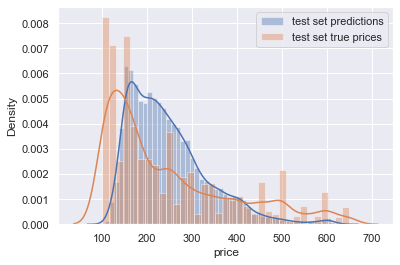

In [812]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.distplot(predictions_all_test_set,label='test set predictions')
sns.distplot(paintings_df_test['price'],label='test set true prices')
plt.legend();

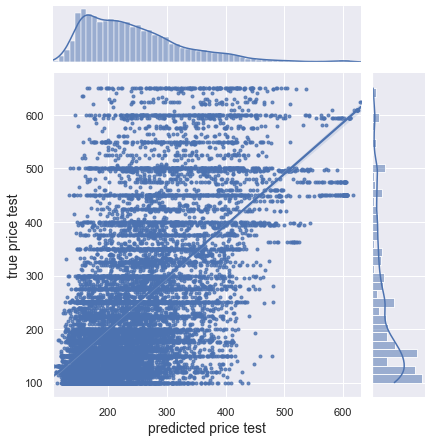

In [813]:
p = sns.jointplot(predictions_all_test_set,paintings_df_test['price'],kind='reg',marker='.');
p.set_axis_labels('predicted price test', 'true price test', fontsize=14);

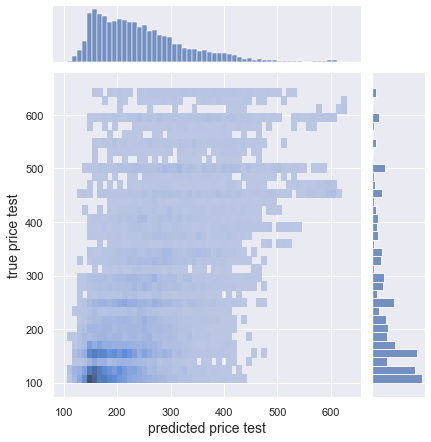

In [814]:
p = sns.jointplot(predictions_all_test_set,paintings_df_test['price'],kind='hist');
p.set_axis_labels('predicted price test', 'true price test', fontsize=14);

In [815]:
#Let's check on the training set:


In [805]:
predictions_all_train_set = blended_model_rforest_linear.predict(paintings_df_train)

In [806]:
len(predictions_all_train_set)

54843

In [807]:
np.median(predictions_all_train_set)

228.90034089857124

In [808]:
np.median(paintings_df_train['price'])

195.0

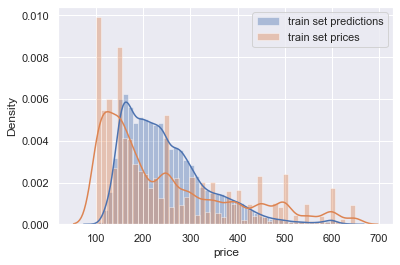

In [809]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.distplot(predictions_all_train_set,label='train set predictions')
sns.distplot(paintings_df_train['price'],label='train set prices')
plt.legend();

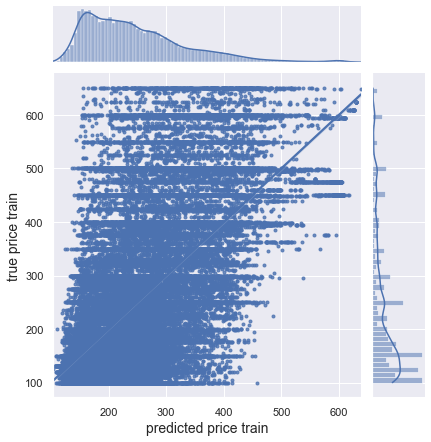

In [810]:
p = sns.jointplot(predictions_all_train_set,paintings_df_train['price'],kind='reg',marker='.');
p.set_axis_labels('predicted price train', 'true price train', fontsize=14);

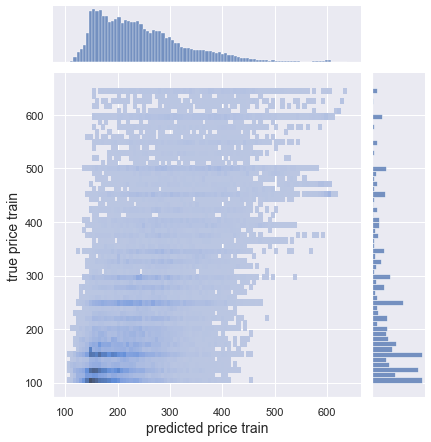

In [811]:
p = sns.jointplot(predictions_all_train_set,paintings_df_train['price'],kind='hist');
p.set_axis_labels('predicted price train', 'true price train', fontsize=14);

In [842]:
#How does the model perform on predicting prices within the 3 main price ranges (say 100-250, 250-450, 450-650):

In [843]:
sorted_indices_predictions_test = np.argsort(predictions_all_test_set)

In [844]:
predictions_all_test_set[sorted_indices_predictions_test]

array([106.09195122, 106.38425712, 106.99955575, ..., 625.32545088,
       629.17689187, 630.26750562])

In [845]:
num_pred_below_USD250_test = np.where(predictions_all_test_set[sorted_indices_predictions_test]<250)[0][-1]
num_pred_below_USD250_test

8218

In [846]:
idx_predictions_below_USD250_test = sorted_indices_predictions_test[:num_pred_below_USD250_test]
len(idx_predictions_below_USD250_test)

8218

In [847]:
num_pred_above_USD450_test = len(sorted_indices_predictions_test) - np.where(predictions_all_test_set[sorted_indices_predictions_test]>450)[0][0]
num_pred_above_USD450_test

401

In [848]:
idx_predictions_above_USD450_test = sorted_indices_predictions_test[-num_pred_above_USD450_test:]
len(idx_predictions_above_USD450_test)

401

In [849]:
idx_predictions_between_USD250_and_USD450_test = sorted_indices_predictions_test[num_pred_below_USD250_test:-num_pred_above_USD450_test:]
len(idx_predictions_between_USD250_and_USD450_test)

5092

In [850]:
len(predictions_all_test_set)

13711

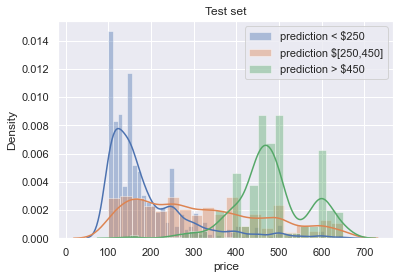

In [852]:
sns.distplot(paintings_df_test['price'].iloc[idx_predictions_below_USD250_test],label='prediction < $250')
sns.distplot(paintings_df_test['price'].iloc[idx_predictions_between_USD250_and_USD450_test],label='prediction $[250,450]')
sns.distplot(paintings_df_test['price'].iloc[idx_predictions_above_USD450_test],label='prediction > $450')
plt.legend();
plt.title('Test set');

In [853]:
sorted_indices_predictions_train = np.argsort(predictions_all_train_set)

In [854]:
predictions_all_train_set[sorted_indices_predictions_train]

array([103.60626692, 106.38425712, 107.68531615, ..., 630.26750562,
       630.26750562, 638.18769757])

In [855]:
num_pred_below_USD250_train = np.where(predictions_all_train_set[sorted_indices_predictions_train]<250)[0][-1]
num_pred_below_USD250_train

32722

In [856]:
idx_predictions_below_USD250_train = sorted_indices_predictions_train[:num_pred_below_USD250_test]
len(idx_predictions_below_USD250_train)

8218

In [857]:
num_pred_above_USD450_train = len(sorted_indices_predictions_train) - np.where(predictions_all_train_set[sorted_indices_predictions_train]>450)[0][0]
num_pred_above_USD450_train

1611

In [858]:
idx_predictions_above_USD450_train = sorted_indices_predictions_train[-num_pred_above_USD450_train:]
len(idx_predictions_above_USD450_train)

1611

In [859]:
idx_predictions_between_USD250_and_USD450_train = sorted_indices_predictions_train[num_pred_below_USD250_train:-num_pred_above_USD450_train:]
len(idx_predictions_between_USD250_and_USD450_train)

20510

In [860]:
len(predictions_all_train_set)

54843

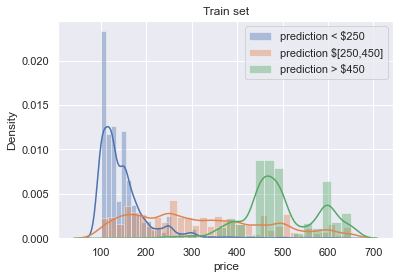

In [861]:
sns.distplot(paintings_df_train['price'].iloc[idx_predictions_below_USD250_train],label='prediction < $250')
sns.distplot(paintings_df_train['price'].iloc[idx_predictions_between_USD250_and_USD450_train],label='prediction $[250,450]')
sns.distplot(paintings_df_train['price'].iloc[idx_predictions_above_USD450_train],label='prediction > $450')
plt.legend();
plt.title('Train set');

In [ ]:
#While the price predictor is not that precise in general, and fails to selectively identify paintings in the $250-450 range,
#it at least rarely predicts a high price (>$450) for paintings listed at a low price (<$250), and viceversa

## 11) Demonstration of the finalized ML models (best prediction and nearest neighbors) in action

In [896]:
#This has now been moved to its own notebook 'Local Demo', along with the design of the Bokeh App which was eventually deployed

## 12) Models using the mean colors in the painting as provided by Etsy (which may or may not be accurate)

### The models below are preliminary work for future versions of the model integrating also the image information 

### Model 12a) Linear regression using only mean image features

In [232]:
image_mean_selector = ColumnTransformer([
    ('image_mean', 'passthrough', image_columns),
], remainder='drop')

In [233]:
#and then do the scaling of part of a Pipeline, e.g.
from sklearn.pipeline import Pipeline

image_mean_preproc_pipe = Pipeline([
    ('image mean selector', image_mean_selector),
    ('minmax scaling', MinMaxScaler()),
])

In [234]:
from sklearn.linear_model import LinearRegression

meanimage_linreg_pipe = Pipeline([('image mean preproc', image_mean_preproc_pipe),
                      ('linear reg', LinearRegression())])

In [235]:
#Train the model
meanimage_linreg_pipe.fit(paintings_df_train,prices_train);

In [236]:
#Predict prices on training set:
prices_train_pred = meanimage_linreg_pipe.predict(paintings_df_train)

In [237]:
#And return the R2 score as follows:
meanimage_linreg_pipe.score(paintings_df_train,prices_train)

0.001928421065628072

In [238]:
#Predict prices on test set:
prices_test_pred = meanimage_linreg_pipe.predict(paintings_df_test)

In [239]:
#And return the R2 score as follows:
meanimage_linreg_pipe.score(paintings_df_test,prices_test)

-0.002898599914475275

In [240]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Linear regression model using only mean image info')

Linear regression model using only mean image info:
Training R^2: 0.001928421065628072
Testing R^2: -0.002898599914475275
Training RMSE: USD 115.54047254467004
Testing RMSE: USD 115.67143680855257
Training MAE: USD 98.67095082579894
Testing MAE: USD 98.95511700695512


### Model 12b) Polynomial regression using only mean image features

In [241]:
from sklearn.linear_model import Ridge

meanimage_polyreg_ridge_pipe = Pipeline([('image mean preproc', image_mean_preproc_pipe),
                      ('polynomial_trans', PolynomialFeatures(degree=3,include_bias=False)),            
                      ('ridge', Ridge(alpha=10))])

In [242]:
from sklearn.model_selection import GridSearchCV

#I will then need to search for the right alpha using Cross Validation:
#Let's do a cross validation as before and see how well does this model perform:
param_grid = {'ridge__alpha': np.logspace(0,8,20)} 
meanimage_polyreg_ridge_CVmodel = GridSearchCV(meanimage_polyreg_ridge_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [243]:
#Train the model
meanimage_polyreg_ridge_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   16.7s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('image mean preproc',
                                        Pipeline(steps=[('image mean selector',
                                                         ColumnTransformer(transformers=[('image_mean',
                                                                                          'passthrough',
                                                                                          ['image_red',
                                                                                           'image_green',
                                                                                           'image_blue',
                                                                                           'image_hue',
                                                                                           'image_saturation',
                                                                                           'image_brightness'])])),
                                                        ('minmax scaling',
                                                         MinMaxScaler())])),
                                       ('polynomial_trans',
                                        PolynomialFeatures(degree=3,
                                                           include_bi...
             n_jobs=2,
             param_grid={'ridge__alpha': array([1.00000000e+00, 2.63665090e+00, 6.95192796e+00, 1.83298071e+01,
       4.83293024e+01, 1.27427499e+02, 3.35981829e+02, 8.85866790e+02,
       2.33572147e+03, 6.15848211e+03, 1.62377674e+04, 4.28133240e+04,
       1.12883789e+05, 2.97635144e+05, 7.84759970e+05, 2.06913808e+06,
       5.45559478e+06, 1.43844989e+07, 3.79269019e+07, 1.00000000e+08])},
             verbose=1)

In [244]:
meanimage_polyreg_ridge_CVmodel.best_params_

{'ridge__alpha': 6.951927961775605}

In [245]:
#Predict prices on training set:
prices_train_pred = meanimage_polyreg_ridge_CVmodel.predict(paintings_df_train)

In [246]:
#And return the R2 score as follows:
meanimage_polyreg_ridge_CVmodel.score(paintings_df_train,prices_train)

0.003812846400373715

In [247]:
#Predict prices on test set:
prices_test_pred = meanimage_polyreg_ridge_CVmodel.predict(paintings_df_test)

In [248]:
#And return the R2 score as follows:
meanimage_polyreg_ridge_CVmodel.score(paintings_df_test,prices_test)

-0.0008211807788558456

In [249]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Polynomial ridge regression model using only mean image info')

Polynomial ridge regression model using only mean image info:
Training R^2: 0.003812846400373715
Testing R^2: -0.0008211807788558456
Training RMSE: USD 115.43134697375764
Testing RMSE: USD 115.55157293368704
Training MAE: USD 98.54669933465834
Testing MAE: USD 98.81018140580922


In [250]:
#So it doesn't look like the mean image colors - as provided by Etsy at least - are very useful at all - but let's also try with tree-based models to see if things change

### Model 12c) Decision tree model using only mean image features

In [251]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
import pydot
#import graphviz

In [252]:
# #Recall that I already have the image mean selector, which need not change:
# image_mean_selector = ColumnTransformer([
#     ('image_mean', 'passthrough', image_columns),
# ], remainder='drop')

In [253]:
#there's no need to rescale for tree-based algorithms, so I can jump straight to the Pipeline performing the regression
from sklearn.pipeline import Pipeline

meanimage_dtree_pipe = Pipeline([
    ('image mean selector', image_mean_selector),
    ('dtree', DecisionTreeRegressor(max_depth=3)),
])

In [254]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,11,1)} #np.linspace(0,10,1)} 
meanimage_dtree_CVmodel = GridSearchCV(meanimage_dtree_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [255]:
meanimage_dtree_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:    5.7s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('image mean selector',
                                        ColumnTransformer(transformers=[('image_mean',
                                                                         'passthrough',
                                                                         ['image_red',
                                                                          'image_green',
                                                                          'image_blue',
                                                                          'image_hue',
                                                                          'image_saturation',
                                                                          'image_brightness'])])),
                                       ('dtree',
                                        DecisionTreeRegressor(max_depth=3))]),
             n_jobs=2, param_grid={'dtree__max_depth': range(2, 11)},
             verbose=1)

In [256]:
meanimage_dtree_CVmodel.best_params_['dtree__max_depth']

2

In [257]:
#Predict prices on training set:
prices_train_pred = meanimage_dtree_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
meanimage_dtree_CVmodel.score(paintings_df_train,prices_train)

0.002860441324474272

In [258]:
#Predict prices on test set:
prices_test_pred = meanimage_dtree_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
meanimage_dtree_CVmodel.score(paintings_df_test,prices_test)

-8.715612748999568e-05

In [259]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using only mean image features (provided by Etsy)')


Decision Tree model using only mean image features (provided by Etsy):
Training R^2: 0.002860441324474272
Testing R^2: -8.715612748999568e-05
Training RMSE: USD 115.48651288134302
Testing RMSE: USD 115.50919110655713
Training MAE: USD 98.62087469333322
Testing MAE: USD 98.76552929212325


In [260]:
#it seems that the mean image (at least as provided by Etsy) has basically no predictive power, so there's no need to continue investigating this or to also try random forests
meanimage_dtree_CVmodel.best_estimator_['dtree'].feature_importances_

array([0.        , 0.        , 0.22005025, 0.2496953 , 0.        ,
       0.53025444])

In [261]:
feature_names_meanimage_dtree = meanimage_dtree_CVmodel.best_estimator_['image mean selector'].get_feature_names()

meanimage_dtree_features_imp_df = pd.DataFrame(meanimage_dtree_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_meanimage_dtree,columns=['Dtree feature importance'])
meanimage_dtree_features_imp_df = meanimage_dtree_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
meanimage_dtree_features_imp_df

Dtree feature importance
image_brightness                  0.530254
image_hue                         0.249695
image_blue                        0.220050
image_red                         0.000000
image_green                       0.000000
image_saturation                  0.000000

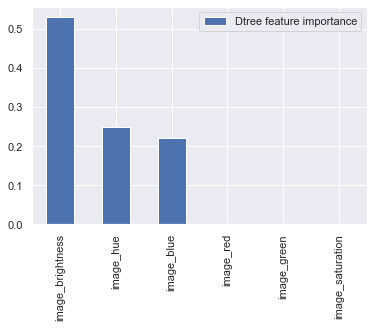

In [262]:
meanimage_dtree_features_imp_df.plot(kind="bar").legend(loc="upper right");